**Segmentez des clients d'un site e-commerce - Modélisation**

Ce notebook fait suite à la phase exploratoire réalisée précédemment et marque le début de la modélisation de la segmentation des clients d’Olist.

**Objectif**<br>
L’objectif de ce notebook est de mettre en œuvre des méthodes de clustering non supervisé pour identifier des groupes homogènes de clients, en se basant sur leurs comportements d’achat, leur satisfaction, leur fréquence de commande, ou encore leur ancienneté.

L’équipe Marketing attend une segmentation exploitable et facilement compréhensible, permettant de :

- Mieux cibler les campagnes commerciales.

- Identifier les clients à fort potentiel.

- Mieux accompagner les clients insatisfaits ou à risque.

- Proposer des actions différenciées par segment.


**Choix et application des algorithmes de clustering**

- K-Means

- DBSCAN

**Évaluation de la qualité des clusters**

- Silhouette Score

- Calinski-Harabasz Index

- Davies-Bouldin Score

**Interprétation et visualisation des segments**

- Analyse des profils types par cluster

- Regroupement en catégories marketing compréhensibles

- Visualisation des segments (2D / 3D)

**Méthodologie**<br>
Nous nous appuierons principalement sur des méthodes non supervisées telles que K-Means ou DBSCAN, avec une évaluation comparative pour choisir l’algorithme le plus pertinent.

Un travail particulier d’interprétation métier sera ensuite mené pour proposer à l’équipe Marketing une segmentation lisible et immédiatement actionnable.

Le résultat attendu de ce notebook est une segmentation client robuste et interprétable.

# Importation des librairies

In [1]:
# Bibliothèques pour la manipulation des données
import pandas as pd  
import numpy as np  
import joblib

# Bibliothèques pour le prétraitement et la normalisation des données
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

# Bibliothèques pour le clustering et l'évaluation des modèles
from sklearn.cluster import KMeans  
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Evaluation des clusters
from sklearn.metrics import silhouette_score 
from sklearn.metrics import davies_bouldin_score 
from sklearn.metrics import calinski_harabasz_score  
from sklearn.metrics import adjusted_rand_score 

# Bibliothèque pour les tests statistiques
from scipy.stats import f_oneway  # Test ANOVA pour comparer les moyennes entre groupes

# Bibliothèque pour les combinaisons 
from itertools import combinations  

# Bibliothèques pour la réduction de dimensionnalité
from sklearn.decomposition import PCA  
from sklearn.manifold import TSNE  

# Bibliothèques pour la visualisation des données
import matplotlib.pyplot as plt 
import seaborn as sns  
from mpl_toolkits.mplot3d import Axes3D  
from scipy.stats import ks_2samp

# Chargement du fichier

In [30]:
# Recharger le df
df_complet = pd.read_csv('df_client_modelisation.csv')

In [3]:
df_complet.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0             1         129.90                   12.00                 1500.0   
1             1          18.90                    8.29                  375.0   
2             1          69.00                   17.22                 1500.0   
3             1          25.99                   17.63                  150.0   
4             1         180.00                   16.89                 6050.0   

   longueur_moyenne_descriptions  diversite_categories  delai_livraison_moyen  \
0                          236.0                     1                    6.0   
1                          635.0                     1                    3.0   
2                          177.0                     1                   25.0   
3                         1741.0                     1                   20.0   
4                          794.0                     1                   13.0   

   total_retards_livraison  nb_paiements_total  moyenne_echeances_paiement  \
0                       -5                   1                         8.0   
1                       -5                   1                         1.0   
2                       -2                   1                         8.0   
3                      -12                   1                         4.0   
4                       -8                   1                         6.0   

   ...  note_moyenne_client  saison_la_plus_frequente jour_le_plus_frequent  \
0  ...                  5.0                 Printemps              Thursday   
1  ...                  4.0                 Printemps                Monday   
2  ...                  3.0                 Printemps                Friday   
3  ...                  4.0                   Automne              Thursday   
4  ...                  5.0                   Automne               Tuesday   

  recence_en_jours  a_donne_une_note  part_frais_livraison  \
0              160                 1              0.092379   
1              163                 1              0.438624   
2              585                 1              0.249565   
3              369                 1              0.678338   
4              336                 1              0.093833   

   categorie_moy_retard   region moyen_paiement_principal  \
0  Livraison ponctuelle  Sud-Est             carte_credit   
1  Livraison ponctuelle  Sud-Est             carte_credit   
2  Livraison ponctuelle      Sud             carte_credit   
3   Livraison en avance     Nord             carte_credit   
4  Livraison ponctuelle  Sud-Est             carte_credit   

    categorie_plus_commandee  
0            Maison_Mobilier  
1          Mode_Beaute_Sante  
2             Divertissement  
3  Electronique_Informatique  
4  Electronique_Informatique  

[5 rows x 21 columns]

In [4]:
df_complet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nb_commandes                   93103 non-null  int64  
 1   total_depense                  93103 non-null  float64
 2   frais_livraison_moyens         93103 non-null  float64
 3   poids_moyen_commandes          93103 non-null  float64
 4   longueur_moyenne_descriptions  93103 non-null  float64
 5   diversite_categories           93103 non-null  int64  
 6   delai_livraison_moyen          93103 non-null  float64
 7   total_retards_livraison        93103 non-null  int64  
 8   nb_paiements_total             93103 non-null  int64  
 9   moyenne_echeances_paiement     93103 non-null  float64
 10  diversite_max_paiements        93103 non-null  int64  
 11  note_moyenne_client            93103 non-null  float64
 12  saison_la_plus_frequente       93103 non-null 

**Dimensions du DataFrame :**<br>
Nombre d'observations (lignes) : 93,103 (correspond au nombre de clients).<br>
Nombre de variables (colonnes) : 21.<br>

**Description des variables :**<br>
**Variables quantitatives :**<br>
Ce sont les variables numériques qui peuvent être utilisées directement dans les analyses ou les modèles.

- nb_commandes (int64) : Nombre total de commandes passées par le client.
- total_depense (float64) : Montant total dépensé par le client.
- frais_livraison_moyens (float64) : Frais moyens de livraison payés par le client.
- poids_moyen_commandes (float64) : Poids moyen des commandes passées par le client.
- longueur_moyenne_descriptions (float64) : Longueur moyenne des descriptions des produits commandés.
- diversite_categories (int64) : Nombre de catégories différentes de produits achetées par le client.
- delai_livraison_moyen (float64) : Délai moyen de livraison des commandes.
- total_retards_livraison (int64) : Nombre de jours total de retards de livraison subis par le client.
- nb_paiements_total (int64) :  Nombre total de paiements effectués par le client pour régler ses commandes. Cela représente le nombre de fois où le client a payé au total, que ce soit en une seule fois ou en plusieurs échéances.
- moyenne_echeances_paiement (float64) : Moyenne des échéances de paiement pour les commandes du client.
- diversite_max_paiements (int64) : Nombre maximum de moyens de paiement différents utilisés par le client.
- note_moyenne_client (float64) : Note moyenne donnée par le client sur ses commandes.
- recence_en_jours (int64) : Nombre de jours depuis la dernière commande passée par le client.
- a_donne_une_note (int64) : Indicateur binaire indiquant si le client a donné une note ou non (1 = Oui, 0 = Non).
- part_frais_livraison (float64) : Part des frais de livraison dans le montant total dépensé.

**Variables qualitatives (catégorielles) :**<br>
Ces variables nécessitent un encodage avant d'être utilisées dans les modèles.
- saison_la_plus_frequente (object) : Saison où le client a passé le plus de commandes (Hiver, Printemps, Été, Automne).
- jour_le_plus_frequent (object) : Jour de la semaine où le client passe le plus souvent commande (Monday, Tuesday, etc.).
- categorie_moy_retard (object) : Catégorie moyenne des retards subis (Livraison ponctuelle, Retard modéré, etc.).
- region (object) : Région géographique du client (Nord, Sud-Est, etc.).
- moyen_paiement_principal (object) : Moyen de paiement principal utilisé par le client (Carte bancaire ou autre_moyen_de_paiement).
- categorie_plus_commandee (object) : Catégorie la plus commandée par le client (Mode, Électronique, etc.).

# Plan d'action pour la modélisation

Dans le cadre de ce projet, je vais adopter une approche progressive pour structurer les clusters. Je vais me concentrer uniquement sur les variables quantitatives, qui couvrent différents aspects du comportement client :

- RFM : recence_en_jours, nb_commandes, total_depense.
- Transport et livraison : delai_livraison_moyen, total_retards_livraison, frais_livraison_moyens, poids_moyen_commandes, part_frais_livraison.
- Diversité et paiement : diversite_categories, diversite_max_paiements, nb_paiements_total, moyenne_echeances_paiement.
- Satisfaction client : note_moyenne_client, a_donne_une_note.
- Descriptions produits : longueur_moyenne_descriptions.

Cette approche me permettra de construire une segmentation structurée basée sur des données quantitatives fiables et directement mesurables. En restant focalisé sur ces variables, je m'assure de minimiser le bruit et de maximiser la pertinence des clusters pour mieux comprendre et organiser les comportements clients.

In [5]:
# Liste des colonnes catégorielles à supprimer
colonnes_categorielles = [
    "saison_la_plus_frequente",
    "jour_le_plus_frequent",
    "categorie_moy_retard",
    "region",
    "moyen_paiement_principal",
    "categorie_plus_commandee"
]

# Création du nouveau DataFrame en supprimant les colonnes catégorielles
df = df_complet.drop(columns=colonnes_categorielles)

# Affichage des dimensions du nouveau DataFrame
print("Dimensions du DataFrame après suppression des variables catégorielles :", df.shape)

# Aperçu du nouveau DataFrame
df.head()

Dimensions du DataFrame après suppression des variables catégorielles : (93103, 15)


nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0             1         129.90                   12.00                 1500.0   
1             1          18.90                    8.29                  375.0   
2             1          69.00                   17.22                 1500.0   
3             1          25.99                   17.63                  150.0   
4             1         180.00                   16.89                 6050.0   

   longueur_moyenne_descriptions  diversite_categories  delai_livraison_moyen  \
0                          236.0                     1                    6.0   
1                          635.0                     1                    3.0   
2                          177.0                     1                   25.0   
3                         1741.0                     1                   20.0   
4                          794.0                     1                   13.0   

   total_retards_livraison  nb_paiements_total  moyenne_echeances_paiement  \
0                       -5                   1                         8.0   
1                       -5                   1                         1.0   
2                       -2                   1                         8.0   
3                      -12                   1                         4.0   
4                       -8                   1                         6.0   

   diversite_max_paiements  note_moyenne_client  recence_en_jours  \
0                        1                  5.0               160   
1                        1                  4.0               163   
2                        1                  3.0               585   
3                        1                  4.0               369   
4                        1                  5.0               336   

   a_donne_une_note  part_frais_livraison  
0                 1              0.092379  
1                 1              0.438624  
2                 1              0.249565  
3                 1              0.678338  
4                 1              0.093833

In [7]:
# Faire une copie du df de départ
df_copie = df.copy()

In [8]:
df_copie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nb_commandes                   93103 non-null  int64  
 1   total_depense                  93103 non-null  float64
 2   frais_livraison_moyens         93103 non-null  float64
 3   poids_moyen_commandes          93103 non-null  float64
 4   longueur_moyenne_descriptions  93103 non-null  float64
 5   diversite_categories           93103 non-null  int64  
 6   delai_livraison_moyen          93103 non-null  float64
 7   total_retards_livraison        93103 non-null  int64  
 8   nb_paiements_total             93103 non-null  int64  
 9   moyenne_echeances_paiement     93103 non-null  float64
 10  diversite_max_paiements        93103 non-null  int64  
 11  note_moyenne_client            93103 non-null  float64
 12  recence_en_jours               93103 non-null 

# Préparation des données

La standardisation est cruciale pour le clustering, surtout avec des algorithmes basés sur la distance comme K-Means. Voici pourquoi :
- Éviter la domination des variables à grande échelle : Les variables avec des valeurs plus grandes ne doivent pas influencer excessivement le calcul des distances.
- Assurer une contribution égale des variables : Toutes les variables doivent contribuer de manière équitable, indépendamment de leur unité ou échelle.
- Préserver la cohérence des résultats : Les unités utilisées ne doivent pas biaiser les clusters obtenus.

La standardisation met toutes les variables sur une même échelle (moyenne = 0, écart-type = 1), ce qui améliore la qualité et l'interprétation des clusters.

In [89]:
# Initialisation du scaler
scaler = StandardScaler()

# Application de la standardisation sur tout le DataFrame
df_standardized = scaler.fit_transform(df)

# Conversion en DataFrame pour conserver les noms de colonnes
df_standardized = pd.DataFrame(df_standardized, columns=df.columns)

In [90]:
# Vérification des statistiques après standardisation
print("Statistiques après standardisation :")
df_standardized.describe()

Statistiques après standardisation :


nb_commandes  total_depense  frais_livraison_moyens  \
count  9.310300e+04   9.310300e+04            9.310300e+04   
mean   1.665257e-16  -3.235880e-17            5.433836e-17   
std    1.000005e+00   1.000005e+00            1.000005e+00   
min   -1.597627e-01  -6.524909e-01           -1.060866e+00   
25%   -1.597627e-01  -4.355703e-01           -4.152594e-01   
50%   -1.597627e-01  -2.402491e-01           -2.582830e-01   
75%   -1.597627e-01   5.940723e-02            6.219116e-02   
max    6.679887e+01   6.163872e+01            8.254934e+01   

       poids_moyen_commandes  longueur_moyenne_descriptions  \
count           9.310300e+04                   9.310300e+04   
mean            1.095925e-16                   1.837736e-16   
std             1.000005e+00                   1.000005e+00   
min            -5.022940e-01                  -1.221397e+00   
25%            -4.395986e-01                  -6.699212e-01   
50%            -3.449244e-01                  -2.934926e-01   
75%            -6.090169e-02                   3.075539e-01   
max             3.829268e+01                   4.956370e+00   

       diversite_categories  delai_livraison_moyen  total_retards_livraison  \
count          9.310300e+04           9.310300e+04             9.310300e+04   
mean           3.863213e-16          -1.939620e-16            -8.776561e-17   
std            1.000005e+00           1.000005e+00             1.000005e+00   
min           -1.166374e-01          -1.266825e+00            -1.246372e+01   
25%           -1.166374e-01          -6.383184e-01            -4.368411e-01   
50%           -1.166374e-01          -2.193142e-01            -6.678316e-02   
75%           -1.166374e-01           3.044410e-01             4.883037e-01   
max            3.158934e+01           2.062614e+01             1.852863e+01   

       nb_paiements_total  moyenne_echeances_paiement  \
count        9.310300e+04                9.310300e+04   
mean        -1.975108e-16               -4.479862e-17   
std          1.000005e+00                1.000005e+00   
min         -1.778740e-01               -1.083539e+00   
25%         -1.778740e-01               -7.098670e-01   
50%         -1.778740e-01               -3.361948e-01   
75%         -1.778740e-01                4.111498e-01   
max          7.086909e+01                7.884595e+00   

       diversite_max_paiements  note_moyenne_client  recence_en_jours  \
count             9.310300e+04         9.310300e+04      9.310300e+04   
mean             -3.422859e-17         2.497504e-17     -3.586942e-17   
std               1.000005e+00         1.000005e+00      1.000005e+00   
min              -1.534920e-01        -2.470312e+00     -1.553895e+00   
25%              -1.534920e-01        -1.194789e-01     -8.068904e-01   
50%              -1.534920e-01         6.641321e-01     -1.254122e-01   
75%              -1.534920e-01         6.641321e-01      7.067776e-01   
max               6.514996e+00         6.641321e-01      3.000214e+00   

       a_donne_une_note  part_frais_livraison  
count      9.310300e+04          9.310300e+04  
mean       7.036512e-17         -1.119584e-16  
std        1.000005e+00          1.000005e+00  
min       -1.239581e+01         -9.917197e-01  
25%        8.067241e-02         -5.642546e-01  
50%        8.067241e-02         -2.657917e-01  
75%        8.067241e-02          2.330982e-01  
max        8.067241e-02          6.846182e+01

In [91]:
# Aperçu des premières lignes du DataFrame standardisé
df_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   longueur_moyenne_descriptions  diversite_categories  delai_livraison_moyen  \
0                      -0.862008             -0.116637              -0.638318   
1                      -0.243922             -0.116637              -0.952572   
2                      -0.953404             -0.116637               1.351951   
3                       1.469370             -0.116637               0.828196   
4                       0.002383             -0.116637               0.094939   

   total_retards_livraison  nb_paiements_total  moyenne_echeances_paiement  \
0                 0.673333           -0.177874                    1.905839   
1                 0.673333           -0.177874                   -0.709867   
2                 0.950876           -0.177874                    1.905839   
3                 0.025731           -0.177874                    0.411150   
4                 0.395789           -0.177874                    1.158494   

   diversite_max_paiements  note_moyenne_client  recence_en_jours  \
0                -0.153492             0.664132         -0.826548   
1                -0.153492            -0.119479         -0.806890   
2                -0.153492            -0.903090          1.958339   
3                -0.153492            -0.119479          0.542961   
4                -0.153492             0.664132          0.326722   

   a_donne_une_note  part_frais_livraison  
0          0.080672             -0.692563  
1          0.080672              0.428709  
2          0.080672             -0.183535  
3          0.080672              1.204990  
4          0.080672             -0.687852

# Application de K-Means pour le Clustering  (Essai 1)

Pour segmenter les clients, je vais utilisé l'algorithme K-Means. Ce choix est motivé par sa simplicité et sa rapidité. K-Means regroupe les clients en clusters en fonction de leur proximité dans l'espace des variables standardisées. Je vais déterminé le nombre optimal de clusters en utilisant la méthode du coude ou le silhouette score.

## Détermination de nombre de clusters optimal

### Méthode du coude

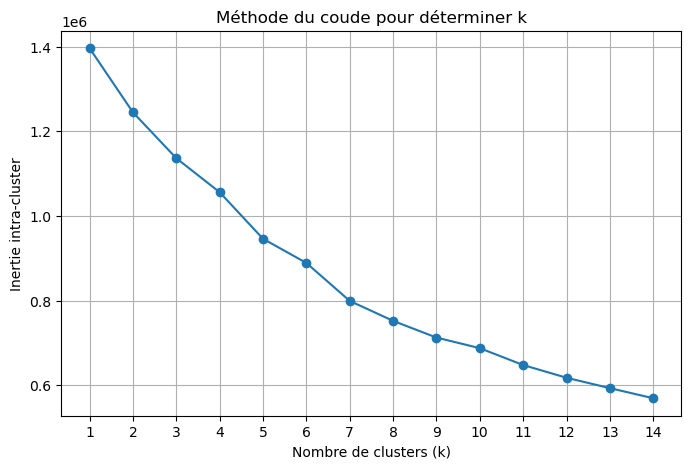

In [92]:
# Liste pour stocker les inerties (somme des distances intra-cluster)
inertias = []

# Tester différents nombres de clusters (k)
K = range(1, 15)  # De 1 à 15 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)  # Appliquer K-Means sur les données standardisées
    inertias.append(kmeans.inertia_)  # Stocker l'inertie (critère de qualité)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie intra-cluster')
plt.title('Méthode du coude pour déterminer k')
plt.xticks(K)
plt.grid()
plt.show()

On cherche le point où la courbe s’infléchit, indiquant que rajouter des clusters n’apporte plus beaucoup de valeur.

Dans ce cas, on observe une amélioration notable entre k=4 et k=5, mais après k=5, les gains deviennent moins marqués. Cela suggère que l'ajout de clusters supplémentaires apporte des améliorations limitées. Par conséquent, k=5 semble être un bon choix, car à partir de ce point, l'ajout de nouveaux clusters n'améliore plus de manière significative la séparation des données.

### Coefficient de silhouette

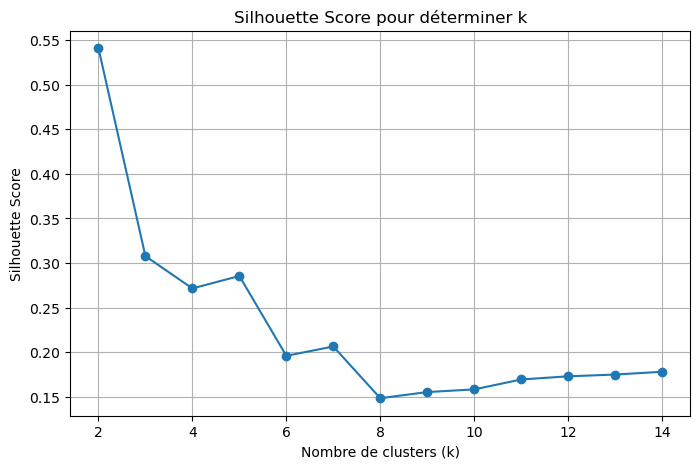

In [97]:
# Calcul du silhouette score pour chaque k
silhouette_scores = []
for k in range(2, 15):  # Le silhouette score nécessite au moins 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_standardized)
    score = silhouette_score(df_standardized, labels)
    silhouette_scores.append(score)

# Visualisation du silhouette score
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score pour déterminer k')
plt.grid()
plt.show()

Le silhouette score a été utilisé pour évaluer la qualité du clustering en fonction du nombre de clusters k. Le score maximal est atteint pour k=2 (0.5407), ce qui indique que les données sont bien regroupées en deux clusters distincts. Cependant, pour capturer davantage de nuances dans la segmentation client, k=5 est un bon compromis. Bien que le score soit inférieur (0.2856), il permet d'obtenir une segmentation plus détaillée tout en conservant une qualité raisonnable des clusters.

## Application de K-Means avec k=5 pour la Segmentation Client

In [98]:
# Appliquer l'algorithme K-Means avec k=5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized)

# Ajouter les labels des clusters au DataFrame original
df['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(5)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0     2129
1    69898
2     1399
3    14362
4     5315
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  Cluster 3  \
nb_commandes                        1.03       1.02       2.23       1.01   
total_depense                     129.03     107.84     268.40     122.04   
frais_livraison_moyens             22.53      18.94      22.24      23.18   
poids_moyen_commandes            2329.50    1577.86    2233.63    1952.74   
longueur_moyenne_descriptions     762.40     778.64     749.33     757.90   
diversite_categories                1.00       1.00       1.98       1.00   
delai_livraison_moyen              12.19       9.83      11.49      22.52   
total_retards_livraison           -12.87     -13.83     -28.40      -2.54   
nb_paiements_total                  2.59       1.02       2.35       1.02   
moyenne_echeances_paiement          1.56       2.68       3.31       2.98   
diversite_max_paiements             1.97       1.00       1.05       1.00   
note_moyenne_client                 4.13       4.62       4.28       1.93   
recence_en_jours                  308.12     285.28     244.61     289.10   
a_donne_une_note                    0.99       1.00       1.00       0.96   
part_frais_livraison                0.32       0.30       0.26       0.35   

                               Cluster 4  
nb_commandes                        1.02  
total_depense                     610.97  
frais_livraison_moyens             72.44  
poids_moyen_commandes           14320.69  
longueur_moyenne_descriptions    1091.49  
diversite_categories                1.00  
delai_livraison_moyen              13.78  
total_retards_livraison           -13.75  
nb_paiements_total                  1.04  
moyenne_echeances_paiement          5.99  
diversite_max_paiements             1.00  
note_moyenne_client                 4.01  
recence_en_jours                  291.52  
a_donne_une_note                    1.00  
part_frais_livraison                0.22

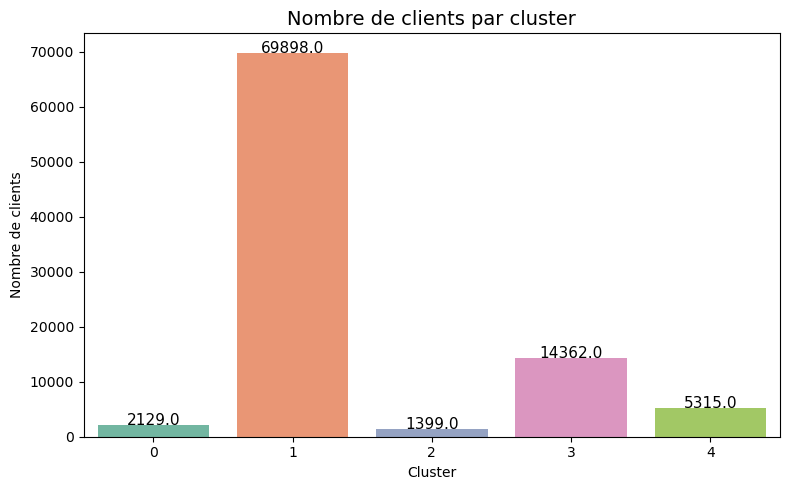

In [99]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

Afin de valider les résultats obtenus avec l'algorithme K-Means, il est essentiel d’évaluer la qualité du partitionnement réalisé. Pour cela, plusieurs indices de performance non supervisés peuvent être utilisés. Ces métriques permettent de juger si les clusters sont :
- Cohérents : Les points à l’intérieur d’un cluster sont proches les uns des autres.
- Bien séparés : Les clusters sont distincts les uns des autres.

Métriques utilisées
- Inertie intra-cluster :
- - Mesure la somme des distances au carré entre chaque point et son centroïde.
- - Une inertie plus faible indique des clusters plus compacts.
- - Utilisée principalement dans la méthode du coude pour déterminer le nombre optimal de clusters.

- Silhouette Score :
- - Évalue la cohésion intra-cluster et la séparation inter-cluster.
- - Varie entre -1 et +1 : un score proche de +1 indique des clusters bien séparés et compacts.

- Indice de Davies-Bouldin :
- - Compare la dispersion interne des clusters et leur proximité avec les clusters voisins.
- - Un score plus faible indique des clusters compacts et bien séparés.

- Score de Calinski-Harabasz :
- - Mesure le rapport entre l'inertie inter-cluster (séparation) et intra-cluster (compacité).
- - Plus il est élevé, meilleure est la séparation entre les clusters.

Ces métriques permettent :
- D’appuyer le choix du nombre optimal de clusters (k).
- De s’assurer de la pertinence de la segmentation obtenue.
- De comparer les performances des différentes simulations réalisées avec K-Means (par exemple, pour différents nombres de clusters).

In [100]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 945987.2304684247
Silhouette Score: 0.2855764561841436
Davies-Bouldin Index: 1.5009019466893256
Calinski-Harabasz Index: 11085.258703813188


Inertie intra-cluster : 945987.23<br>
Ce score représente la somme des distances au carré entre chaque point et son centroïde au sein des clusters. Une inertie plus faible indique des clusters plus compacts. Ce score est une mesure globale de la qualité du clustering.

Silhouette Score : 0.2856<br>
Ce score est modéré. Il indique que les clusters sont relativement bien formés, mais pas parfaitement séparés. Cela reste acceptable pour des données complexes ou fortement multidimensionnelles.

Davies-Bouldin Index : 1.50<br>
Plus cette valeur est faible, plus les clusters sont compacts et éloignés les uns des autres. Un score de 1.5 suggère une séparation correcte, sans être optimale.

Calinski-Harabasz Index : 11085.26<br>
Ce score élevé indique une bonne séparation entre les clusters, avec une bonne dispersion inter-clusters par rapport à la dispersion intra-cluster.

Ces résultats confirment que le modèle K-Means avec k = 5 parvient à produire une segmentation client pertinente. Bien que le Silhouette Score ne soit pas particulièrement élevé, les deux autres indicateurs soutiennent la qualité du regroupement réalisé.

## Analyse descriptive des clusters avec k=5

L'objectif ici est d'explorer les caractéristiques des clusters obtenus avec k=5 pour identifier les profils clients qu'ils représentent. Cela te permettra de donner un sens à chaque cluster et de vérifier s'ils sont exploitables.

### Identification des variables discriminantes (Variance inter-cluster)

Dans une analyse descriptive des clusters, il est essentiel de comprendre quelles variables contribuent le plus à la différenciation entre les groupes. La variance inter-cluster permet d'identifier les variables qui présentent des différences significatives entre les clusters. Ces variables discriminantes sont particulièrement utiles pour :

- Comprendre les différences clés entre les clusters :
Les variables avec une forte variance inter-cluster sont celles qui varient le plus d'un cluster à l'autre. Elles permettent de caractériser chaque groupe de manière distincte.
- Simplifier l'analyse :
Avec un grand nombre de variables (14 dans ce cas), il peut être difficile de comparer toutes les dimensions. En se concentrant sur les variables discriminantes, on peut réduire la complexité tout en conservant les informations essentielles.
- Prioriser les dimensions importantes :
Les variables discriminantes sont celles qui ont le plus d'impact sur la segmentation. Elles peuvent être mises en avant pour interpréter les clusters et guider des actions concrètes.

In [101]:
# Variance inter-cluster pour chaque variable
variance_inter_cluster = df.groupby('cluster').mean().var()

# Trier les variables par leur variance inter-cluster
variables_discriminantes = variance_inter_cluster.sort_values(ascending=False)

print("Variables discriminantes (par variance inter-cluster) :")
print(variables_discriminantes)

Variables discriminantes (par variance inter-cluster) :
poids_moyen_commandes            3.028497e+07
total_depense                    4.540793e+04
longueur_moyenne_descriptions    2.180362e+04
recence_en_jours                 5.540697e+02
frais_livraison_moyens           5.163631e+02
total_retards_livraison          8.504205e+01
delai_livraison_moyen            2.495220e+01
moyenne_echeances_paiement       2.693312e+00
note_moyenne_client              1.142333e+00
nb_paiements_total               6.331626e-01
nb_commandes                     2.912661e-01
diversite_categories             1.917943e-01
diversite_max_paiements          1.841531e-01
part_frais_livraison             2.423315e-03
a_donne_une_note                 2.577694e-04
dtype: float64


Sur cette base, nous avons sélectionné les variables suivantes comme prioritaires pour l'analyse descriptive :

In [102]:
# Variables prioritaires à analyser
variables_prioritaires = ['poids_moyen_commandes', 'total_depense', 'longueur_moyenne_descriptions',
                          'frais_livraison_moyens', 'recence_en_jours', 'total_retards_livraison',
                          'delai_livraison_moyen', 'note_moyenne_client', 'nb_commandes']

Ces variables ont été choisies car :
- Elles présentent une forte variance inter-cluster.
- Elles permettent de différencier clairement les clusters.

Certaines, comme nb_commandes, ont été conservées car elles font partie du modèle RFM ou sont importantes sur le plan métier.

Les autres variables ont été jugées peu discriminantes en raison de leur faible variance inter-cluster (par exemple, a_donne_une_note ou part_frais_livraison) et ne seront pas analysées davantage.

### Moyennes et médianes des variables par cluster

In [103]:
# Moyennes par cluster
moyennes_prioritaires = df.groupby('cluster')[variables_prioritaires].mean()
print("Moyennes par cluster :")
moyennes_prioritaires.T.round(2)

Moyennes par cluster :


cluster                              0        1        2        3         4
poids_moyen_commandes          2329.50  1577.68  2233.63  1952.42  14311.43
total_depense                   129.03   107.82   268.40   122.05    610.70
longueur_moyenne_descriptions   762.40   778.53   749.33   758.26   1091.46
frais_livraison_moyens           22.53    18.93    22.24    23.19     72.40
recence_en_jours                308.12   285.29   244.61   289.09    291.46
total_retards_livraison         -12.87   -13.83   -28.40    -2.52    -13.75
delai_livraison_moyen            12.19     9.83    11.49    22.53     13.77
note_moyenne_client               4.13     4.62     4.28     1.93      4.01
nb_commandes                      1.03     1.02     2.23     1.01      1.02

In [104]:
# Médianes par cluster
medianes_prioritaires = df.groupby('cluster')[variables_prioritaires].median()
print("\nMédianes par cluster :")
medianes_prioritaires.T.round(2)


Médianes par cluster :


cluster                             0       1        2       3         4
poids_moyen_commandes          850.00  650.00  1025.00  798.50  12783.00
total_depense                   85.00   79.90   189.47   89.90    399.99
longueur_moyenne_descriptions  595.00  595.00   627.00  595.00    872.00
frais_livraison_moyens          17.63   16.34    17.95   18.23     60.13
recence_en_jours               295.00  268.00   222.00  264.00    273.00
total_retards_livraison        -13.00  -13.00   -27.00   -5.00    -13.00
delai_livraison_moyen           10.00    9.00    10.00   20.00     12.00
note_moyenne_client              5.00    5.00     4.67    1.00      5.00
nb_commandes                     1.00    1.00     2.00    1.00      1.00

### Visualisation des distributions par variable 

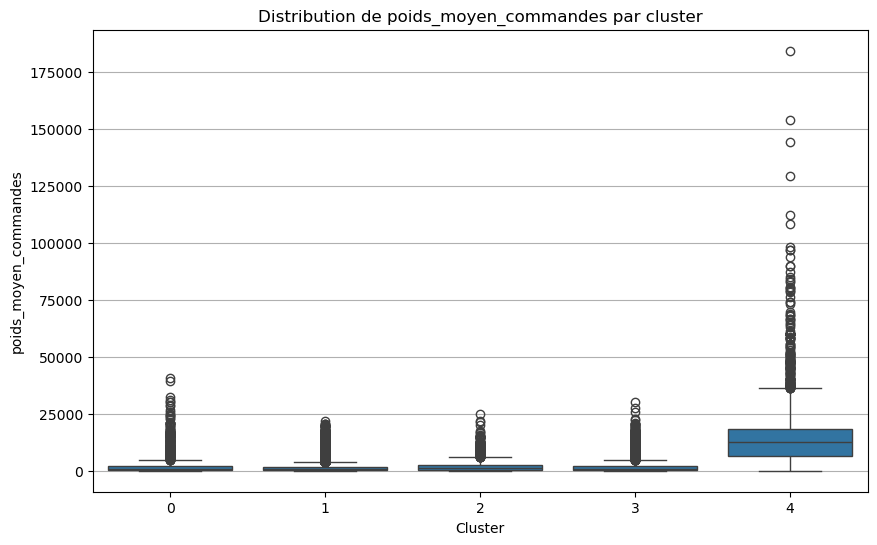

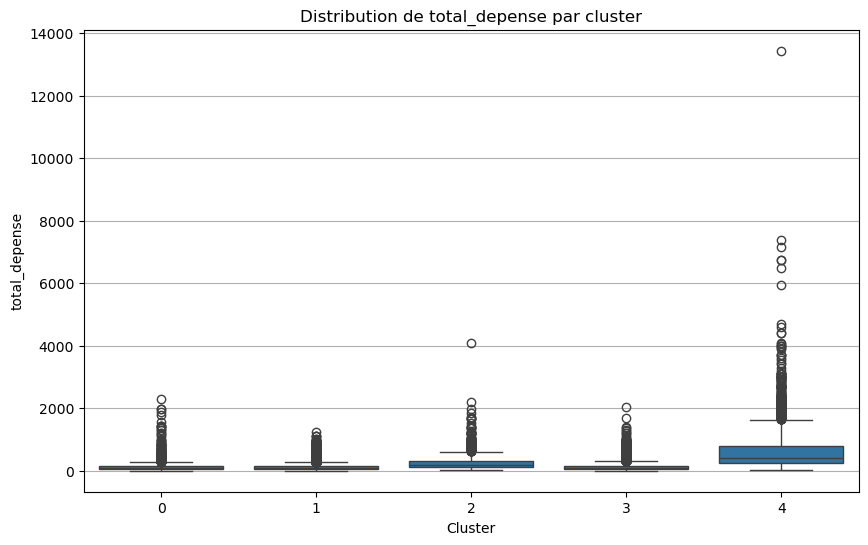

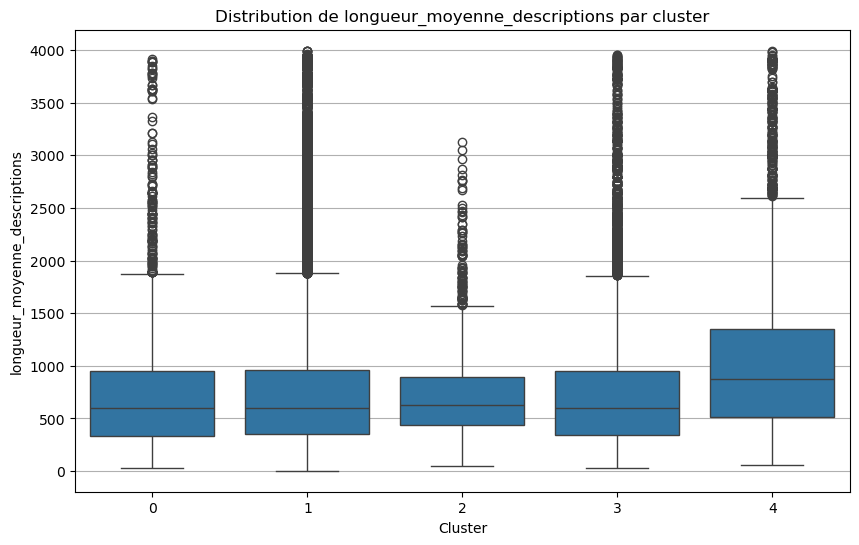

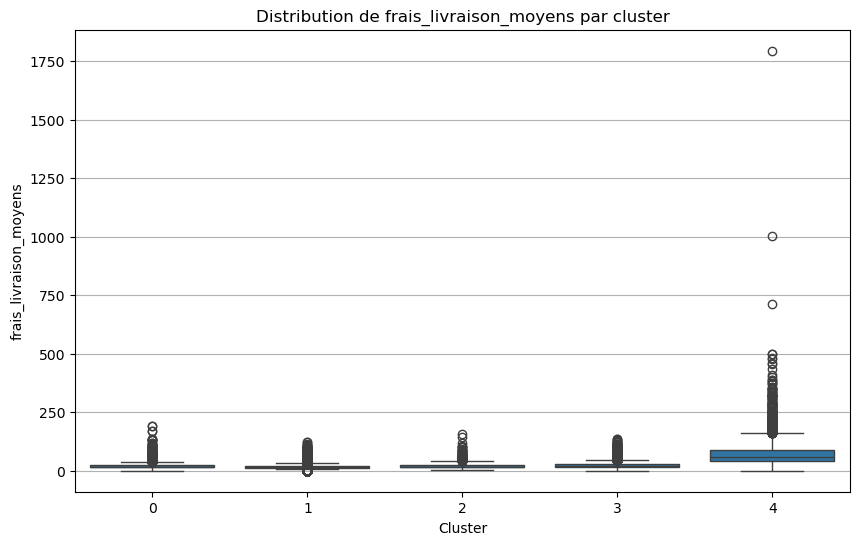

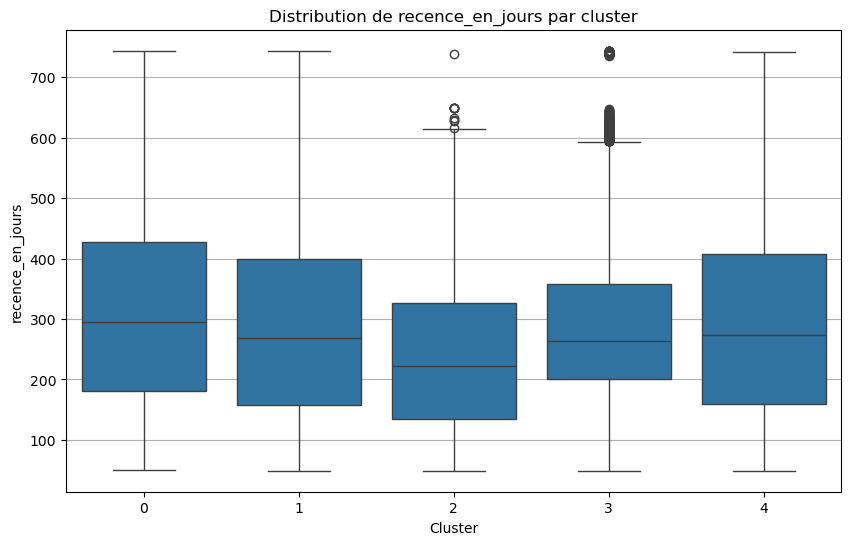

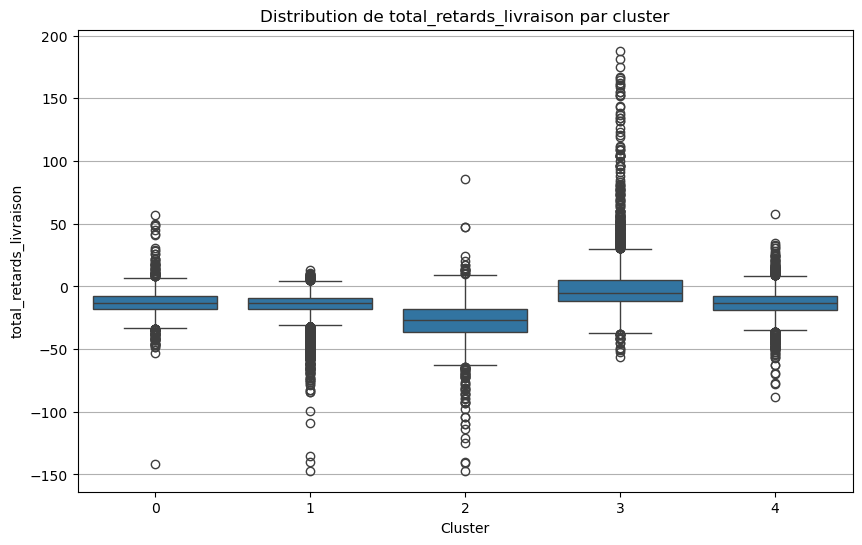

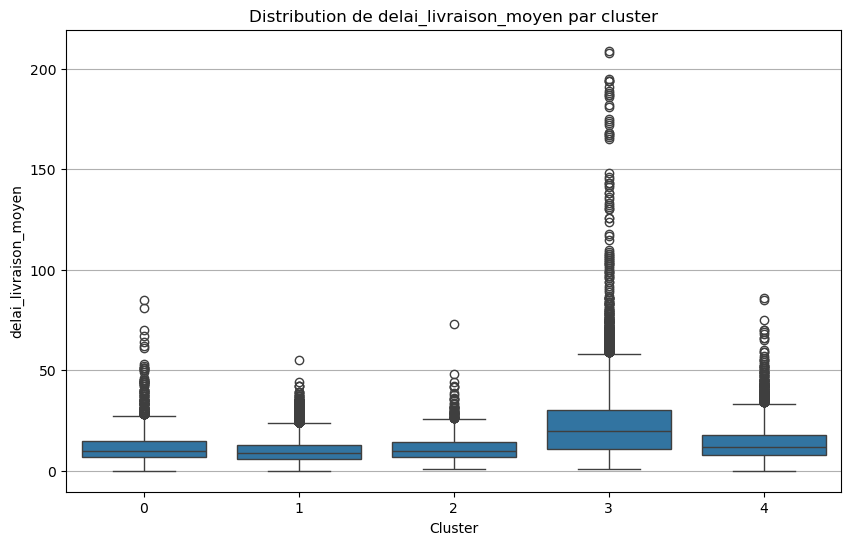

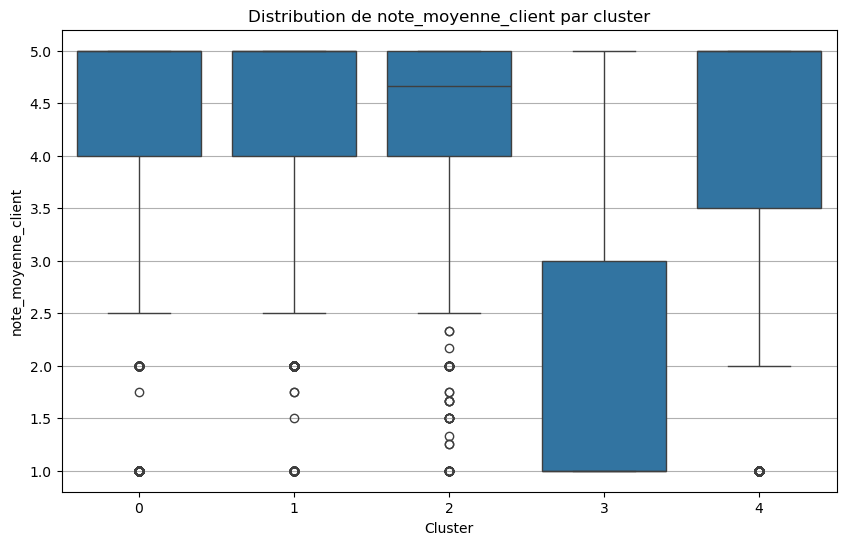

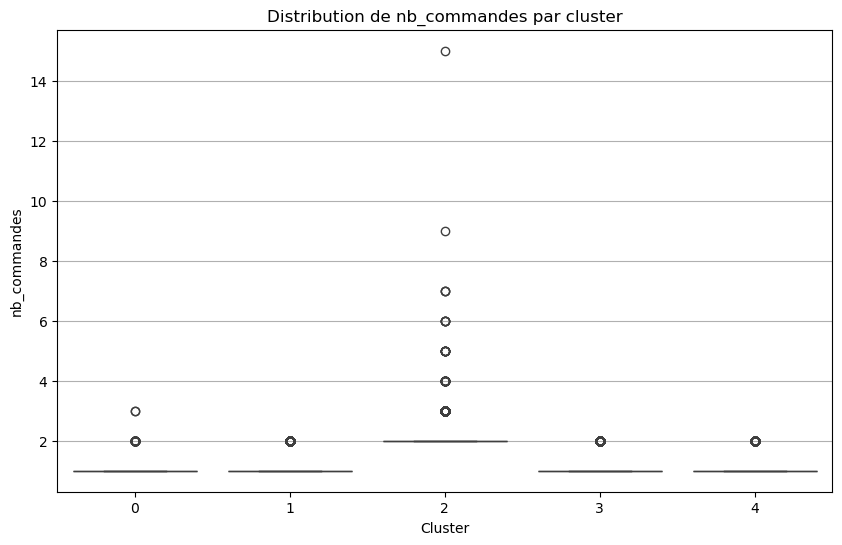

In [105]:
# Créer un boxplot pour chaque variable
for var in variables_prioritaires:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=var, data=df)
    plt.title(f"Distribution de {var} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(axis='y')
    plt.show()

**Profils des clusters :**

**Cluster 0 : 2129 clients**
- Poids moyen des commandes : Moyenne élevée (2329.50) mais médiane faible (850.00) → Commandes lourdes pour certains clients, mais la majorité commande des produits plus légers.
- Total dépensé : Moyenne modérée (129.03) et médiane faible (85.00) → Dépenses faibles à modérées.
- Recence : Moyenne élevée (308 jours) → Clients anciens.
- longueur_moyenne_descriptions : Moyenne élevée (762.40), médiane modérée (595.00) → Descriptions relativement longues.
- frais_livraison_moyens : Moyenne modérée (22.53), médiane modérée (17.63) → Frais de livraison moyens.
- total_retards_livraison : Moyenne négative (-12.87), médiane négative (-13) → Peu de retards.
- delai_livraison_moyen : Moyenne modérée (12.19 jours), médiane modérée (10 jours) → Délais moyens.
- note_moyenne_client : Moyenne élevée/modérée (4.13), médiane élevée (5) → Bonne satisfaction client.
- nb_commandes : Moyenne : 1.03, Médiane : 1.00 → Les clients passent très peu de commandes (en moyenne une seule commande).

Profil : Clients anciens avec commandes lourdes occasionnelles, dépenses faibles/modérées, délais moyens, et bonne satisfaction. Clients occasionnels avec faible fréquence d'achat.

**Cluster 1 : 69898 clients**
- Poids moyen des commandes : Moyenne faible (1577.68) et médiane faible (650.00) → Commandes légères.
- Total dépensé : Moyenne faible (107.82) et médiane faible (79.90) → Dépenses faibles.
- longueur_moyenne_descriptions : Moyenne élevée/modérée (778.53), médiane modérée/faible (595.00) → Descriptions longues.
- frais_livraison_moyens : Moyenne faible/modérée (18.93), médiane faible/modérée (16.34) → Frais de livraison faibles à modérés.
- recence_en_jours : Moyenne modérée/faible (285 jours), médiane modérée/faible (268 jours) → Clients relativement anciens.
- total_retards_livraison : Moyenne négative importante (-13.83, médiane -13) → Très peu de retards.
- delai_livraison_moyen : Moyenne faible/modérée (9.83 jours, médiane 9) → Délais rapides.
- note_moyenne_client : Moyenne élevée/modérée (4.62, médiane 5) → Bonne satisfaction client.
- nb_commandes : Moyenne : 1.02, Médiane : 1.00 → Les clients passent également très peu de commandes. 

Profil : Clients anciens avec commandes légères, dépenses faibles, délais rapides, et bonne satisfaction. Clients occasionnels avec faible fréquence d'achat

**Cluster 2 : 1399 clients**
- Poids moyen des commandes : Moyenne élevée (2233.63) et médiane modérée (1025.00) → Commandes lourdes pour certains clients.
- Total dépensé : Moyenne élevée (268.40) et médiane modérée (189.47) → Dépenses importantes.
- longueur_moyenne_descriptions : Moyenne modérée/faible (749.33), médiane modérée/faible (627.00) → Descriptions moyennes à courtes.
- frais_livraison_moyens : Moyenne modérée/faible (22.24, médiane 17.95) → Frais de livraison moyens/faibles.
- recence_en_jours : Moyenne faible/modérée (244 jours, médiane 222) → Clients récents/modérés.
- total_retards_livraison : Moyenne négative importante (-28.40, médiane -27) → Très peu de retards.
- delai_livraison_moyen : Moyenne modérée/faible (11.49 jours, médiane 10) → Délais moyens à rapides.
- note_moyenne_client : Moyenne élevée/modérée (4.28, médiane 4.67) → Bonne satisfaction client.
- nb_commande : Moyenne : 2.23, Médiane : 2.00 → Les clients passent plusieurs commandes (environ deux en moyenne).
Profil : Clients récents, gros acheteurs avec commandes lourdes, délais moyens/rapides, et bonne satisfaction. Clients réguliers avec fréquence d'achat plus élevée


**Cluster 3 : 14362 clients**
- Poids moyen des commandes : Moyenne modérée (1952.42) mais médiane faible (798.50) → Commandes moyennes à légères.
- Total dépensé : Moyenne faible/modérée (122.05) et médiane faible/modérée (89.90) → Dépenses faibles à modérées.
- longueur_moyenne_descriptions : Moyenne modérée/faible (758.26, médiane 595) → Descriptions moyennes à courtes.
- frais_livraison_moyens : Moyenne modérée/faible (23.19, médiane 18.23) → Frais de livraison moyens/faibles.
- recence_en_jours : Moyenne modérée/faible (289 jours, médiane 264) → Clients relativement anciens/modérés.
- total_retards_livraison : Faible négatif/médian négatif (-2 à -5) peu impacté par retards
- delai_livraison_moyen : Moyenne élevée (22.53 jours), médiane élevée (20 jours) → Délais de livraison longs.
- note_moyenne_client : Moyenne très faible (1.93), médiane très faible (1) → Insatisfaction importante.
- nb_commandes : Moyenne : 1.01, Médiane : 1.00 → Les clients passent très peu de commandes. Clients occasionnels avec faible fréquence d'achat

Profil : Clients anciens, petits acheteurs avec commandes moyennes à légères, délais de livraison longs, et forte insatisfaction.

**Cluster 4 : 5315 clients**
- Poids moyen des commandes : Moyenne très élevée (14311.43) et médiane très élevée (12783.00) → Commandes extrêmement lourdes.
- Total dépensé : Moyenne très élevée (610.70) et médiane élevée/modérée (399.99) → Gros acheteurs.
- longueur_moyenne_descriptions : Moyenne élevée/modérée (1091.46), médiane modérée (872.00) → Descriptions longues.
- frais_livraison_moyens : Moyenne très élevée (72.40), médiane élevée/modérée (60.13) → Frais de livraison très élevés.
- recence_en_jours : Moyenne modérée/faible (291 jours, médiane 273) → Clients relativement anciens.
- total_retards_livraison : Moyenne négative importante (-13.75, médiane -13) → Très peu de retards.
- delai_livraison_moyen : Moyenne modérée/faible (13.77 jours, médiane 12) → Délais moyens à rapides.
- note_moyenne_client : Moyenne élevée/modérée (4.01, médiane élevée/modérée 5) → Bonne satisfaction client.
- nb_commandes : Moyenne : 1.02, Médiane : 1.00 → Les clients passent très peu de commandes. Clients occasionnels avec faible fréquence d'achat

Profil : Gros acheteurs anciens avec commandes extrêmement lourdes, frais de livraison élevés, délais moyens, et bonne satisfaction.


| Cluster | Profil principal                             | Caractéristiques clés                                               |
|:--------|:---------------------------------------------|:--------------------------------------------------------------------|
| 0       | Clients anciens avec commandes lourdes occasionnelles | Poids élevé, dépenses faibles/modérées, satisfaction correcte, frais de livraison modérés, clients occasionnels. |
| 1       | Clients anciens avec commandes légères      | Poids léger, dépenses faibles, bonne satisfaction, frais de livraison raisonnables, clients occasionnels. |
| 2       | Clients récents, gros acheteurs              | Poids élevé, dépenses importantes, bonne satisfaction, avance de livraison fréquents, Clients réguliers |
| 3       | Clients anciens insatisfaits                 | Poids moyen/léger, dépenses faibles/modérées, insatisfaction, frais de livraison élevés, clients occasionnels. |
| 4       | Gros acheteurs anciens                       | Poids très élevé, grosses dépenses, bonne satisfaction, frais de livraison élevés, clients occasionnels. |


## Évaluation de la pertinence des variables

### Heatmap des contributions des variables à la segmentation

Afin d’identifier les variables les plus discriminantes pour chaque cluster, nous visualisons les moyennes standardisées par cluster à l’aide d’une heatmap. Cela permet de repérer rapidement quelles variables sont significativement plus hautes ou plus basses que la moyenne globale dans chaque groupe de clients.

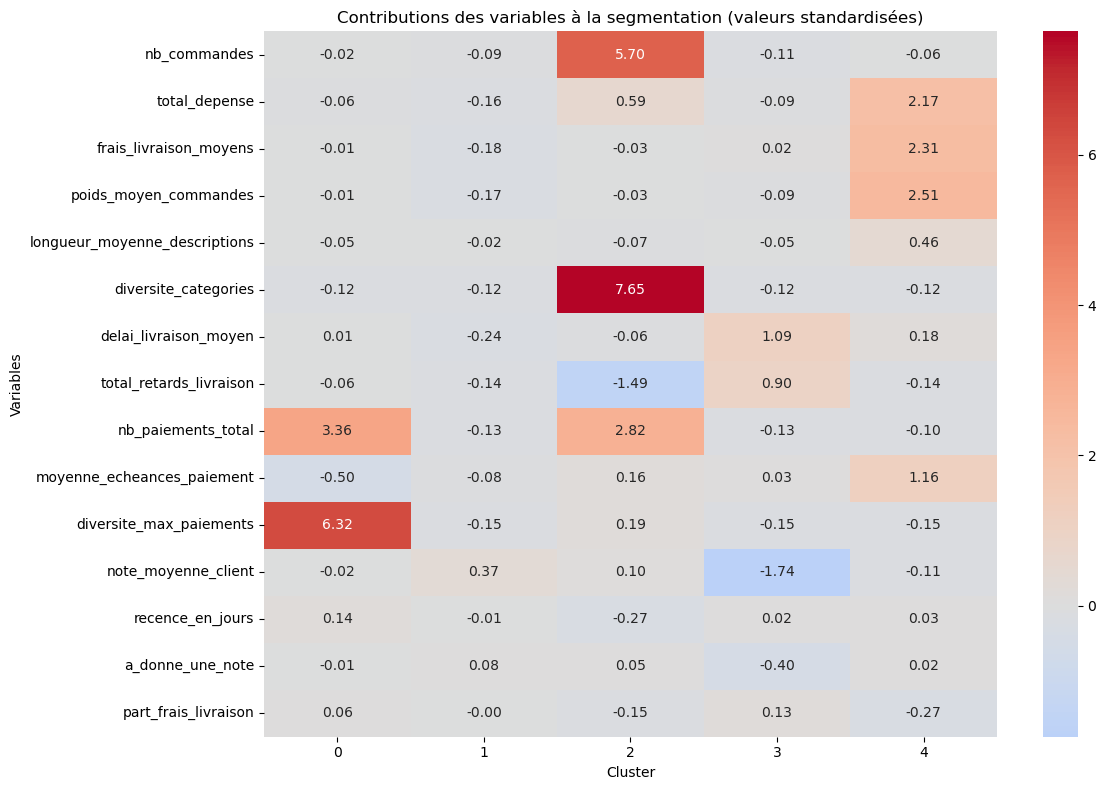

In [106]:
# Ajouter les labels des clusters aux données standardisées
df_standardized['cluster'] = cluster_labels

# Calculer les moyennes standardisées de chaque variable par cluster
cluster_means_std = df_standardized.groupby('cluster').mean()

# Tracer une heatmap pour visualiser les contributions des variables
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_std.T, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Contributions des variables à la segmentation (valeurs standardisées)")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

**Interprétation de la heatmap**<br>
**Couleurs :**<br>
- Rouge : Valeurs standardisées positives → La variable est au-dessus de la moyenne globale dans ce cluster.
- Bleu : Valeurs standardisées négatives → La variable est en dessous de la moyenne globale dans ce cluster.

Annotations : Les chiffres indiquent l'écart à la moyenne (en écarts-types).


**Cluster 0 — Client “moyen” avec paiements diversifiés**
- Aucune variable très marquée (valeurs proches de 0), sauf :
Nb paiements total (+3.36) et diversité des paiements (+6.32) : ces clients utilisent beaucoup de moyens de paiement différents.
- Le reste des variables est très proche de la moyenne.

Interprétation : Clients “standards” dans leurs comportements d’achat, mais avec une forte diversité de paiement. 

**Cluster 1 — Petits clients fidèles et satisfaits**
- Faibles valeurs sur :
total_depense (−0.15), frais_livraison_moyens (−0.17), poids_moyen_commandes (−0.17).
- Note client élevée (+0.36), ainsi qu’une légère tendance à laisser un avis (+0.08).

Interprétation : Clients peu dépensiers, avec de petites commandes, mais globalement satisfaits. Fidèles et peu problématiques.

**Cluster 2 — Super clients ultra actifs et variés**
- Nb commandes extrêmement élevé (+5.70) → très gros volumes.
- Diversité catégories +7.64 → panier très varié.
- Nb paiements total (+2.81) et diversité de paiement (+0.19).
- Peu de retards (−1.49), note moyenne positive (+0.10).

Interprétation : Top clients en volume et régularité. Très engagés, diversifiés, peu de problèmes. 

**Cluster 3 — Clients insatisfaits et impactés par la logistique**
- Delai livraison (+1.09) et retards (+0.90) → forte exposition aux problèmes logistiques.
- Note moyenne client très basse (−1.74) et moins enclins à donner une note (−0.40).
- Variables d'achat proches de 0.

Interprétation : Clients potentiellement mécontents à cause de la qualité de service. À surveiller ou réengager.

**Cluster 4 — Gros clients à forte valeur**
- total_depense (+2.17), frais livraison (+2.31), poids moyen commandes (+2.50) → gros paniers.
- longueur descriptions (+0.46) → achats potentiellement plus réfléchis.
- moyenne échéances paiement très élevée (+1.15) 

Interprétation : Clients à très forte valeur, qui commandent en volume avec de longs délais de paiement. Cible à fidéliser et privilégier.

### Résultats ANOVA : Identification des variables significatives

L'objectif de cette étape est d'évaluer quantitativement si certaines variables sont peu discriminantes entre les clusters, c'est-à-dire si elles n'apportent pas de différences significatives dans la segmentation.

Après avoir visualisé les contributions des variables à l'aide de la heatmap, nous utilisons une approche statistique basée sur l'ANOVA (Analyse de Variance) pour valider ces observations. L'ANOVA permet de tester si les moyennes d'une variable diffèrent significativement entre les clusters.

Méthodologie :<br>
Pour chaque variable, nous effectuons un test ANOVA en comparant les moyennes de cette variable entre les clusters.
Une variable est considérée comme peu discriminante si :
- La statistique F est faible (indiquant que la variance inter-cluster est faible par rapport à la variance intra-cluster).
- La valeur-p associée est élevée (> 0.05), ce qui signifie qu'il n'y a pas de différence statistiquement significative entre les clusters.

Résultats attendus :
- Les variables avec une forte statistique F et une valeur-p faible (< 0.05) sont considérées comme discriminantes et contribuent à différencier les clusters.
- Les variables avec une faible statistique F ou une valeur-p élevée (> 0.05) seront identifiées comme peu discriminantes et pourront être modifiées (regroupement en classes, par exemple) ou exclues du modèle.

In [112]:
# Liste de toutes les variables quantitatives présentes dans le DataFrame (exclure 'cluster')
variables_a_tester = [col for col in df.columns if col != 'cluster']

# Dictionnaire pour stocker les résultats ANOVA
anova_results = {}

# Effectuer l'ANOVA pour chaque variable
for variable in variables_a_tester:
    # Extraire les valeurs de la variable par cluster
    clusters = [df[df['cluster'] == cluster][variable] for cluster in df['cluster'].unique()]
    
    # Test ANOVA
    f_stat, p_value = f_oneway(*clusters)
    
    # Stocker les résultats dans le dictionnaire
    anova_results[variable] = {'F-statistic': f_stat, 'p-value': p_value}

# Convertir les résultats en DataFrame pour une meilleure lisibilité
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p-value', ascending=True)

print("Résultats ANOVA :")
print(anova_df)

Résultats ANOVA :
                                 F-statistic        p-value
nb_commandes                    22947.581221   0.000000e+00
total_depense                    9730.528847   0.000000e+00
frais_livraison_moyens          11418.233836   0.000000e+00
poids_moyen_commandes           14409.118118   0.000000e+00
diversite_categories           191746.354819   0.000000e+00
delai_livraison_moyen            6890.498407   0.000000e+00
total_retards_livraison          4959.313331   0.000000e+00
nb_paiements_total              15040.620549   0.000000e+00
moyenne_echeances_paiement       2238.877672   0.000000e+00
diversite_max_paiements        350293.025151   0.000000e+00
note_moyenne_client             30950.010227   0.000000e+00
a_donne_une_note                  722.498837   0.000000e+00
longueur_moyenne_descriptions     310.050129  1.816791e-265
part_frais_livraison              163.308507  1.444455e-139
recence_en_jours                   40.515488   5.656140e-34


Nous avons utilisé deux méthodes pour évaluer la contribution des variables à la segmentation : la variance inter-cluster et l'ANOVA.

- La variance inter-cluster nous a permis d'identifier **les variables qui varient le plus entre les clusters**. Cependant, elle ne prend pas en compte la dispersion des valeurs à l'intérieur de chaque cluster.

- L'ANOVA, quant à elle, compare la variance inter-cluster à la variance intra-cluster, nous donnant une idée plus complète de la capacité d'une variable à différencier les clusters tout en étant cohérente au sein de chaque groupe.

Les résultats peuvent différer entre ces deux méthodes si une variable a une forte variance inter-cluster mais une grande dispersion intra-cluster. Dans ce cas, l'ANOVA nous indique que cette variable n'est pas aussi discriminante qu'elle le semble à première vue.

| Variable                        | Variance inter-cluster | F-statistic (ANOVA) | p-value (ANOVA) | Conclusion                                                                 |
|:---------------------------------|:-----------------------|:--------------------|:----------------|:--------------------------------------------------------------------------|
| poids_moyen_commandes           | 3.03e+07               | 14409.12            | 0.00            | Très discriminante, à conserver.                                           |
| total_depense                   | 4.54e+04               | 9730.53             | 0.00            | Très discriminante, à conserver.                                           |
| longueur_moyenne_descriptions    | 2.18e+04               | 310.05              | 1.82e-265       | Modérément discriminante, peut être regroupée en classes pour simplification. |
| recence_en_jours                | 554.07                 | 40.52               | 5.66e-34        | Faiblement discriminante dans le clustering, mais indispensable pour RFM. |
| frais_livraison_moyens          | 516.36                 | 11418.23            | 0.00            | Très discriminante, à conserver.                                           |
| total_retards_livraison         | 85.04                  | 4959.31             | 0.00            | Très discriminante, à conserver.                                           |
| delai_livraison_moyen          | 24.95                  | 6890.50             | 0.00            | Très discriminante, à conserver.                                           |
| moyenne_echeances_paiement      | 2.69                   | 2238.88             | 0.00            | Très discriminante, à conserver.                                           |
| note_moyenne_client             | 1.14                   | 30950.01            | 0.00            | Très discriminante, à conserver.                                           |
| nb_paiements_total             | 0.63                   | 15040.62            | 0.00            | Très discriminante, à conserver.                                           |
| nb_commandes                    | 0.29                   | 22947.58            | 0.00            | Très discriminante, à conserver (RFM).                                     |
| diversite_categories            | 0.19                   | 191746.35           | 0.00            | Très discriminante, à conserver (fort impact).                             |
| diversite_max_paiements         | 0.18                   | 350293.03           | 0.00            | Très discriminante, à conserver (fort impact).                             |
| part_frais_livraison            | 0.00                   | 163.31              | 1.44e-139       | Modérément discriminante, peut être regroupée en classes ou exclue si inutile. |
| a_donne_une_note                | 0.00                   | 722.50              | 0.00            | Faiblement discriminante, pourrait être utilisée dans une autre analyse (satisfaction). |

F-statistic :<br>
- La statistique F mesure le ratio entre la variance inter-cluster et la variance intra-cluster.
- Une valeur élevée de F indique que la variance entre les clusters est beaucoup plus grande que celle à l'intérieur des clusters, ce qui signifie que la variable discrimine bien les clusters.

p-value :<br>
- La p-value indique si la statistique F est significative.
- Une p-value proche de 0 (souvent < 0.05) signifie que la variable a un effet significatif sur la différenciation des clusters.

Les analyses montrent que certaines variables sont très discriminantes et doivent être conservées dans le modèle (nb_commandes, total_depense, etc.), tandis que d'autres pourraient être regroupées ou exclues (part_frais_livraison, etc.).

Actions proposées :
- Conserver les variables hautement discriminantes sans modification.
- Regrouper certaines variables modérément discriminantes (longueur_moyenne_descriptions, etc.) en classes.
- Tester l'impact de l'exclusion ou de la transformation des variables faiblement discriminantes .

 ### Analyse des variables modérément ou faiblement discriminantes
 
Avant de regrouper les variables en classes, nous avons visualisé leurs distributions pour mieux comprendre leur répartition et identifier des seuils pertinents.

Variables analysées :
- longueur_moyenne_descriptions : Histogramme et boxplot pour observer la répartition des longueurs.
- recence_en_jours : Analyse pour identifier les plages naturelles de récence (clients récents vs anciens).
- part_frais_livraison : Visualisation pour repérer les seuils typiques entre faible, modérée, et forte proportion.

Ces graphiques nous permettront de choisir des catégories adaptées à chaque variable.

#### Analyse descriptive

In [9]:
# Variables à visualiser
variables = ['longueur_moyenne_descriptions', 'recence_en_jours', 'part_frais_livraison']
df[variables].describe()

longueur_moyenne_descriptions  recence_en_jours  part_frais_livraison
count                   93103.000000      93103.000000          93103.000000
mean                      792.461450        286.139083              0.306240
std                       645.544229        152.610240              0.308799
min                         4.000000         49.000000              0.000000
25%                       360.000000        163.000000              0.132000
50%                       603.000000        267.000000              0.224165
75%                       991.000000        394.000000              0.378220
max                      3992.000000        744.000000             21.447059

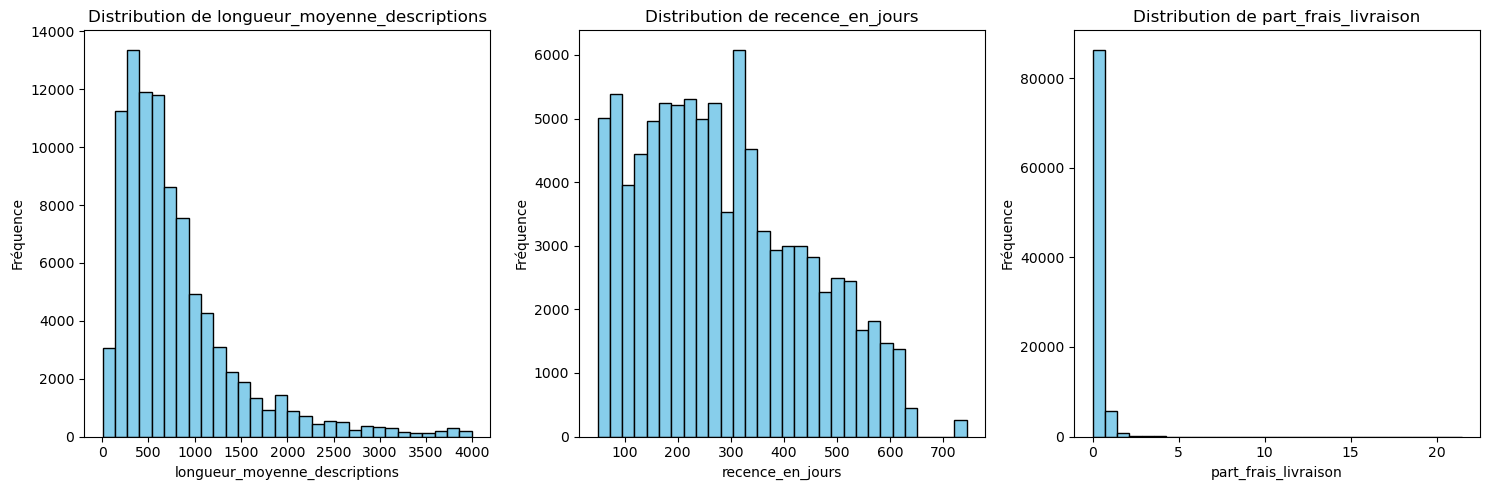

In [115]:
# Créer des histogrammes
plt.figure(figsize=(15, 5))
for i, variable in enumerate(variables):
    plt.subplot(1, 3, i+1)
    plt.hist(df[variable], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution de {variable}")
    plt.xlabel(variable)
    plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

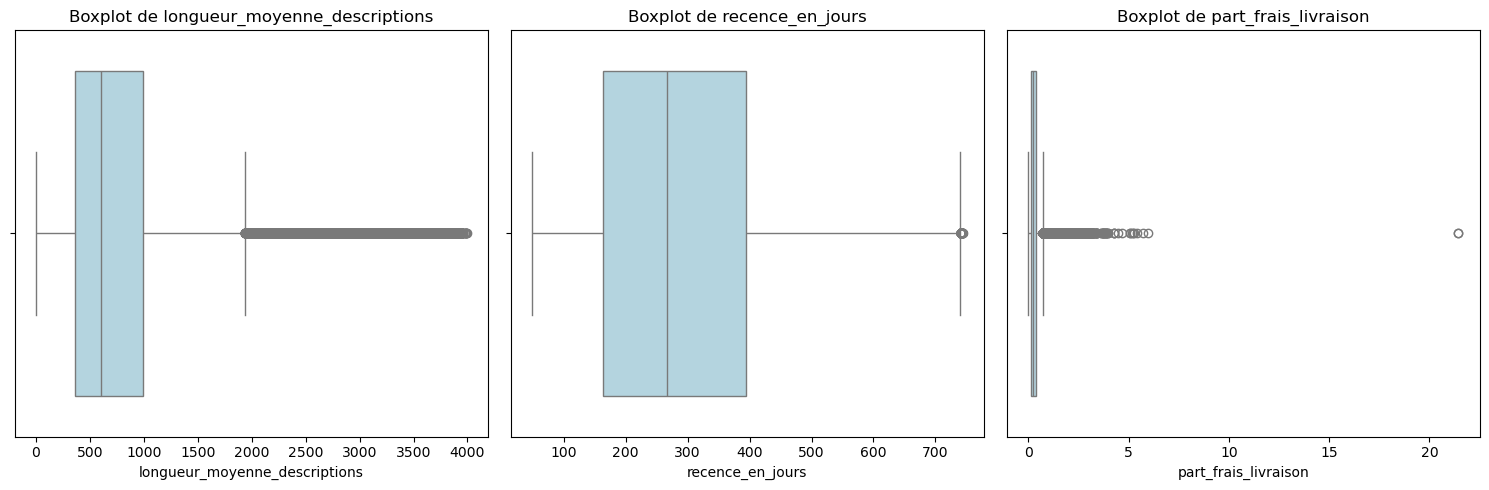

In [116]:
# Créer des boxplots
plt.figure(figsize=(15, 5))
for i, variable in enumerate(variables):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[variable], color='lightblue')
    plt.title(f"Boxplot de {variable}")
    plt.xlabel(variable)
plt.tight_layout()
plt.show()

**longueur_moyenne_descriptions**
- Moyenne : 792 caractères.
- Écart-type : 645 caractères, ce qui montre une grande dispersion.
- Min/Max : La longueur varie de 4 à 3992 caractères.
- Quartiles :
- - 25% des valeurs sont inférieures à 360 caractères (courtes descriptions).
- - La médiane est de 603 caractères (descriptions moyennes).
- - 75% des valeurs sont inférieures à 991 caractères (longues descriptions).

Proposition de découpage :
Regrouper cette variable en trois catégories basées sur les quartiles :
- Courte : <360 caractères (25e percentile).
- Moyenne : Entre 360 et 991 caractères (25e–75e percentiles).
- Longue : >991 caractères (75e percentile).

**recence_en_jours**
- Moyenne : Les clients ont en moyenne effectué leur dernier achat il y a 286 jours.
- Écart-type : 152 jours, ce qui montre une dispersion modérée.
- Min/Max : Les récences varient de 49 jours à 744 jours.
- Quartiles :
- - 25% des clients ont une récence inférieure à 163 jours (très récents).
- - La médiane est de 267 jours (modérément récents).
- - 75% des clients ont une récence inférieure à 394 jours (anciens).

Proposition de découpage :
Regrouper cette variable en trois catégories basées sur les quartiles :
- Très récent : <163 jours (25e percentile).
- Modéré : Entre 163 et 394 jours (25e–75e percentiles).
- Ancien : >394 jours (75e percentile).

**part_frais_livraison**
- Moyenne : Les frais de livraison représentent en moyenne 30% du total dépensé.
- Écart-type : Élevé, avec une valeur de 0.31, ce qui montre une forte dispersion.
- Min/Max : Les frais varient de 0% à un maximum exceptionnel de ~21%.
- Quartiles :
- - 25% des clients ont une part de frais inférieure à ~13%.
- - La médiane est ~22%.
- - 75% des clients ont une part inférieure à ~38%.

Proposition de découpage :
Regrouper cette variable en trois catégories basées sur les quartiles :
- Faible part : <13% (25e percentile).
- Modérée : Entre ~13% et ~38% (25e–75e percentiles).
- Élevée : >38% (75e percentile).

#### Découpage en classes et analyses descriptives

In [10]:
# Découpage de longueur_moyenne_descriptions
df['longueur_moyenne_descriptions_cat'] = pd.cut(df['longueur_moyenne_descriptions'], 
                                                 bins=[0, 360, 991, float('inf')], 
                                                 labels=['Courte', 'Moyenne', 'Longue'])

# Découpage de recence_en_jours
df['recence_en_jours_cat'] = pd.cut(df['recence_en_jours'], 
                                    bins=[0, 163, 394, float('inf')], 
                                    labels=['Très récent', 'Modéré', 'Ancien'])

# Découpage de part_frais_livraison
df['part_frais_livraison_cat'] = pd.cut(df['part_frais_livraison'], 
                                        bins=[0, 0.13, 0.38, float('inf')], 
                                        labels=['Faible part', 'Modérée', 'Élevée'])

In [11]:
# Variables catégorielles créées
variables_cat = ['longueur_moyenne_descriptions_cat', 'recence_en_jours_cat', 'part_frais_livraison_cat']

# Analyse descriptive des variables qualitatives
for col in variables_cat:
    print(f"Analyse de la variable '{col}':")
    print(df[col].value_counts())
    print("-" * 50)

Analyse de la variable 'longueur_moyenne_descriptions_cat':
longueur_moyenne_descriptions_cat
Moyenne    46507
Courte     23334
Longue     23262
Name: count, dtype: int64
--------------------------------------------------
Analyse de la variable 'recence_en_jours_cat':
recence_en_jours_cat
Modéré         46264
Très récent    23571
Ancien         23268
Name: count, dtype: int64
--------------------------------------------------
Analyse de la variable 'part_frais_livraison_cat':
part_frais_livraison_cat
Modérée        47356
Élevée         23052
Faible part    22366
Name: count, dtype: int64
--------------------------------------------------


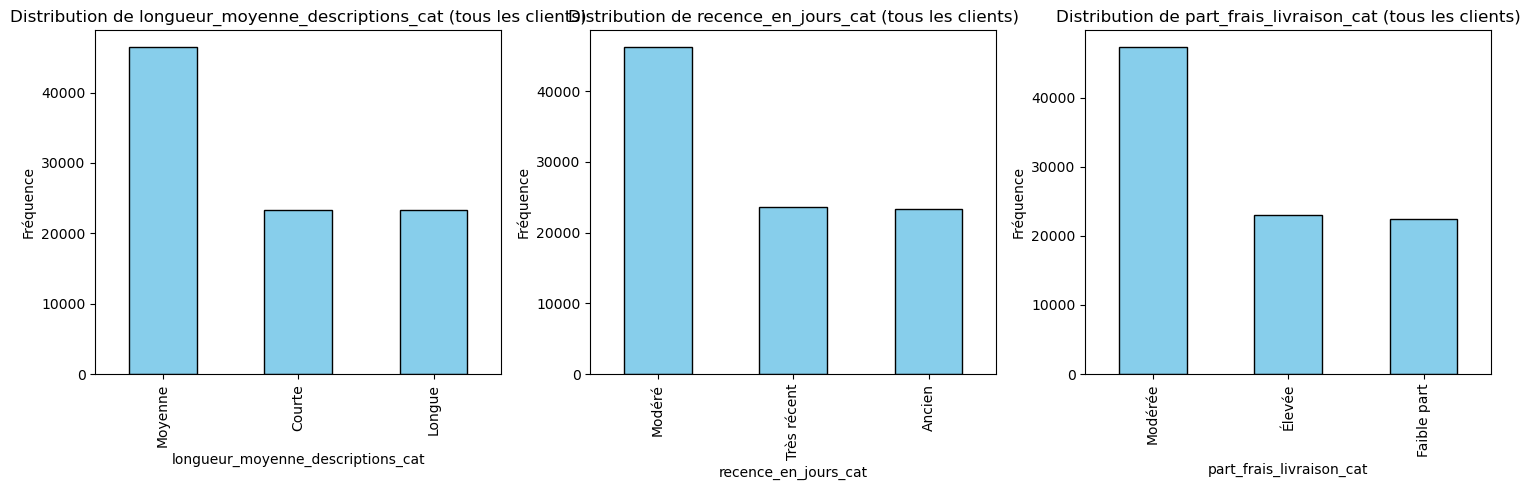

In [119]:
# Barplots pour chaque variable
plt.figure(figsize=(15, 5))
for i, variable in enumerate(variables_cat):
    plt.subplot(1, 3, i+1)
    df[variable].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution de {variable} (tous les clients)")
    plt.xlabel(variable)
    plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

Les regroupements sont équilibrés et capturent bien la diversité des comportements des clients pour ces trois dimensions.

Nous allons visualiser la répartition des nouvelles variables catégorielles (longueur_moyenne_descriptions_cat, recence_en_jours_cat, et part_frais_livraison_cat) dans chaque cluster en utilisant des barplots empilés. Ces graphiques montrent les fréquences absolues de chaque catégorie par cluster.

<Figure size 1000x600 with 0 Axes>

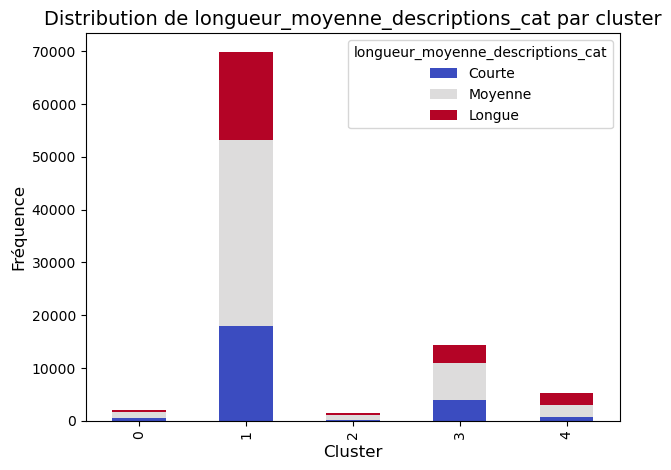

<Figure size 1000x600 with 0 Axes>

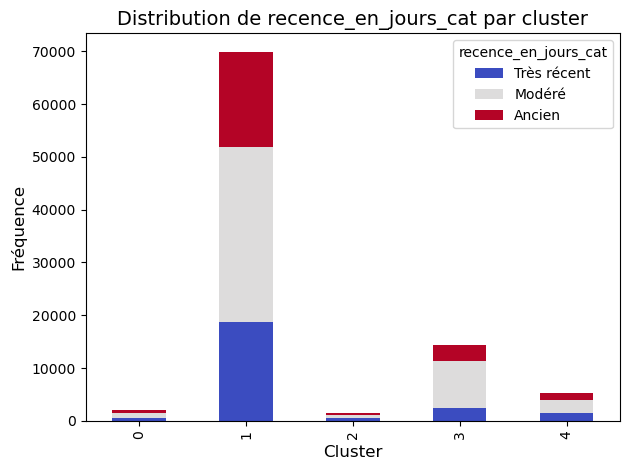

<Figure size 1000x600 with 0 Axes>

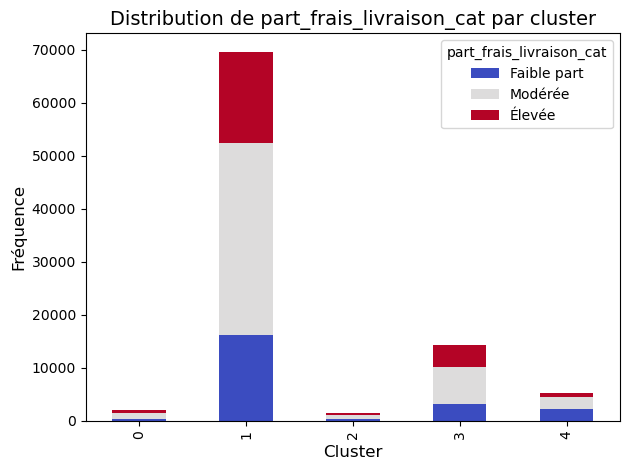

In [129]:
# Un graphique par variable catégorielle
for variable in variables_cat:
    plt.figure(figsize=(10, 6)) 
    pd.crosstab(df['cluster'], df[variable]).plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f"Distribution de {variable} par cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel("Fréquence", fontsize=12)
    plt.xticks(fontsize=10)  # Taille des ticks sur l'axe x
    plt.yticks(fontsize=10)  # Taille des ticks sur l'axe y
    plt.tight_layout()
    plt.show()

Pour aller plus loin, nous allons analyser la répartition des nouvelles variables catégorielles (longueur_moyenne_descriptions_cat, recence_en_jours_cat, et part_frais_livraison_cat) dans chaque cluster en termes de proportions. Cela permet de comparer les clusters de manière relative, indépendamment de leur taille.

longueur_moyenne_descriptions_cat    Courte   Moyenne    Longue
cluster                                                        
0                                  0.282292  0.481916  0.235791
1                                  0.256517  0.503233  0.240250
2                                  0.152966  0.646891  0.200143
3                                  0.269879  0.497633  0.232489
4                                  0.134149  0.424083  0.441769


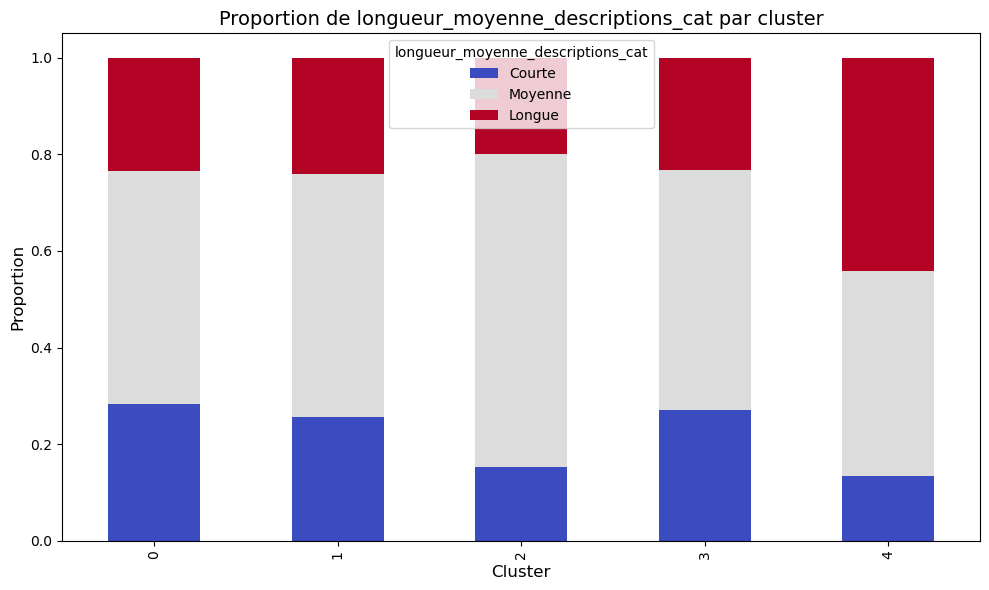

recence_en_jours_cat  Très récent    Modéré    Ancien
cluster                                              
0                        0.213715  0.480977  0.305308
1                        0.268835  0.473590  0.257575
2                        0.345247  0.501072  0.153681
3                        0.170589  0.624008  0.205403
4                        0.261900  0.465475  0.272625


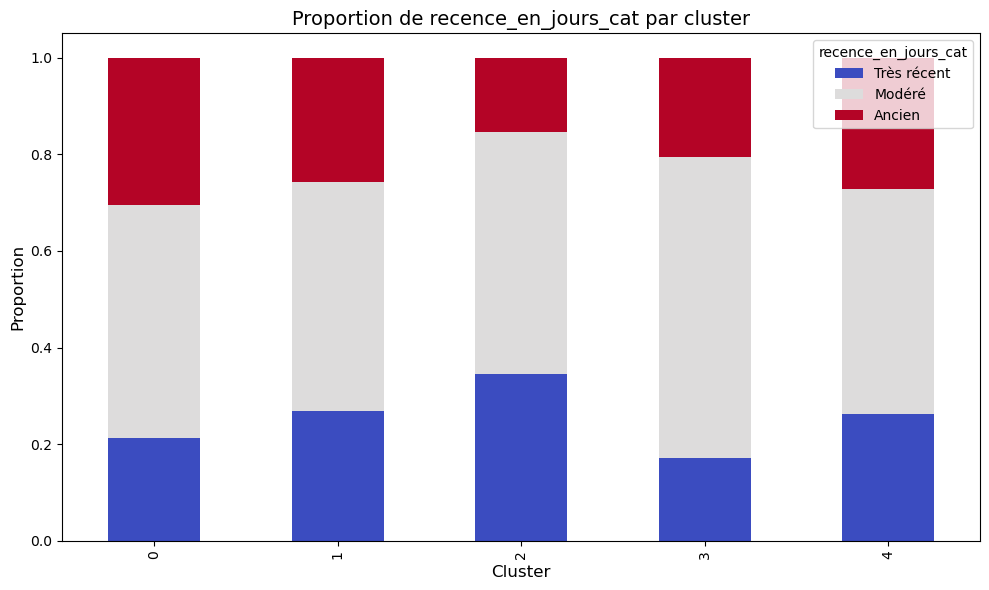

part_frais_livraison_cat  Faible part   Modérée    Élevée
cluster                                                  
0                            0.204610  0.523518  0.271872
1                            0.233526  0.518611  0.247863
2                            0.210865  0.608292  0.180843
3                            0.216839  0.498464  0.284697
4                            0.427926  0.404780  0.167294


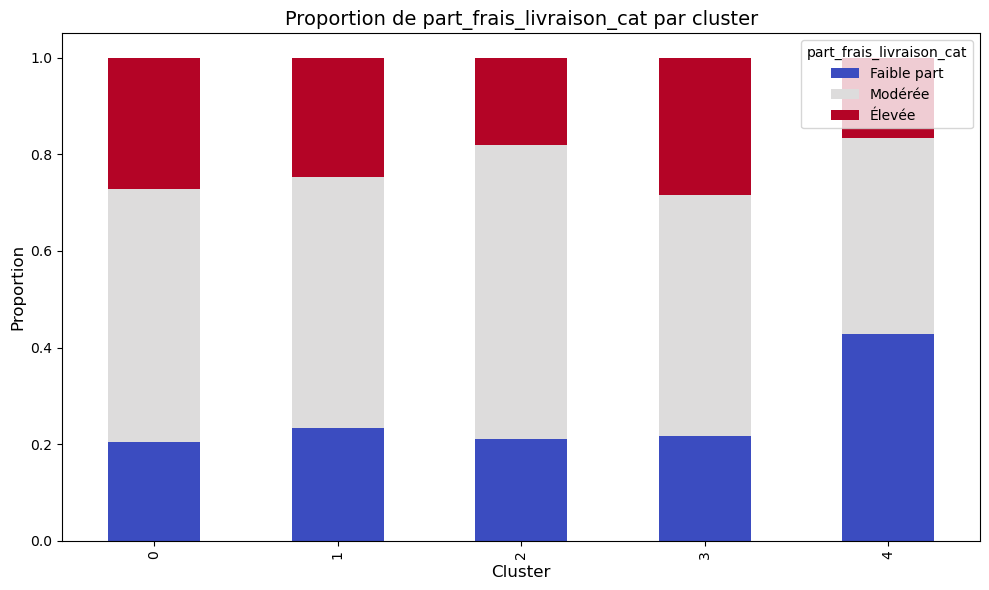

In [132]:
# Stacked barplot avec proportions (normalisation)
for variable in variables_cat:
    cluster_distribution = pd.crosstab(df['cluster'], df[variable], normalize='index')  # Normaliser par cluster
    print( cluster_distribution)
    cluster_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
    plt.title(f"Proportion de {variable} par cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

Nous avons analysé la répartition en proportions des nouvelles variables regroupées (longueur_moyenne_descriptions_cat, recence_en_jours_cat, part_frais_livraison_cat) dans chaque cluster.

**longueur_moyenne_descriptions_cat :**
- Le cluster 4 se distingue avec une forte proportion de descriptions "Longue".
- Le cluster 2 montre une forte dominance des descriptions "Moyenne".

**recence_en_jours_cat :**
- Le cluster 2 est marqué par une forte proportion de clients "Très récent".
- Le cluster 3 est dominé par des clients "Modéré".

**part_frais_livraison_cat :**
- Le cluster 4 se distingue par une forte proportion de clients ayant une part "Faible part".
- Le cluster 2 montre une dominance marquée pour la catégorie "Modérée".

Après avoir analysé la contribution des variables regroupées, nous avons décidé de :
- Supprimer les variables quantitatives associées
- Conserver uniquement les variables catégorielles créées

Nous allons relancer l'algorithme K-Means sur ce nouvel ensemble de données simplifié pour évaluer l'impact des transformations et la qualité des clusters obtenus.

# Préparation des données pour le 2ème essai de K-Means

Objectif :
Après avoir analysé les résultats du premier clustering, nous avons décidé de relancer K-Means avec un nouvel ensemble de données simplifié. Les variables quantitatives ont été remplacées par leurs versions catégorielles regroupées, qui capturent l'essentiel de l'information tout en simplifiant le modèle.

Étapes réalisées :
1. Suppression des variables quantitatives suivantes :
   - `longueur_moyenne_descriptions`
   - `recence_en_jours`
   - `part_frais_livraison`
2. Suppression de la colonne `cluster` (résultats du premier clustering).
3. Conservation des variables catégorielles regroupées :
   - `longueur_moyenne_descriptions_cat`
   - `recence_en_jours_cat`
   - `part_frais_livraison_cat`

In [12]:
# Liste des variables quantitatives à supprimer
variables_to_drop = ['longueur_moyenne_descriptions', 'recence_en_jours', 'part_frais_livraison', 'cluster']

# Suppression des variables du DataFrame
df = df.drop(variables_to_drop, axis=1)

# Vérification
print("Variables restantes dans le DataFrame :")
df.columns

Variables restantes dans le DataFrame :


Index(['nb_commandes', 'total_depense', 'frais_livraison_moyens',
       'poids_moyen_commandes', 'diversite_categories',
       'delai_livraison_moyen', 'total_retards_livraison',
       'nb_paiements_total', 'moyenne_echeances_paiement',
       'diversite_max_paiements', 'note_moyenne_client', 'a_donne_une_note',
       'longueur_moyenne_descriptions_cat', 'recence_en_jours_cat',
       'part_frais_livraison_cat'],
      dtype='object')

Nous allons maintenant préparer les données pour K-Means en appliquant deux transformations essentielles :
- One-hot encoding des variables catégorielles regroupées (longueur_moyenne_descriptions_cat, recence_en_jours_cat, part_frais_livraison_cat) afin de les convertir en format numérique.
- Standardisation des données pour les centrer et réduire, garantissant une échelle uniforme pour toutes les variables.

In [141]:
# One-hot encoding des variables catégorielles regroupées
df_encoded = pd.get_dummies(df, columns=['longueur_moyenne_descriptions_cat', 
                                         'recence_en_jours_cat', 
                                         'part_frais_livraison_cat'], drop_first=True)

# Standardisation des données
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_encoded)


# Recréer un DataFrame après la standardisation
df_standardized = pd.DataFrame(df_standardized, columns=df_encoded.columns)

# Vérification
df_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   diversite_categories  delai_livraison_moyen  total_retards_livraison  \
0             -0.116637              -0.638318                 0.673333   
1             -0.116637              -0.952572                 0.673333   
2             -0.116637               1.351951                 0.950876   
3             -0.116637               0.828196                 0.025731   
4             -0.116637               0.094939                 0.395789   

   nb_paiements_total  moyenne_echeances_paiement  diversite_max_paiements  \
0           -0.177874                    1.905839                -0.153492   
1           -0.177874                   -0.709867                -0.153492   
2           -0.177874                    1.905839                -0.153492   
3           -0.177874                    0.411150                -0.153492   
4           -0.177874                    1.158494                -0.153492   

   note_moyenne_client  a_donne_une_note  \
0             0.664132          0.080672   
1            -0.119479          0.080672   
2            -0.903090          0.080672   
3            -0.119479          0.080672   
4             0.664132          0.080672   

   longueur_moyenne_descriptions_cat_Moyenne  \
0                                  -0.999045   
1                                   1.000956   
2                                  -0.999045   
3                                  -0.999045   
4                                   1.000956   

   longueur_moyenne_descriptions_cat_Longue  recence_en_jours_cat_Modéré  \
0                                 -0.577123                    -0.993843   
1                                 -0.577123                    -0.993843   
2                                 -0.577123                    -0.993843   
3                                  1.732733                     1.006195   
4                                 -0.577123                     1.006195   

   recence_en_jours_cat_Ancien  part_frais_livraison_cat_Modérée  \
0                    -0.577222                         -1.017434   
1                    -0.577222                         -1.017434   
2                     1.732435                          0.982865   
3                    -0.577222                         -1.017434   
4                    -0.577222                         -1.017434   

   part_frais_livraison_cat_Élevée  
0                        -0.573650  
1                         1.743223  
2                        -0.573650  
3                         1.743223  
4                        -0.573650

In [142]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 18 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   nb_commandes                               93103 non-null  float64
 1   total_depense                              93103 non-null  float64
 2   frais_livraison_moyens                     93103 non-null  float64
 3   poids_moyen_commandes                      93103 non-null  float64
 4   diversite_categories                       93103 non-null  float64
 5   delai_livraison_moyen                      93103 non-null  float64
 6   total_retards_livraison                    93103 non-null  float64
 7   nb_paiements_total                         93103 non-null  float64
 8   moyenne_echeances_paiement                 93103 non-null  float64
 9   diversite_max_paiements                    93103 non-null  float64
 10  note_moyenne_client   

# Application de K-Means pour le Clustering (Essai 2)

## Détermination de nombre de clusters optimal

### Méthode du coude

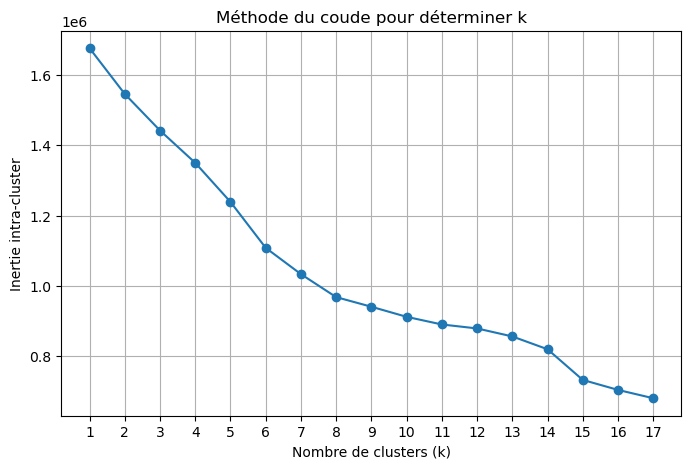

In [143]:
# Liste pour stocker les inerties (somme des distances intra-cluster)
inertias = []

# Tester différents nombres de clusters (k)
K = range(1, 18)  # De 1 à 18 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)  # Appliquer K-Means sur les données standardisées
    inertias.append(kmeans.inertia_)  # Stocker l'inertie (critère de qualité)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie intra-cluster')
plt.title('Méthode du coude pour déterminer k')
plt.xticks(K)
plt.grid()
plt.show()

### Coefficient de silhouette

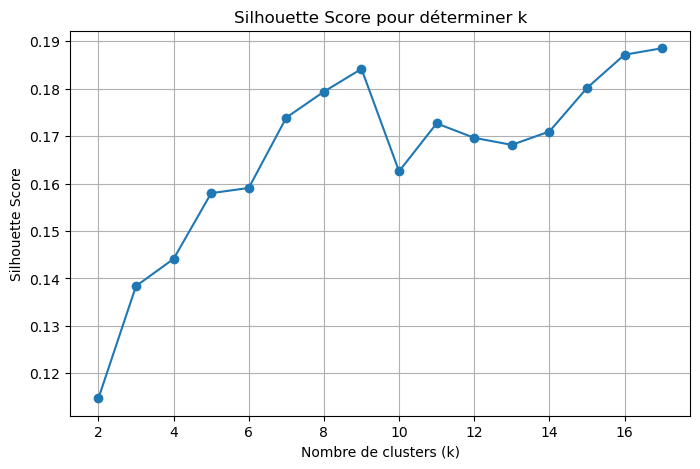

In [145]:
# Calcul du silhouette score pour chaque k
silhouette_scores = []
for k in range(2, 18):  # Le silhouette score nécessite au moins 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_standardized)
    score = silhouette_score(df_standardized, labels)
    silhouette_scores.append(score)

# Visualisation du silhouette score
plt.figure(figsize=(8, 5))
plt.plot(range(2, 18), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score pour déterminer k')
plt.grid()
plt.show()

Le Silhouette Score augmente globalement avec le nombre de clusters.
- Le meilleur score est obtenu pour k=16 (0.1885), mais cela pourrait compliquer l'interprétation métier.
- Un point d'inflexion est visible autour de k=8, où le score atteint 0.184, proche du maximum tout en gardant un nombre raisonnable de clusters.

Nous recommandons d'utiliser k=8 comme compromis entre qualité des clusters et interprétation métier.

### Conclusion 

Nous avons analysé deux métriques clés pour déterminer le nombre optimal de clusters :
- Inertie intra-cluster : Suggère un point d'inflexion autour de k=5, ce qui maximise l'interprétabilité tout en obtenant une segmentation efficace.
- Silhouette Score : Suggère un point d'inflexion autour de k=8, avec un score proche du maximum tout en gardant un nombre raisonnable de clusters.

Décision :
Nous avons décidé de tester les deux configurations (k=5 et k=8) afin de comparer leur pertinence métier et leur qualité globale.

## Application de K-Means avec k=5 pour la Segmentation Client

In [147]:
# Appliquer l'algorithme K-Means avec k=5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized)

# Ajouter les labels des clusters au DataFrame original
df['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(5)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0    20654
1    47722
2    21906
3      602
4     2219
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  \
nb_commandes                                    1.10       1.01       1.02   
total_depense                                 242.93     142.66      43.43   
frais_livraison_moyens                         27.65      19.68      24.87   
poids_moyen_commandes                        4101.89    2095.65    1407.96   
diversite_categories                            1.06       1.00       1.00   
delai_livraison_moyen                          11.11      11.94      13.16   
total_retards_livraison                       -15.42     -10.82     -12.51   
nb_paiements_total                              1.11       1.02       1.03   
moyenne_echeances_paiement                      3.89       2.92       2.04   
diversite_max_paiements                         1.00       1.00       1.00   
note_moyenne_client                             4.23       4.14       4.11   
a_donne_une_note                                1.00       1.00       1.00   
longueur_moyenne_descriptions_cat_Moyenne       0.48       0.50       0.52   
longueur_moyenne_descriptions_cat_Longue        0.29       0.27       0.17   
recence_en_jours_cat_Modéré                     0.06       0.69       0.48   
recence_en_jours_cat_Ancien                     0.83       0.00       0.24   
part_frais_livraison_cat_Modérée                0.65       0.68      -0.00   
part_frais_livraison_cat_Élevée                 0.02       0.00       1.00   

                                           Cluster 3  Cluster 4  
nb_commandes                                    1.01       1.12  
total_depense                                 176.14     138.78  
frais_livraison_moyens                         26.27      22.52  
poids_moyen_commandes                        3020.51    2334.48  
diversite_categories                            1.00       1.05  
delai_livraison_moyen                          18.22      12.26  
total_retards_livraison                        -6.40     -13.88  
nb_paiements_total                              1.06       2.69  
moyenne_echeances_paiement                      3.18       1.61  
diversite_max_paiements                         1.02       1.96  
note_moyenne_client                             4.00       4.14  
a_donne_une_note                               -0.00       1.00  
longueur_moyenne_descriptions_cat_Moyenne       0.47       0.49  
longueur_moyenne_descriptions_cat_Longue        0.24       0.23  
recence_en_jours_cat_Modéré                     0.54       0.48  
recence_en_jours_cat_Ancien                     0.29       0.30  
part_frais_livraison_cat_Modérée                0.48       0.53  
part_frais_livraison_cat_Élevée                 0.25       0.26

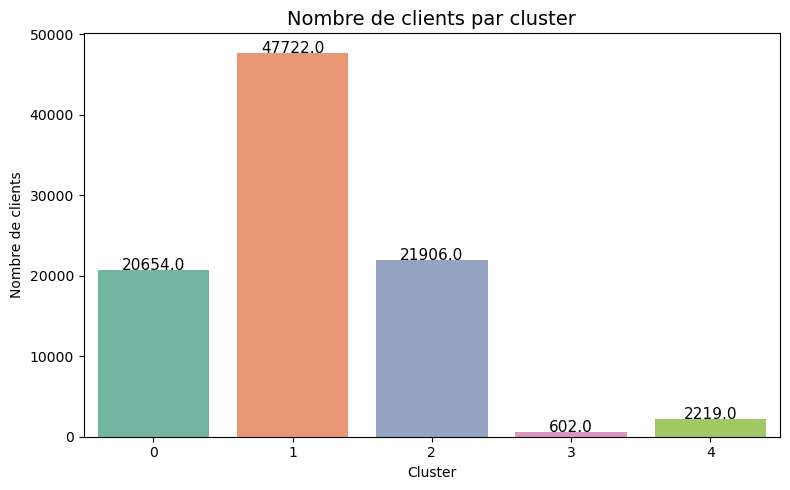

In [148]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

In [149]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 1238675.6306183282
Silhouette Score: 0.15797939289741056
Davies-Bouldin Index: 1.8091068347660635
Calinski-Harabasz Index: 8214.54168280608


| Métrique               | Modèle initial  | Modèle modifié avec k=5 |
|:-----------------------|:----------------|:------------------------|
| Inertie intra-cluster  | 945987.23       | 1238675.63              |
| Silhouette Score       | 0.2856          | 0.1579                  |
| Davies-Bouldin Index   | 1.5009          | 1.8091                  |
| Calinski-Harabasz Index| 11085.26        | 8214.54                 |

Le modèle modifié avec k=5 semble avoir des performances inférieures au modèle initial :
- La compacité des clusters s'est dégradée (augmentation de l'inertie intra-cluster).
- La séparation et cohésion des clusters sont moins bonnes (Silhouette Score plus faible).
- La qualité globale des clusters est également moindre (Davies-Bouldin Index plus élevé et Calinski-Harabasz Index plus faible).

**Conclusion:**<br>
- Le modèle initial offre une meilleure compacité, cohésion et séparation des clusters.
- Les modifications apportées semblent avoir dégradé la qualité globale du clustering.

## Application de K-Means avec k=7 pour la Segmentation Client

In [152]:
# Appliquer l'algorithme K-Means avec k=5 clusters
kmeans = KMeans(n_clusters=7, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized)

# Ajouter les labels des clusters au DataFrame original
df['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(7)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0     2672
1    34625
2    21215
3      602
4     2118
5    15756
6    16115
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  \
nb_commandes                                    2.12       1.00       1.00   
total_depense                                 258.75     131.65      40.64   
frais_livraison_moyens                         22.47      19.04      23.83   
poids_moyen_commandes                        2283.39    1933.42    1288.15   
diversite_categories                            1.51       1.00       1.00   
delai_livraison_moyen                          11.42      11.63      13.03   
total_retards_livraison                       -27.66     -11.01     -12.38   
nb_paiements_total                              2.19       1.01       1.01   
moyenne_echeances_paiement                      3.29       2.95       2.00   
diversite_max_paiements                         1.03       1.00       1.00   
note_moyenne_client                             4.25       4.15       4.12   
a_donne_une_note                                1.00       1.00       1.00   
longueur_moyenne_descriptions_cat_Moyenne       0.60       0.69       0.53   
longueur_moyenne_descriptions_cat_Longue        0.20       0.00       0.15   
recence_en_jours_cat_Modéré                     0.50       0.68       0.47   
recence_en_jours_cat_Ancien                     0.21       0.00       0.26   
part_frais_livraison_cat_Modérée                0.60       0.70      -0.00   
part_frais_livraison_cat_Élevée                 0.20       0.00       1.00   

                                           Cluster 3  Cluster 4  Cluster 5  \
nb_commandes                                    1.01       1.03       1.00   
total_depense                                 176.14     129.59     144.73   
frais_livraison_moyens                         26.27      22.55      19.74   
poids_moyen_commandes                        3020.51    2346.93    2510.15   
diversite_categories                            1.00       1.00       1.00   
delai_livraison_moyen                          18.22      12.28      11.00   
total_retards_livraison                        -6.40     -12.76     -13.73   
nb_paiements_total                              1.06       2.60       1.01   
moyenne_echeances_paiement                      3.18       1.56       3.40   
diversite_max_paiements                         1.02       1.97       1.00   
note_moyenne_client                             4.00       4.12       4.26   
a_donne_une_note                               -0.00       1.00       1.00   
longueur_moyenne_descriptions_cat_Moyenne       0.47       0.48       0.50   
longueur_moyenne_descriptions_cat_Longue        0.24       0.24       0.24   
recence_en_jours_cat_Modéré                     0.54       0.48      -0.00   
recence_en_jours_cat_Ancien                     0.29       0.30       1.00   
part_frais_livraison_cat_Modérée                0.48       0.52       0.69   
part_frais_livraison_cat_Élevée                 0.25       0.27       0.00   

                                           Cluster 6  
nb_commandes                                    1.00  
total_depense                                 273.98  
frais_livraison_moyens                         32.34  
poids_moyen_commandes                        4703.36  
diversite_categories                            1.00  
delai_livraison_moyen                          12.78  
total_retards_livraison                       -11.06  
nb_paiements_total                              1.01  
moyenne_echeances_paiement                      3.59  
diversite_max_paiements                         1.00  
note_moyenne_client                             4.09  
a_donne_une_note                                1.00  
longueur_moyenne_descriptions_cat_Moyenne       0.03  
longueur_moyenne_descriptions_cat_Longue        0.93  
recence_en_jours_cat_Modéré                     0.62  
recence_en_jours_cat_Ancien                     0.04  
part_frais_livraison_cat_Modérée                0.57  
part_frais_livraison_cat_Élevée                 0.03

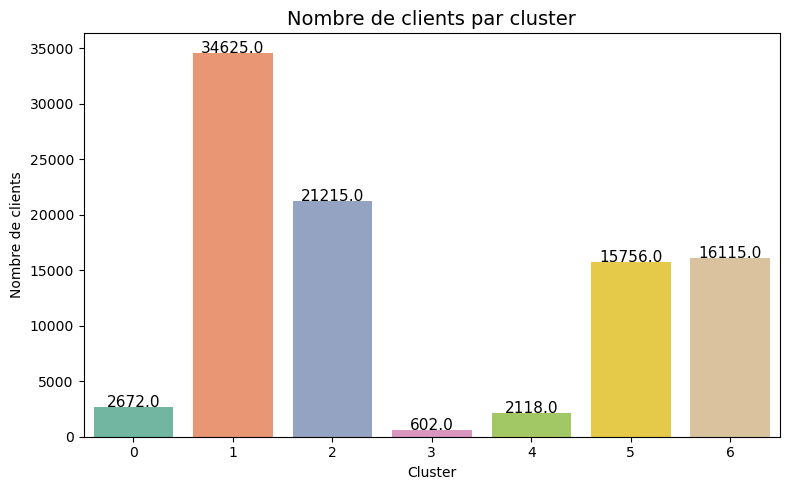

In [153]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

In [154]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 1033378.7554863016
Silhouette Score: 0.17391786593175712
Davies-Bouldin Index: 1.5589140375767043
Calinski-Harabasz Index: 9646.65740259208


| Métrique               | Modèle initial  | Modèle modifié (k=5) | Modèle modifié (k=7) |
|------------------------|-----------------|----------------------|----------------------|
| Inertie intra-cluster  | 945987.23       | 1238675.63           | 1033378.76           |
| Silhouette Score       | 0.2856          | 0.1579               | 0.1739               |
| Davies-Bouldin Index   | 1.5009          | 1.8091               | 1.5589               |
| Calinski-Harabasz Index| 11085.26        | 8214.54              | 9646.66              |

Le modèle modifié avec k=7 est légèrement meilleur que celui avec k=5, mais reste inférieur au modèle initial sur tous les critères clés :
- Inertie intra-cluster : Augmente par rapport au modèle initial (945987.23 → 1033378.76), indiquant des clusters moins compacts.
- Silhouette Score : Diminue fortement par rapport au modèle initial (0.2856 → 0.1739), montrant une moins bonne séparation et cohésion des clusters.
- Davies-Bouldin Index : Augmente par rapport au modèle initial (1.5009 → 1.5589), ce qui indique une qualité globale réduite des clusters.
- Calinski-Harabasz Index : Diminue par rapport au modèle initial (11085.26 → 9646.66), suggérant une moins bonne séparation inter-cluster.

Les modifications apportées (remplacement des variables quantitatives par leurs versions catégorielles regroupées) semblent avoir introduit du bruit ou réduit la capacité à discriminer efficacement les clusters.

Afin d'améliorer le modèle modifié, nous allons tester la suppression de l'une des variables créées précédemment : longueur_moyenne_descriptions_cat. Cela nous permettra d'évaluer si cette variable introduit du bruit ou n'apporte pas suffisamment d'information discriminante au clustering

# Préparation des données pour le 3ème essai de K-Means

In [13]:
# Liste des variables quantitatives à supprimer
variables_to_drop = ['longueur_moyenne_descriptions_cat', 'cluster']

# Suppression des variables du DataFrame
df = df.drop(variables_to_drop, axis=1)

# Vérification
print("Variables restantes dans le DataFrame :")
df.columns

Variables restantes dans le DataFrame :


Index(['nb_commandes', 'total_depense', 'frais_livraison_moyens',
       'poids_moyen_commandes', 'diversite_categories',
       'delai_livraison_moyen', 'total_retards_livraison',
       'nb_paiements_total', 'moyenne_echeances_paiement',
       'diversite_max_paiements', 'note_moyenne_client', 'a_donne_une_note',
       'recence_en_jours_cat', 'part_frais_livraison_cat'],
      dtype='object')

In [156]:
# One-hot encoding des variables catégorielles regroupées
df_encoded = pd.get_dummies(df, columns=['recence_en_jours_cat', 
                                         'part_frais_livraison_cat'], drop_first=True)

# Standardisation des données
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_encoded)


# Recréer un DataFrame après la standardisation
df_standardized = pd.DataFrame(df_standardized, columns=df_encoded.columns)

# Vérification
df_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   diversite_categories  delai_livraison_moyen  total_retards_livraison  \
0             -0.116637              -0.638318                 0.673333   
1             -0.116637              -0.952572                 0.673333   
2             -0.116637               1.351951                 0.950876   
3             -0.116637               0.828196                 0.025731   
4             -0.116637               0.094939                 0.395789   

   nb_paiements_total  moyenne_echeances_paiement  diversite_max_paiements  \
0           -0.177874                    1.905839                -0.153492   
1           -0.177874                   -0.709867                -0.153492   
2           -0.177874                    1.905839                -0.153492   
3           -0.177874                    0.411150                -0.153492   
4           -0.177874                    1.158494                -0.153492   

   note_moyenne_client  a_donne_une_note  recence_en_jours_cat_Modéré  \
0             0.664132          0.080672                    -0.993843   
1            -0.119479          0.080672                    -0.993843   
2            -0.903090          0.080672                    -0.993843   
3            -0.119479          0.080672                     1.006195   
4             0.664132          0.080672                     1.006195   

   recence_en_jours_cat_Ancien  part_frais_livraison_cat_Modérée  \
0                    -0.577222                         -1.017434   
1                    -0.577222                         -1.017434   
2                     1.732435                          0.982865   
3                    -0.577222                         -1.017434   
4                    -0.577222                         -1.017434   

   part_frais_livraison_cat_Élevée  
0                        -0.573650  
1                         1.743223  
2                        -0.573650  
3                         1.743223  
4                        -0.573650

In [157]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_commandes                      93103 non-null  float64
 1   total_depense                     93103 non-null  float64
 2   frais_livraison_moyens            93103 non-null  float64
 3   poids_moyen_commandes             93103 non-null  float64
 4   diversite_categories              93103 non-null  float64
 5   delai_livraison_moyen             93103 non-null  float64
 6   total_retards_livraison           93103 non-null  float64
 7   nb_paiements_total                93103 non-null  float64
 8   moyenne_echeances_paiement        93103 non-null  float64
 9   diversite_max_paiements           93103 non-null  float64
 10  note_moyenne_client               93103 non-null  float64
 11  a_donne_une_note                  93103 non-null  float64
 12  rece

# Application de K-Means pour le Clustering (Essai 3)

## Détermination de nombre de clusters optimal

### Méthode du coude

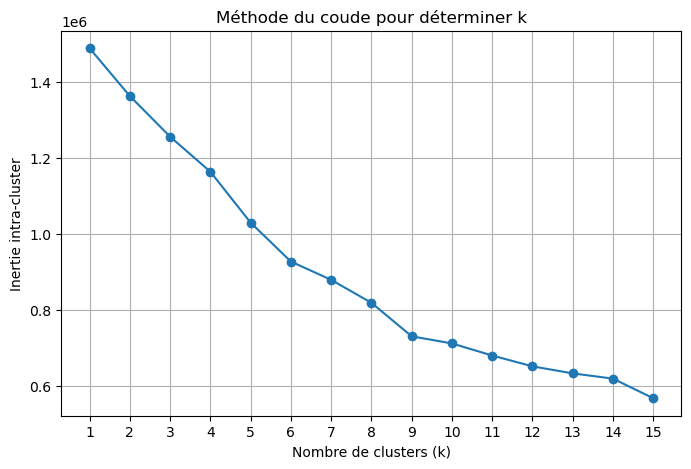

In [158]:
# Liste pour stocker les inerties (somme des distances intra-cluster)
inertias = []

# Tester différents nombres de clusters (k)
K = range(1, 16)  # De 1 à 16 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)  # Appliquer K-Means sur les données standardisées
    inertias.append(kmeans.inertia_)  # Stocker l'inertie (critère de qualité)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie intra-cluster')
plt.title('Méthode du coude pour déterminer k')
plt.xticks(K)
plt.grid()
plt.show()

- L'amélioration entre k=4 et k=5 est significative.
- Les gains au-delà de k=5 deviennent moins marqués, ce qui suggère une stabilisation.

Nous recommandons d'utiliser k=5 comme compromis entre qualité des clusters et interprétation métier.

### Coefficient de silhouette

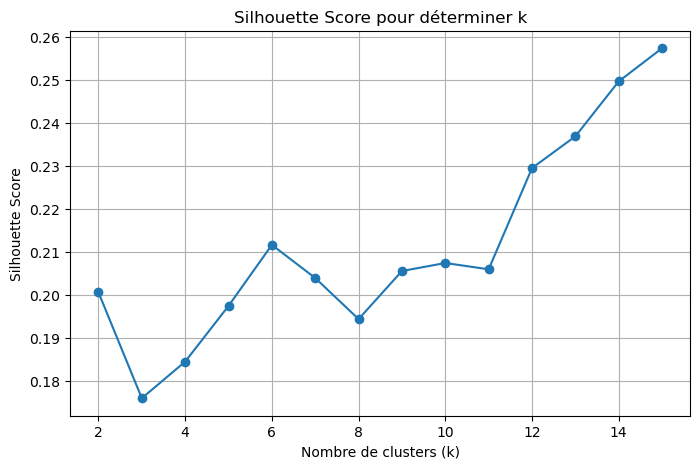

In [160]:
# Calcul du silhouette score pour chaque k
silhouette_scores = []
for k in range(2, 16):  # Le silhouette score nécessite au moins 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_standardized)
    score = silhouette_score(df_standardized, labels)
    silhouette_scores.append(score)

# Visualisation du silhouette score
plt.figure(figsize=(8, 5))
plt.plot(range(2, 16), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score pour déterminer k')
plt.grid()
plt.show()

- Le score atteint un maximum à k=6 avant de fluctuer, ce qui suggère un bon compromis entre cohésion et séparation des clusters.
- Les scores augmentent fortement à partir de k=12, mais un nombre élevé de clusters peut compliquer l'interprétation métier.

Nous recommandons d'utiliser k=6 pour un équilibre entre qualité des clusters et interprétabilité.

### Conclusion 

Nous avons analysé deux métriques clés pour déterminer le nombre optimal de clusters :
- Inertie intra-cluster : Suggère un point d'inflexion autour de k=5, ce qui maximise l'interprétabilité tout en obtenant une segmentation efficace.
- Silhouette Score : Suggère un point d'inflexion autour de k=6, avec un score proche du maximum tout en gardant un nombre raisonnable de clusters.

Décision :
Nous avons décidé de tester les deux configurations (k=5 et k=6) afin de comparer leur pertinence métier et leur qualité globale.

## Application de K-Means avec k=5 pour la Segmentation Client

In [162]:
# Appliquer l'algorithme K-Means avec k=5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized)

# Ajouter les labels des clusters au DataFrame original
df['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(5)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0     4826
1    47188
2    21250
3     4137
4    15702
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  Cluster 3  \
nb_commandes                           1.63       1.00       1.00       1.01   
total_depense                        190.47     136.02      39.26     678.80   
frais_livraison_moyens                21.78      19.01      22.96      80.46   
poids_moyen_commandes               2139.41    1855.86    1106.43   16023.62   
diversite_categories                   1.28       1.00       1.00       1.00   
delai_livraison_moyen                 11.95      11.67      13.08      15.89   
total_retards_livraison              -20.70     -11.02     -12.31     -11.54   
nb_paiements_total                     2.38       1.01       1.01       1.03   
moyenne_echeances_paiement             2.49       2.92       1.99       6.03   
diversite_max_paiements                1.44       1.00       1.00       1.00   
note_moyenne_client                    4.18       4.16       4.12       3.76   
a_donne_une_note                       1.00       0.99       0.99       0.99   
recence_en_jours_cat_Modéré            0.50       0.67       0.48       0.50   
recence_en_jours_cat_Ancien            0.25       0.00       0.25       0.23   
part_frais_livraison_cat_Modérée       0.56       0.68      -0.00       0.40   
part_frais_livraison_cat_Élevée        0.23       0.00       1.00       0.16   

                                  Cluster 4  
nb_commandes                           1.00  
total_depense                        140.20  
frais_livraison_moyens                18.92  
poids_moyen_commandes               2207.84  
diversite_categories                   1.00  
delai_livraison_moyen                 11.08  
total_retards_livraison              -13.62  
nb_paiements_total                     1.01  
moyenne_echeances_paiement             3.35  
diversite_max_paiements                1.00  
note_moyenne_client                    4.25  
a_donne_une_note                       0.99  
recence_en_jours_cat_Modéré           -0.00  
recence_en_jours_cat_Ancien            1.00  
part_frais_livraison_cat_Modérée       0.69  
part_frais_livraison_cat_Élevée        0.00

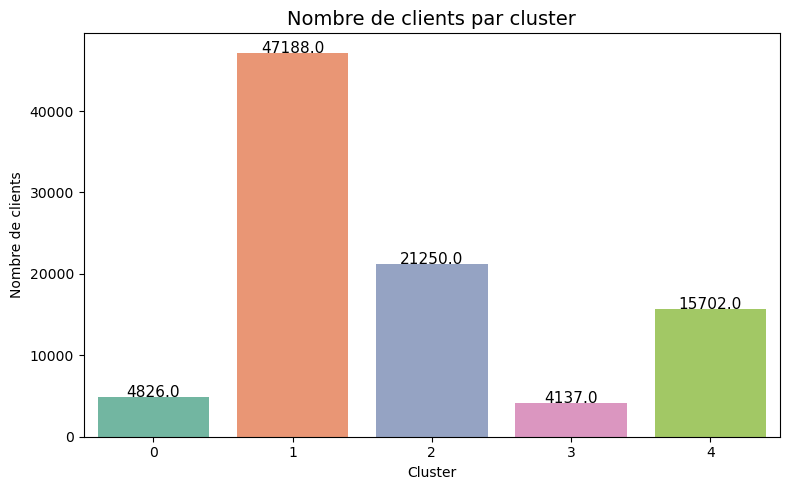

In [163]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

In [164]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 1030207.3113020502
Silhouette Score: 0.19740553810537528
Davies-Bouldin Index: 1.658611309177483
Calinski-Harabasz Index: 10379.713004928655


| Métrique               | Modèle initial  | Modèle 3 avec k=5       |
|:-----------------------|:----------------|:------------------------|
| Inertie intra-cluster  | 945987.23       |   1030207.31            |
| Silhouette Score       | 0.2856          |   0.197                 |
| Davies-Bouldin Index   | 1.5009          |   1.6586                |
| Calinski-Harabasz Index| 11085.26        |   10379.71              |

Le modèle modifié avec k=5 semble avoir des performances inférieures au modèle initial :
- La compacité des clusters s'est dégradée (augmentation de l'inertie intra-cluster).
- La séparation et cohésion des clusters sont moins bonnes (Silhouette Score plus faible).
- La qualité globale des clusters est également moindre (Davies-Bouldin Index plus élevé et Calinski-Harabasz Index plus faible).

**Conclusion:**<br>
- Le modèle initial offre une meilleure compacité, cohésion et séparation des clusters.
- Les modifications apportées semblent avoir dégradé la qualité globale du clustering.

## Application de K-Means avec k=6 pour la Segmentation Client

In [165]:
# Appliquer l'algorithme K-Means avec k=5 clusters
kmeans = KMeans(n_clusters=6, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized)

# Ajouter les labels des clusters au DataFrame original
df['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(6)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0     2131
1    47210
2    21271
3     4127
4    15710
5     2654
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  Cluster 3  \
nb_commandes                           1.03       1.00       1.00       1.01   
total_depense                        128.79     135.96      39.25     675.98   
frais_livraison_moyens                22.48      19.01      22.95      80.21   
poids_moyen_commandes               2324.42    1853.93    1105.95   16012.15   
diversite_categories                   1.00       1.00       1.00       1.00   
delai_livraison_moyen                 12.31      11.67      13.08      15.97   
total_retards_livraison              -12.76     -11.01     -12.31     -11.42   
nb_paiements_total                     2.60       1.01       1.01       1.03   
moyenne_echeances_paiement             1.56       2.92       1.99       6.04   
diversite_max_paiements                1.97       1.00       1.00       1.00   
note_moyenne_client                    4.12       4.16       4.12       3.76   
a_donne_une_note                       0.99       0.99       0.99       0.99   
recence_en_jours_cat_Modéré            0.48       0.67       0.48       0.50   
recence_en_jours_cat_Ancien            0.31       0.00       0.25       0.23   
part_frais_livraison_cat_Modérée       0.52       0.68      -0.00       0.40   
part_frais_livraison_cat_Élevée        0.27       0.00       1.00       0.16   

                                  Cluster 4  Cluster 5  
nb_commandes                           1.00       2.12  
total_depense                        140.10     249.12  
frais_livraison_moyens                18.92      21.91  
poids_moyen_commandes               2203.41    2119.66  
diversite_categories                   1.00       1.52  
delai_livraison_moyen                 11.09      11.44  
total_retards_livraison              -13.62     -27.59  
nb_paiements_total                     1.01       2.19  
moyenne_echeances_paiement             3.35       3.27  
diversite_max_paiements                1.00       1.03  
note_moyenne_client                    4.25       4.25  
a_donne_une_note                       0.99       1.00  
recence_en_jours_cat_Modéré           -0.00       0.51  
recence_en_jours_cat_Ancien            1.00       0.21  
part_frais_livraison_cat_Modérée       0.69       0.60  
part_frais_livraison_cat_Élevée        0.00       0.20

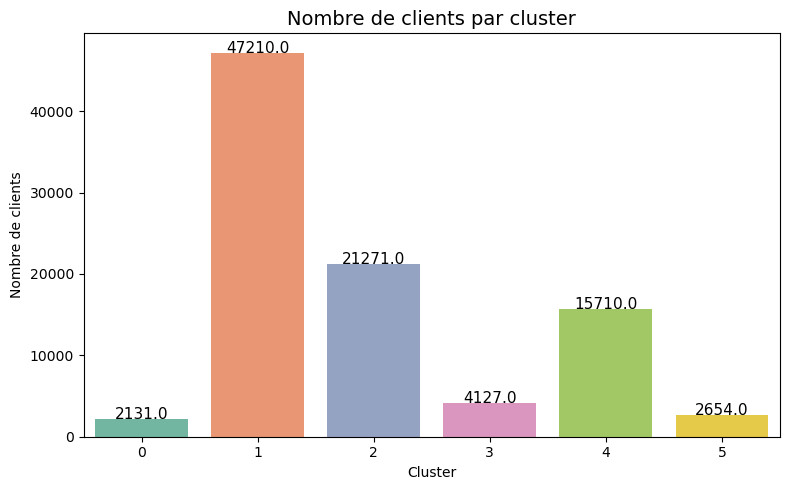

In [166]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

In [167]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 927753.4036467148
Silhouette Score: 0.21158675067147986
Davies-Bouldin Index: 1.4722007865882771
Calinski-Harabasz Index: 11276.869563571272


| Métrique               | Modèle initial  | Modèle 3 avec k=5       | Modèle 3 avec k=6       |
|:-----------------------|:----------------|:------------------------|:------------------------|
| Inertie intra-cluster  | 945987.23       |   1030207.31            |   927753.40             |
| Silhouette Score       | 0.2856          |   0.197                 |   0.2115                |
| Davies-Bouldin Index   | 1.5009          |   1.6586                |   1.4722                |
| Calinski-Harabasz Index| 11085.26        |   10379.71              |   11276.869             |

Le modèle modifié avec k=6 reste inférieur au modèle initial sur certains critères, notamment le Silhouette Score (0.2115 vs 0.2856) et l'inertie intra-cluster (927753.40 vs 945987.23).

Cependant, il dépasse le modèle initial sur le Calinski-Harabasz Index (11276.87 vs 11085.26) et le Davies-Bouldin Index (1.4722 vs 1.5009), ce qui indique une segmentation légèrement plus distincte.

Nous avons déjà testé la suppression de la variable créée longueur_moyenne_descriptions_cat, ce qui a permis d'améliorer légèrement les résultats.
Afin d'améliorer davantage le modèle modifié, nous allons maintenant tester la suppression d'une autre variable créée : part_frais_livraison_cat.

# Préparation des données pour le 4ème essai de K-Means

In [14]:
# Liste des variables quantitatives à supprimer
variables_to_drop = ['part_frais_livraison_cat', 'cluster']

# Suppression des variables du DataFrame
df = df.drop(variables_to_drop, axis=1)

# Vérification
print("Variables restantes dans le DataFrame :")
df.columns

Variables restantes dans le DataFrame :


Index(['nb_commandes', 'total_depense', 'frais_livraison_moyens',
       'poids_moyen_commandes', 'diversite_categories',
       'delai_livraison_moyen', 'total_retards_livraison',
       'nb_paiements_total', 'moyenne_echeances_paiement',
       'diversite_max_paiements', 'note_moyenne_client', 'a_donne_une_note',
       'recence_en_jours_cat'],
      dtype='object')

In [15]:
df_copie_essai4 = df.copy()

In [16]:
df = df_copie_essai4.copy()

In [591]:
# One-hot encoding des variables catégorielles regroupées
df_encoded = pd.get_dummies(df, columns=['recence_en_jours_cat'], drop_first=False)

# Standardisation des données
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_encoded)

# Recréer un DataFrame après la standardisation
df_standardized = pd.DataFrame(df_standardized, columns=df_encoded.columns)

# Vérification
df_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   diversite_categories  delai_livraison_moyen  total_retards_livraison  \
0             -0.116637              -0.638318                 0.673333   
1             -0.116637              -0.952572                 0.673333   
2             -0.116637               1.351951                 0.950876   
3             -0.116637               0.828196                 0.025731   
4             -0.116637               0.094939                 0.395789   

   nb_paiements_total  moyenne_echeances_paiement  diversite_max_paiements  \
0           -0.177874                    1.905839                -0.153492   
1           -0.177874                   -0.709867                -0.153492   
2           -0.177874                    1.905839                -0.153492   
3           -0.177874                    0.411150                -0.153492   
4           -0.177874                    1.158494                -0.153492   

   note_moyenne_client  a_donne_une_note  recence_en_jours_cat_Très récent  \
0             0.664132          0.080672                          1.717526   
1            -0.119479          0.080672                          1.717526   
2            -0.903090          0.080672                         -0.582233   
3            -0.119479          0.080672                         -0.582233   
4             0.664132          0.080672                         -0.582233   

   recence_en_jours_cat_Modéré  recence_en_jours_cat_Ancien  
0                    -0.993843                    -0.577222  
1                    -0.993843                    -0.577222  
2                    -0.993843                     1.732435  
3                     1.006195                    -0.577222  
4                     1.006195                    -0.577222

In [592]:
df_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_commandes                      93103 non-null  float64
 1   total_depense                     93103 non-null  float64
 2   frais_livraison_moyens            93103 non-null  float64
 3   poids_moyen_commandes             93103 non-null  float64
 4   diversite_categories              93103 non-null  float64
 5   delai_livraison_moyen             93103 non-null  float64
 6   total_retards_livraison           93103 non-null  float64
 7   nb_paiements_total                93103 non-null  float64
 8   moyenne_echeances_paiement        93103 non-null  float64
 9   diversite_max_paiements           93103 non-null  float64
 10  note_moyenne_client               93103 non-null  float64
 11  a_donne_une_note                  93103 non-null  float64
 12  rece

# Application de K-Means pour le Clustering (Essai 4)

## Détermination de nombre de clusters optimal

### Méthode du coude

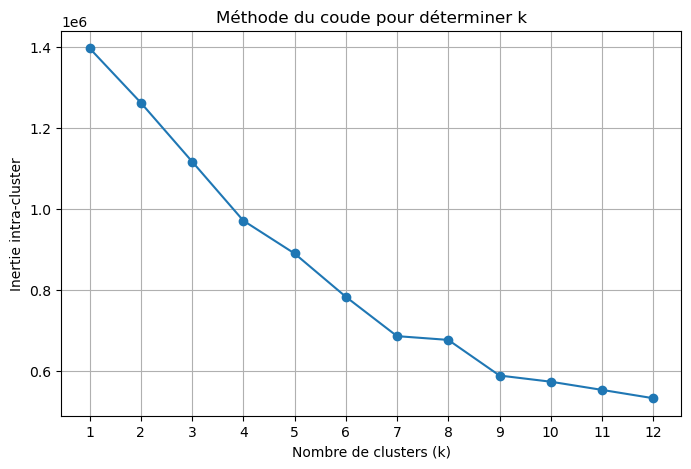

In [526]:
# Liste pour stocker les inerties (somme des distances intra-cluster)
inertias = []

# Tester différents nombres de clusters (k)
K = range(1, 13)  # De 1 à 13 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)  # Appliquer K-Means sur les données standardisées
    inertias.append(kmeans.inertia_)  # Stocker l'inertie (critère de qualité)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie intra-cluster')
plt.title('Méthode du coude pour déterminer k')
plt.xticks(K)
plt.grid()
plt.show()

Choix de k :
- Fortes baisses de l’inertie jusqu’à k=7, indiquant une structure naturelle dans les données.
- Gain marginal très faible à k=7 → point de rupture potentiel.
- Gain irrégulier après k=7, suggérant une stabilité moindre au-delà.
- k=7 = compromis intéressant entre complexité et segmentation fine.

### Coefficient de silhouette

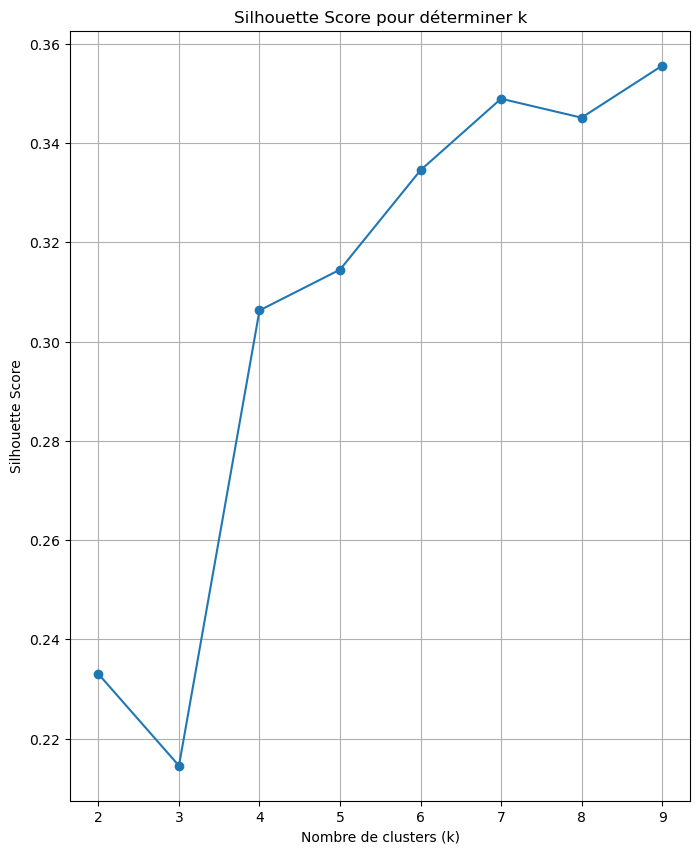

In [270]:
# Calcul du silhouette score pour chaque k
silhouette_scores = []
for k in range(2, 10):  # Le silhouette score nécessite au moins 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_standardized)
    score = silhouette_score(df_standardized, labels)
    silhouette_scores.append(score)

# Visualisation du silhouette score
plt.figure(figsize=(8, 10))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score pour déterminer k')
plt.grid()
plt.show()

Bien que le Silhouette Score soit maximal pour k=9, ce nombre élevé de clusters complexifie l’interprétation opérationnelle. Le score reste très bon pour k=6 (0.3345) et k=7 (0.3489), tout en assurant une segmentation plus simple et exploitable. Nous retenons donc k=7 comme compromis entre performance technique et lisibilité métier.

## Application de K-Means avec k=7 pour la Segmentation Client

In [593]:
# Appliquer l'algorithme K-Means avec k=7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized)

# Ajouter les labels des clusters au DataFrame original
df['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(7)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0    21270
1     3773
2     2117
3    21650
4    42296
5     1396
6      601
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  Cluster 3  \
nb_commandes                           1.02       1.02       1.03       1.01   
total_depense                        115.44     683.88     127.68     116.97   
frais_livraison_moyens                19.49      83.51      22.37      21.31   
poids_moyen_commandes               1908.77   16824.45    2317.12    1586.98   
diversite_categories                   1.00       1.00       1.00       1.00   
delai_livraison_moyen                 11.37      15.72      12.28       8.69   
total_retards_livraison              -14.18     -11.94     -12.78     -12.75   
nb_paiements_total                     1.03       1.04       2.60       1.02   
moyenne_echeances_paiement             3.03       5.95       1.56       2.70   
diversite_max_paiements                1.00       1.00       1.97       1.00   
note_moyenne_client                    4.24       3.76       4.12       4.30   
a_donne_une_note                       1.00       1.00       1.00       1.00   
recence_en_jours_cat_Très récent      -0.00       0.23       0.21       1.00   
recence_en_jours_cat_Modéré           -0.00       0.52       0.48       0.00   
recence_en_jours_cat_Ancien            1.00       0.25       0.30       0.00   

                                  Cluster 4  Cluster 5  Cluster 6  
nb_commandes                           1.02       2.23       1.01  
total_depense                        115.11     267.71     165.23  
frais_livraison_moyens                19.73      22.23      25.99  
poids_moyen_commandes               1750.79    2228.13    3016.12  
diversite_categories                   1.00       1.98       1.00  
delai_livraison_moyen                 13.80      11.49      18.21  
total_retards_livraison              -10.64     -28.40      -6.41  
nb_paiements_total                     1.02       2.35       1.06  
moyenne_echeances_paiement             2.71       3.32       3.18  
diversite_max_paiements                1.00       1.05       1.02  
note_moyenne_client                    4.07       4.28       4.00  
a_donne_une_note                       1.00       1.00      -0.00  
recence_en_jours_cat_Très récent       0.00       0.35       0.16  
recence_en_jours_cat_Modéré            1.00       0.50       0.54  
recence_en_jours_cat_Ancien            0.00       0.15       0.29

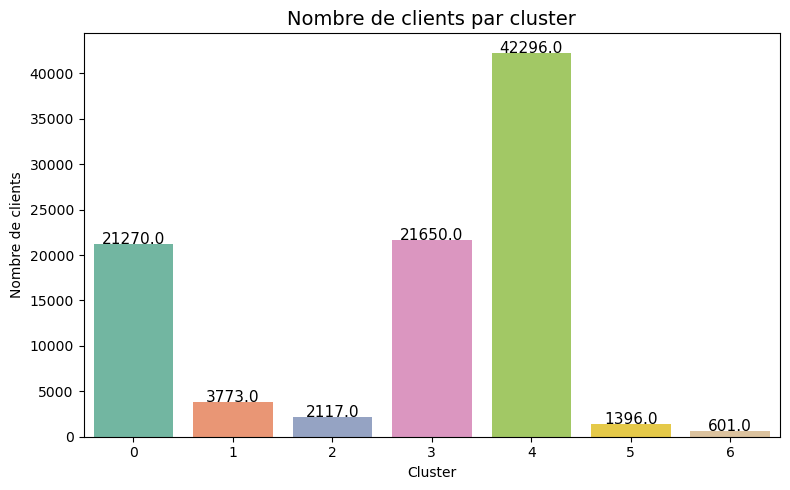

In [528]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

In [456]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 684997.2589919729
Silhouette Score: 0.34894715568214074
Davies-Bouldin Index: 1.081327994578661
Calinski-Harabasz Index: 16117.409545845205


| Métrique               | Modèle initial  | Modèle 4 avec k=7      |
|:-----------------------|:----------------|:------------------------|
| Inertie intra-cluster  | 945987.23       |   684997.26           |
| Silhouette Score       | 0.2856          |   0.3489                |
| Davies-Bouldin Index   | 1.5009          |   1.08                |
| Calinski-Harabasz Index| 11085.26        |   16117.41              |

**Inertie intra-cluster :**
- La baisse de l'inertie intra-cluster (945987.23 → 684997.26) indique que les clusters sont plus compacts dans le modèle modifié.
- Cela signifie que les clients au sein d'un même cluster sont plus similaires, ce qui est un signe de meilleure segmentation.

**Silhouette Score :**
- L'augmentation du Silhouette Score (0.2856 → 0.3489) montre que les clusters sont mieux séparés.
- Les clients sont plus proches de leur propre cluster et plus éloignés des autres clusters, ce qui renforce la qualité de la segmentation.

**Davies-Bouldin Index :**
- La diminution du Davies-Bouldin Index (1.5009 → 1.08) confirme que les clusters sont plus compacts et mieux séparés.
- Un DBI plus bas est toujours un indicateur positif pour la qualité des clusters.

**Calinski-Harabasz Index :**
- L'augmentation du Calinski-Harabasz Index (11085.26 → 16117.41) montre que la séparation entre les clusters est plus nette.
- Cela indique que le modèle avec k=7 offre une structure de clusters plus robuste.

Nous allons maintenant examiner plus en détail ce modèle pour mieux comprendre les caractéristiques de chaque cluster et identifier des opportunités d'optimisation ou d'application métier. 

##  Évaluation de la Stabilité des Clusters à l'Initialisation

L'algorithme K-Means dépend fortement de l'initialisation aléatoire des centroïdes, ce qui peut entraîner des variations dans les clusters obtenus. Cette section vise à évaluer la stabilité des clusters pour le choix optimal de k=7, en mesurant leur cohérence à travers différentes initialisations.

**Méthode :**
- Nous allons exécuté K-Means avec k=7 sur 100 initialisations aléatoires, en modifiant le paramètre random_state à chaque exécution.
- À chaque exécution, l'algorithme produit une partition des données (les clusters).
- Nous allons ensuite calculé le score Adjusted Rand Index (ARI) entre toutes les paires de partitions obtenues :
L'ARI mesure la similarité entre deux partitions tout en corrigeant les accords dus au hasard.<br>
Un score ARI élevé (proche de 1) indique que les clusters sont très similaires malgré les différentes initialisations, ce qui reflète leur robustesse.

Cette analyse permet de valider que les clusters obtenus avec k=7 sont stables et peuvent être utilisés en toute confiance pour la segmentation client.

In [490]:
# --- Paramètres ---
k = 7  # Nombre optimal de clusters
n_iter = 100  # Nombre d'initialisations différentes

# --- Seed globale pour la reproductibilité ---
np.random.seed(42)

# --- Stockage des labels de chaque initialisation ---
labels_list = []

# --- Exécution du K-Means plusieurs fois avec initialisation aléatoire différente ---
for i in range(n_iter):
    kmeans = KMeans(n_clusters=k, n_init=1, init='random', random_state=i)
    kmeans.fit(df_standardized)  
    labels_list.append(kmeans.labels_)

# --- Calcul des scores ARI pour toutes les paires d'initialisations ---
ari_scores = [
    adjusted_rand_score(a, b)
    for a, b in combinations(labels_list, 2)
]

# --- Score ARI moyen global ---
mean_ari = np.mean(ari_scores)
print(f"ARI moyen global pour k={k} : {mean_ari:.2f}")

ARI moyen global pour k=7 : 0.87


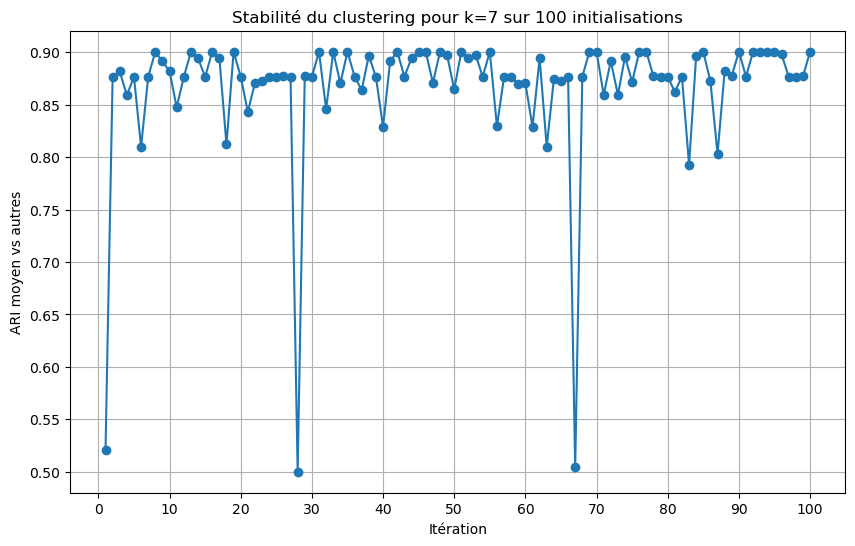

In [458]:
# --- Visualisation de la variabilité entre les itérations ---

# Score ARI moyen pour chaque itération vs toutes les autres
ari_scores_per_iter = []
for i in range(n_iter):
    scores = [
        adjusted_rand_score(labels_list[i], labels_list[j])
        for j in range(n_iter) if i != j
    ]
    ari_scores_per_iter.append(np.mean(scores))

# Met sous forme de DataFrame
ari_df = pd.DataFrame({
    'Itération': range(1, n_iter + 1),
    'ARI moyen vs autres': ari_scores_per_iter
})

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.plot(ari_df['Itération'], ari_df['ARI moyen vs autres'], marker='o')
plt.title(f"Stabilité du clustering pour k={k} sur {n_iter} initialisations")
plt.xlabel("Itération")
plt.ylabel("ARI moyen vs autres")
plt.grid(True)
plt.xticks(range(0, n_iter + 1, 10))  # Une graduation sur 10
plt.show()

Le score ARI moyen global obtenu pour k=7 est de 0.87, ce qui indique une forte stabilité des clusters à travers les différentes initialisations aléatoires. La majorité des scores ARI se situent entre 0.8 et 0.9, ce qui confirme que les partitions obtenues sont très cohérentes et robustes.

Cependant, quelques pics bas autour de 0.5 ont été observés, ce qui reflète des initialisations moins performantes dues à l'aléatoire. Ces anomalies sont rares et n'affectent pas la stabilité globale des clusters.

Ces résultats montrent que les clusters pour k=7 sont fiables et peuvent être utilisés en toute confiance pour la segmentation client.

## Évaluation de la pertinence des variables
### Identification des variables discriminantes (Variance inter-cluster)

In [594]:
# Ajouter les labels de cluster au DataFrame standardisé
df_standardized['cluster'] = kmeans.labels_

# Vérification
df_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   diversite_categories  delai_livraison_moyen  total_retards_livraison  \
0             -0.116637              -0.638318                 0.673333   
1             -0.116637              -0.952572                 0.673333   
2             -0.116637               1.351951                 0.950876   
3             -0.116637               0.828196                 0.025731   
4             -0.116637               0.094939                 0.395789   

   nb_paiements_total  moyenne_echeances_paiement  diversite_max_paiements  \
0           -0.177874                    1.905839                -0.153492   
1           -0.177874                   -0.709867                -0.153492   
2           -0.177874                    1.905839                -0.153492   
3           -0.177874                    0.411150                -0.153492   
4           -0.177874                    1.158494                -0.153492   

   note_moyenne_client  a_donne_une_note  recence_en_jours_cat_Très récent  \
0             0.664132          0.080672                          1.717526   
1            -0.119479          0.080672                          1.717526   
2            -0.903090          0.080672                         -0.582233   
3            -0.119479          0.080672                         -0.582233   
4             0.664132          0.080672                         -0.582233   

   recence_en_jours_cat_Modéré  recence_en_jours_cat_Ancien  cluster  
0                    -0.993843                    -0.577222        3  
1                    -0.993843                    -0.577222        3  
2                    -0.993843                     1.732435        0  
3                     1.006195                    -0.577222        4  
4                     1.006195                    -0.577222        4

In [595]:
# Variance inter-cluster pour chaque variable
variance_inter_cluster = df_standardized.groupby('cluster').mean().var()

# Trier les variables par leur variance inter-cluster
variables_discriminantes = variance_inter_cluster.sort_values(ascending=False)

print("Variables discriminantes (par variance inter-cluster) :")
print(variables_discriminantes)

Variables discriminantes (par variance inter-cluster) :
a_donne_une_note                    22.235559
diversite_categories                 8.592174
diversite_max_paiements              5.833134
nb_commandes                         4.773218
nb_paiements_total                   2.466345
poids_moyen_commandes                1.377368
frais_livraison_moyens               1.192037
total_depense                        0.937284
recence_en_jours_cat_Très récent     0.616812
recence_en_jours_cat_Ancien          0.615668
recence_en_jours_cat_Modéré          0.481444
total_retards_livraison              0.404261
moyenne_echeances_paiement           0.251116
delai_livraison_moyen                0.108286
note_moyenne_client                  0.022446
dtype: float64


L'analyse de la variance inter-cluster révèle que certaines variables, comme a_donne_une_note (22.235559), diversite_categories (8.592174), et diversite_max_paiements (5.833134), jouent un rôle clé dans la différenciation des clusters. 

En revanche, les variables moyenne_echeances_paiement (0.251116) et delai_livraison_moyen (0.108286) ont une très faible variance inter-cluster, ce qui montre qu'elles ne contribuent pas significativement à la segmentation. <br>
On peut envisager de supprimer ces deux variables pour simplifier le modèle sans perte d'information importante. 

La variable note_moyenne_client, bien que peu discriminante (variance = 0.022446), est conservée car elle est essentielle pour évaluer la satisfaction client.

### Heatmap des contributions des variables à la segmentation

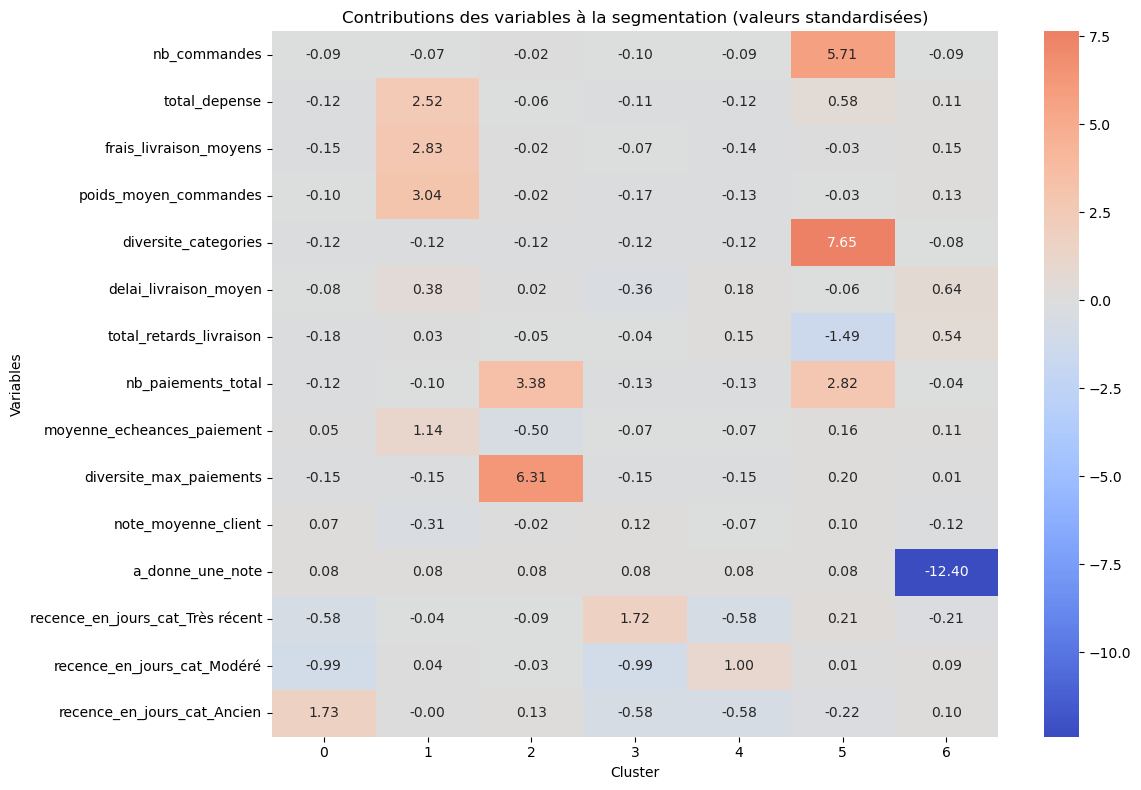

In [626]:
# Calculer les moyennes standardisées de chaque variable par cluster
cluster_means_std = df_standardized.groupby('cluster').mean()

# Tracer une heatmap pour visualiser les contributions des variables
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_std.T, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Contributions des variables à la segmentation (valeurs standardisées)")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

La heatmap montre les contributions des variables à la segmentation pour chaque cluster. <br>
Certaines variables, comme a_donne_une_note, diversite_max_paiements, et diversite_categories, se démarquent par leur capacité à différencier les clusters de manière significative. 

En revanche, les variables moyenne_echeances_paiement et delai_livraison_moyen, qui présentent des valeurs faibles et peu discriminantes dans tous les clusters, confirment leur faible pertinence pour le modèle. 

Ces deux variables sont donc supprimées. La variable note_moyenne_client, bien qu'elle ait une contribution limitée dans certains clusters, est conservée pour répondre à l'objectif d'évaluer la satisfaction client.

### Résultats ANOVA : Identification des variables significatives

In [597]:
# Ajouter les labels de cluster au DataFrame original
df_encoded['cluster'] = kmeans.labels_

# Vérification
df_encoded.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0             1         129.90                   12.00                 1500.0   
1             1          18.90                    8.29                  375.0   
2             1          69.00                   17.22                 1500.0   
3             1          25.99                   17.63                  150.0   
4             1         180.00                   16.89                 6050.0   

   diversite_categories  delai_livraison_moyen  total_retards_livraison  \
0                     1                    6.0                       -5   
1                     1                    3.0                       -5   
2                     1                   25.0                       -2   
3                     1                   20.0                      -12   
4                     1                   13.0                       -8   

   nb_paiements_total  moyenne_echeances_paiement  diversite_max_paiements  \
0                   1                         8.0                        1   
1                   1                         1.0                        1   
2                   1                         8.0                        1   
3                   1                         4.0                        1   
4                   1                         6.0                        1   

   note_moyenne_client  a_donne_une_note  recence_en_jours_cat_Très récent  \
0                  5.0                 1                              True   
1                  4.0                 1                              True   
2                  3.0                 1                             False   
3                  4.0                 1                             False   
4                  5.0                 1                             False   

   recence_en_jours_cat_Modéré  recence_en_jours_cat_Ancien  cluster  
0                        False                        False        3  
1                        False                        False        3  
2                        False                         True        0  
3                         True                        False        4  
4                         True                        False        4

In [690]:
# Liste de toutes les variables quantitatives présentes dans le DataFrame (exclure 'cluster')
variables_a_tester = [col for col in df_encoded.columns if col != 'cluster']

# Dictionnaire pour stocker les résultats ANOVA
anova_results = {}

# Effectuer l'ANOVA pour chaque variable
for variable in variables_a_tester:
    # Extraire les valeurs de la variable par cluster
    clusters = [df_encoded[df_encoded['cluster'] == cluster][variable] for cluster in df_encoded['cluster'].unique()]
    
    # Test ANOVA
    f_stat, p_value = f_oneway(*clusters)
    
    # Stocker les résultats dans le dictionnaire
    anova_results[variable] = {'F-statistic': f_stat, 'p-value': p_value}

# Convertir les résultats en DataFrame pour une meilleure lisibilité
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p-value', ascending=True)

print("Résultats ANOVA :")
print(anova_df)

Résultats ANOVA :
                                   F-statistic        p-value
nb_commandes                      1.525184e+04   0.000000e+00
total_depense                     5.890860e+03   0.000000e+00
frais_livraison_moyens            8.030298e+03   0.000000e+00
poids_moyen_commandes             1.000004e+04   0.000000e+00
diversite_categories              1.252104e+05   0.000000e+00
delai_livraison_moyen             8.870830e+02   0.000000e+00
total_retards_livraison           8.744351e+02   0.000000e+00
nb_paiements_total                1.005646e+04   0.000000e+00
moyenne_echeances_paiement        1.041587e+03   0.000000e+00
diversite_max_paiements           2.041696e+05   0.000000e+00
a_donne_une_note                  9.267180e+06   0.000000e+00
recence_en_jours_cat_Très récent  1.747991e+05   0.000000e+00
recence_en_jours_cat_Modéré       1.648118e+05   0.000000e+00
recence_en_jours_cat_Ancien       1.667900e+05   0.000000e+00
note_moyenne_client               1.628612e+02  9.68

**Suppression de moyenne_echeances_paiement**
- Analyse des résultats ANOVA :
La variable moyenne_echeances_paiement présente une F-statistic relativement faible (1041.587) par rapport aux autres variables, ce qui indique qu'elle n'a pas une forte capacité à expliquer la variance entre les clusters.
- Analyse de la variance inter-cluster :
Sa variance inter-cluster est également très faible (0.251116), ce qui montre qu'elle contribue peu à différencier les clusters.
- Pertinence métier :
Bien qu'elle reflète le délai moyen de paiement, cette variable n'est pas directement liée aux objectifs principaux du projet (différencier les bons et moins bons clients en termes de commandes et satisfaction). Elle peut donc être supprimée sans impact significatif sur la qualité du modèle.

**Suppression de delai_livraison_moyen**
- Analyse des résultats ANOVA :
La variable delai_livraison_moyen présente une F-statistic encore plus faible (887.083) par rapport aux autres variables, ce qui indique une faible capacité explicative.
- Analyse de la variance inter-cluster :
Sa variance inter-cluster est également très basse (0.108286), ce qui confirme qu'elle ne discrimine pas efficacement les clusters.
- Pertinence métier :
Bien que cette variable puisse influencer la satisfaction client, elle est redondante avec total_retards_livraison, qui capture mieux les retards de livraison et leur impact sur l'expérience client. Elle peut donc être supprimée sans perte d'information importante.

**Conservation de note_moyenne_client**
 - Analyse des résultats ANOVA :
La variable note_moyenne_client présente une F-statistic relativement faible (162.861) et une p-value extrêmement significative (9.689416e-207). Cela montre qu'elle a un rôle limité dans la différenciation des clusters mais reste statistiquement pertinente.
- Analyse de la variance inter-cluster :
Bien que sa variance inter-cluster soit très faible (0.022446), cette variable est essentielle pour évaluer la satisfaction client, conformément aux attentes du projet.
- Pertinence métier :
La satisfaction client est un axe clé de l'analyse demandé par l'énoncé. La note_moyenne_client, bien qu'elle soit peu discriminante seule, complète d'autres variables comme a_donne_une_note pour fournir une vue globale sur l'engagement et la perception des clients.

Après avoir identifié les variables les moins discriminantes, nous allons refaire le clustering sans inclure moyenne_echeances_paiement et delai_livraison_moyen pour améliorer la qualité et la pertinence du modèle. Ce nouveau clustering permettra de mieux capturer les caractéristiques essentielles des clients tout en conservant la variable note_moyenne_client pour évaluer la satisfaction client.

# Préparation des données pour le 5ème essai de K-Means

In [17]:
df_copie_essai5 = df.copy()

In [18]:
# Liste des variables quantitatives à supprimer
variables_to_drop = [ 'moyenne_echeances_paiement', 'delai_livraison_moyen', 'cluster']

# Suppression des variables du DataFrame
df_copie_essai5 = df_copie_essai5.drop(variables_to_drop, axis=1)

In [19]:
df_copie_essai5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   nb_commandes             93103 non-null  int64   
 1   total_depense            93103 non-null  float64 
 2   frais_livraison_moyens   93103 non-null  float64 
 3   poids_moyen_commandes    93103 non-null  float64 
 4   diversite_categories     93103 non-null  int64   
 5   total_retards_livraison  93103 non-null  int64   
 6   nb_paiements_total       93103 non-null  int64   
 7   diversite_max_paiements  93103 non-null  int64   
 8   note_moyenne_client      93103 non-null  float64 
 9   a_donne_une_note         93103 non-null  int64   
 10  recence_en_jours_cat     93103 non-null  category
dtypes: category(1), float64(4), int64(6)
memory usage: 7.2 MB


In [20]:
# One-hot encoding des variables catégorielles regroupées
df_encoded_5 = pd.get_dummies(df_copie_essai5, columns=['recence_en_jours_cat'], drop_first=False)

# Standardisation des données
scaler = StandardScaler()
df_standardized_5 = scaler.fit_transform(df_encoded_5)

# Recréer un DataFrame après la standardisation
df_standardized_5 = pd.DataFrame(df_standardized_5, columns=df_encoded_5.columns)

# Vérification
df_standardized_5.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0             -0.116637                 0.673333           -0.177874   
1             -0.116637                 0.673333           -0.177874   
2             -0.116637                 0.950876           -0.177874   
3             -0.116637                 0.025731           -0.177874   
4             -0.116637                 0.395789           -0.177874   

   diversite_max_paiements  note_moyenne_client  a_donne_une_note  \
0                -0.153492             0.664132          0.080672   
1                -0.153492            -0.119479          0.080672   
2                -0.153492            -0.903090          0.080672   
3                -0.153492            -0.119479          0.080672   
4                -0.153492             0.664132          0.080672   

   recence_en_jours_cat_Très récent  recence_en_jours_cat_Modéré  \
0                          1.717526                    -0.993843   
1                          1.717526                    -0.993843   
2                         -0.582233                    -0.993843   
3                         -0.582233                     1.006195   
4                         -0.582233                     1.006195   

   recence_en_jours_cat_Ancien  
0                    -0.577222  
1                    -0.577222  
2                     1.732435  
3                    -0.577222  
4                    -0.577222

In [21]:
df_standardized_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93103 entries, 0 to 93102
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_commandes                      93103 non-null  float64
 1   total_depense                     93103 non-null  float64
 2   frais_livraison_moyens            93103 non-null  float64
 3   poids_moyen_commandes             93103 non-null  float64
 4   diversite_categories              93103 non-null  float64
 5   total_retards_livraison           93103 non-null  float64
 6   nb_paiements_total                93103 non-null  float64
 7   diversite_max_paiements           93103 non-null  float64
 8   note_moyenne_client               93103 non-null  float64
 9   a_donne_une_note                  93103 non-null  float64
 10  recence_en_jours_cat_Très récent  93103 non-null  float64
 11  recence_en_jours_cat_Modéré       93103 non-null  float64
 12  rece

# Application de K-Means pour le clustering (Essai 5)

## Détermination du nombre de clusters optimal
### Méthode du coude

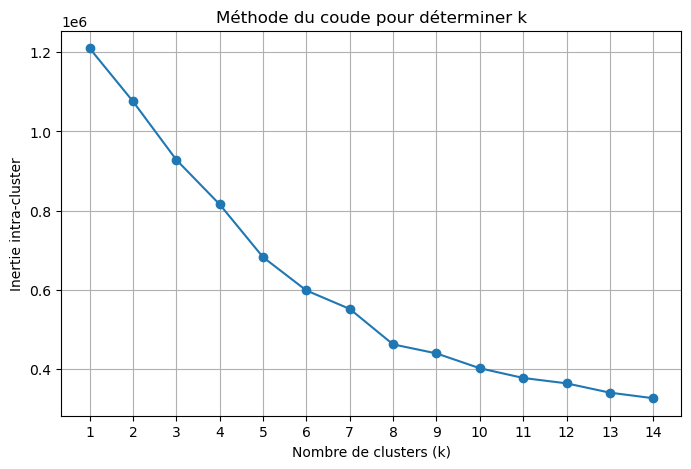

In [656]:
# Liste pour stocker les inerties (somme des distances intra-cluster)
inertias = []

# Tester différents nombres de clusters (k)
K = range(1, 15)  # De 1 à 15 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized_5)  # Appliquer K-Means sur les données standardisées
    inertias.append(kmeans.inertia_)  # Stocker l'inertie (critère de qualité)

# Visualisation de la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie intra-cluster')
plt.title('Méthode du coude pour déterminer k')
plt.xticks(K)
plt.grid()
plt.show()

Choix de k :
- Fortes baisses de l’inertie jusqu’à k=8, indiquant une structure naturelle dans les données.
- Gain marginal très faible à k=8 → point de rupture potentiel.
- Choix k=8

### Coefficient de silhouette

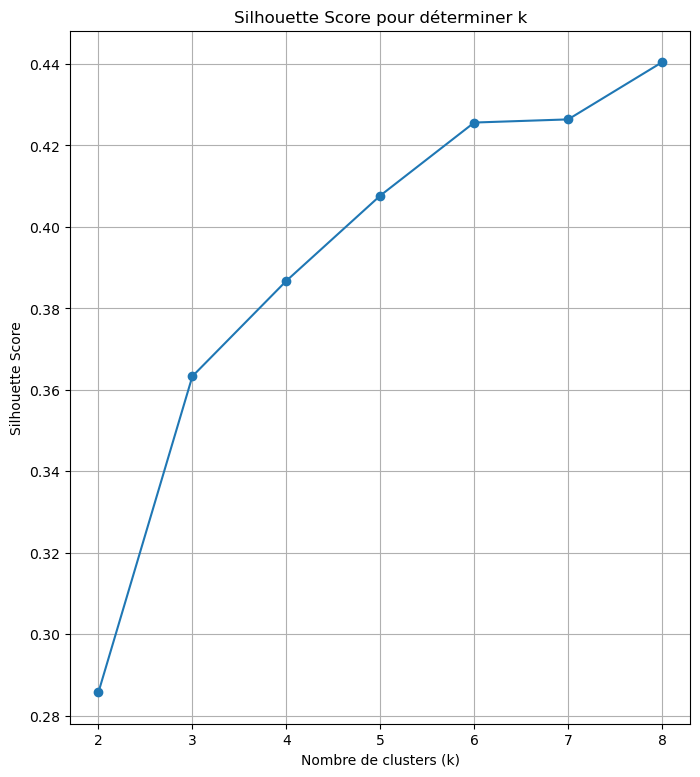

In [659]:
# Calcul du silhouette score pour chaque k
silhouette_scores = []
for k in range(2, 9):  # Le silhouette score nécessite au moins 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_standardized_5)
    score = silhouette_score(df_standardized_5, labels)
    silhouette_scores.append(score)

# Visualisation du silhouette score
plt.figure(figsize=(8, 9))
plt.plot(range(2, 9), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score pour déterminer k')
plt.grid()
plt.show()

k=8 est un bon compromis 

## Application de K-Means avec k=8 pour la Segmentation Client

In [22]:
# Appliquer l'algorithme K-Means avec k=7 clusters
kmeans = KMeans(n_clusters=8, random_state=42)

# Calculer les clusters sur les données standardisées
cluster_labels = kmeans.fit_predict(df_standardized_5)

# Ajouter les labels des clusters au DataFrame original
df_copie_essai5['cluster'] = cluster_labels

# Afficher la taille (effectif) de chaque cluster
print("Effectifs par cluster :")
print(df_copie_essai5['cluster'].value_counts().sort_index())

# Recréer un DataFrame lisible avec les centres des clusters sur l'échelle d'origine
# On inverse la standardisation pour retrouver des valeurs interprétables
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),  # Dés-standardisation
    columns=df_standardized_5.columns                    # Utiliser les noms de colonnes d'origine
)

# Ajouter les noms de clusters comme index
centroids.index = [f"Cluster {i}" for i in range(8)]

# Afficher les centres des clusters (arrondis) en transposant pour une lecture verticale
print("Centres des clusters (échelle d'origine) :")
centroids.round(2).T

Effectifs par cluster :
cluster
0     2115
1    35158
2    21350
3     1396
4      601
5     3070
6    20985
7     8428
Name: count, dtype: int64
Centres des clusters (échelle d'origine) :


Cluster 0  Cluster 1  Cluster 2  Cluster 3  \
nb_commandes                           1.03       1.02       1.01       2.23   
total_depense                        127.74     115.69     118.68     267.71   
frais_livraison_moyens                22.36      19.31      21.47      22.23   
poids_moyen_commandes               2318.39    1770.14    1617.34    2228.13   
diversite_categories                   1.00       1.00       1.00       1.98   
total_retards_livraison              -12.81     -12.86     -13.14     -28.40   
nb_paiements_total                     2.60       1.02       1.02       2.35   
diversite_max_paiements                1.97       1.00       1.00       1.05   
note_moyenne_client                    4.13       4.60       4.36       4.28   
a_donne_une_note                       1.00       1.00       1.00       1.00   
recence_en_jours_cat_Très récent       0.21      -0.00       1.00       0.35   
recence_en_jours_cat_Modéré            0.48       1.00       0.00       0.50   
recence_en_jours_cat_Ancien            0.30       0.00       0.00       0.15   

                                  Cluster 4  Cluster 5  Cluster 6  Cluster 7  
nb_commandes                           1.01       1.02       1.02       1.01  
total_depense                        165.23     738.49     117.54     131.46  
frais_livraison_moyens                25.99      90.59      19.60      23.72  
poids_moyen_commandes               3016.12   18409.75    1957.18    2171.74  
diversite_categories                   1.00       1.00       1.00       1.00  
total_retards_livraison               -6.41     -13.14     -14.67       0.97  
nb_paiements_total                     1.06       1.04       1.03       1.02  
diversite_max_paiements                1.02       1.00       1.00       1.00  
note_moyenne_client                    4.00       3.88       4.30       1.48  
a_donne_une_note                      -0.00       1.00       1.00       1.00  
recence_en_jours_cat_Très récent       0.16       0.25      -0.00       0.05  
recence_en_jours_cat_Modéré            0.54       0.48      -0.00       0.90  
recence_en_jours_cat_Ancien            0.29       0.26       1.00       0.05

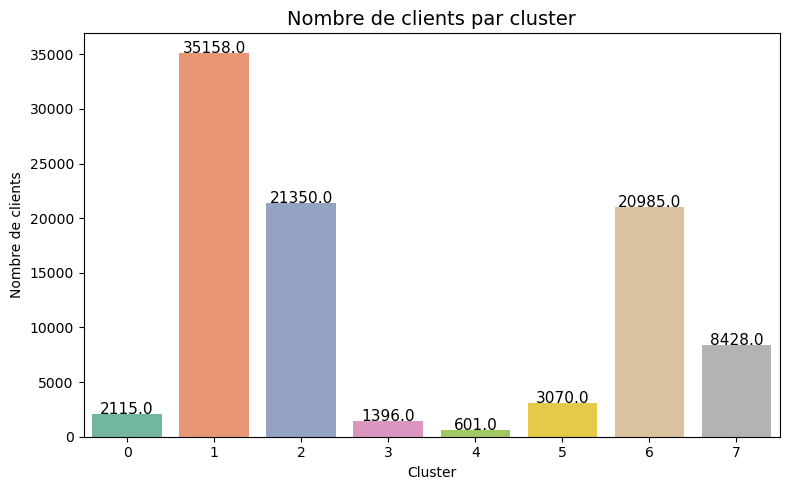

In [31]:
# Taille de la figure
plt.figure(figsize=(8, 5))

# Countplot sans warning
sns.countplot(data=df_copie_essai5, x='cluster', hue='cluster', palette='Set2', legend=False)

# Titre et labels
plt.title("Nombre de clients par cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")

# Afficher les valeurs sur les barres
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Évaluation de la qualité du clustering

In [125]:
# Inertie intra-cluster (somme des distances au centre de chaque cluster)
inertia = kmeans.inertia_

# Calcul des autres métriques
silhouette = silhouette_score(df_standardized_5, kmeans.labels_)
davies_bouldin = davies_bouldin_score(df_standardized_5, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_standardized_5, kmeans.labels_)

# Affichage des métriques
print("Inertie intra-cluster :", inertia)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Inertie intra-cluster : 461701.62389644876
Silhouette Score: 0.44042762549621356
Davies-Bouldin Index: 0.9754329474521286
Calinski-Harabasz Index: 21564.452450928577


| Métrique               | Modèle initial  | Modèle 4 avec k=7      | Modèle 5 avec k=8      |
|:-----------------------|:----------------|:-----------------------|:-----------------------|
| Inertie intra-cluster  | 945987.23       |   684997.26            |   461701.62            |
| Silhouette Score       | 0.2856          |   0.3489               |   0.4404               |
| Davies-Bouldin Index   | 1.5009          |   1.08                 |   0.98                 |
| Calinski-Harabasz Index| 11085.26        |   16117.41             |   21564.45             |


Le Modèle 5 avec k=8 améliore significativement plusieurs métriques clés par rapport aux modèles précédents :
- Inertie intra-cluster : Elle est réduite à 461 701.62, indiquant des clusters plus compacts.
- Silhouette Score : Il augmente à 0.4404, montrant une meilleure séparation des clusters.
- Davies-Bouldin Index : Il diminue à 0.98, confirmant une meilleure distinction entre les clusters.
- Calinski-Harabasz Index : Il atteint 21 564.45, soulignant une densité et une séparation optimales.

Ces améliorations sont en partie dues à la suppression des variables peu discriminantes (moyenne_echeances_paiement et delai_livraison_moyen), qui ont permis de simplifier le modèle tout en renforçant la qualité des clusters. Cette optimisation garantit une segmentation plus pertinente et exploitable pour répondre aux objectifs du projet.

##  Évaluation de la Stabilité des Clusters à l'Initialisation

In [706]:
# --- Paramètres ---
k = 8  # Nombre optimal de clusters
n_iter = 100  # Nombre d'initialisations différentes

# --- Seed globale pour la reproductibilité ---
np.random.seed(42)

# --- Stockage des labels de chaque initialisation ---
labels_list = []

# --- Exécution du K-Means plusieurs fois avec initialisation aléatoire différente ---
for i in range(n_iter):
    kmeans = KMeans(n_clusters=k, n_init=1, init='random', random_state=i)
    kmeans.fit(df_standardized_5)  
    labels_list.append(kmeans.labels_)

# --- Calcul des scores ARI pour toutes les paires d'initialisations ---
ari_scores = [
    adjusted_rand_score(a, b)
    for a, b in combinations(labels_list, 2)
]

# --- Score ARI moyen global ---
mean_ari = np.mean(ari_scores)
print(f"ARI moyen global pour k={k} : {mean_ari:.2f}")

ARI moyen global pour k=8 : 0.84


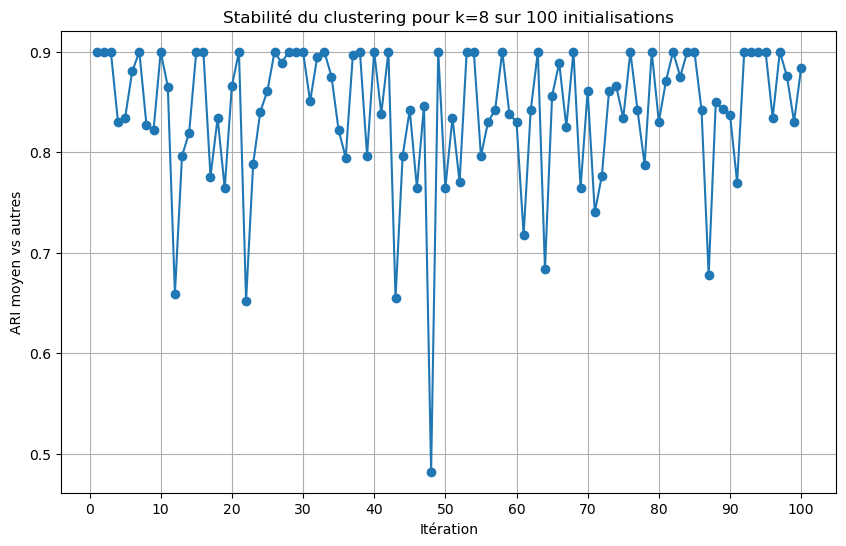

In [707]:
# --- Visualisation de la variabilité entre les itérations ---

# Score ARI moyen pour chaque itération vs toutes les autres
ari_scores_per_iter = []
for i in range(n_iter):
    scores = [
        adjusted_rand_score(labels_list[i], labels_list[j])
        for j in range(n_iter) if i != j
    ]
    ari_scores_per_iter.append(np.mean(scores))

# Met sous forme de DataFrame
ari_df = pd.DataFrame({
    'Itération': range(1, n_iter + 1),
    'ARI moyen vs autres': ari_scores_per_iter
})

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.plot(ari_df['Itération'], ari_df['ARI moyen vs autres'], marker='o')
plt.title(f"Stabilité du clustering pour k={k} sur {n_iter} initialisations")
plt.xlabel("Itération")
plt.ylabel("ARI moyen vs autres")
plt.grid(True)
plt.xticks(range(0, n_iter + 1, 10))  # Une graduation sur 10
plt.show()

Le Modèle 5 (k=8) présente un ARI moyen global de 0.84, ce qui témoigne d'une bonne stabilité des clusters. La majorité des points ont un ARI compris entre 0.8 et 0.9, indiquant une forte cohérence entre les partitions obtenues. Quelques variations sont observées, avec une douzaine de points entre 0.65 et 0.8 et un point isolé autour de 0.5, mais ces exceptions restent marginales.

Ces résultats confirment que le modèle est globalement robuste, avec des clusters bien définis et peu affectés par des variations aléatoires. Cela valide la pertinence du choix de k=8 pour la segmentation.

## Évaluation de la pertinence des variables
### Identification des variables discriminantes (Variance inter-cluster)

In [23]:
# Ajouter les labels de cluster au DataFrame standardisé
df_standardized_5['cluster'] = kmeans.labels_

# Vérification
df_standardized_5.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.159763      -0.054337               -0.501899              -0.187134   
1     -0.159763      -0.568828               -0.674713              -0.423820   
2     -0.159763      -0.336612               -0.258749              -0.187134   
3     -0.159763      -0.535966               -0.239651              -0.471157   
4     -0.159763       0.177879               -0.274120               0.770128   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0             -0.116637                 0.673333           -0.177874   
1             -0.116637                 0.673333           -0.177874   
2             -0.116637                 0.950876           -0.177874   
3             -0.116637                 0.025731           -0.177874   
4             -0.116637                 0.395789           -0.177874   

   diversite_max_paiements  note_moyenne_client  a_donne_une_note  \
0                -0.153492             0.664132          0.080672   
1                -0.153492            -0.119479          0.080672   
2                -0.153492            -0.903090          0.080672   
3                -0.153492            -0.119479          0.080672   
4                -0.153492             0.664132          0.080672   

   recence_en_jours_cat_Très récent  recence_en_jours_cat_Modéré  \
0                          1.717526                    -0.993843   
1                          1.717526                    -0.993843   
2                         -0.582233                    -0.993843   
3                         -0.582233                     1.006195   
4                         -0.582233                     1.006195   

   recence_en_jours_cat_Ancien  cluster  
0                    -0.577222        2  
1                    -0.577222        2  
2                     1.732435        6  
3                    -0.577222        1  
4                    -0.577222        1

In [24]:
# Variance inter-cluster pour chaque variable
variance_inter_cluster_5 = df_standardized_5.groupby('cluster').mean().var()

# Trier les variables par leur variance inter-cluster
variables_discriminantes_5 = variance_inter_cluster_5.sort_values(ascending=False)

print("Variables discriminantes (par variance inter-cluster) :")
print(variables_discriminantes_5)

Variables discriminantes (par variance inter-cluster) :
a_donne_une_note                    19.456023
diversite_categories                 7.519980
diversite_max_paiements              5.133891
nb_commandes                         4.181560
nb_paiements_total                   2.219177
poids_moyen_commandes                1.470184
frais_livraison_moyens               1.281899
total_depense                        0.987729
note_moyenne_client                  0.609394
total_retards_livraison              0.583363
recence_en_jours_cat_Ancien          0.563967
recence_en_jours_cat_Très récent     0.563835
recence_en_jours_cat_Modéré          0.520213
dtype: float64


### Heatmap des contributions des variables à la segmentation

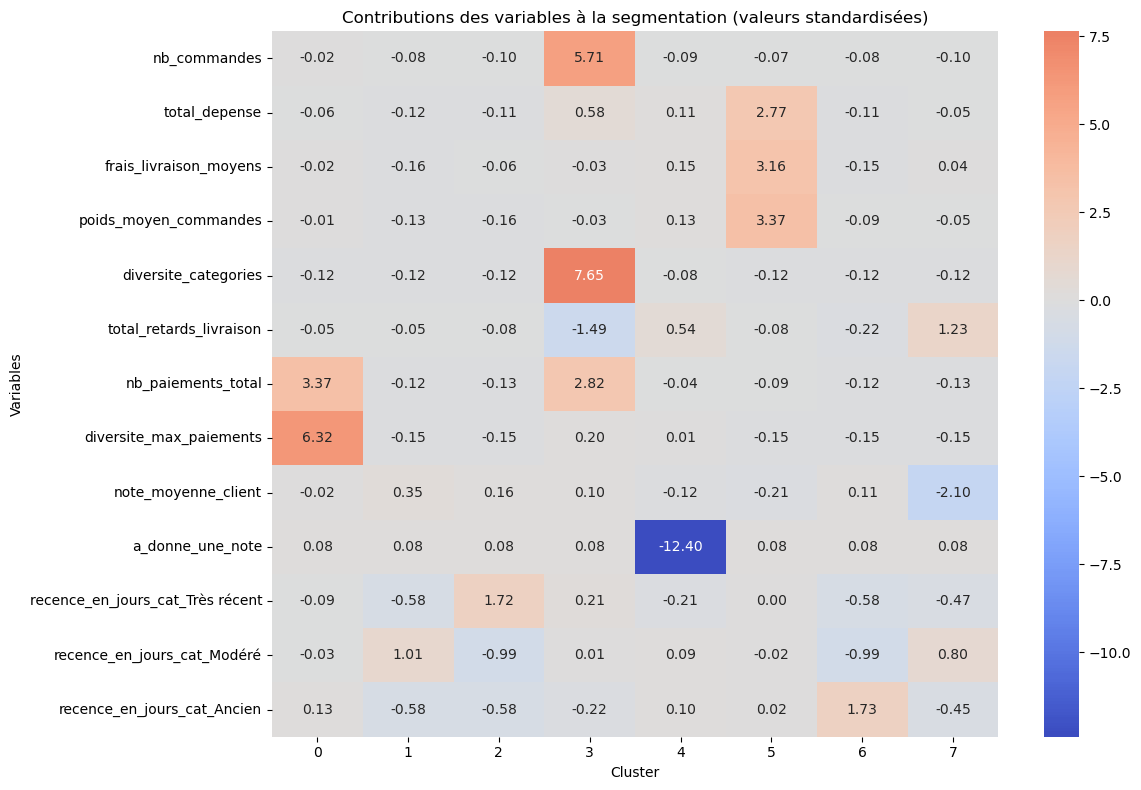

In [25]:
# Calculer les moyennes standardisées de chaque variable par cluster
cluster_means_std = df_standardized_5.groupby('cluster').mean()

# Tracer une heatmap pour visualiser les contributions des variables
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_std.T, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Contributions des variables à la segmentation (valeurs standardisées)")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

### Résultats ANOVA : Identification des variables significatives

In [26]:
# Ajouter les labels de cluster au DataFrame original
df_encoded_5['cluster'] = kmeans.labels_

# Vérification
df_encoded_5.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0             1         129.90                   12.00                 1500.0   
1             1          18.90                    8.29                  375.0   
2             1          69.00                   17.22                 1500.0   
3             1          25.99                   17.63                  150.0   
4             1         180.00                   16.89                 6050.0   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0                     1                       -5                   1   
1                     1                       -5                   1   
2                     1                       -2                   1   
3                     1                      -12                   1   
4                     1                       -8                   1   

   diversite_max_paiements  note_moyenne_client  a_donne_une_note  \
0                        1                  5.0                 1   
1                        1                  4.0                 1   
2                        1                  3.0                 1   
3                        1                  4.0                 1   
4                        1                  5.0                 1   

   recence_en_jours_cat_Très récent  recence_en_jours_cat_Modéré  \
0                              True                        False   
1                              True                        False   
2                             False                        False   
3                             False                         True   
4                             False                         True   

   recence_en_jours_cat_Ancien  cluster  
0                        False        2  
1                        False        2  
2                         True        6  
3                        False        1  
4                        False        1

In [27]:
# Liste de toutes les variables quantitatives présentes dans le DataFrame (exclure 'cluster')
variables_a_tester = [col for col in df_encoded_5.columns if col != 'cluster']

# Dictionnaire pour stocker les résultats ANOVA
anova_results = {}

# Effectuer l'ANOVA pour chaque variable
for variable in variables_a_tester:
    # Extraire les valeurs de la variable par cluster
    clusters = [df_encoded_5[df_encoded_5['cluster'] == cluster][variable] for cluster in df_encoded_5['cluster'].unique()]
    
    # Test ANOVA
    f_stat, p_value = f_oneway(*clusters)
    
    # Stocker les résultats dans le dictionnaire
    anova_results[variable] = {'F-statistic': f_stat, 'p-value': p_value}

# Convertir les résultats en DataFrame pour une meilleure lisibilité
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p-value', ascending=True)

print("Résultats ANOVA :")
print(anova_df)

Résultats ANOVA :
                                   F-statistic  p-value
nb_commandes                      1.307413e+04      0.0
total_depense                     4.882776e+03      0.0
frais_livraison_moyens            7.000883e+03      0.0
poids_moyen_commandes             8.478011e+03      0.0
diversite_categories              1.073220e+05      0.0
total_retards_livraison           3.022145e+03      0.0
nb_paiements_total                8.581276e+03      0.0
diversite_max_paiements           1.774292e+05      0.0
note_moyenne_client               1.115329e+04      0.0
a_donne_une_note                  7.943695e+06      0.0
recence_en_jours_cat_Très récent  1.225853e+05      0.0
recence_en_jours_cat_Modéré       1.075590e+05      0.0
recence_en_jours_cat_Ancien       1.178617e+05      0.0


### Conclusion

L’analyse de la variance inter-cluster met en évidence les variables les plus discriminantes pour la segmentation. Parmi elles, on retrouve notamment :
- a_donne_une_note (variable binaire sur l’expression d’une satisfaction) avec la plus forte variance,
- la diversité des catégories de produits commandés,
- la diversité des modes de paiement,
- ainsi que le nombre de commandes.

Ces variables ont fortement contribué à différencier les groupes de clients en fonction de leur comportement général.

L’ANOVA confirme ces résultats, toutes les variables testées ayant des p-values significativement nulles, ce qui valide leur utilité statistique dans la construction des clusters. On note également une F-statistic extrêmement élevée pour a_donne_une_note, confirmant son pouvoir explicatif, ainsi que pour les variables liées à la récence (recence_en_jours_cat_X), malgré leur poids moindre dans la variance inter-cluster.

Enfin, l’étude de la contribution moyenne par cluster permet d’interpréter les groupes constitués. Par exemple :

- certains clusters se démarquent par un niveau élevé de commandes et de dépenses, d’autres par un poids moyen de commande important, ou encore par une forte diversité de catégories ou de paiements.

- Bien que des variables comme note_moyenne_client ou les catégories de récence n’aient pas été centrales dans la formation des groupes, elles restent très utiles pour enrichir l’analyse marketing, notamment pour différencier les clients satisfaits des moins satisfaits.

- Ainsi, la segmentation produite repose sur un équilibre entre performance commerciale, comportements d’achat et satisfaction, tout en conservant des variables secondaires utiles pour l’interprétation métier.

## Analyse descriptive des variables par cluster

Pour mieux comprendre le comportement des clients dans chaque cluster, nous avons structuré notre analyse autour de groupes thématiques. Ces groupes regroupent des variables liées à des aspects spécifiques du comportement client :
- RFM (Récence, Fréquence, Montant) : Variables liées à la récence des interactions, la fréquence des commandes, et le montant total dépensé.
- Produits : Variables reflétant la diversité et les caractéristiques des produits achetés.
- Livraison : Variables liées aux retards et frais de livraison, qui impactent l'expérience client.
- Paiement : Variables représentant les comportements financiers, comme la diversité des modes de paiement et le nombre total de paiements effectués.
- Satisfaction client : Variables mesurant l'engagement et la perception globale des clients envers l'entreprise.

Cette organisation permet d'analyser chaque dimension du comportement client de manière ciblée et approfondie, tout en facilitant l'interprétation des résultats par cluster. 

In [725]:
rfm = ['recence_en_jours_cat_Très récent', 'recence_en_jours_cat_Ancien',
       'recence_en_jours_cat_Modéré', 'total_depense', 'nb_commandes']
produits =['poids_moyen_commandes', 'diversite_categories']
livraison = ['total_retards_livraison', 'frais_livraison_moyens']
paiement = ['diversite_max_paiements', 'nb_paiements_total']
satisfaction_client = ['note_moyenne_client', 'a_donne_une_note']

### Variables liées à rfm

In [726]:
df_encoded_5.groupby('cluster')['total_depense'].describe()

count        mean         std    min      25%      50%      75%  \
cluster                                                                      
0         2115.0  127.744246  171.188434   2.20   45.165   85.000  143.800   
1        35158.0  115.689796  119.216263   0.85   45.000   81.900  143.990   
2        21350.0  118.683259  127.689453   3.00   44.990   82.990  143.595   
3         1396.0  267.705501  266.129574  20.70  118.900  189.445  317.775   
4          601.0  165.232196  235.891048   6.33   49.900   99.000  178.480   
5         3070.0  738.286466  727.102875  31.80  259.900  500.890  987.000   
6        20985.0  117.542332  129.130425   2.29   44.900   79.900  139.900   
7         8428.0  131.449508  135.858016   3.54   49.900   95.000  159.900   

              max  
cluster            
0         2299.00  
1         1399.00  
2         1502.93  
3         4080.00  
4         2470.50  
5        13440.00  
6         1420.00  
7         1699.00

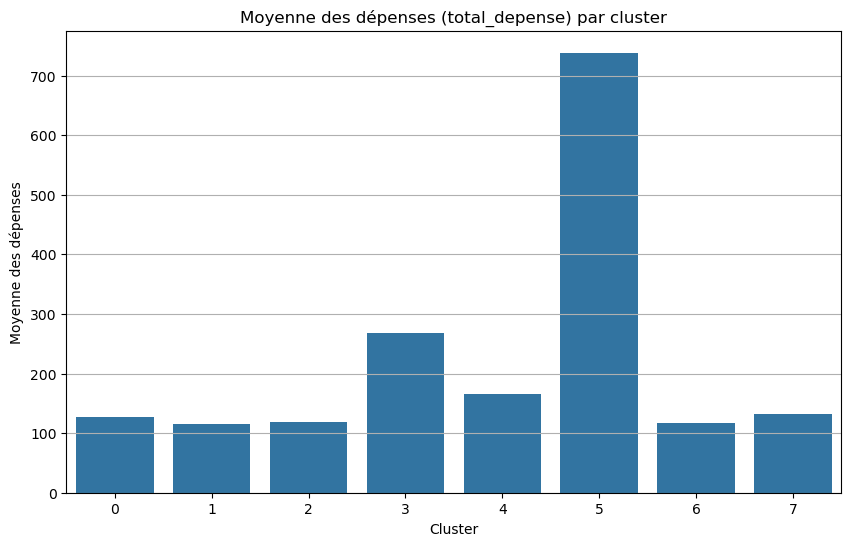

In [727]:
# Calcul de la moyenne des dépenses par cluster
mean_depense = df_encoded_5.groupby('cluster')['total_depense'].mean()

# Barplot des moyennes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_depense.index, y=mean_depense.values)
plt.title("Moyenne des dépenses (total_depense) par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des dépenses")
plt.grid(axis='y')
plt.show()

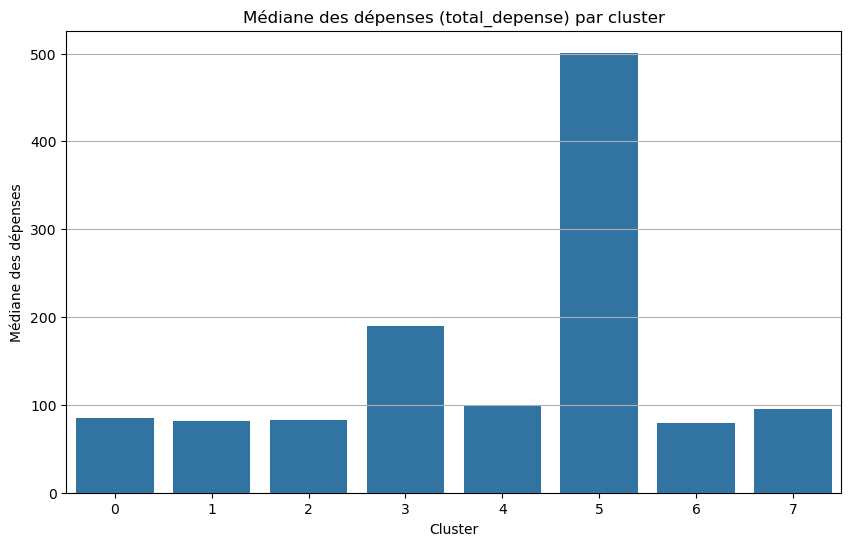

In [728]:
# Calcul de la médiane des dépenses par cluster
median_depense = df_encoded_5.groupby('cluster')['total_depense'].median()

# Barplot des médianes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=median_depense.index, y=median_depense.values)
plt.title("Médiane des dépenses (total_depense) par cluster")
plt.xlabel("Cluster")
plt.ylabel("Médiane des dépenses")
plt.grid(axis='y')
plt.show()

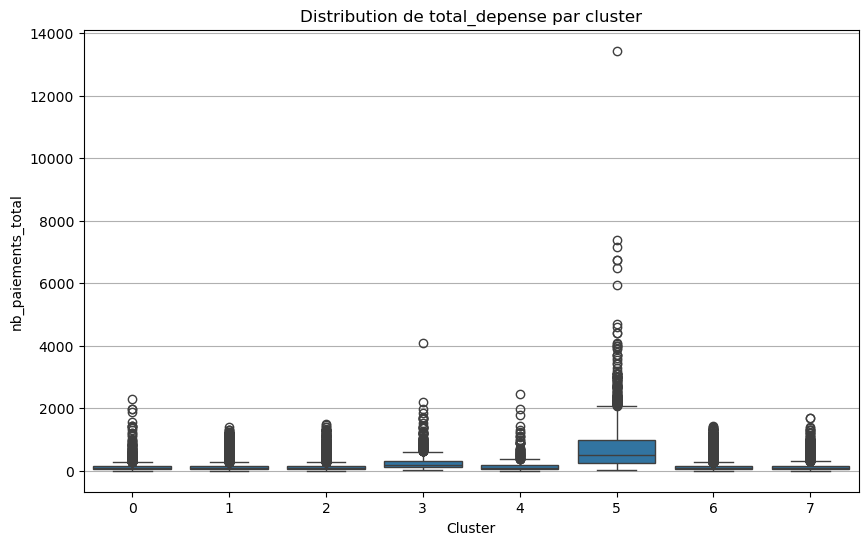

In [729]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='total_depense', data=df_encoded_5)
plt.title(f"Distribution de total_depense par cluster")
plt.xlabel("Cluster")
plt.grid(axis='y')
plt.show()

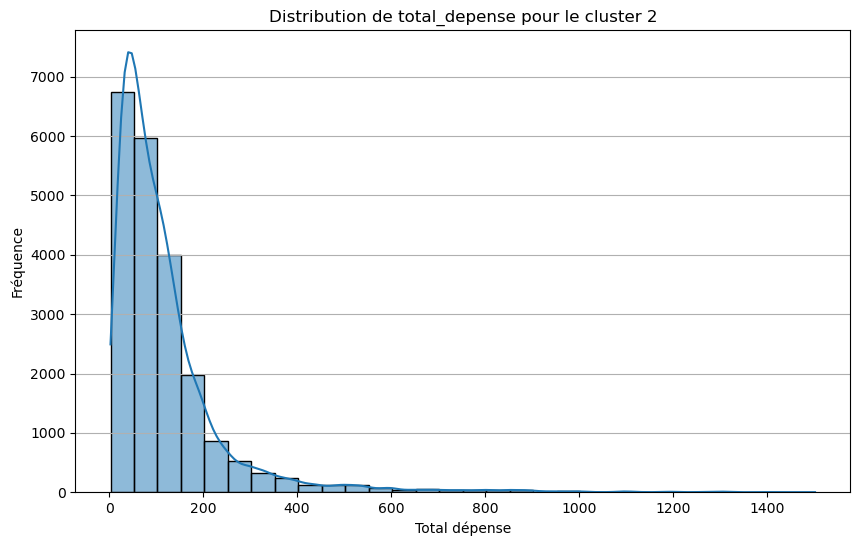

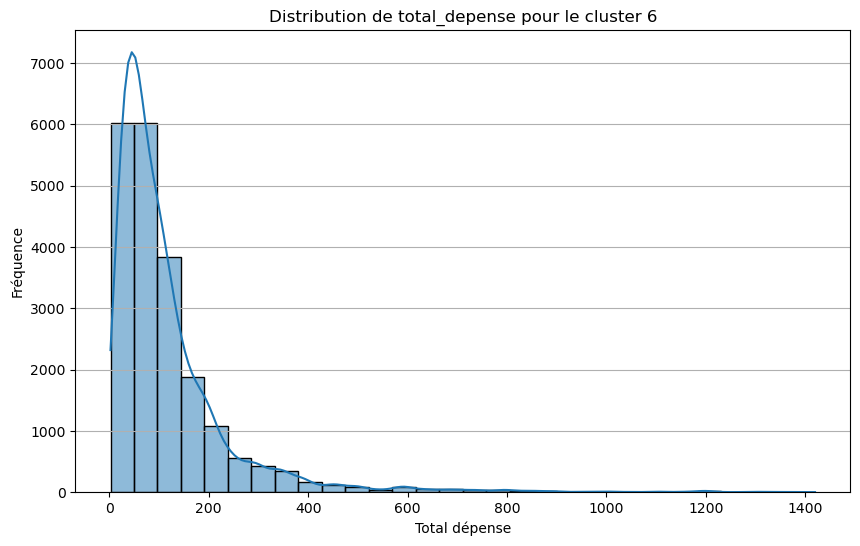

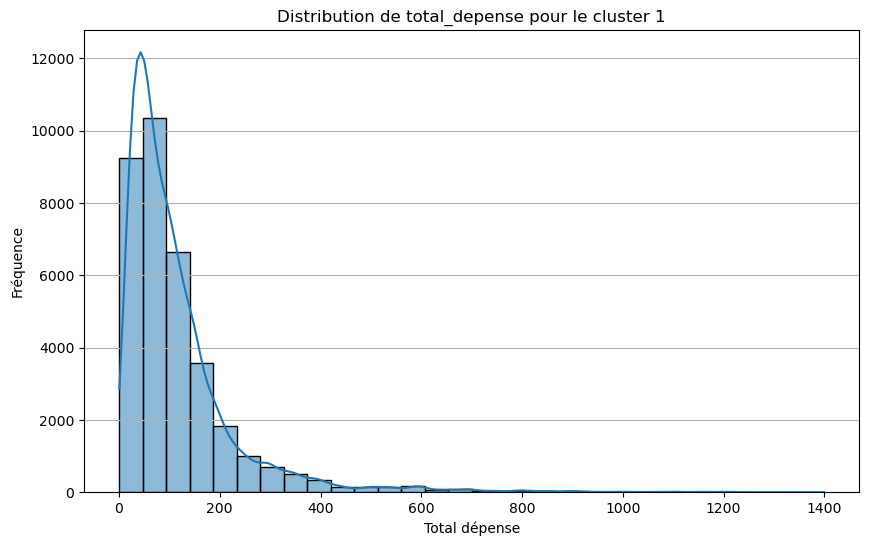

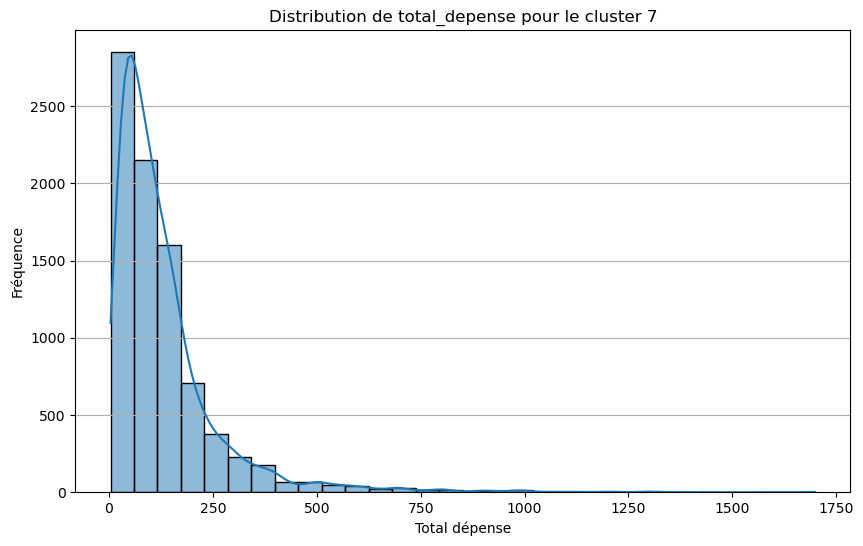

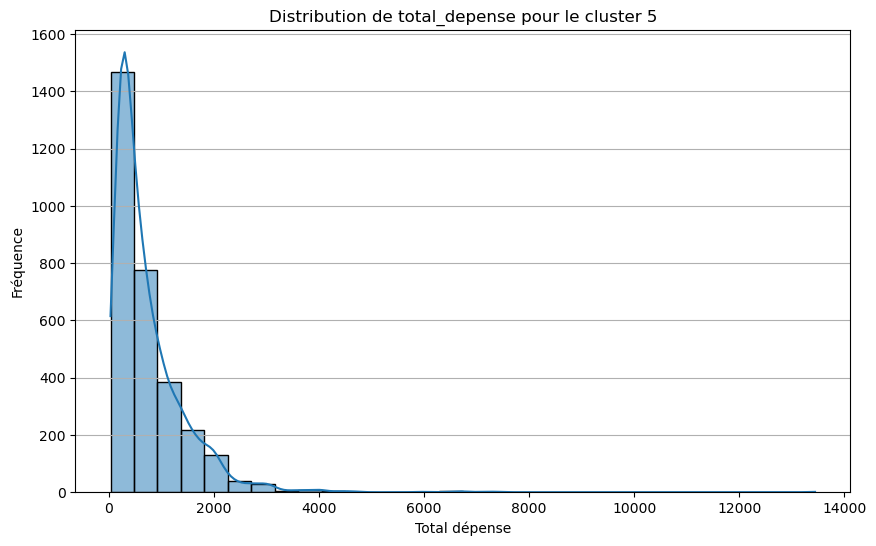

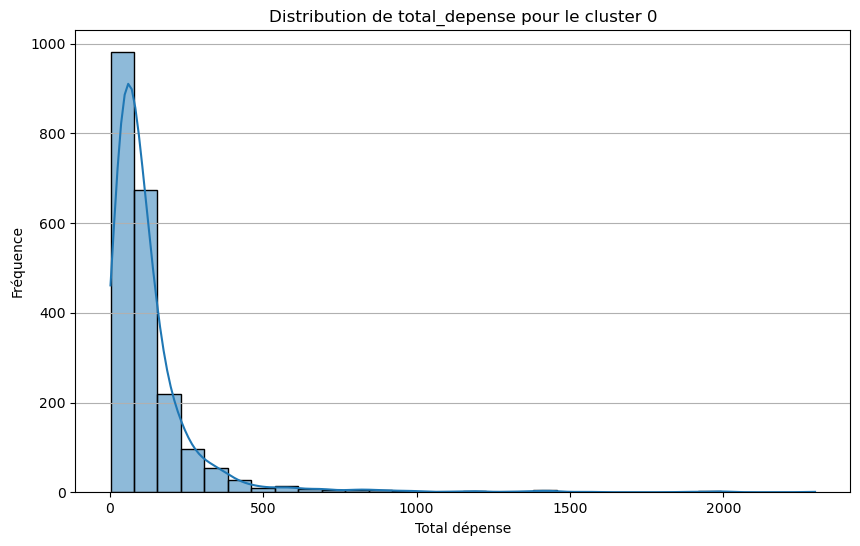

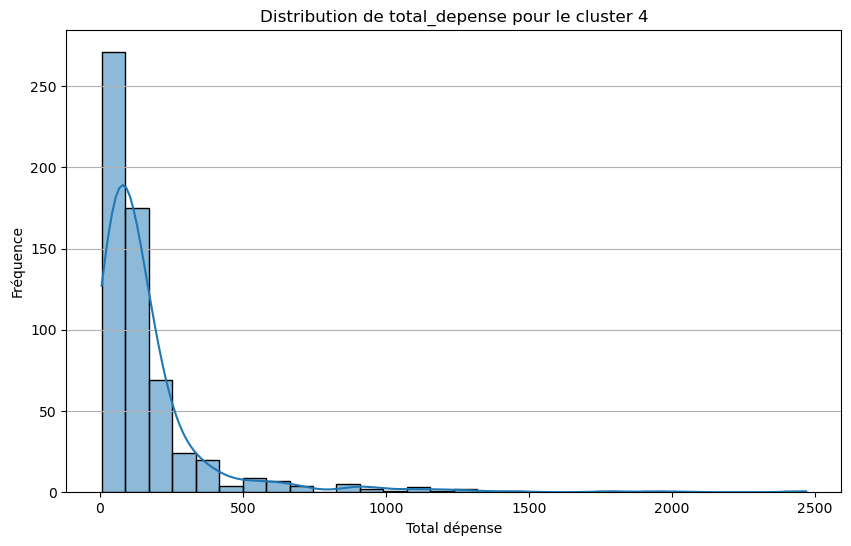

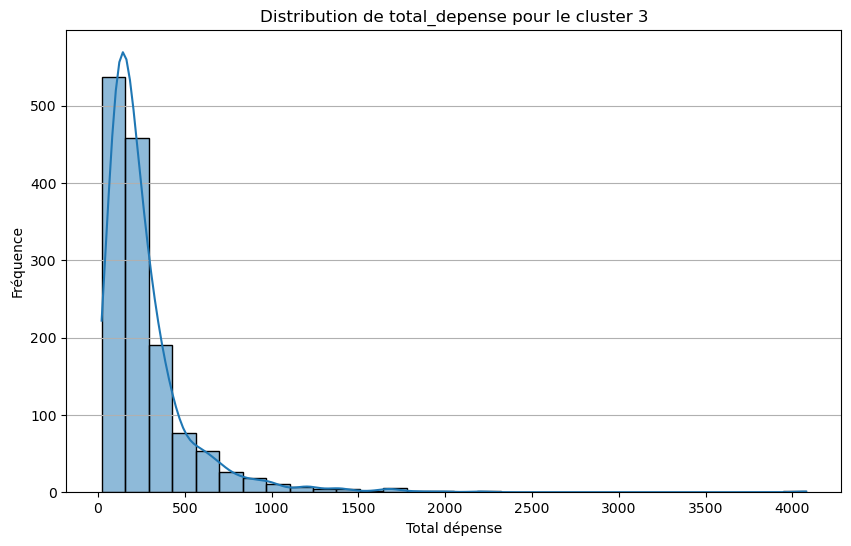

In [730]:
# Créer un graphique séparé pour chaque cluster
for cluster in df_encoded_5['cluster'].unique():
    plt.figure(figsize=(10, 6))
    # Filtrer les données pour chaque cluster
    cluster_data = df_encoded_5[df_encoded_5['cluster'] == cluster]['total_depense'].dropna()
    
    # Tracer l'histogramme avec KDE pour chaque cluster
    sns.histplot(cluster_data, kde=True, bins=30)
    
    # Ajouter des titres et des labels spécifiques
    plt.title(f"Distribution de total_depense pour le cluster {cluster}")
    plt.xlabel("Total dépense")
    plt.ylabel("Fréquence")
    plt.grid(axis='y')
    
    # Afficher le graphique
    plt.show()

In [46]:
def plot_single_variable_spider(data, variable, title):
    """
    Cette fonction trace un graphique radar (spider chart) pour visualiser 
    une seule variable à travers plusieurs clusters.

    Paramètres :
    - data : DataFrame pandas contenant les moyennes (ou valeurs représentatives) 
             par cluster pour différentes variables.
    - variable : Chaîne de caractères correspondant au nom de la variable à visualiser.
    - title : Titre du graphique.

    Le graphique permet de comparer la valeur d'une variable entre les différents clusters.
    """

    # Création des étiquettes pour chaque cluster
    labels = [f'Cluster {i}' for i in data.index] 
    num_clusters = len(labels)  # Nombre total de clusters à afficher

    # Initialisation du graphique en mode polaire (radar)
    fig = plt.figure(figsize=(8, 8))  # Taille du graphique
    ax = fig.add_subplot(111, polar=True)  # Sous-graphique polaire (radar chart)

    # Récupération des valeurs de la variable pour chaque cluster
    values = data[variable].values.tolist()  # Liste des valeurs pour la variable choisie
    values += values[:1]  # Ajoute la première valeur à la fin pour fermer le polygone

    # Création des angles pour chaque cluster (divise le cercle)
    angles = np.linspace(0, 2 * np.pi, num_clusters, endpoint=False).tolist()
    angles += angles[:1]  # Ajoute le premier angle à la fin pour fermer le cercle

    # Tracé de la ligne représentant les valeurs
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=variable)
    ax.fill(angles, values, alpha=0.25)  # Remplissage de la zone sous la ligne

    # Personnalisation des axes
    ax.set_yticks([])  # Supprime les cercles intermédiaires
    ax.set_xticks(angles[:-1])  # Positionne les étiquettes sur les axes
    ax.set_xticklabels(labels)  # Attribue les noms de clusters aux axes

    # Titre et légende
    plt.title(title)  # Titre du graphique
    plt.legend(loc='upper right')  # Légende en haut à droite
    plt.show()  # Affichage du graphique

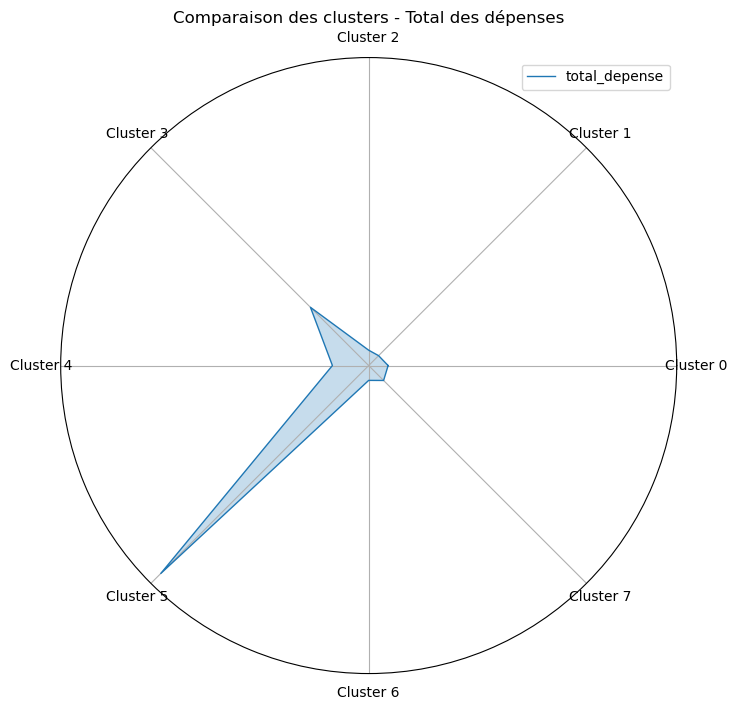

In [837]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'total_depense', "Comparaison des clusters - Total des dépenses")

**Dépense totale**
- Catégorie faible dépense : Clusters 0, 1, 2, 6, 7 (moyennes entre 115 et 131).
- Catégorie moyenne dépense : Cluster 4 (moyenne = 165.23).
- Catégorie dépense élevée: Cluster 3 (moyenne = 267.71)
- Catégorie dépense très élevée : Clusters 5 (moyenne = 738.29).

In [735]:
# Compter les occurrences pour chaque catégorie de récence
occurrences = df_encoded_5.groupby('cluster')[['recence_en_jours_cat_Très récent', 
                                             'recence_en_jours_cat_Ancien', 
                                             'recence_en_jours_cat_Modéré']].sum()

print("Occurrences par catégorie :")
occurrences.T

Occurrences par catégorie :


cluster                              0      1      2    3    4     5      6  \
recence_en_jours_cat_Très récent   451      0  21350  483   98   782      0   
recence_en_jours_cat_Ancien        645      0      0  214  176   800  20985   
recence_en_jours_cat_Modéré       1019  35158      0  699  327  1488      0   

cluster                              7  
recence_en_jours_cat_Très récent   407  
recence_en_jours_cat_Ancien        448  
recence_en_jours_cat_Modéré       7573

In [737]:
# Calculer les proportions par catégorie pour chaque cluster
proportions = occurrences.div(occurrences.sum(axis=1), axis=0)  * 100

print("Proportions par catégorie de récence (en %) :")
proportions.T

Proportions par catégorie de récence (en %) :


cluster                                   0      1      2          3  \
recence_en_jours_cat_Très récent  21.323877    0.0  100.0  34.598854   
recence_en_jours_cat_Ancien       30.496454    0.0    0.0  15.329513   
recence_en_jours_cat_Modéré       48.179669  100.0    0.0  50.071633   

cluster                                   4          5      6          7  
recence_en_jours_cat_Très récent  16.306156  25.472313    0.0   4.829141  
recence_en_jours_cat_Ancien       29.284526  26.058632  100.0   5.315615  
recence_en_jours_cat_Modéré       54.409318  48.469055    0.0  89.855244

In [844]:
def plot_clusters_spider(data, variables, title):
    """
    Cette fonction génère un graphique radar (spider chart) pour visualiser plusieurs 
    variables en fonction des clusters. Chaque variable est représentée par une ligne 
    reliant les clusters, permettant de comparer les profils des clusters pour un 
    ensemble de variables.

    Paramètres :
    - data : DataFrame pandas, contenant les valeurs (ex : moyennes par cluster) pour chaque variable.
             Les index doivent représenter les clusters.
    - variables : Liste de chaînes de caractères, correspondant aux variables à visualiser.
    - title : Chaîne de caractères, titre du graphique.

    Le graphique permet de voir l'évolution de plusieurs variables selon les clusters,
    chacun occupant une pointe du radar.
    """

    # Création des étiquettes pour les pointes du graphique radar (un par cluster)
    labels = [f'Cluster {i}' for i in data.index]
    num_clusters = len(labels)  # Nombre total de clusters

    # Initialisation du graphique radar
    fig = plt.figure(figsize=(8, 8))  # Définir la taille du graphique
    ax = fig.add_subplot(111, polar=True)  # Sous-graphique en mode polaire (radar)

    # Tracer une ligne pour chaque variable sélectionnée
    for variable in variables:
        values = data[variable].values.tolist()  # Récupère les valeurs de la variable
        values += values[:1]  # Boucle les valeurs pour fermer le polygone

        # Génère les angles pour chaque cluster autour du cercle
        angles = np.linspace(0, 2 * np.pi, num_clusters, endpoint=False).tolist()
        angles += angles[:1]  # Boucle les angles pour fermer le polygone

        # Trace la ligne représentant la variable
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=variable)
        ax.fill(angles, values, alpha=0.25)  # Remplit l'intérieur de la ligne

    # Personnalisation du graphique
    ax.set_yticks([])  # Supprime les cercles de valeurs intermédiaires
    ax.set_xticks(angles[:-1])  # Position des étiquettes autour du cercle
    ax.set_xticklabels(labels)  # Affiche les noms des clusters sur les pointes

    # Titre et légende
    plt.title(title)  # Titre du graphique
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))  # Position de la légende
    plt.show()  # Affiche le graphique

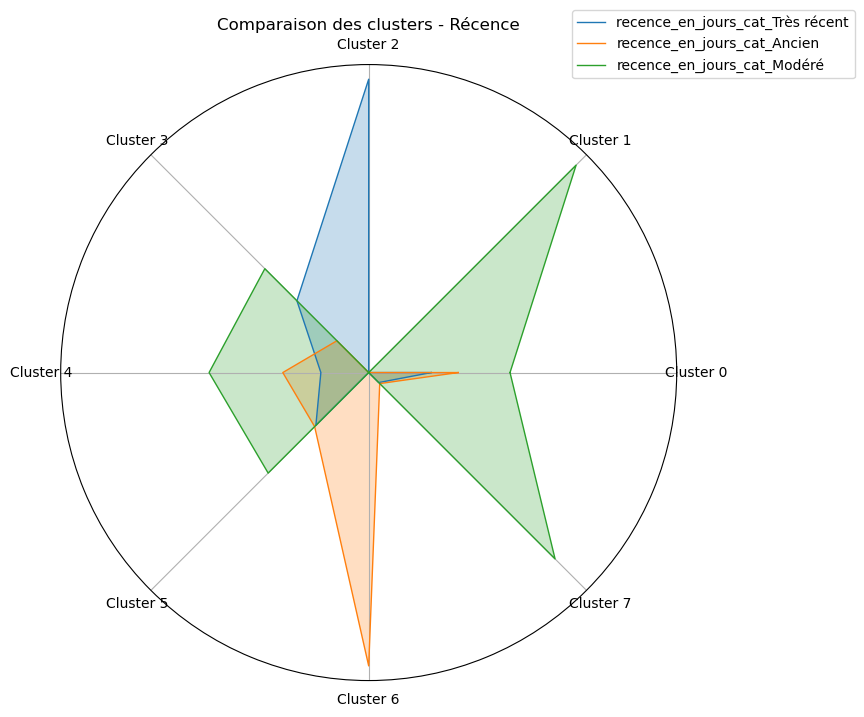

In [845]:
# Liste des variables de récence
recence_vars = ['recence_en_jours_cat_Très récent', 
                'recence_en_jours_cat_Ancien', 
                'recence_en_jours_cat_Modéré']

# Tracer le spider chart avec clusters sur les pointes et récence comme dimensions internes
plot_clusters_spider(df_scaled_mean, recence_vars, "Comparaison des clusters - Récence")

**Récence**
- Clients Anciens : Cluster 6
- Clients Récence moyenne : Cluster 1, 7
- Clients très récents : Cluster 2
- Clients Récence moyenne à très récent : Cluster 3
- Clients Anciens à récence moyenne: Cluster 4
- Récence mixte : Cluster 5
- Clusters mixtes avec récence plutot moyenne : Cluster 0

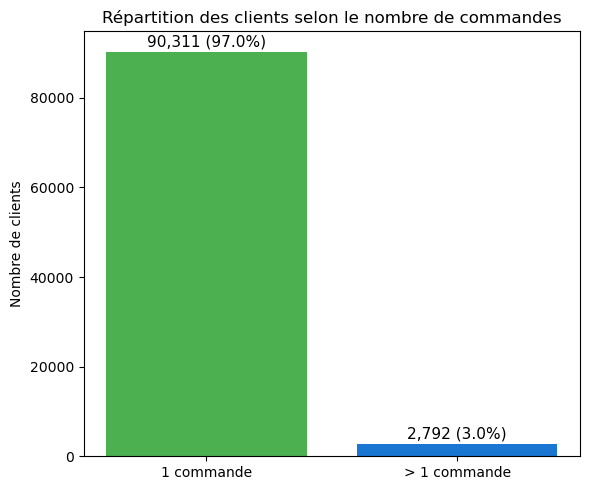

In [64]:
# Création d'une colonne binaire : 1 commande ou plus d'1 commande
df_encoded_5['type_client'] = df_encoded_5['nb_commandes'].apply(lambda x: '1 commande' if x == 1 else '> 1 commande')

# Comptage des effectifs
counts = df_encoded_5['type_client'].value_counts().sort_index()
total = counts.sum()

# Affichage du barplot
plt.figure(figsize=(6,5))
bars = plt.bar(counts.index, counts.values, color=['#4CAF50', '#1976D2'])
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients selon le nombre de commandes')
plt.xticks(rotation=0)

# Annoter les valeurs sur les barres avec nombre et pourcentage
for bar in bars:
    yval = bar.get_height()
    label = f"{int(yval):,} ({yval/total*100:.1f}%)"
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, label, ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# Suppression de la colonne temporaire
df_encoded_5.drop(columns=['type_client'], inplace=True)

In [738]:
# Répartition complète du nombre de commandes par cluster
repartition_commandes = df_encoded_5.groupby(['cluster', 'nb_commandes']).size().unstack(fill_value=0)

print("Répartition du nombre de commandes par cluster :")
print(repartition_commandes)

Répartition du nombre de commandes par cluster :
nb_commandes     1     2    3   4   5   6   7   9   15
cluster                                               
0              2055    58    2   0   0   0   0   0   0
1             34597   561    0   0   0   0   0   0   0
2             21073   277    0   0   0   0   0   0   0
3                 0  1171  178  28   9   5   3   1   1
4               592     9    0   0   0   0   0   0   0
5              3010    60    0   0   0   0   0   0   0
6             20653   332    0   0   0   0   0   0   0
7              8331    97    0   0   0   0   0   0   0


In [783]:
# Calculer les proportions par catégorie pour chaque cluster
proportions = repartition_commandes.div(repartition_commandes.sum(axis=1), axis=0)  * 100

print("Proportions par nombre de commandes (en %) :")
proportions.round(2)

Proportions par nombre de commandes (en %) :


nb_commandes     1      2      3     4     5     6     7     9     15
cluster                                                              
0             97.16   2.74   0.09  0.00  0.00  0.00  0.00  0.00  0.00
1             98.40   1.60   0.00  0.00  0.00  0.00  0.00  0.00  0.00
2             98.70   1.30   0.00  0.00  0.00  0.00  0.00  0.00  0.00
3              0.00  83.88  12.75  2.01  0.64  0.36  0.21  0.07  0.07
4             98.50   1.50   0.00  0.00  0.00  0.00  0.00  0.00  0.00
5             98.05   1.95   0.00  0.00  0.00  0.00  0.00  0.00  0.00
6             98.42   1.58   0.00  0.00  0.00  0.00  0.00  0.00  0.00
7             98.85   1.15   0.00  0.00  0.00  0.00  0.00  0.00  0.00

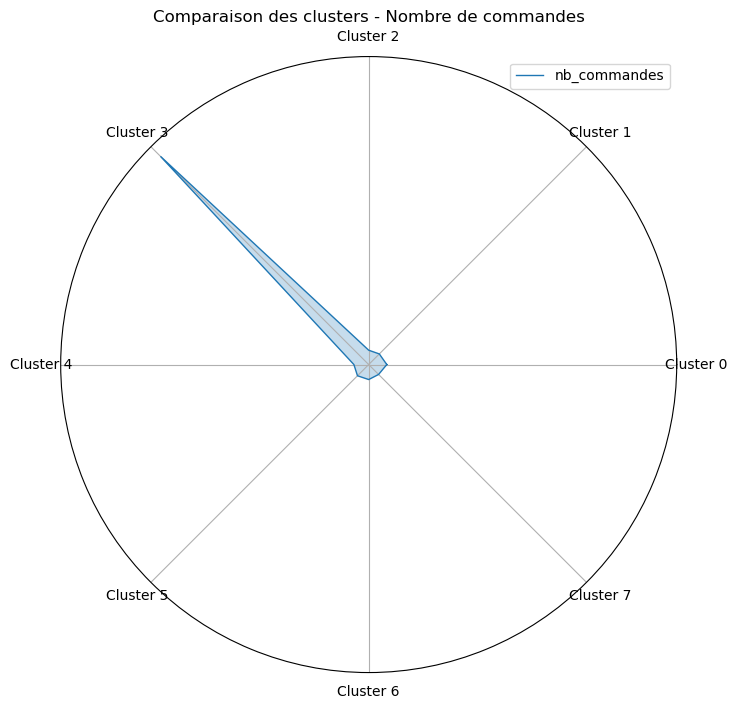

In [838]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'nb_commandes', "Comparaison des clusters - Nombre de commandes")

**Nombre de commandes**
- 1 commande : Clusters 0, 1, 2, 4, 5, 6, 7
- Plus d'une commandes : Cluster 3


| Cluster | Dépense totale        | Récence                                 | Nombre de commandes       |
|:--------|:-----------------------|:-----------------------------------------|:---------------------------|
| 0       | Faible dépense         | Mixte, plutôt moyenne                    | 1 commande                 |
| 1       | Faible dépense         | Récence moyenne                          | 1 commande                 |
| 2       | Faible dépense         | Très récents                             | 1 commande                 |
| 3       | Forte dépense          | Moyenne à très récent                    | Plus d'une commande        |
| 4       | Moyenne dépense        | Anciens à récence moyenne                | 1 commande                 |
| 5       | Très forte dépense          | Récence mixte                            | 1 commande                 |
| 6       | Faible dépense         | Anciens                                  | 1 commande                 |
| 7       | Faible dépense         | Récence moyenne                          | 1 commande                 |

### Variables liées à la livraison

In [767]:
# Describe des variables par cluster
df_encoded_5.groupby('cluster')[livraison].describe().T.round(2)

cluster                              0         1         2        3       4  \
total_retards_livraison count  2115.00  35158.00  21350.00  1396.00  601.00   
                        mean    -12.81    -12.86    -13.14   -28.40   -6.41   
                        std      10.79      7.17      9.31    18.46   17.28   
                        min    -142.00   -147.00    -75.00  -147.00  -47.00   
                        25%     -18.00    -17.00    -19.00   -36.00  -15.00   
                        50%     -13.00    -13.00    -12.00   -27.00  -10.00   
                        75%      -8.00     -8.00     -7.00   -18.00    0.00   
                        max     121.00     26.00     58.00    86.00  181.00   
frais_livraison_moyens  count  2115.00  35158.00  21350.00  1396.00  601.00   
                        mean     22.36     19.31     21.47    22.23   25.99   
                        std      16.83     11.16     13.82    13.89   25.99   
                        min       0.00      0.00      0.00     5.03    0.00   
                        25%      14.10     13.37     13.47    14.61   14.52   
                        50%      17.63     16.32     18.31    17.94   18.30   
                        75%      23.77     21.42     23.75    25.90   27.42   
                        max     191.95    128.15    121.95   154.98  288.80   

cluster                              5         6        7  
total_retards_livraison count  3070.00  20985.00  8428.00  
                        mean    -13.13    -14.67     0.97  
                        std      10.66      8.30    17.27  
                        min     -78.00   -140.00   -38.00  
                        25%     -19.00    -18.00   -10.00  
                        50%     -13.00    -14.00     0.00  
                        75%      -8.00    -10.00     8.00  
                        max      96.00     49.00   188.00  
frais_livraison_moyens  count  3070.00  20985.00  8428.00  
                        mean     90.58     19.60    23.72  
                        std      68.16     10.46    14.71  
                        min       0.00      0.00     0.00  
                        25%      53.17     14.10    15.10  
                        50%      75.33     16.32    18.23  
                        75%     107.58     21.88    28.20  
                        max    1794.96    124.80   136.60

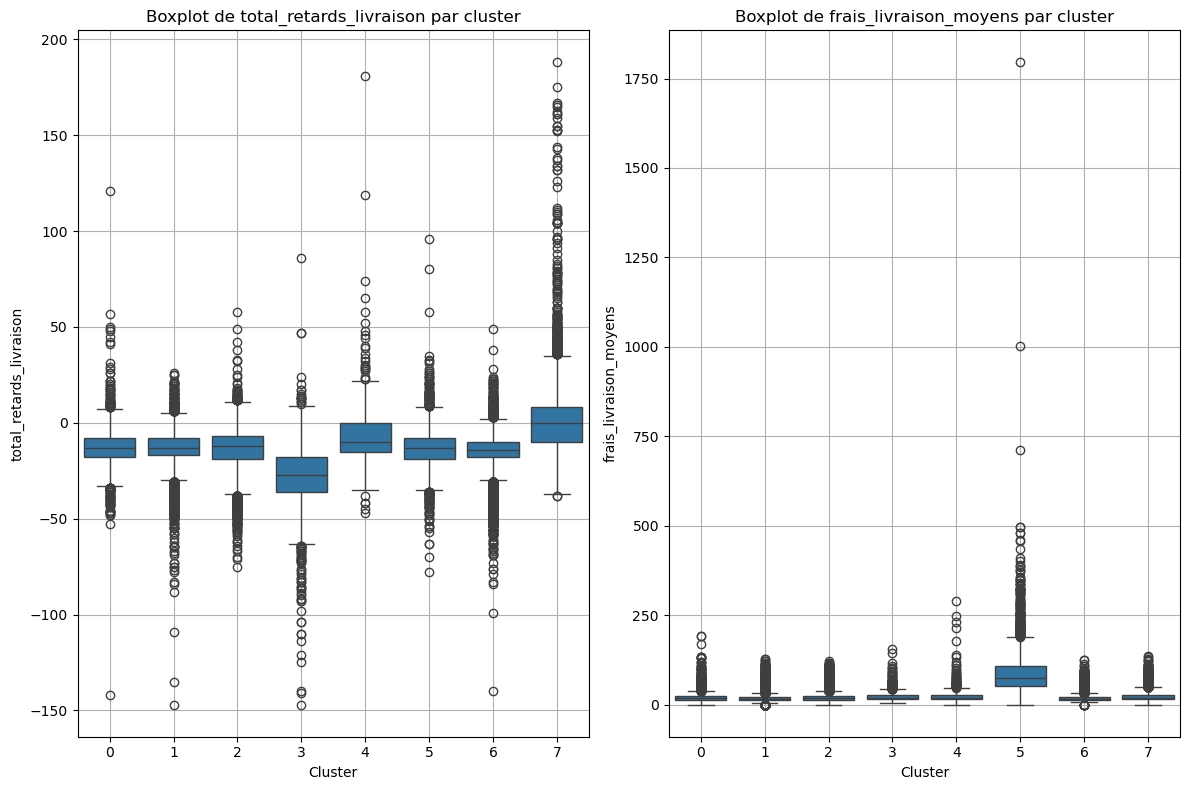

In [745]:
# Création des boxplots pour chaque variable de livraison par cluster
plt.figure(figsize=(12, 8))

for i, var in enumerate(livraison, 1):
    plt.subplot(1, 2, i)  # 2 lignes, 2 colonnes
    sns.boxplot(x='cluster', y=var, data=df_encoded_5)
    plt.title(f"Boxplot de {var} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)

plt.tight_layout()
plt.show()

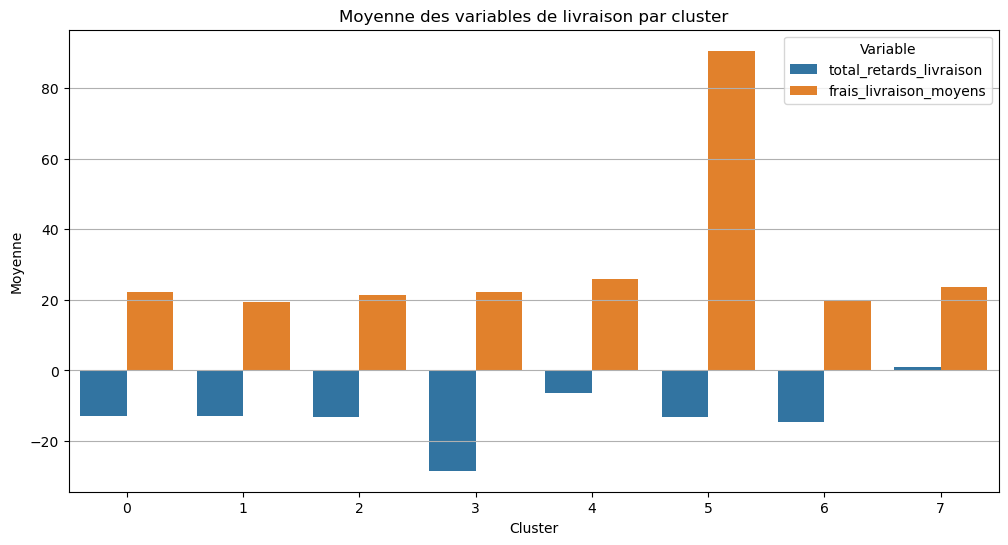

In [768]:
# Calcul de la moyenne pour chaque variable de livraison par cluster
mean_livraison = df_encoded_5.groupby('cluster')[livraison].mean()

# Réformatage des données pour un barplot côte à côte
mean_livraison = mean_livraison.reset_index()

# Transformation des données pour un format long
mean_livraison_melted = mean_livraison.melt(id_vars='cluster', 
                                            var_name='Variable', 
                                            value_name='Moyenne')

# Création du barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='Moyenne', hue='Variable', data=mean_livraison_melted)
plt.title("Moyenne des variables de livraison par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne")
plt.grid(axis='y')
plt.legend(title='Variable')
plt.show()

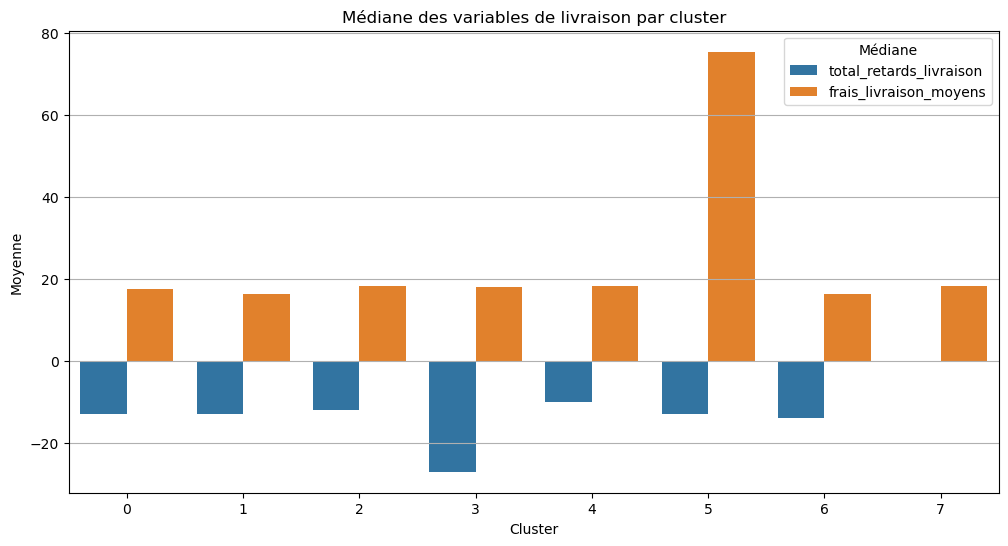

In [769]:
# Calcul de la médiane pour chaque variable de livraison par cluster
med_livraison = df_encoded_5.groupby('cluster')[livraison].median()

# Réformatage des données pour un barplot côte à côte
med_livraison = med_livraison.reset_index()

# Transformation des données pour un format long
med_livraison_melted = med_livraison.melt(id_vars='cluster', 
                                        var_name='Variable', 
                                        value_name='Médiane')

# Création du barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='Médiane', hue='Variable', data=med_livraison_melted)
plt.title("Médiane des variables de livraison par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne")
plt.grid(axis='y')
plt.legend(title='Médiane')
plt.show()

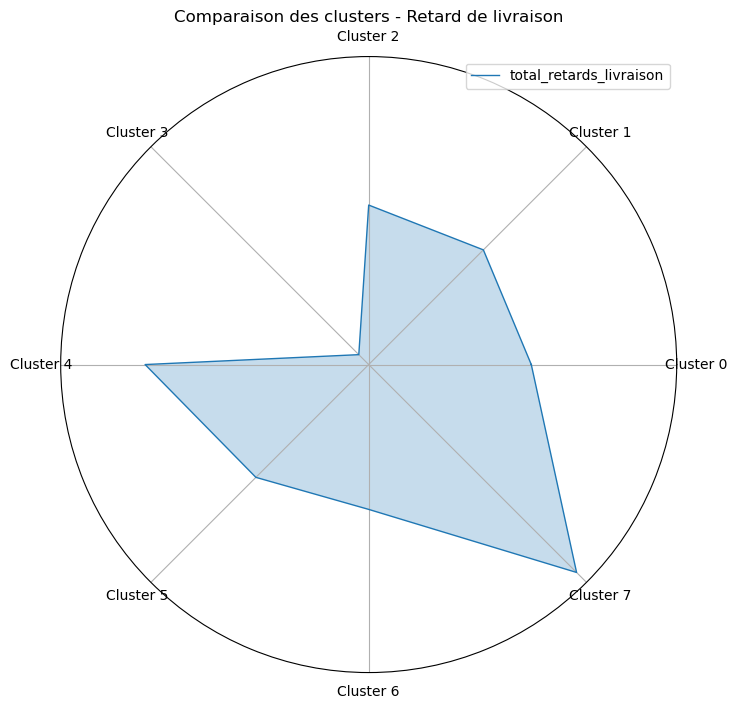

In [839]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'total_retards_livraison', "Comparaison des clusters - Retard de livraison")

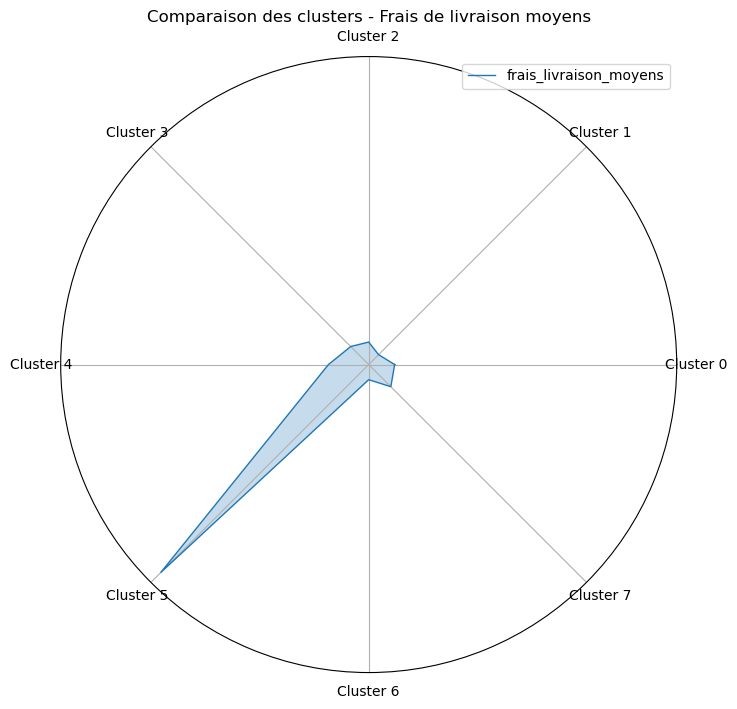

In [840]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'frais_livraison_moyens', "Comparaison des clusters - Frais de livraison moyens")

**Retard de livraison**
- Cluster 0, 1, 2, 5, 6	=> Clients livrés à l’heure ou en avance
- Cluster 3	=> Clients avec livraisons très en avance
- Cluster 4	=> Clients avec livraisons moyennes, parfois en retard
- Cluster 7	=> Clients livrés en retard

**Frais de livraison**
- Clusters 1, 6	=> Frais faibles
- Clusters 0, 2, 3, 7 => Frais modérés
- Cluster 4 => Frais élevés
- Cluster 5	=> Frais très élevés

| Cluster | Récence                                      | Dépense totale        | Nombre de commandes      | Retards de livraison | Frais de livraison   |
|:--------|:---------------------------------------------|:-----------------------|:--------------------------|:---------------------|:---------------------|
| 0       | Mixte, plutôt récence moyenne                | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        |
| 1       | Récence moyenne                              | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        |
| 2       | Très récents                                 | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        |
| 3       | Récence moyenne à très récents               | Forte                  | Plus d'une commande       | Livraison très en avance       | Frais modérés        |
| 4       | Anciens à récence moyenne                    | Moyenne                | 1 commande                | Livraison moyenne, parfois en retard    | Frais élevés         |
| 5       | Récence mixte                                | Très forte                  | 1 commande                | Livraison à l’heure ou en avance      | Frais très élevés    |
| 6       | Anciens                                      | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        |
| 7       | Récence moyenne                              | Faible                 | 1 commande                | Retards fréquents    | Frais modérés        |

### Variables liées aux produits

In [786]:
df_encoded_5.groupby('cluster')['poids_moyen_commandes'].describe()

count          mean           std   min       25%      50%  \
cluster                                                                 
0         2115.0   2318.393302   4080.092837  50.0    350.00    850.0   
1        35158.0   1770.184510   2677.906583   2.0    300.00    650.0   
2        21350.0   1617.336253   2513.366033   2.0    300.00    600.0   
3         1396.0   2228.127716   2997.214878  75.0    484.00   1025.0   
4          601.0   3016.118136   5379.680439  50.0    400.00   1100.0   
5         3070.0  18410.988925  13400.078189  50.0  10800.00  16575.0   
6        20985.0   1956.212747   3008.809557  50.0    300.00    800.0   
7         8428.0   2171.515959   3293.969765  50.0    328.25    800.0   

              75%       max  
cluster                      
0         2037.50   40900.0  
1         1800.00   24700.0  
2         1650.00   23950.0  
3         2693.75   24975.0  
4         2900.00   60000.0  
5        23250.00  184400.0  
6         1900.00   25800.0  
7         2350.00   30000.0

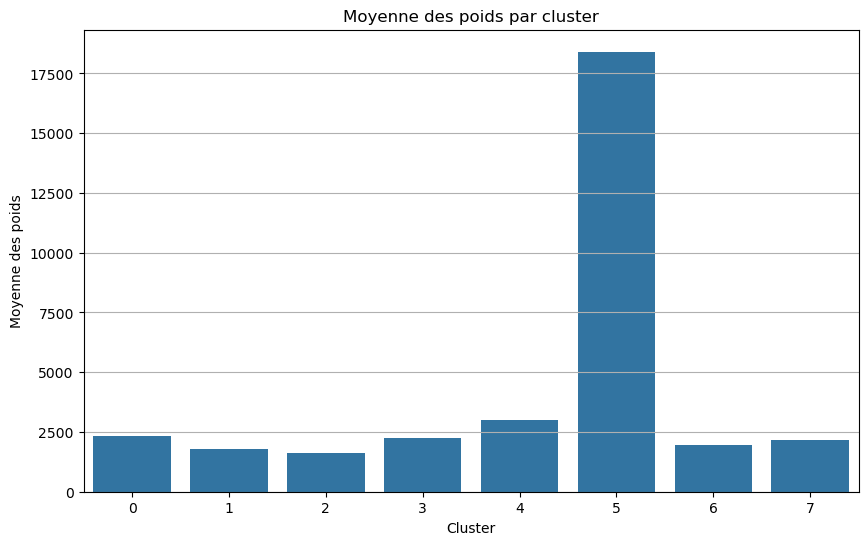

In [771]:
# Calcul de la moyenne des dépenses par cluster
mean_poids = df_encoded_5.groupby('cluster')['poids_moyen_commandes'].mean()

# Barplot des moyennes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_poids .index, y=mean_poids.values)
plt.title("Moyenne des poids par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des poids")
plt.grid(axis='y')
plt.show()

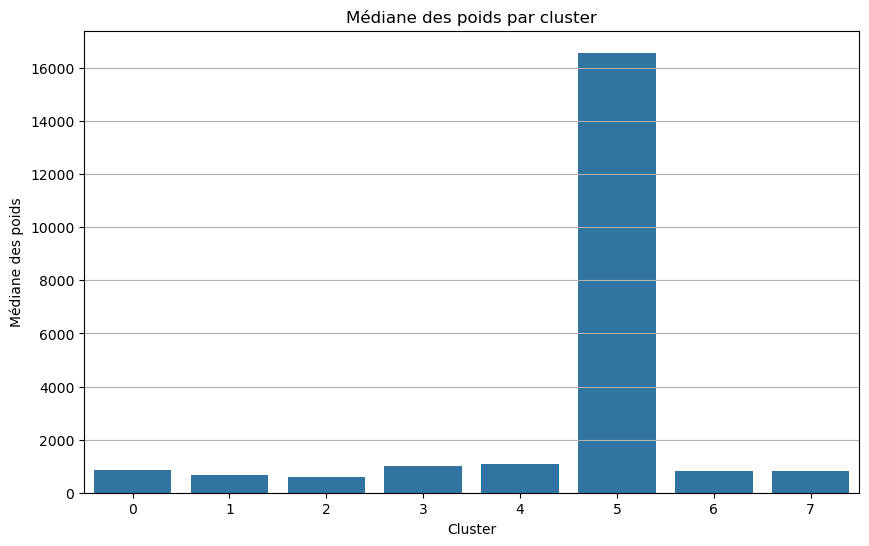

In [772]:
# Calcul de la moyenne des dépenses par cluster
med_poids = df_encoded_5.groupby('cluster')['poids_moyen_commandes'].median()

# Barplot des moyennes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=med_poids .index, y=med_poids.values)
plt.title("Médiane des poids par cluster")
plt.xlabel("Cluster")
plt.ylabel("Médiane des poids")
plt.grid(axis='y')
plt.show()

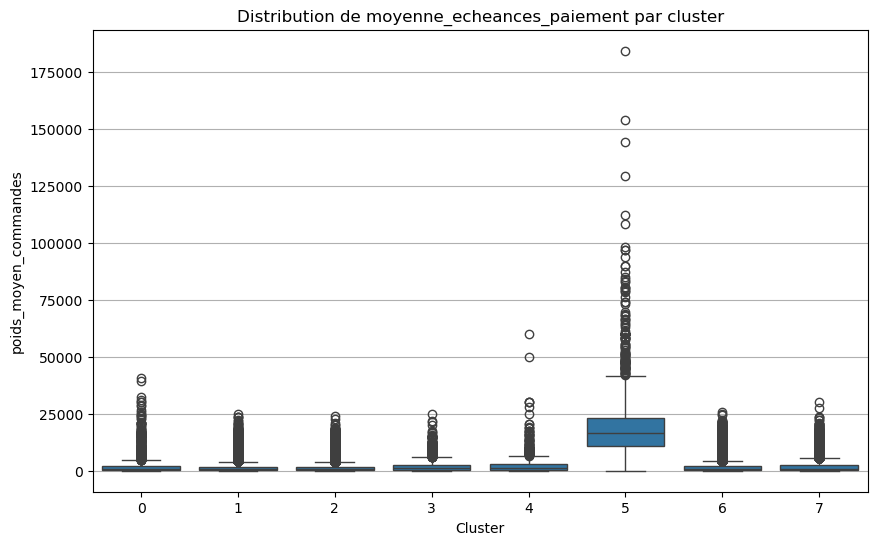

In [773]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='poids_moyen_commandes', data=df_encoded_5)
plt.title(f"Distribution de moyenne_echeances_paiement par cluster")
plt.xlabel("Cluster")
plt.grid(axis='y')
plt.show()

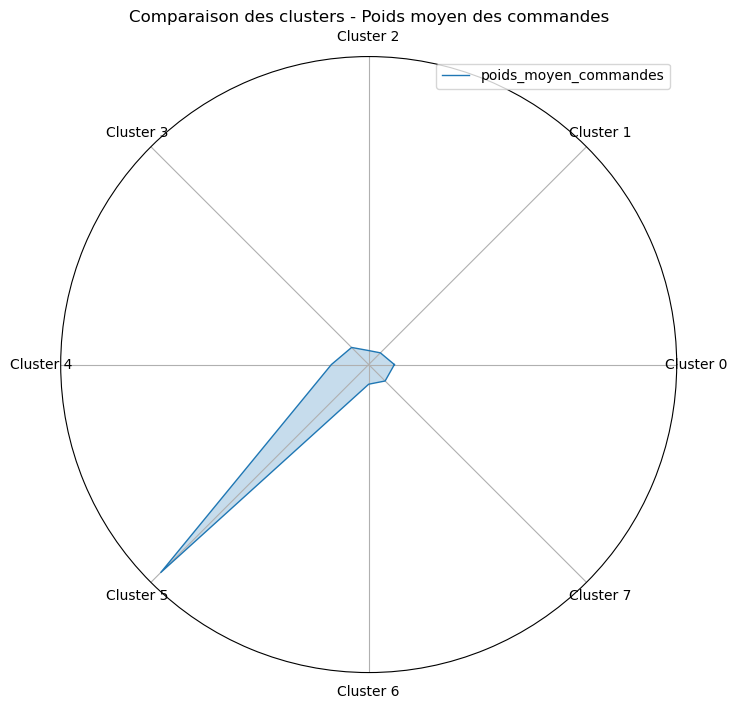

In [841]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'poids_moyen_commandes', "Comparaison des clusters - Poids moyen des commandes")

**Poids des commandes**
- Clusters 1, 2 => Poids faible.
- Clusters 0, 3, 6, 7 => Poids modéré.
- Clusters 4 => Poids élevé.
- Cluster 5 => Poids très élevé.

In [777]:
# Création du tableau croisé
pivot = df_encoded_5.groupby(['cluster', 'diversite_categories']).size().unstack(fill_value=0)
pivot.T

cluster                  0      1      2     3    4     5      6     7
diversite_categories                                                  
1                     2115  35158  21350    86  598  3070  20985  8428
2                        0      0      0  1261    3     0      0     0
3                        0      0      0    42    0     0      0     0
4                        0      0      0     6    0     0      0     0
5                        0      0      0     1    0     0      0     0

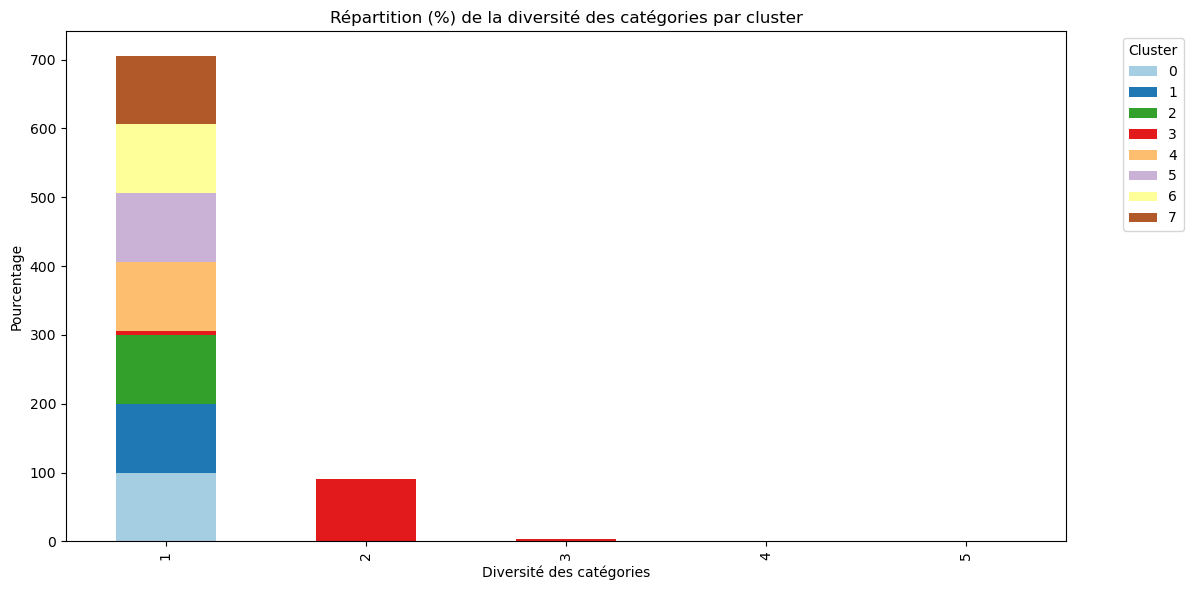

In [779]:
# Normalisation en pourcentage par cluster
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

pivot_pct.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Paired')
plt.title("Répartition (%) de la diversité des catégories par cluster")
plt.xlabel("Diversité des catégories")
plt.ylabel("Pourcentage")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

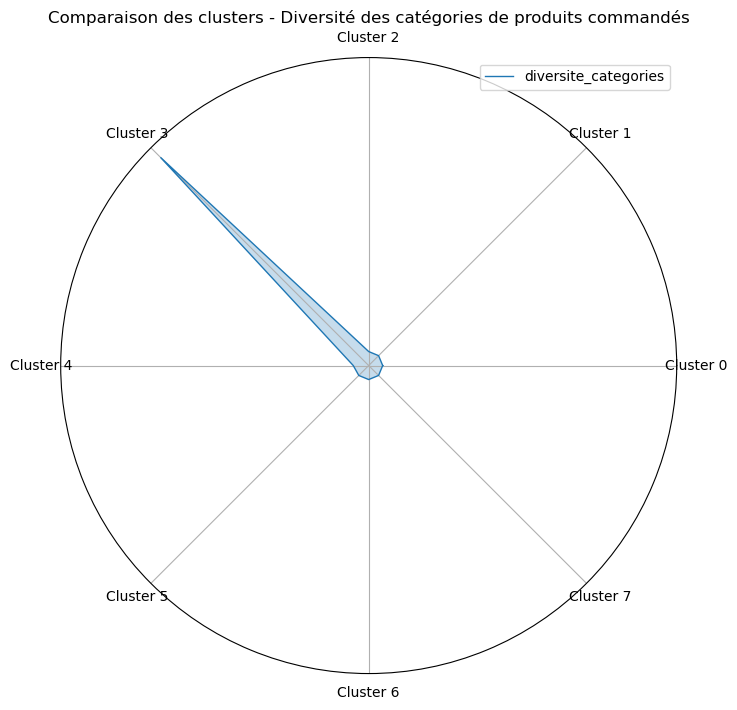

In [830]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'diversite_categories', "Comparaison des clusters - Diversité des catégories de produits commandés")

**Diversité des catégories commandées**
- Cluster 0, 1, 2, 4, 5, 6, 7 => 100% des commandes sur 1 seule catégorie de produits
- Cluster 3 => Commandes diversifiées



| Cluster | Récence                                      | Dépense totale        | Nombre de commandes      | Retards de livraison | Frais de livraison   | Poids moyen commandes | Diversité des catégories commandées                  |
|:--------|:---------------------------------------------|:-----------------------|:--------------------------|:---------------------|:---------------------|:-----------------------|:-----------------------------------------------------|
| 0       | Mixte, plutôt récence moyenne                | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        | Poids modéré           | Commandes sur 1 seule catégorie                      |
| 1       | Récence moyenne                              | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        | Poids faible           | Commandes sur 1 seule catégorie                      |
| 2       | Très récents                                 | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        | Poids faible           | Commandes sur 1 seule catégorie                      |
| 3       | Récence moyenne à très récents               | Forte                  | Plus d'une commande       | Livraison très en avance       | Frais modérés        | Poids modéré           | Commandes diversifiées                               |
| 4       | Anciens à récence moyenne                    | Moyenne                | 1 commande                | Livraison moyenne, parfois en retard    | Frais élevés         | Poids élevé            | Commandes sur 1 seule catégorie                      |
| 5       | Récence mixte                                | Très forte                  | 1 commande                | Livraison à l’heure ou en avance      | Frais très élevés    | Poids très élevé       | Commandes sur 1 seule catégorie                      |
| 6       | Anciens                                      | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        | Poids modéré           | Commandes sur 1 seule catégorie                      |
| 7       | Récence moyenne                              | Faible                 | 1 commande                | Retards fréquents    | Frais modérés        | Poids modéré           | Commandes sur 1 seule catégorie                      |

### Variables liées au paiement

In [789]:
df_encoded_5.groupby('cluster')['nb_paiements_total'].describe().round(2)

count  mean   std  min  25%  50%  75%   max
cluster                                               
0         2115.0  2.60  1.90  2.0  2.0  2.0  2.0  33.0
1        35158.0  1.02  0.17  1.0  1.0  1.0  1.0   4.0
2        21350.0  1.02  0.16  1.0  1.0  1.0  1.0   4.0
3         1396.0  2.35  0.94  2.0  2.0  2.0  2.0  15.0
4          601.0  1.06  0.30  1.0  1.0  1.0  1.0   5.0
5         3070.0  1.04  0.22  1.0  1.0  1.0  1.0   6.0
6        20985.0  1.03  0.18  1.0  1.0  1.0  1.0   4.0
7         8428.0  1.02  0.18  1.0  1.0  1.0  1.0   5.0

In [785]:
# Boucle sur chaque variable
for var in paiement:
    print(f"\n# Répartition de {var} par cluster ------------------")
    repartition = df_encoded_5.groupby(['cluster', var]).size().unstack(fill_value=0)
    print(repartition.T)


# Répartition de diversite_max_paiements par cluster ------------------
cluster                     0      1      2     3    4     5      6     7
diversite_max_paiements                                                  
1                          62  35158  21350  1323  586  3068  20985  8428
2                        2053      0      0    73   15     2      0     0

# Répartition de nb_paiements_total par cluster ------------------
cluster                0      1      2     3    4     5      6     7
nb_paiements_total                                                  
1                      0  34372  20930     0  571  2960  20490  8259
2                   1666    748    390  1092   25   106    458   151
3                    221     22     24   218    4     2     23    11
4                     70     16      6    45    0     1     14     5
5                     48      0      0    19    1     0      0     2
6                     38      0      0    10    0     1      0     0
7          

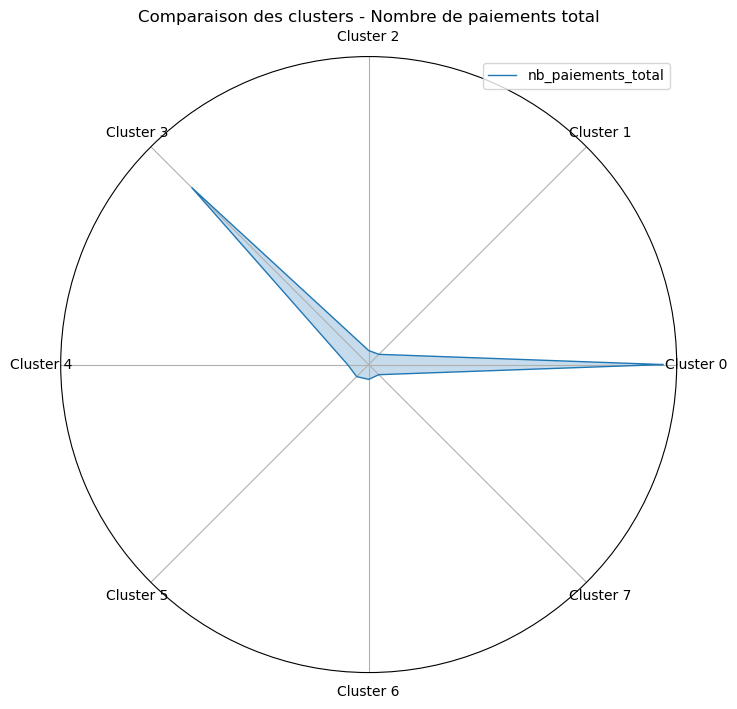

In [842]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'nb_paiements_total', "Comparaison des clusters - Nombre de paiements total")

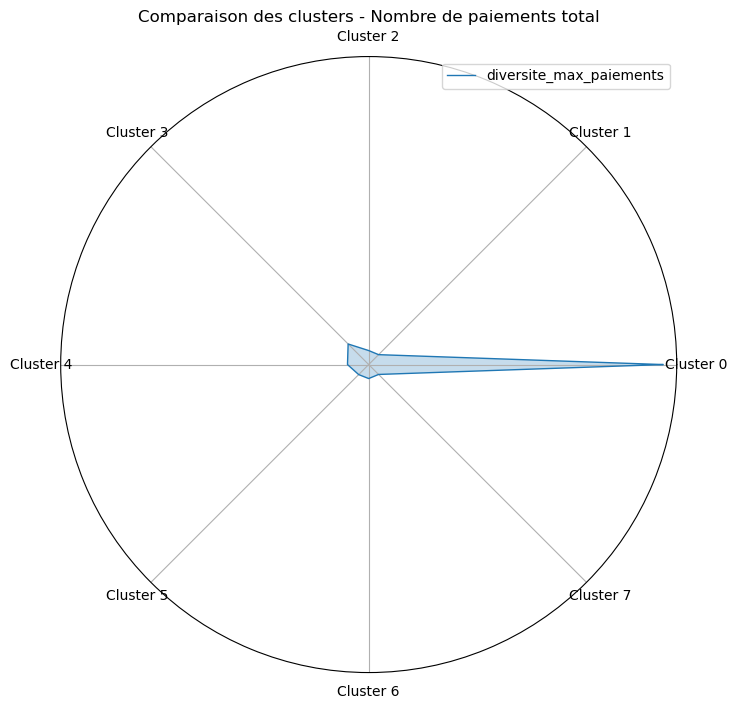

In [843]:
plot_single_variable_spider(df_encoded_5.groupby('cluster').mean(),
                            'diversite_max_paiements', "Comparaison des clusters - Nombre de paiements total")

**Diversité maximum de paiements**
- cluster 1, 2, 3, 4, 5, 6, 7 => Clients homogènes
- cluster 0 =>  Clients diversifiés

**Nombre de paiement pour une commande**
- Clusters 1, 2, 4, 5, 6, 7 => Paiement unique
- Cluster 0, 3 => Paiement multiple

| Cluster | Récence                                      | Dépense totale        | Nombre de commandes      | Retards de livraison | Frais de livraison   | Poids moyen commandes | Diversité des catégories commandées                  | Diversité maximum de paiements  | Nombre de paiement pour les commandes |
|:--------|:---------------------------------------------|:-----------------------|:--------------------------|:---------------------|:---------------------|:-----------------------|:-----------------------------------------------------|:---------------------------------|:-------------------------------------|
| 0       | Mixte, plutôt récence moyenne                | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        | Poids modéré           | Commandes sur 1 seule catégorie                      | Clients diversifiés              | Paiement multiple                     |
| 1       | Récence moyenne                              | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        | Poids faible           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       |
| 2       | Très récents                                 | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        | Poids faible           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       |
| 3       | Récence moyenne à très récents               | Forte                  | Plus d'une commande       | Livraison très en avance       | Frais modérés        | Poids modéré           | Commandes diversifiées                               | Clients homogènes                | Paiement multiple                     |
| 4       | Anciens à récence moyenne                    | Moyenne                | 1 commande                | Livraison moyenne, parfois en retard    | Frais élevés         | Poids élevé            | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       |
| 5       | Récence mixte                                | Très forte                  | 1 commande                | Livraison à l’heure ou en avance      | Frais très élevés    | Poids très élevé       | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       |
| 6       | Anciens                                      | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        | Poids modéré           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       |
| 7       | Récence moyenne                              | Faible                 | 1 commande                | Retards fréquents    | Frais modérés        | Poids modéré           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       |

### Variables liées à la satisfaction client

In [749]:
df_encoded_5.groupby('cluster')[satisfaction_client].describe().T.round(2)

cluster                          0         1         2        3      4  \
note_moyenne_client count  2115.00  35158.00  21350.00  1396.00  601.0   
                    mean      4.13      4.60      4.36     4.28    4.0   
                    std       1.27      0.63      1.09     0.97    0.0   
                    min       1.00      1.00      1.00     1.00    4.0   
                    25%       4.00      4.00      4.00     4.00    4.0   
                    50%       5.00      5.00      5.00     4.67    4.0   
                    75%       5.00      5.00      5.00     5.00    4.0   
                    max       5.00      5.00      5.00     5.00    4.0   
a_donne_une_note    count  2115.00  35158.00  21350.00  1396.00  601.0   
                    mean      1.00      1.00      1.00     1.00    0.0   
                    std       0.00      0.00      0.00     0.00    0.0   
                    min       1.00      1.00      1.00     1.00    0.0   
                    25%       1.00      1.00      1.00     1.00    0.0   
                    50%       1.00      1.00      1.00     1.00    0.0   
                    75%       1.00      1.00      1.00     1.00    0.0   
                    max       1.00      1.00      1.00     1.00    0.0   

cluster                          5         6        7  
note_moyenne_client count  3070.00  20985.00  8428.00  
                    mean      3.88      4.30     1.48  
                    std       1.47      1.12     0.78  
                    min       1.00      1.00     1.00  
                    25%       3.00      4.00     1.00  
                    50%       5.00      5.00     1.00  
                    75%       5.00      5.00     2.00  
                    max       5.00      5.00     5.00  
a_donne_une_note    count  3070.00  20985.00  8428.00  
                    mean      1.00      1.00     1.00  
                    std       0.02      0.00     0.00  
                    min       0.00      1.00     1.00  
                    25%       1.00      1.00     1.00  
                    50%       1.00      1.00     1.00  
                    75%       1.00      1.00     1.00  
                    max       1.00      1.00     1.00

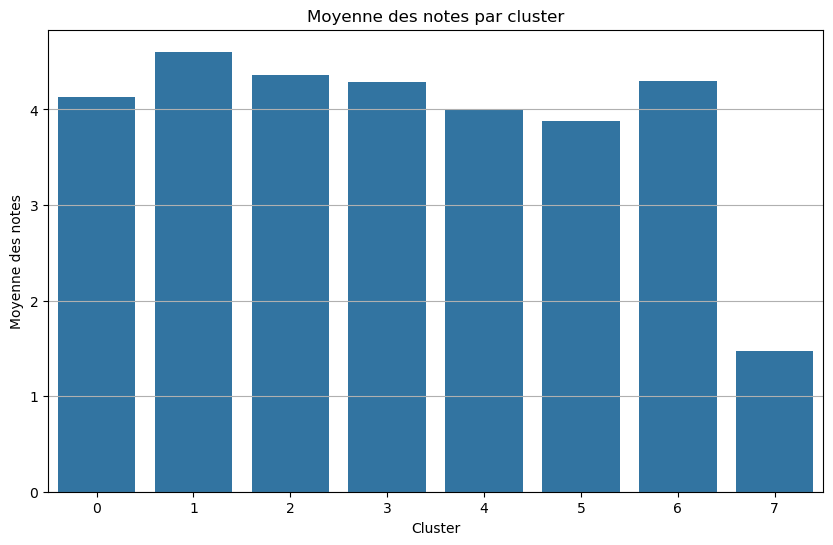

In [750]:
# Calcul de la moyenne des notes par cluster
mean_note = df_encoded_5.groupby('cluster')['note_moyenne_client'].mean()

# Barplot des moyennes de échéances par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_note.index, y=mean_note.values)
plt.title("Moyenne des notes par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des notes")
plt.grid(axis='y')
plt.show()

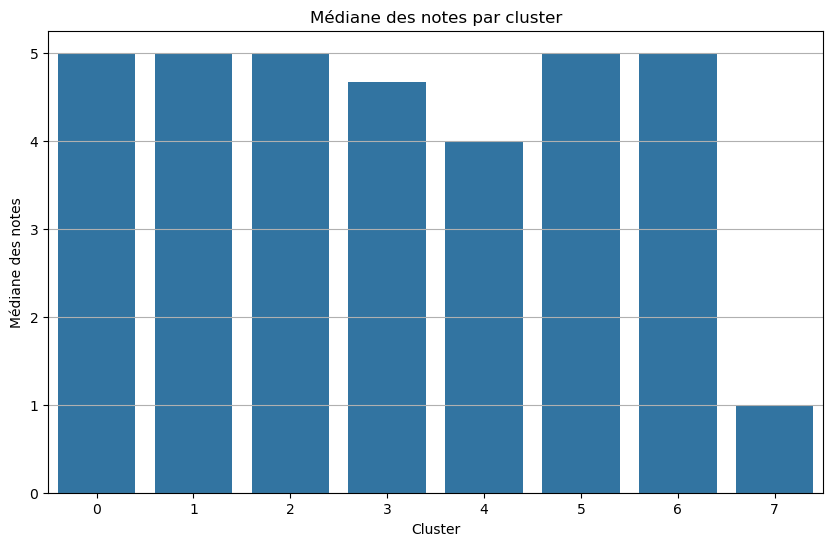

In [751]:
# Calcul de la moédiane des notes par cluster
med_note = df_encoded_5.groupby('cluster')['note_moyenne_client'].median()

# Barplot des moyennes de échéances par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=med_note.index, y=med_note.values)
plt.title("Médiane des notes par cluster")
plt.xlabel("Cluster")
plt.ylabel("Médiane des notes")
plt.grid(axis='y')
plt.show()

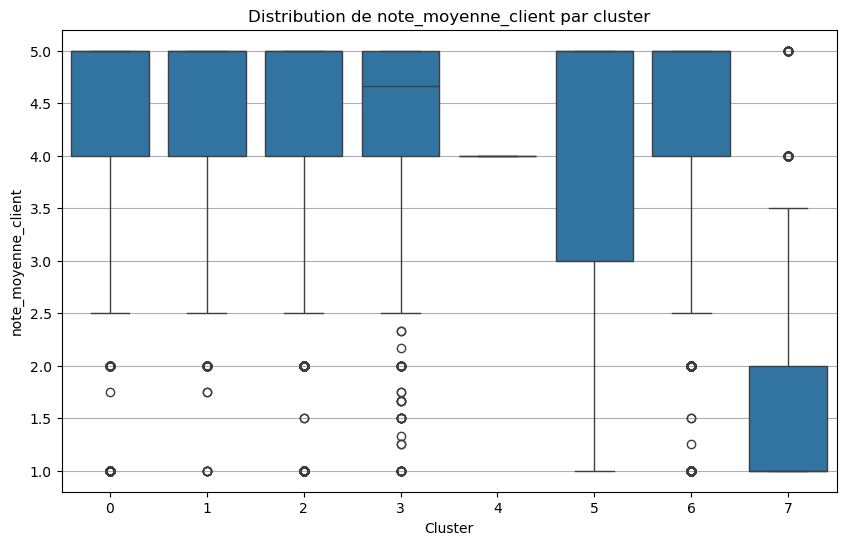

In [753]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='note_moyenne_client', data=df_encoded_5)
plt.title(f"Distribution de note_moyenne_client par cluster")
plt.xlabel("Cluster")
plt.grid(axis='y')
plt.show()

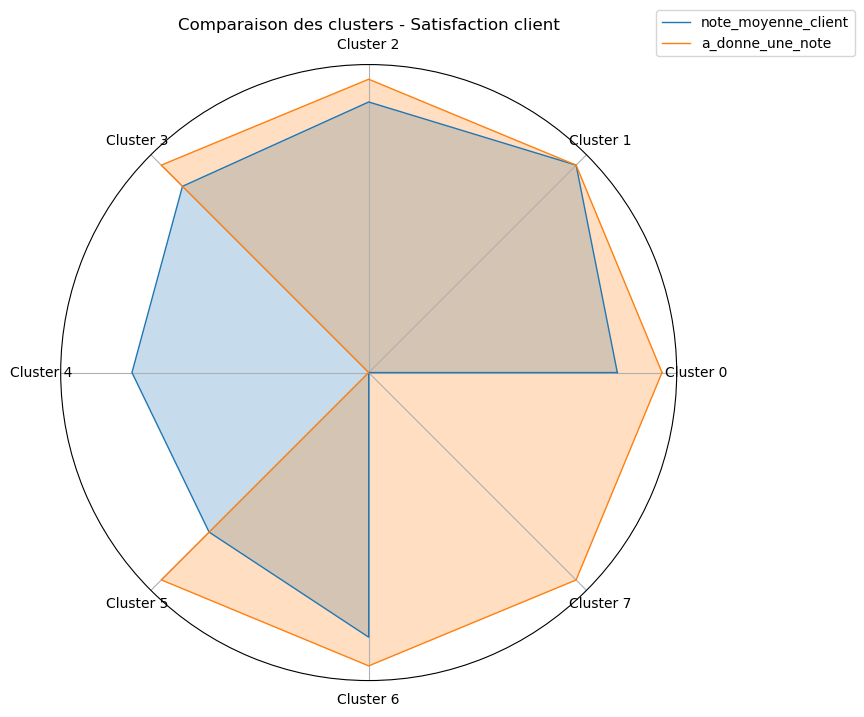

In [846]:
# Tracer le spider chart avec clusters sur les pointes et récence comme dimensions internes
plot_clusters_spider(df_scaled_mean, satisfaction_client, "Comparaison des clusters - Satisfaction client")

**note_moyenne_client**
- Cluster 7 => Clients insatisfaits
- Cluster 4 => Clients qui n'ont pas donné de note (lien a la variable a_donne_une_note) => clients peu impliqués
- Cluster 1, 2 => Clients très satisfaits
- Clusters 0, 3, 6 => Clients satisfaits
- Cluster 5 => Client légèrement insatisfaits

In [765]:
# Nombre de notes par cluster
note_par_cluster = df_encoded_5.groupby('cluster')['a_donne_une_note'].sum().astype(int)

# Nombre total de clients par cluster
nb_clients_par_cluster = df_encoded_5.groupby('cluster').size()

# Calcul de la proportion
proportion_par_cluster = (note_par_cluster / nb_clients_par_cluster * 100).round(2)

# Combinaison dans un DataFrame
note_et_proportion = pd.DataFrame({
    'Nombre de notes': note_par_cluster,
    'Nombre total de clients': nb_clients_par_cluster,
    'Proportion (%)': proportion_par_cluster
})

print("Nombre et proportion de 'a_donne_une_note' par cluster :")
print(note_et_proportion)

Nombre et proportion de 'a_donne_une_note' par cluster :
         Nombre de notes  Nombre total de clients  Proportion (%)
cluster                                                          
0                   2115                     2115          100.00
1                  35158                    35158          100.00
2                  21350                    21350          100.00
3                   1396                     1396          100.00
4                      0                      601            0.00
5                   3069                     3070           99.97
6                  20985                    20985          100.00
7                   8428                     8428          100.00


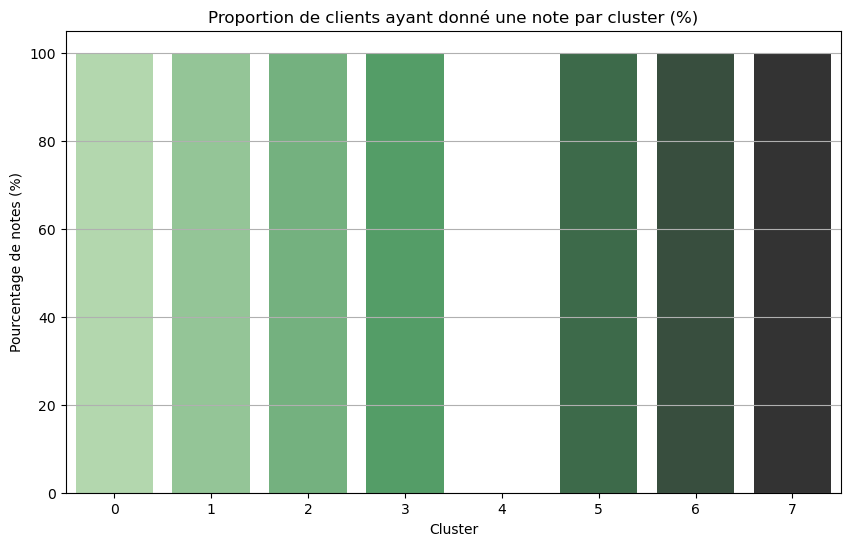

In [766]:
# Calcul de la proportion
proportion_notes = (note_par_cluster / nb_clients_par_cluster * 100).reset_index()
proportion_notes.columns = ['cluster', 'pourcentage_note']

# Barplot des proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='pourcentage_note', hue='cluster', data=proportion_notes, palette='Greens_d', legend=False)
plt.title("Proportion de clients ayant donné une note par cluster (%)")
plt.xlabel("Cluster")
plt.ylabel("Pourcentage de notes (%)")
plt.grid(axis='y')
plt.show()

**a_donne_une_note**
- Clusters 0, 1, 2, 3, 5, 6 et 7: Clients actifs => ont donné des notes
- Cluster 4 : Clients inactifs => aucune note ni commentaire

| Cluster | Récence                                      | Dépense totale        | Nombre de commandes      | Retards de livraison | Frais de livraison   | Poids moyen commandes | Diversité des catégories commandées                  | Diversité maximum de paiements  | Nombre de paiement pour les commandes | Satisfaction client            |
|:--------|:---------------------------------------------|:-----------------------|:--------------------------|:---------------------|:---------------------|:-----------------------|:-----------------------------------------------------|:---------------------------------|:-------------------------------------|:-------------------------------|
| 0       | Mixte, plutôt récence moyenne                | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        | Poids modéré           | Commandes sur 1 seule catégorie                      | **Clients diversifiés**              | Paiement multiple                     | Clients satisfaits              |
| 1       | Récence moyenne                              | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        | Poids faible           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       | **Clients très satisfaits**         |
| 2       | **Très récents**                                 | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais modérés        | Poids faible           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       | **Clients très satisfaits**         |
| 3       | Récence moyenne à très récents               | **Forte**                  | **Plus d'une commande**       | Livraison très en avance       | Frais modérés        | Poids modéré           | **Commandes diversifiées**                               | Clients homogènes                | Paiement multiple                     | Clients satisfaits              |
| 4       | Anciens à récence moyenne                    | Moyenne                | 1 commande                | Livraison moyenne, parfois en retard    | Frais élevés         | Poids élevé            | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       | **Pas de note**                    |
| 5       | Récence mixte                                | **Très forte**                  | 1 commande                | Livraison à l’heure ou en avance      | **Frais très élevés**    | **Poids très élevé**       | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       | Légèrement insatisfaits         |
| 6       | **Anciens**                                      | Faible                 | 1 commande                | Livraison à l’heure ou en avance      | Frais faibles        | Poids modéré           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       | Clients satisfaits              |
| 7       | Récence moyenne                              | Faible                 | 1 commande                | **Retards fréquents**    | Frais modérés        | Poids modéré           | Commandes sur 1 seule catégorie                      | Clients homogènes                | Paiement unique                       | **Clients insatisfaits**            |


## Synthèse des Clusters et Recommandations Marketing

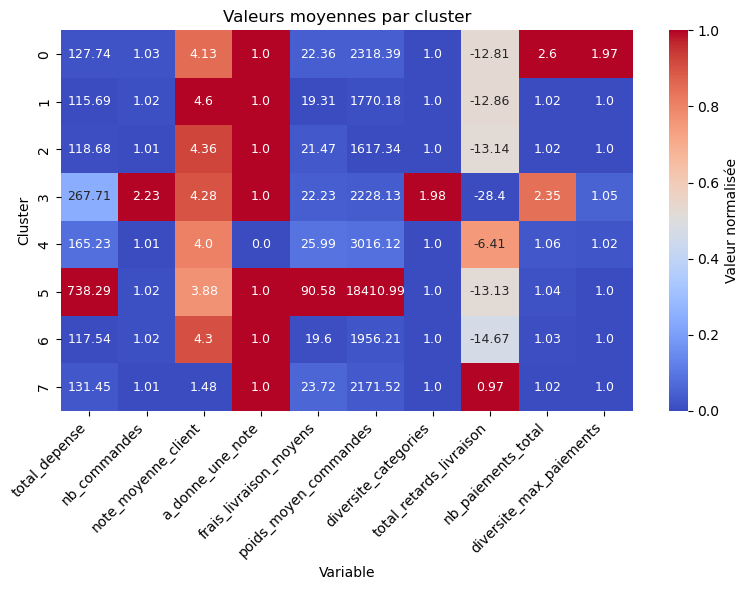

In [60]:
variables = ['total_depense', 'nb_commandes', 'note_moyenne_client', 'a_donne_une_note',
             'frais_livraison_moyens', 'poids_moyen_commandes',
             'diversite_categories', 'total_retards_livraison',
             'nb_paiements_total', 'diversite_max_paiements']
#variables = ['total_depense', 'nb_commandes', 'note_moyenne_client', 'a_donne_une_note']

cluster_means = df_encoded_5.groupby('cluster')[variables].mean().round(2)

# Normalisation pour la couleur
scaler = MinMaxScaler()
cluster_means_norm = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)

# Préparer les annotations avec les vraies valeurs (arrondies)
annotations = cluster_means.astype(str)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cluster_means_norm, 
    annot=annotations,      # Affiche les vraies valeurs
    fmt='',                 # Pas de formatage supplémentaire
    cmap="coolwarm",
    cbar_kws={'label': 'Valeur normalisée'},
    annot_kws={"size": 9}
)
plt.title("Valeurs moyennes par cluster")
plt.xlabel("Variable")
plt.ylabel("Cluster")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

| Cluster | Profil général                                          | Caractéristiques différenciantes                               | Justification des actions marketing                              | Actions marketing recommandées                                      |
|:-------|:---------------------------------------------------------|:--------------------------------------------------------------|:-----------------------------------------------------------------|:-------------------------------------------------------------------|
| 0      | Clients satisfaits, récence moyenne, faible dépense totale. | Livraison à l’heure ou en avance, diversité maximum de paiements : diversifiée. | Livraison fiable et flexibilité dans les paiements ; possibilité de promouvoir des offres multi-paiements. | Fidélisation via offres promotionnelles pour augmenter la dépense. |
| 1      | Clients très satisfaits, récence moyenne, faible dépense totale. | Frais faibles, poids faible, paiement unique.                 | Clients homogènes et économes ; cibler avec des offres simples et peu coûteuses. | Renforcement de la satisfaction avec des programmes de fidélité exclusifs. |
| 2      | Clients très récents, très satisfaits, faible dépense totale. | Frais modérés, poids faible, paiement unique.                 | Indique un comportement d'achat simple ; idéal pour encourager un deuxième achat rapidement. | Encourager la rétention avec des offres pour leur deuxième achat. |
| 3      | Clients récents à récence moyenne, forte dépense, commandes diversifiées. | Diversité élevée des catégories commandées ; livraison très en avance; plus d'une commande | Reflète un intérêt pour une variété de produits ; opportunité de proposer des recommandations personnalisées. | Fidélisation premium via recommandations personnalisées et avantages exclusifs. |
| 4      | Clients anciens à récence moyenne, dépense modérée.      | Livraison moyenne, parfois en retard ; pas de note donnée par les clients. | Problèmes logistiques et manque d’engagement ; besoin d’améliorer l’expérience client et de réactiver ces clients. | Réactivation via campagnes ciblées et amélioration de l’expérience logistique. |
| 5      | Clients légèrement insatisfaits, récence mixte, très forte dépense. | Frais très élevés ; poids très élevé ; livraison à l’heure ou en avance. | Indique des achats volumineux ou coûteux ; nécessite une attention particulière pour éviter la perte client. | Résolution des problèmes d'insatisfaction et valorisation via offres VIP ou premium. |
| 6      | Clients anciens, satisfaits, faible dépense totale.      | Livraison à l’heure ou en avance ; frais faibles ; commandes homogènes avec paiement unique. | Indique une logistique fiable mais peu exploitée ; besoin d’inciter à plus d’achats réguliers. | Réactivation avec des offres spéciales pour les inciter à revenir plus souvent. |
| 7      | Clients insatisfaits, récence moyenne, faible dépense totale. | Retards fréquents dans la livraison ; frais modérés ; commandes homogènes avec paiement unique. | Problème critique lié à la logistique ; risque élevé de perte client si aucune action n’est prise. | Identifier les causes d’insatisfaction (logistique) et proposer une compensation ou un geste commercial. |


## Visualisation Multidimensionnelle des Clusters

La visualisation multidimensionnelle des clusters est une étape clé pour évaluer la qualité du clustering et mieux comprendre la structure des données. En projetant les données dans un espace réduit (2D ou 3D), on peut observer la séparation des clusters et identifier d'éventuels chevauchements ou anomalies.

### Visualisation avec ACP (Analyse en Composantes Principales)

L'Analyse en Composantes Principales (ACP) est utilisée pour réduire la dimensionnalité des données tout en conservant le maximum de variance possible. Avant de visualiser les clusters, il est important d'analyser combien de composantes principales sont nécessaires pour expliquer une part suffisante de la variance des données.

Dans cette étape, nous calculons la variance expliquée par chaque composante principale. Cela nous permet de déterminer si une visualisation en 2 dimensions (2 premières composantes) ou en 3 dimensions (3 premières composantes) est justifiée.

Objectif : Identifier le nombre minimal d'axes nécessaires pour capturer une part significative de l'information contenue dans les données.

Étape suivante : Une fois ce nombre déterminé, nous projetons les données dans cet espace réduit pour observer la séparation des clusters.

In [849]:
# Application de l'ACP
pca = PCA(n_components=5)  # Calculer plusieurs composantes
pca.fit(df_standardized_5.values)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

print("Variance expliquée par les composantes :")
for i, var in enumerate(explained_variance):
    print(f"Composante {i + 1}: {var:.2%}")

# Somme des deux premières composantes
print(f"\nVariance totale expliquée par les deux premières composantes : {sum(explained_variance[:2]):.2%}")

Variance expliquée par les composantes :
Composante 1: 35.29%
Composante 2: 11.96%
Composante 3: 10.33%
Composante 4: 8.91%
Composante 5: 6.72%

Variance totale expliquée par les deux premières composantes : 47.25%


L'Analyse en Composantes Principales (ACP) a permis d'extraire plusieurs composantes principales, chacune expliquant une part de la variance totale des données. Voici les résultats obtenus :
- Composante 1 : 35.29 % de la variance expliquée.
- Composante 2 : 11.96 % de la variance expliquée.
- Composante 3 : 10.33 % de la variance expliquée.

Les deux premières composantes principales expliquent ensemble 47.25 % de la variance totale, ce qui est insuffisant pour capturer une représentation claire et complète des données. En ajoutant la troisième composante, nous atteignons une variance cumulée de 57.58 %, ce qui représente une amélioration significative. On va utiliser la visualisation en 3D pour mieux représenter les relations entre les clusters, mais nous présenterons également une visualisation en 2D pour comparer les deux approches.

#### Visualisation en 2D

In [858]:
def plot_pca_clusters(data, labels, title="Visualisation des Clusters avec ACP"):
    """
    Cette fonction applique une analyse en composantes principales (ACP) sur les données pour réduire leur dimensionnalité
    à 2 dimensions, puis visualise les clusters obtenus sur un graphique en 2D.
    
    Paramètres :
    data (DataFrame ou array-like) : Les données à réduire, sous forme de matrice (n_samples, n_features).
    labels (array-like) : Les étiquettes des clusters, correspondant aux données.
    title (str) : Le titre du graphique. Par défaut, "Visualisation des Clusters avec ACP".
    
    Retour :
    Aucun retour, affiche le graphique 2D des clusters après ACP.
    """
    
    # Application de l'ACP pour réduire la dimensionnalité à 2 composantes principales
    pca = PCA(n_components=2)  # On initialise PCA avec 2 composantes principales
    components = pca.fit_transform(data)  # Application de l'ACP aux données et transformation en 2D
    
    # Visualisation du résultat avec Matplotlib
    plt.figure(figsize=(10, 8))  # Création d'une figure de taille personnalisée (10x8)
    
    # Récupération des labels uniques des clusters pour les afficher séparément
    unique_labels = np.unique(labels)  # Les différents clusters présents dans les labels
    
    # Boucle pour afficher les points de chaque cluster
    for cluster in unique_labels:
        # Sélectionner les points correspondant à un cluster particulier
        cluster_points = components[labels == cluster]
        # Affichage des points du cluster avec des couleurs différentes pour chaque cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)
        # `alpha=0.7` ajoute un peu de transparence aux points pour mieux visualiser les chevauchements
    
    # Ajouter un titre au graphique
    plt.title(title)
    # Ajouter des labels aux axes
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.legend()
    plt.show()

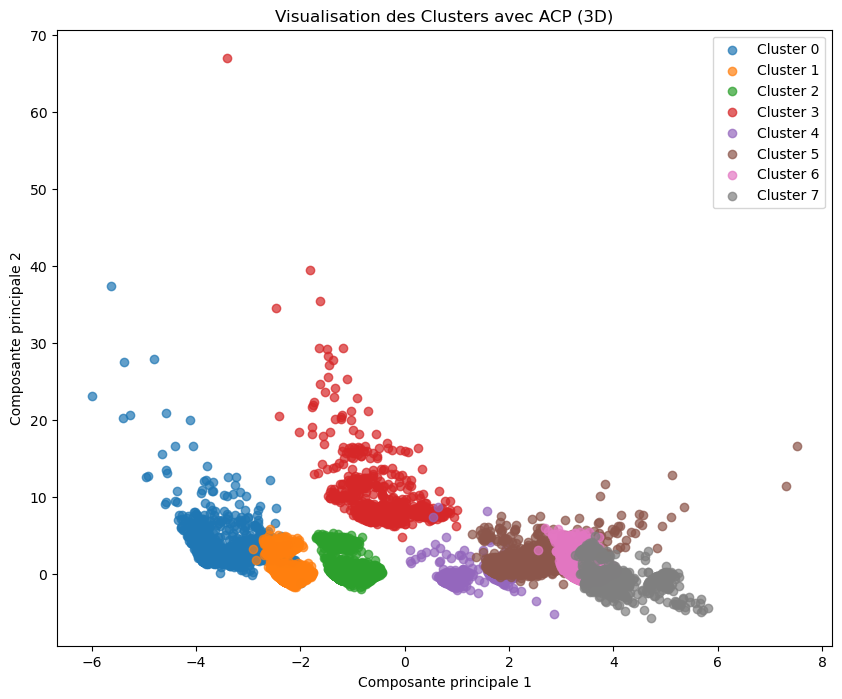

In [859]:
plot_pca_clusters(df_standardized_5.values, kmeans.labels_, "Visualisation des Clusters avec ACP (3D)")

- Les clusters 0, 1 et 2 montrent une séparation relativement nette, à l'exception du chevauchement entre les clusters 0 et 1.
- Le cluster 3 est bien positionné mais présente un léger chevauchement avec le cluster 4.
- Les clusters 4 à 7 sont plus proches les uns des autres et leurs frontières semblent moins distinctes, ce qui pourrait indiquer une certaine continuité ou similarité entre ces groupes.

#### Visualisation en 3D

In [860]:
def plot_pca_3d(data, labels, title="Visualisation des Clusters avec ACP (3D)"):
    """
    Commentaires :
    Cette fonction applique l'Analyse en Composantes Principales (ACP) sur les données afin de réduire leur dimensionnalité 
    à trois dimensions (3D) pour visualiser les clusters.

    Paramètres :
    - data : DataFrame ou tableau numpy contenant les données à projeter sur les trois premières composantes principales.
    - labels : Tableau ou liste contenant les étiquettes de chaque point de données, généralement les clusters.
    - title : Titre du graphique (par défaut "Visualisation des Clusters avec ACP (3D)").

    Fonctionnement :
    1. L'ACP est appliquée sur les données avec 3 composantes principales pour réduire la dimensionnalité des données.
    2. Les points de chaque cluster sont projetés dans l'espace des 3 composantes principales et affichés dans un graphique 3D.
    3. Les points de chaque cluster sont affichés dans le graphique avec une couleur différente pour chaque cluster.

    Sortie :
    - Un graphique 3D montrant les points projetés selon leurs trois premières composantes principales, 
      avec des couleurs distinctes pour chaque cluster.
    """

    # Application de l'ACP
    pca = PCA(n_components=3)  # Initialisation de l'ACP avec 3 composantes principales
    components = pca.fit_transform(data)  # Application de l'ACP sur les données

    # Visualisation
    fig = plt.figure(figsize=(10, 8)) 
    ax = fig.add_subplot(111, projection='3d')  # Création d'un subplot 3D

    unique_labels = np.unique(labels)  # Obtenir les labels uniques (clusters)
    
    for cluster in unique_labels:  # Parcourir chaque cluster
        cluster_points = components[labels == cluster]  # Extraire les points du cluster
        # Tracer les points du cluster en 3D
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f"Cluster {cluster}", alpha=0.7)  

    # Configuration des axes et du titre
    ax.set_title(title) 
    ax.set_xlabel("Composante principale 1") 
    ax.set_ylabel("Composante principale 2")  
    ax.set_zlabel("Composante principale 3")  

    # Légende et affichage du graphique
    ax.legend() 
    plt.show()  

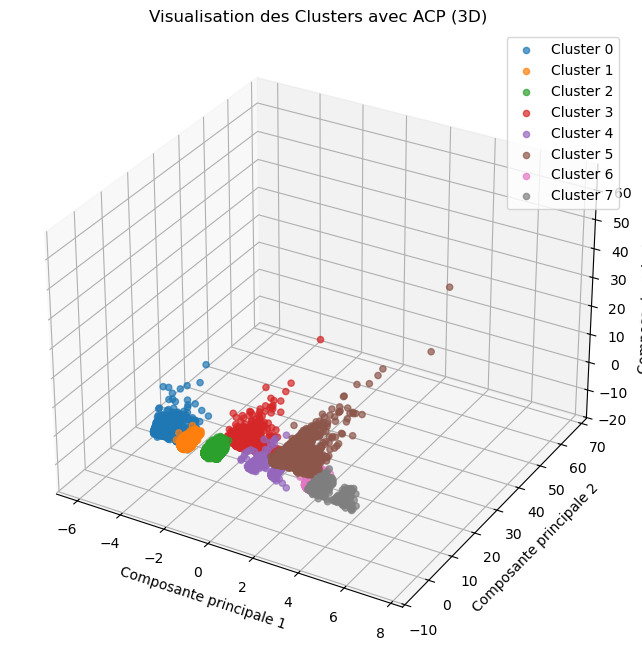

In [861]:
plot_pca_3d(df_standardized_5.values, kmeans.labels_, "Visualisation des Clusters avec ACP (3D)")

Dans la visualisation en 3D, les clusters apparaissent sous forme de paquets resserrés.

- Cluster 5 :
Bien visible et distinct, il se caractérise par des frais élevés et un poids important.
- Cluster 6 :
Difficile à distinguer, il est partiellement caché sous les clusters 5 et 7. Il partage des similarités avec ces clusters.
- Cluster 7 :
Proche du cluster 6, mais distinct en raison des retards fréquents et de l'insatisfaction.

Conclusion : 
Les clusters 5, 6 et 7 sont proches dans l'espace 3D, mais chacun a des caractéristiques uniques. Le cluster 6 est moins visible en raison de ses similarités avec les autres. 

### Visualisation avec t-SNE (t-Distributed Stochastic Neighbor Embedding)

Le t-SNE (t-Distributed Stochastic Neighbor Embedding) est une méthode de réduction de dimensionnalité non linéaire qui permet de visualiser les relations locales entre les points dans un espace de plus faible dimension. Contrairement à l'ACP, qui maximise la variance globale, le t-SNE se concentre sur la préservation des distances locales, ce qui le rend particulièrement adapté pour visualiser des structures complexes ou des clusters dans les données.

Dans cette section, nous utilisons le t-SNE pour projeter les données dans un espace en 2D afin d'explorer la séparation des clusters et leur organisation. Cette approche peut révéler des relations ou des regroupements qui ne sont pas visibles avec l'ACP.

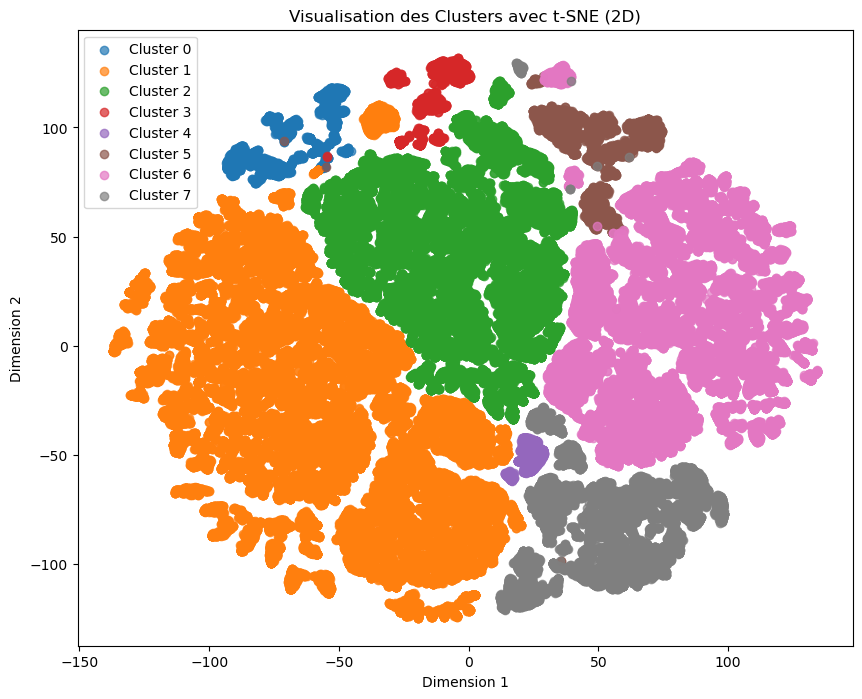

In [862]:
# Application de t-SNE
# Réduction de la dimensionnalité des données à 2 dimensions pour la visualisation
tsne = TSNE(n_components=2, random_state=42)  
tsne_components = tsne.fit_transform(df_standardized_5.values)  # Transformation des données standardisées

# Visualisation des clusters
plt.figure(figsize=(10, 8)) 

# Boucle pour afficher chaque cluster avec une couleur différente
unique_labels = np.unique(kmeans.labels_)  # Extraction des labels uniques (clusters)
for cluster in unique_labels:
    cluster_points = tsne_components[kmeans.labels_ == cluster]  # Points appartenant au cluster courant
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)  # Affichage du cluster

# Ajout du titre et des légendes au graphique
plt.title("Visualisation des Clusters avec t-SNE (2D)")  
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")  
plt.legend()  
plt.show()

La visualisation t-SNE montre que les clusters sont globalement bien distincts, notamment les clusters 1, 2 et 3, qui apparaissent clairement séparés. Cependant, quelques chevauchements sont visibles :
- Des points du cluster 7 se trouvent sur les clusters 0 et 5.
- Quelques points du cluster 3 apparaissent sur le cluster 0.
- Une petite partie du cluster 1 est située légèrement à l'écart, entre les clusters 3 et 0.

Conclusion : 
La représentation t-SNE met en évidence une bonne séparation globale des clusters, avec quelques chevauchements mineurs qui pourraient indiquer des zones de transition ou des comportements partagés entre certains groupes.

# Application de DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering non supervisé qui identifie des groupes de points basés sur leur densité. Contrairement à K-Means, il présente plusieurs avantages :
- Pas besoin de spécifier le nombre de clusters à l'avance.
- Détection automatique des outliers (points considérés comme du "bruit").
- Capacité à trouver des clusters de formes variées (non limités à des sphères).

Pour ce clustering, nous allons réutiliser les variables sélectionnées pour ton meilleur modèle K-Means. Ces variables ont déjà prouvé leur pertinence pour segmenter les clients, ce qui garantit une cohérence méthodologique. 

Comme le dataset complet contient 93 103 clients, nous utilisons un sous-échantillon de 10 % (9 310 clients) pour :
- Accélérer les calculs (DBSCAN peut être lent sur de grands datasets).
- Tester rapidement différents paramètres (eps, min_samples).
- Valider la stabilité des clusters avant de les généraliser.

## Sous-échantillonage

In [866]:
df_copie_essai5.drop(columns=['cluster'], inplace=True)

In [924]:
# Enregistrer le DataFrame en CSV
df_copie_essai5.to_csv('df_copie_essai5.csv', index=False)
print("df_copie_essai5 enregistré sous forme de fichier CSV.")

df_copie_essai5 enregistré sous forme de fichier CSV.


In [120]:
df_copie_essai5 = pd.read_csv('df_copie_essai5.csv')

In [95]:
# Échantillonnage aléatoire simple (10% du dataset)
echantillon = df_copie_essai5.sample(frac=0.1, random_state=1)

In [96]:
echantillon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9310 entries, 33593 to 29129
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nb_commandes             9310 non-null   int64  
 1   total_depense            9310 non-null   float64
 2   frais_livraison_moyens   9310 non-null   float64
 3   poids_moyen_commandes    9310 non-null   float64
 4   diversite_categories     9310 non-null   int64  
 5   total_retards_livraison  9310 non-null   int64  
 6   nb_paiements_total       9310 non-null   int64  
 7   diversite_max_paiements  9310 non-null   int64  
 8   note_moyenne_client      9310 non-null   float64
 9   a_donne_une_note         9310 non-null   int64  
 10  recence_en_jours_cat     9310 non-null   object 
dtypes: float64(4), int64(6), object(1)
memory usage: 872.8+ KB


In [97]:
# Enregistrer le DataFrame en CSV
echantillon.to_csv('echantillon.csv', index=False)
print("Échantillon enregistré sous forme de fichier CSV.")

Échantillon enregistré sous forme de fichier CSV.


In [24]:
# Recharger le df
echantillon = pd.read_csv('echantillon.csv')

### Vérification des distributions des variables quantitatives

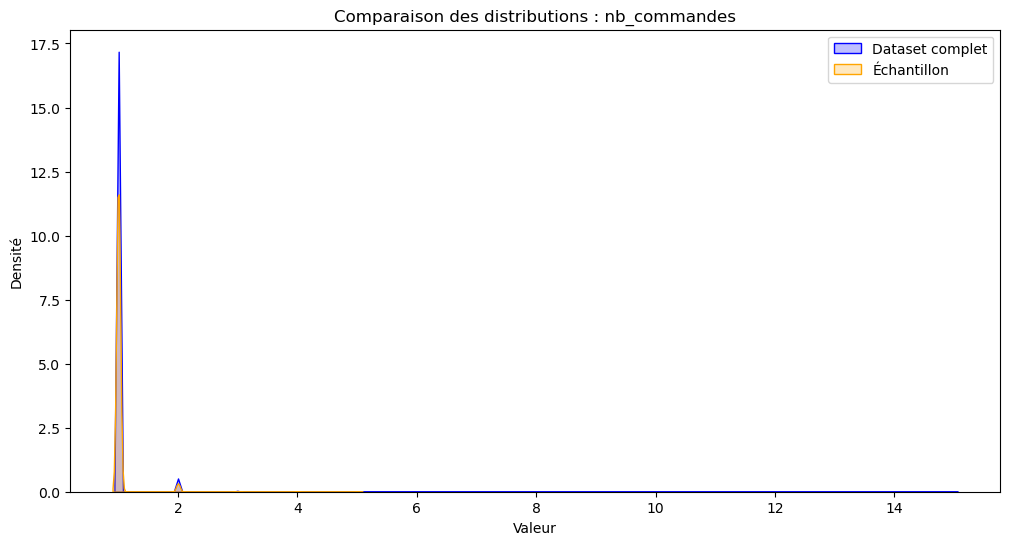

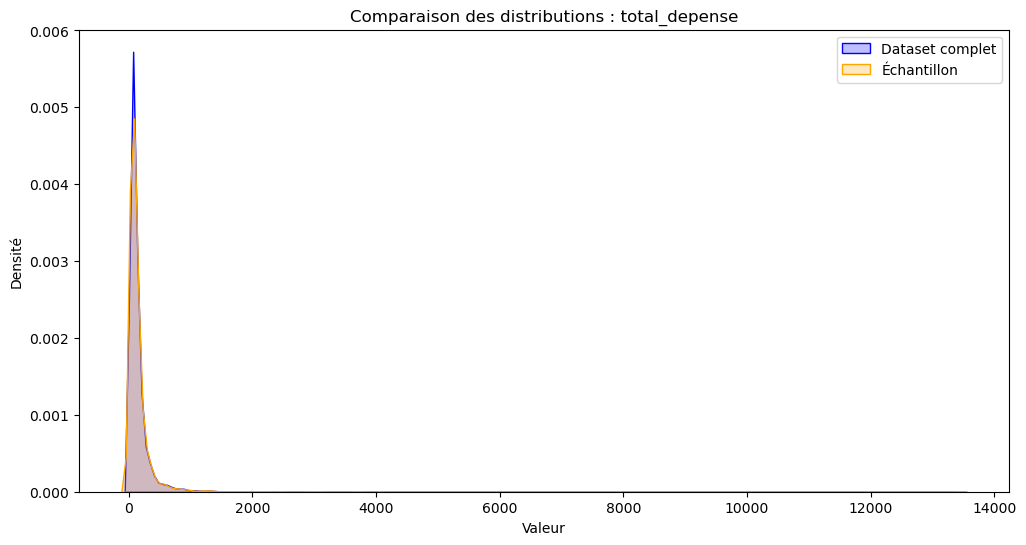

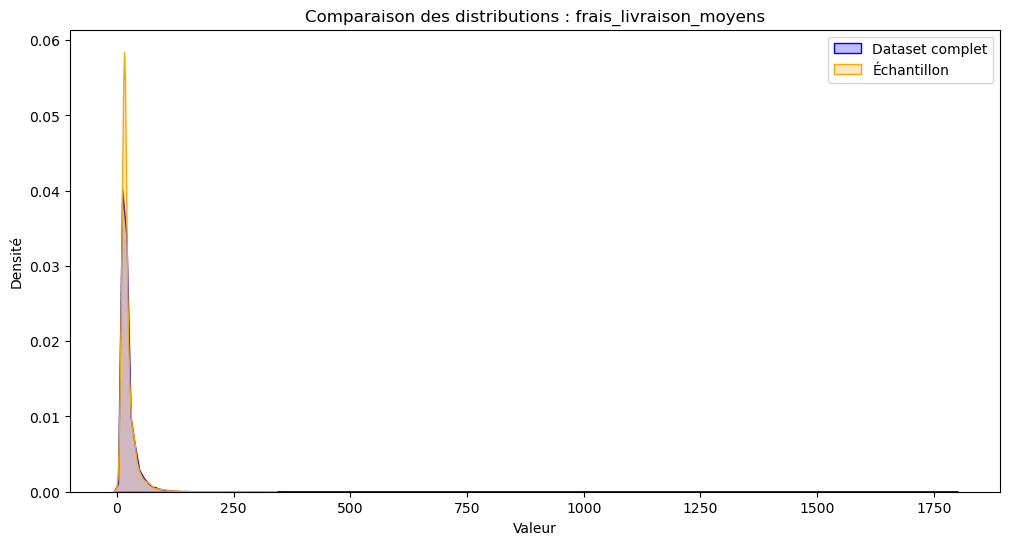

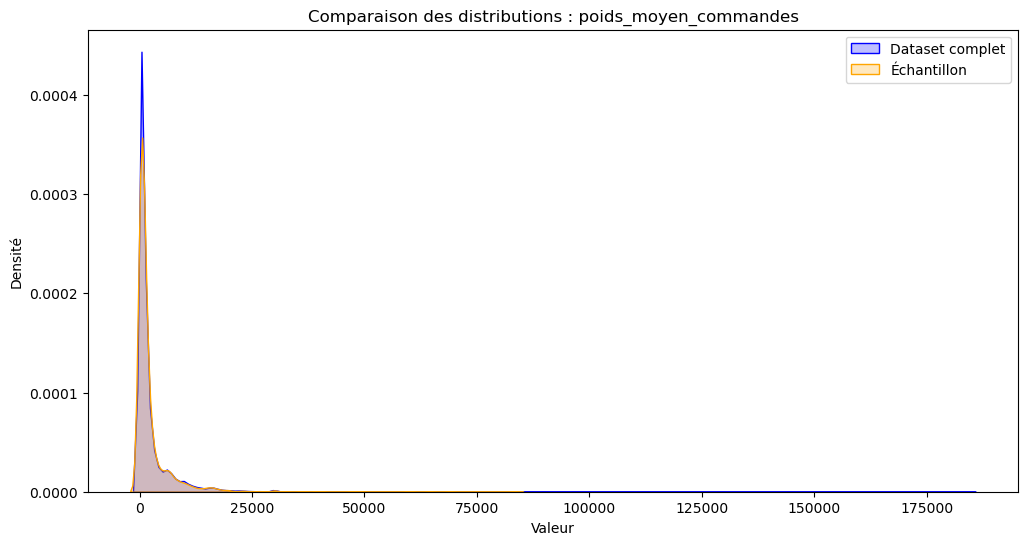

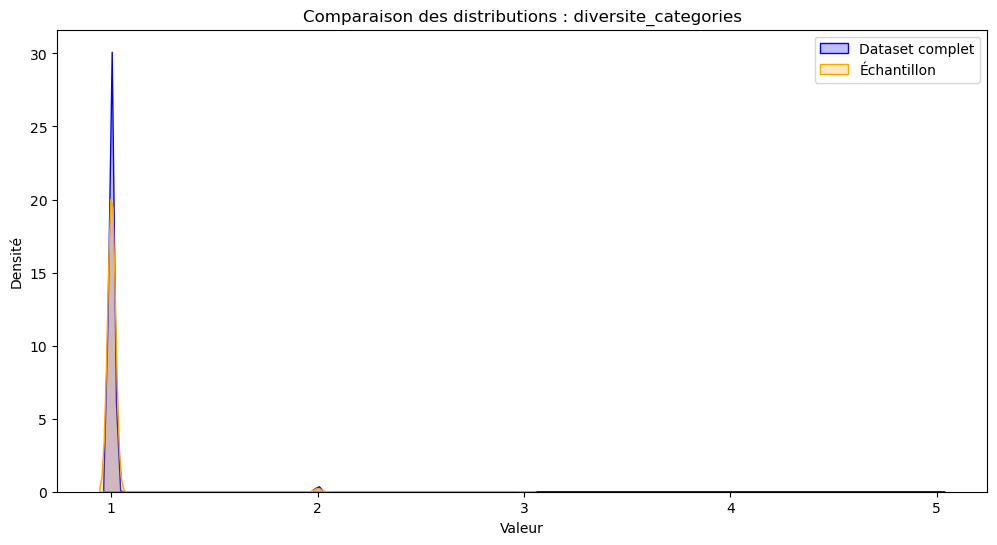

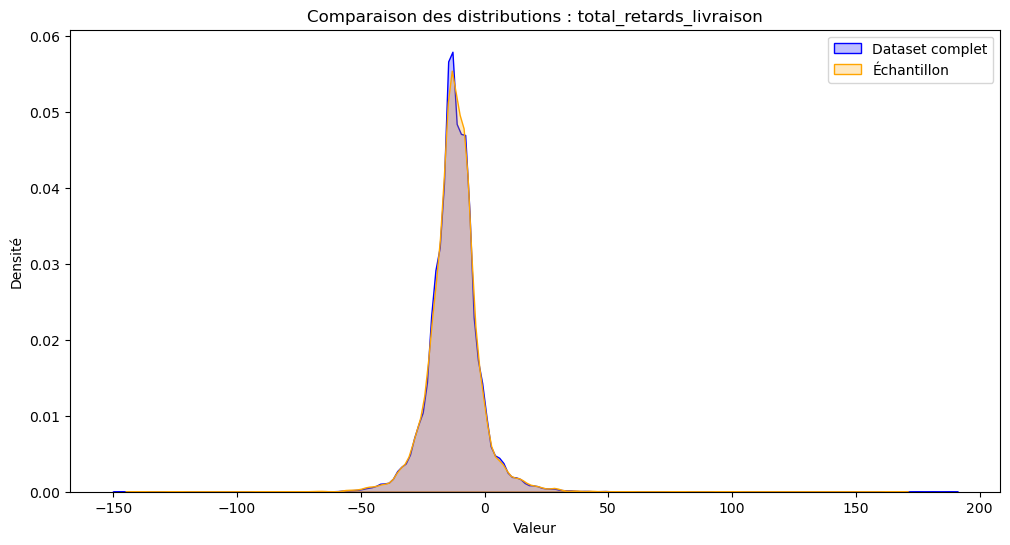

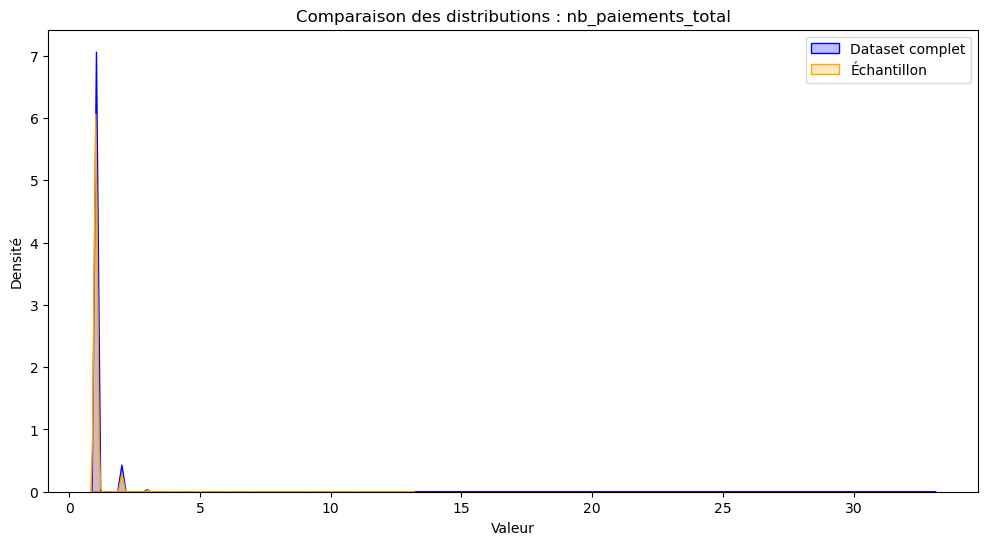

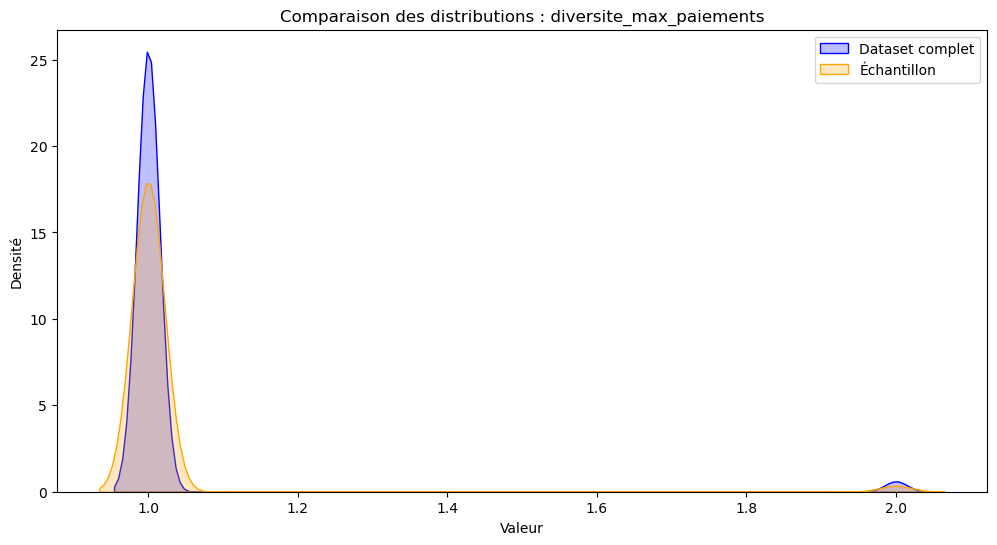

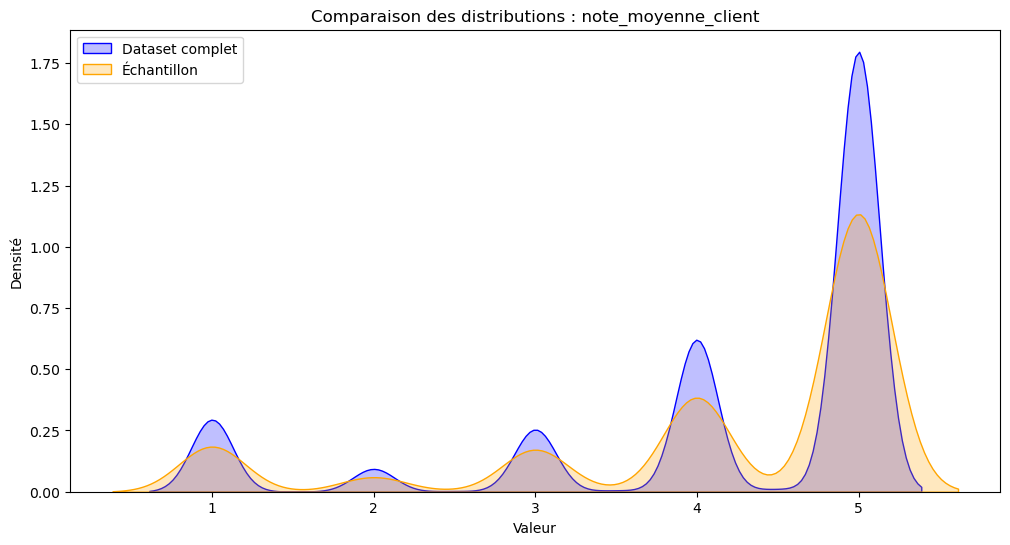

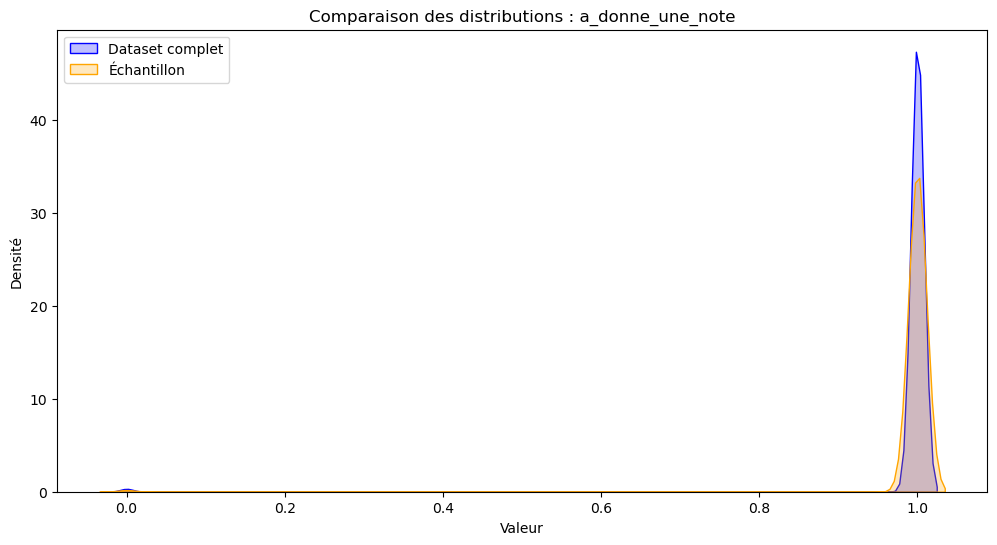

In [6]:
# Sélection des colonnes quantitatives
variables_quanti = df_copie_essai5.select_dtypes(include=['number']).columns

# Comparaison des distributions pour chaque variable quantitative
for column in variables_quanti:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df_copie_essai5[column], label='Dataset complet', color='blue', fill=True)
    sns.kdeplot(echantillon[column], label='Échantillon', color='orange', fill=True)
    plt.title(f'Comparaison des distributions : {column}')
    plt.xlabel('Valeur')
    plt.ylabel('Densité')
    plt.legend()
    plt.show()

In [25]:
# Statistiques descriptives pour le dataset complet
df_copie_essai5.describe().T

count         mean          std     min     25%  \
nb_commandes             93103.0     1.033404     0.209085    1.00    1.00   
total_depense            93103.0   141.623059   215.748304    0.85   47.65   
frais_livraison_moyens   93103.0    22.774868    21.468308    0.00   13.86   
poids_moyen_commandes    93103.0  2389.474325  4753.166562    2.00  300.00   
diversite_categories     93103.0     1.014715     0.126160    1.00    1.00   
total_retards_livraison  93103.0   -12.278133    10.809177 -147.00  -17.00   
nb_paiements_total       93103.0     1.080116     0.450409    1.00    1.00   
diversite_max_paiements  93103.0     1.023018     0.149960    1.00    1.00   
note_moyenne_client      93103.0     4.152472     1.276150    1.00    4.00   
a_donne_une_note         93103.0     0.993534     0.080151    0.00    1.00   

                            50%      75%        max  
nb_commandes               1.00     1.00      15.00  
total_depense             89.79   154.44   13440.00  
frais_livraison_moyens    17.23    24.11    1794.96  
poids_moyen_commandes    750.00  2100.00  184400.00  
diversite_categories       1.00     1.00       5.00  
total_retards_livraison  -13.00    -7.00     188.00  
nb_paiements_total         1.00     1.00      33.00  
diversite_max_paiements    1.00     1.00       2.00  
note_moyenne_client        5.00     5.00       5.00  
a_donne_une_note           1.00     1.00       1.00

In [26]:
# Statistiques descriptives pour l'échantillon
echantillon.describe().T

count         mean          std     min       25%  \
nb_commandes             9310.0     1.032009     0.197324    1.00    1.0000   
total_depense            9310.0   140.552363   246.285704    0.85   46.2250   
frais_livraison_moyens   9310.0    22.306913    18.740295    0.00   13.7925   
poids_moyen_commandes    9310.0  2245.433971  4248.144181    2.00  300.0000   
diversite_categories     9310.0     1.013319     0.119236    1.00    1.0000   
total_retards_livraison  9310.0   -12.317830    10.797527 -140.00  -17.0000   
nb_paiements_total       9310.0     1.070354     0.387377    1.00    1.0000   
diversite_max_paiements  9310.0     1.018690     0.135434    1.00    1.0000   
note_moyenne_client      9310.0     4.147948     1.276546    1.00    4.0000   
a_donne_une_note         9310.0     0.994844     0.071622    0.00    1.0000   

                             50%        75%       max  
nb_commandes               1.000     1.0000      5.00  
total_depense             89.000   149.9325  13440.00  
frais_livraison_moyens    17.035    23.7775    334.14  
poids_moyen_commandes    750.000  2006.0000  83250.00  
diversite_categories       1.000     1.0000      3.00  
total_retards_livraison  -12.000    -7.0000    166.00  
nb_paiements_total         1.000     1.0000     13.00  
diversite_max_paiements    1.000     1.0000      2.00  
note_moyenne_client        5.000     5.0000      5.00  
a_donne_une_note           1.000     1.0000      1.00

Après avoir comparé visuellement les distributions des variables quantitatives entre le dataset complet et le sous-échantillon à l'aide de graphiques de densité, ainsi qu'en examinant leurs statistiques descriptives, il est important de valider ces observations avec un test statistique.

Nous allons utiliser le test de Kolmogorov-Smirnov (KS), qui permet de comparer deux distributions pour déterminer si elles sont identiques. Ce test est particulièrement utile pour vérifier si le sous-échantillon représente fidèlement les données du dataset complet.

Objectif du test KS
- Le test KS compare la distribution d'une variable dans le dataset complet avec celle du sous-échantillon.
- Il calcule une statistique KS qui mesure la différence maximale entre les deux distributions cumulatives.
- Une p-value élevée (supérieure à 0.05) indique que les deux distributions sont statistiquement similaires.

In [27]:
# Test KS pour chaque variable numérique
for column in df_copie_essai5.select_dtypes(include=[np.number]).columns:
    statistic, p_value = ks_2samp(df_copie_essai5[column], echantillon[column])
    print(f"Variable : {column}")
    print(f"Statistique KS : {statistic}")
    print(f"P-value : {p_value}")
    print("Status :", "Identiques" if p_value > 0.05 else "Différentes", "\n")

Variable : nb_commandes
Statistique KS : 0.0012020411935810271
P-value : 1.0
Status : Identiques 

Variable : total_depense
Statistique KS : 0.010970611957400067
P-value : 0.2582842258695054
Status : Identiques 

Variable : frais_livraison_moyens
Statistique KS : 0.010916395759692055
P-value : 0.26349896782379356
Status : Identiques 

Variable : poids_moyen_commandes
Statistique KS : 0.009223748392818032
P-value : 0.46472646426317155
Status : Identiques 

Variable : diversite_categories
Statistique KS : 0.0013207056070733136
P-value : 1.0
Status : Identiques 

Variable : total_retards_livraison
Statistique KS : 0.008460357240602956
P-value : 0.5767387018145227
Status : Identiques 

Variable : nb_paiements_total
Statistique KS : 0.006560924814764335
P-value : 0.8570468089581302
Status : Identiques 

Variable : diversite_max_paiements
Statistique KS : 0.004327937136899052
P-value : 0.9971961788113792
Status : Identiques 

Variable : note_moyenne_client
Statistique KS : 0.0053881248806442

Toutes les variables quantitatives ont une p-value supérieure à 0.05, ce qui indique que leurs distributions dans le sous-échantillon sont statistiquement identiques à celles du dataset complet.

Les statistiques KS sont également très faibles, confirmant une forte similarité entre les deux datasets.

Conclusion : 
Les résultats du test KS confirment que le sous-échantillon est représentatif des données globales. Cela valide la qualité de l'échantillonnage et garantit que les analyses futures, notamment le clustering avec DBSCAN, seront fiables et cohérentes.

### Vérification des proportions de notre variable qualitative

In [28]:
# Comparaison des proportions pour 'recence_en_jours_cat'
print("Proportions dans le dataset complet :")
print(df_copie_essai5['recence_en_jours_cat'].value_counts(normalize=True))

print("\nProportions dans l'échantillon :")
print(echantillon['recence_en_jours_cat'].value_counts(normalize=True))

Proportions dans le dataset complet :
recence_en_jours_cat
Modéré         0.496912
Très récent    0.253171
Ancien         0.249917
Name: proportion, dtype: float64

Proportions dans l'échantillon :
recence_en_jours_cat
Modéré         0.496241
Ancien         0.255209
Très récent    0.248550
Name: proportion, dtype: float64


La variable qualitative recence_en_jours_cat a été vérifiée pour s'assurer que ses proportions dans le sous-échantillon sont représentatives de celles du dataset complet. 

Les proportions de la variable qualitative recence_en_jours_cat dans le sous-échantillon sont très proches de celles du dataset complet.<br>
La différence entre les pourcentages est marginale (< 1 %), ce qui indique que l'échantillonnage aléatoire a bien conservé la structure de cette variable.

## Préparation des données pour DBSCAN

Pour appliquer l'algorithme DBSCAN, il est nécessaire de transformer les données afin qu'elles soient compatibles avec ses calculs basés sur la densité. Voici les étapes suivies :
- Encodage One-Hot des variables catégorielles
- Standardisation des données : DBSCAN est sensible aux échelles des variables. Les données sont standardisées pour uniformiser leur influence dans le calcul des distances.

In [29]:
# One-hot encoding des variables catégorielles regroupées
echantillon_encoded = pd.get_dummies(echantillon, columns=['recence_en_jours_cat'], drop_first=False)

# Standardisation des données
scaler = StandardScaler()
echantillon_standardized = scaler.fit_transform(echantillon_encoded)

# Recréer un DataFrame après la standardisation
echantillon_standardized = pd.DataFrame(echantillon_standardized, columns=echantillon_encoded.columns)

# Vérification
echantillon_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.162222      -0.545584               -0.294404              -0.481515   
1     -0.162222      -0.367732               -0.437419              -0.363810   
2     -0.162222      -0.364037                0.255244               0.154091   
3     -0.162222      -0.448984               -0.437952              -0.469744   
4     -0.162222      -0.448903               -0.749063              -0.506468   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0             -0.111709                -0.989369           -0.181627   
1             -0.111709                -1.915557           -0.181627   
2             -0.111709                -0.341038           -0.181627   
3             -0.111709                 0.122056           -0.181627   
4             -0.111709                 0.307293           -0.181627   

   diversite_max_paiements  note_moyenne_client  a_donne_une_note  \
0                -0.138006             0.667503          0.071989   
1                -0.138006            -2.466121          0.071989   
2                -0.138006            -0.899309          0.071989   
3                -0.138006             0.667503          0.071989   
4                -0.138006             0.667503          0.071989   

   recence_en_jours_cat_Ancien  recence_en_jours_cat_Modéré  \
0                     1.708318                    -0.992509   
1                     1.708318                    -0.992509   
2                    -0.585371                    -0.992509   
3                    -0.585371                     1.007547   
4                     1.708318                    -0.992509   

   recence_en_jours_cat_Très récent  
0                         -0.575118  
1                         -0.575118  
2                          1.738774  
3                         -0.575118  
4                         -0.575118

In [30]:
echantillon_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9310 entries, 0 to 9309
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_commandes                      9310 non-null   float64
 1   total_depense                     9310 non-null   float64
 2   frais_livraison_moyens            9310 non-null   float64
 3   poids_moyen_commandes             9310 non-null   float64
 4   diversite_categories              9310 non-null   float64
 5   total_retards_livraison           9310 non-null   float64
 6   nb_paiements_total                9310 non-null   float64
 7   diversite_max_paiements           9310 non-null   float64
 8   note_moyenne_client               9310 non-null   float64
 9   a_donne_une_note                  9310 non-null   float64
 10  recence_en_jours_cat_Ancien       9310 non-null   float64
 11  recence_en_jours_cat_Modéré       9310 non-null   float64
 12  recenc

## Choix des paramètres de DBSCAN

### Choix de min_samples

Le paramètre min_samples définit le nombre minimum de points requis dans un voisinage pour former un noyau (core point).
Le choix de ce paramètre dépend de deux choses :
- La taille de l’échantillon :
- - Plus l’échantillon est petit, plus min_samples doit être bas.
- - Pour des volumes moyens (1000 à 10 000 clients), une valeur entre 4 et 10 est généralement appropriée.

- La logique métier :
On souhaite détecter des groupes denses et significatifs, mais aussi permettre à DBSCAN d’identifier les outliers (clients atypiques).

Une valeur de min_samples = 5 est un bon compromis : elle permet de détecter des petits groupes denses, sans trop "fusionner" les clusters ni exclure trop de points comme bruit.

### Estimation de eps via le graphe des distances (k-distance plot)

Il s'agit de la distance maximale entre deux points pour qu'ils soient considérés comme dans le même voisinage. Pour estimer le paramètre eps, nous allons utilisé un k-distance plot, qui consiste à :
- Calculer la distance du k-ième plus proche voisin pour chaque point (généralement avec k = min_samples - 1),
- Trier ces distances,
- Visualiser la courbe pour repérer le "coude" (elbow) indiquant un changement de densité.

Ce coude correspond au seuil où les points ne font plus partie d’un amas dense, donc une bonne valeur pour eps.

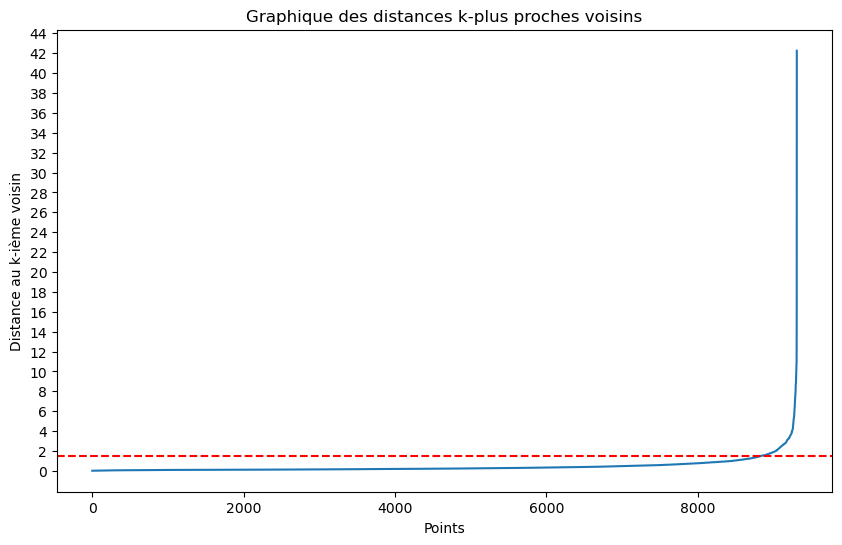

In [901]:
# Calcul des distances k-plus proches voisins
k = 4 # min_sample -1 
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(echantillon_standardized)
distances, indices = nearest_neighbors.kneighbors(echantillon_standardized)

eps_estime = 1.5 

# Trier les distances et tracer le graphique
distances = np.sort(distances[:, k-1])  # Distance au k-ième voisin

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=eps_estime, color='red', linestyle='--', label=f'eps ≈ {eps_estime}')
plt.title("Graphique des distances k-plus proches voisins")
plt.yticks(np.arange(0, max(distances)+2, 2))  

plt.xlabel("Points")
plt.ylabel("Distance au k-ième voisin")
plt.show()

On peut voir que le coude de notre courbe se situe entre 1.5 et 4. Nous allons donc par la suite utiliser une gridsearchvalue avec des valeurs proches de celles-ci pour optimiser notre valeur epsilon.

### Application et optimisation des paramètres

Dans cette section, je vais tester plusieurs combinaisons de paramètres pour DBSCAN afin d'identifier ceux qui produisent les meilleurs clusters.

In [85]:
# Liste des paramètres à tester
eps_values = [1.5, 2.5, 3, 3.5, 4]
min_samples_values = [4, 5, 10, 15]

# Stocker les résultats dans une liste
results = []

# Test des paramètres avec diagnostic
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(echantillon_standardized)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Calcul des métriques si au moins deux clusters sont formés
        if n_clusters > 1:
            silhouette = silhouette_score(echantillon_standardized, labels)
            davies_bouldin = davies_bouldin_score(echantillon_standardized, labels)
            calinski_harabasz = calinski_harabasz_score(echantillon_standardized, labels)
        else:
            # Si pas assez de clusters, assigner des valeurs nulles
            silhouette = None
            davies_bouldin = None
            calinski_harabasz = None
        
        # Ajouter les résultats à la liste
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski_harabasz
        })

# Convertir les résultats en DataFrame pour analyse et visualisation
results_df = pd.DataFrame(results)

# Afficher les résultats sous forme de tableau
results_df

eps  min_samples  n_clusters  silhouette  davies_bouldin  \
0   1.5            4          23    0.345798        1.425968   
1   1.5            5          17    0.347932        1.544609   
2   1.5           10          14    0.355716        1.526040   
3   1.5           15          10    0.412453        1.464394   
4   2.5            4          22    0.352220        1.611233   
5   2.5            5          17    0.372487        1.703492   
6   2.5           10          15    0.375896        1.768170   
7   2.5           15          14    0.375629        1.784333   
8   3.0            4          17    0.426460        1.681002   
9   3.0            5          15    0.425459        1.770527   
10  3.0           10          14    0.426342        1.718109   
11  3.0           15          12    0.425236        1.825772   
12  3.5            4          11    0.507863        1.579946   
13  3.5            5          10    0.507264        1.739960   
14  3.5           10           5    0.507456        1.901244   
15  3.5           15           5    0.506225        1.885848   
16  4.0            4          10    0.507171        1.612285   
17  4.0            5           9    0.506602        1.794409   
18  4.0           10           5    0.508186        1.916206   
19  4.0           15           5    0.508619        1.897511   

    calinski_harabasz  
0          425.875967  
1          508.764572  
2          588.343370  
3          742.491049  
4          506.792255  
5          612.923922  
6          633.566828  
7          663.262861  
8          672.827828  
9          725.122917  
10         759.106757  
11         803.761430  
12         466.979454  
13         488.853824  
14         864.953674  
15         859.964668  
16         494.879986  
17         524.200960  
18         874.265374  
19         871.358494

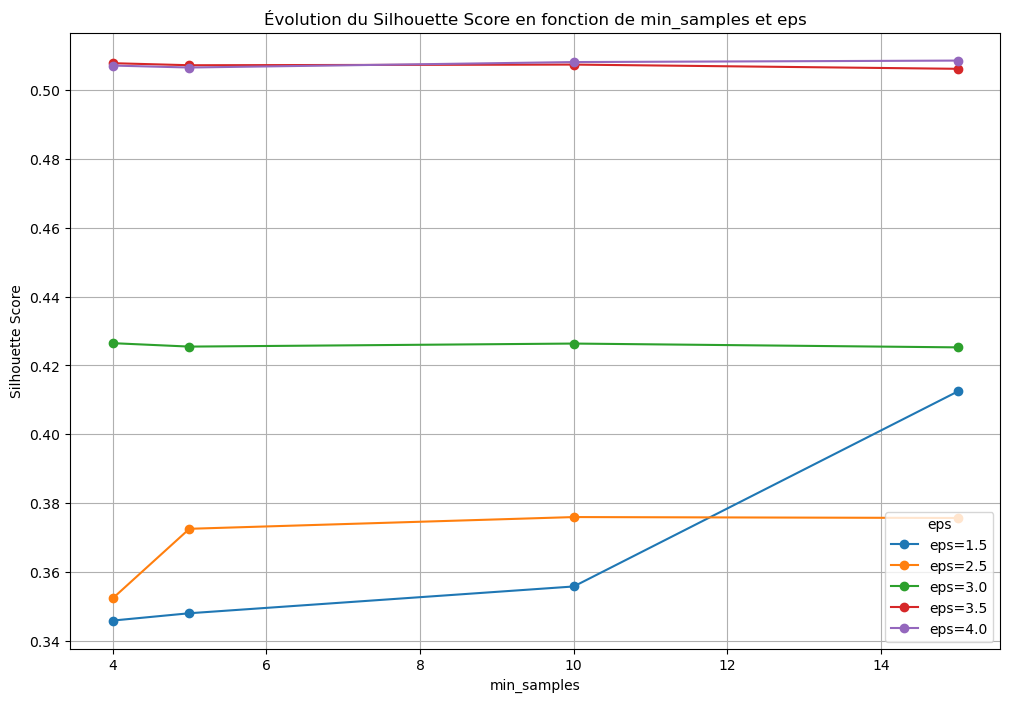

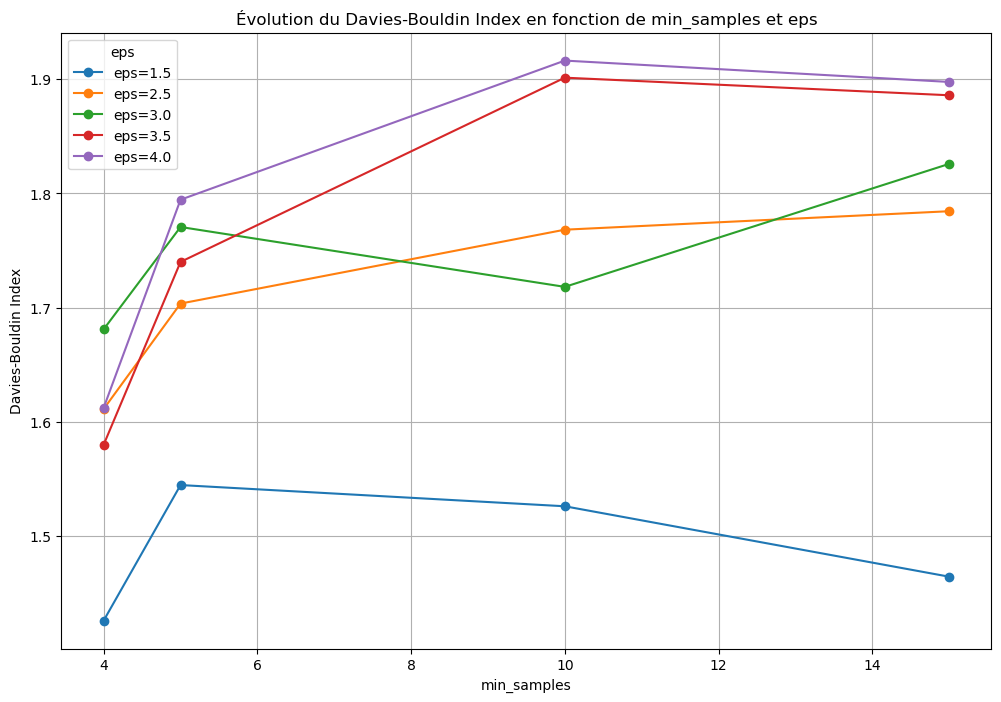

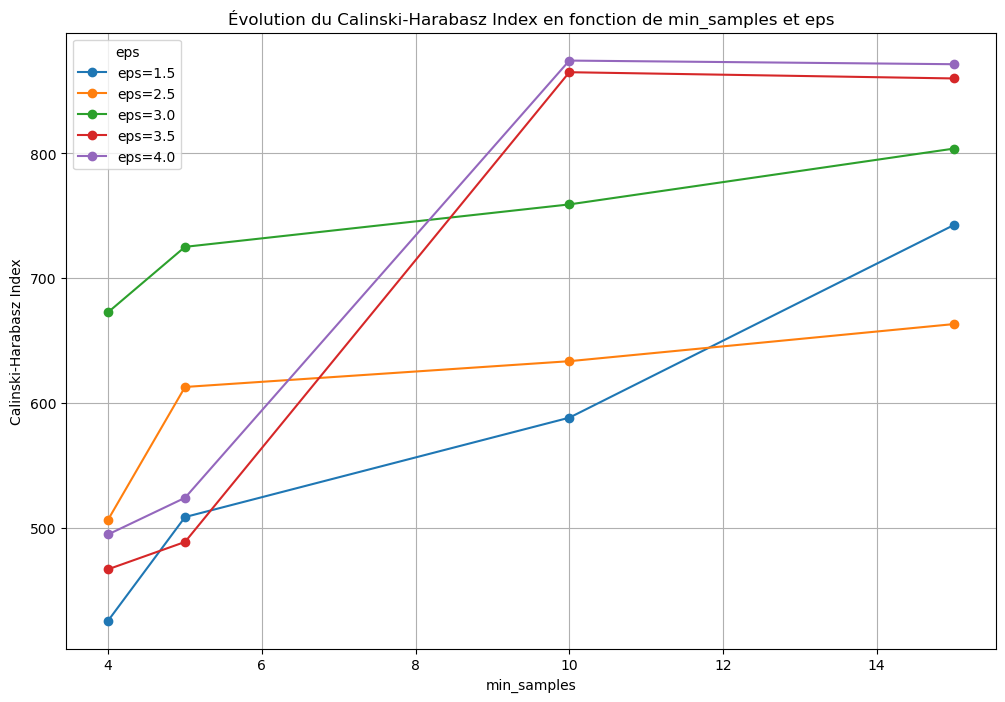

In [71]:
# Tracer les courbes pour le Silhouette Score
plt.figure(figsize=(12, 8))
for eps in results_df['eps'].unique():
    subset = results_df[results_df['eps'] == eps]
    plt.plot(subset['min_samples'], subset['silhouette'], marker='o', label=f'eps={eps}')

plt.title('Évolution du Silhouette Score en fonction de min_samples et eps')
plt.xlabel('min_samples')
plt.ylabel('Silhouette Score')
plt.legend(title='eps')
plt.grid(True)
plt.show()

# Tracer les courbes pour le Davies-Bouldin Index
plt.figure(figsize=(12, 8))
for eps in results_df['eps'].unique():
    subset = results_df[results_df['eps'] == eps]
    plt.plot(subset['min_samples'], subset['davies_bouldin'], marker='o', label=f'eps={eps}')

plt.title('Évolution du Davies-Bouldin Index en fonction de min_samples et eps')
plt.xlabel('min_samples')
plt.ylabel('Davies-Bouldin Index')
plt.legend(title='eps')
plt.grid(True)
plt.show()

# Tracer les courbes pour le Calinski-Harabasz Index
plt.figure(figsize=(12, 8))
for eps in results_df['eps'].unique():
    subset = results_df[results_df['eps'] == eps]
    plt.plot(subset['min_samples'], subset['calinski_harabasz'], marker='o', label=f'eps={eps}')

plt.title('Évolution du Calinski-Harabasz Index en fonction de min_samples et eps')
plt.xlabel('min_samples')
plt.ylabel('Calinski-Harabasz Index')
plt.legend(title='eps')
plt.grid(True)
plt.show()

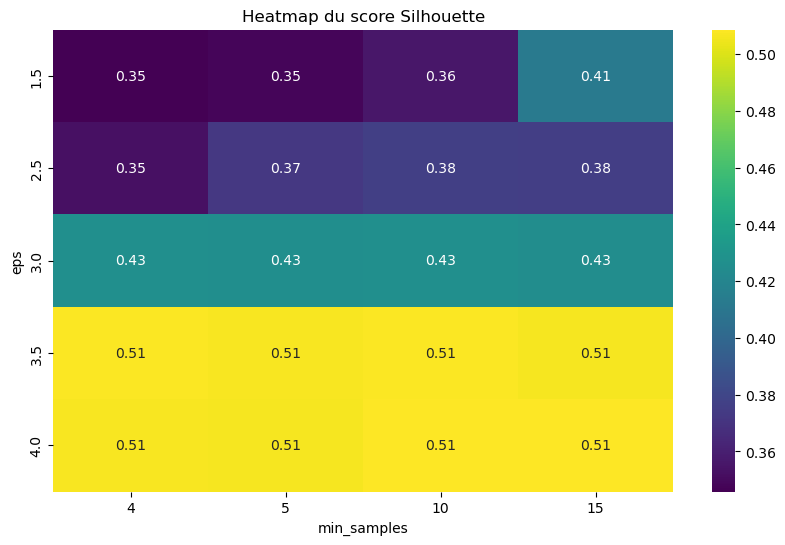

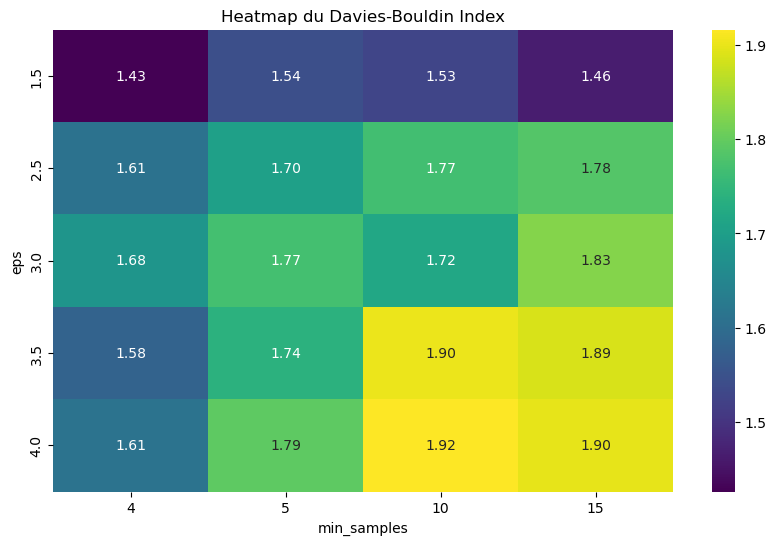

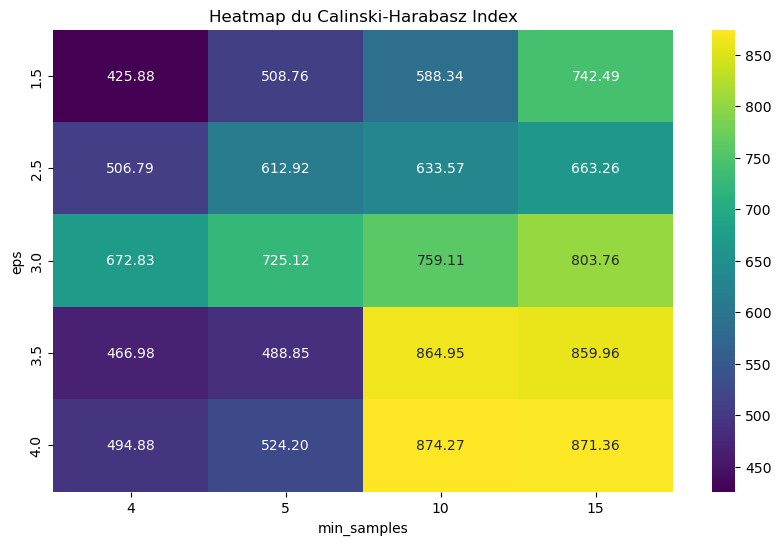

In [72]:
# Heatmap du score Silhouette
silhouette_pivot = results_df.pivot(index="eps", columns="min_samples", values="silhouette")
plt.figure(figsize=(10, 6))
sns.heatmap(silhouette_pivot, annot=True, cmap="viridis", fmt=".2f")
plt.title("Heatmap du score Silhouette")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.show()

# Heatmap du Davies-Bouldin Index
davies_pivot = results_df.pivot(index="eps", columns="min_samples", values="davies_bouldin")
plt.figure(figsize=(10, 6))
sns.heatmap(davies_pivot, annot=True, cmap="viridis", fmt=".2f")
plt.title("Heatmap du Davies-Bouldin Index")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.show()

# Heatmap du Calinski-Harabasz Index
calinski_pivot = results_df.pivot(index="eps", columns="min_samples", values="calinski_harabasz")
plt.figure(figsize=(10, 6))
sns.heatmap(calinski_pivot, annot=True, cmap="viridis", fmt=".2f")
plt.title("Heatmap du Calinski-Harabasz Index")
plt.xlabel("min_samples")
plt.ylabel("eps")
plt.show()

La configuration retenue (ligne 3) présente une bonne compacité intra-cluster selon le Silhouette Score de 0.412, l'un des meilleurs parmi toutes les configurations testées. Elle offre également une séparation correcte entre clusters avec un indice de Davies-Bouldin de 1.464, et un ratio inter/intra-cluster compétitif évalué par le Calinski-Harabasz Index de 742.49.

Elle inclut les paramètres suivants : eps = 1.5, min_samples = 15, et génère 10 clusters.

##  DBSCAN avec les paramètres optimaux (eps =1.5 et min_samples = 15)

In [31]:
# Paramètres optimaux trouvés 
eps_optimal = 1.5  
min_samples_optimal = 15  

# === Application de DBSCAN ===
print("=== Application de DBSCAN ===")
dbscan = DBSCAN(eps=eps_optimal, min_samples=min_samples_optimal)
labels = dbscan.fit_predict(echantillon_standardized)

# Ajouter les labels des clusters au DataFrame original
echantillon['cluster'] = labels

# Résumé des résultats
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_points = (labels == -1).sum()  # Nombre de points classés comme bruit
noise_ratio = n_noise_points / len(labels)  # Proportion de points classés comme bruit

print(f"Nombre de clusters formés (hors bruit) : {n_clusters}")
print(f"Nombre de points classés comme bruit : {n_noise_points}")
print(f"Proportion de points classés comme bruit : {noise_ratio:.2%}")

# === Évaluation des clusters ===
print("\n=== Évaluation des clusters DBSCAN ===")
silhouette = silhouette_score(echantillon_standardized, labels)
davies_bouldin = davies_bouldin_score(echantillon_standardized, labels)
calinski_harabasz = calinski_harabasz_score(echantillon_standardized, labels)

# Affichage des scores
print(f"Silhouette Score : {silhouette:.4f}")
print(f"Davies-Bouldin Index : {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index : {calinski_harabasz:.4f}")

=== Application de DBSCAN ===
Nombre de clusters formés (hors bruit) : 10
Nombre de points classés comme bruit : 599
Proportion de points classés comme bruit : 6.43%

=== Évaluation des clusters DBSCAN ===
Silhouette Score : 0.4125
Davies-Bouldin Index : 1.4644
Calinski-Harabasz Index : 742.4910


L'application de DBSCAN avec les paramètres optimaux a permis de former 10 clusters exploitables, tout en maintenant une proportion modérée de points classés comme bruit (6.43%, soit 599 points).

Les métriques de clustering confirment les résultats observés lors de l'optimisation des paramètres

## Test de stabilité des clusters DBSCAN

Pour garantir que les résultats obtenus avec DBSCAN sont robustes et fiables, il est essentiel de tester leur stabilité. Cette étape consiste à vérifier si les clusters restent cohérents lorsque les paramètres (eps et min_samples) ou les données sont légèrement modifiés. Nous allons varier ces paramètres autour des valeurs optimales et évaluer la stabilité en utilisant le score ARI (Adjusted Rand Index), qui mesure la similitude entre les labels obtenus avec différentes configurations. Un score ARI élevé indique que les clusters sont stables et robustes.

In [14]:
# --- Paramètres optimaux ---
eps_optimal = 1.5
min_samples_optimal = 15

# --- Variations autour des paramètres optimaux ---
eps_values = [1.4, 1.6, 1.7]
min_samples_values = [14, 15, 16]

labels_list = []

# --- Exécuter DBSCAN avec différentes configurations ---
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(echantillon_standardized)
        labels_list.append(labels)

# --- Calcul des scores ARI entre toutes les paires de configurations ---
ari_scores = [
    adjusted_rand_score(a, b)
    for a, b in combinations(labels_list, 2)
]

# --- Score ARI moyen global ---
mean_ari = np.mean(ari_scores)
print(f"ARI moyen global pour DBSCAN : {mean_ari:.2f}")

ARI moyen global pour DBSCAN : 0.99


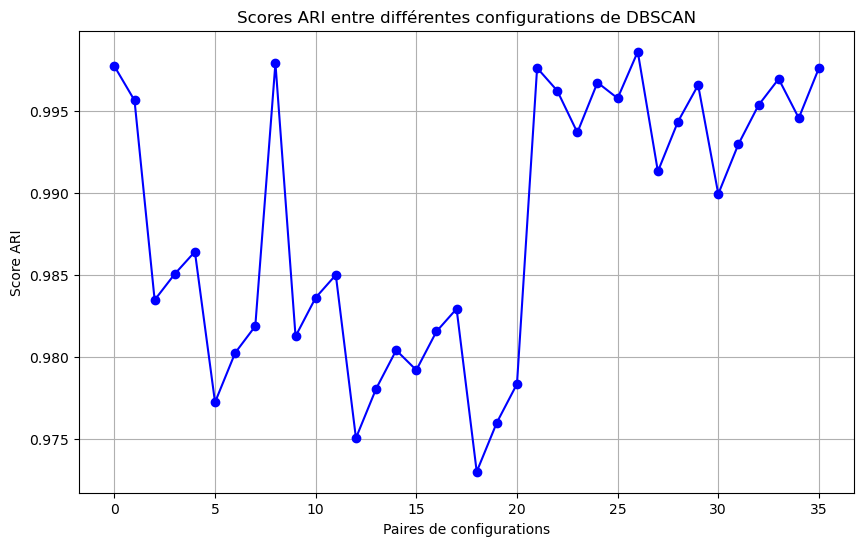

In [15]:
# --- Visualisation des scores ARI ---
plt.figure(figsize=(10, 6))
plt.plot(range(len(ari_scores)), ari_scores, marker='o', linestyle='-', color='b')
plt.title("Scores ARI entre différentes configurations de DBSCAN")
plt.xlabel("Paires de configurations")
plt.ylabel("Score ARI")
plt.grid(True)
plt.show()

Le test de stabilité des clusters DBSCAN a confirmé la robustesse des résultats obtenus. Avec un ARI moyen global de 0.99 et des variations minimes allant de 0.970 à 0.997, les clusters restent parfaitement cohérents malgré les légères modifications des paramètres (eps et min_samples).

Ces résultats indiquent que l'algorithme DBSCAN est bien adapté à la structure des données analysées, et que les paramètres optimaux choisis garantissent une segmentation fiable et exploitable. La stabilité observée renforce la confiance dans l'utilisation des clusters pour répondre aux objectifs métier.

## Répartition des clients par cluster

=== Distribution des clients par cluster ===
cluster
 2    4224
 0    2150
 1    2094
-1     599
 3      55
 7      52
 9      38
 8      34
 4      28
 6      23
 5      13
Name: count, dtype: int64


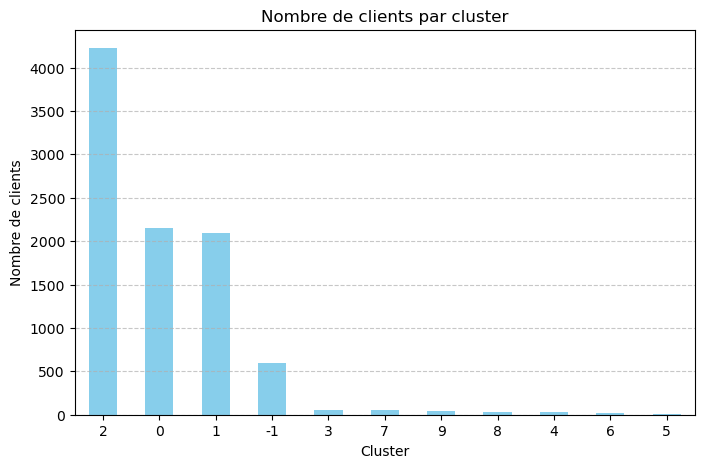

In [32]:
# Distribution des clients par cluster
cluster_counts = echantillon['cluster'].value_counts()

print("=== Distribution des clients par cluster ===")
print(cluster_counts)

# Visualisation rapide
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Nombre de clients par cluster")
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La distribution des clients par cluster montre que certains clusters sont très petits. Les trois plus grands clusters (2, 0, et 1) regroupent la majorité des clients avec respectivement 4224, 2150, et 2094 individus, tandis que plusieurs clusters plus petits (par exemple, 5, 6, et 4) contiennent moins de 30 clients chacun.

599 points (soit 6.43% des données) ont été classés comme bruit. Ces petits clusters et points classés comme bruit pourraient représenter des comportements atypiques ou des segments spécifiques, mais leur faible taille pourrait limiter leur exploitabilité dans une analyse métier.

Nous allons examiner ces petits clusters pour déterminer leur pertinence et envisager, si nécessaire, un regroupement ou une autre approche pour mieux exploiter ces segments.

## Évaluation de la pertinence des variables
### Identification des variables discriminantes (Variance inter-cluster)

In [33]:
# Ajouter les labels de cluster au DataFrame standardisé
echantillon_standardized['cluster'] = labels
# Vérification
echantillon_standardized.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.162222      -0.545584               -0.294404              -0.481515   
1     -0.162222      -0.367732               -0.437419              -0.363810   
2     -0.162222      -0.364037                0.255244               0.154091   
3     -0.162222      -0.448984               -0.437952              -0.469744   
4     -0.162222      -0.448903               -0.749063              -0.506468   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0             -0.111709                -0.989369           -0.181627   
1             -0.111709                -1.915557           -0.181627   
2             -0.111709                -0.341038           -0.181627   
3             -0.111709                 0.122056           -0.181627   
4             -0.111709                 0.307293           -0.181627   

   diversite_max_paiements  note_moyenne_client  a_donne_une_note  \
0                -0.138006             0.667503          0.071989   
1                -0.138006            -2.466121          0.071989   
2                -0.138006            -0.899309          0.071989   
3                -0.138006             0.667503          0.071989   
4                -0.138006             0.667503          0.071989   

   recence_en_jours_cat_Ancien  recence_en_jours_cat_Modéré  \
0                     1.708318                    -0.992509   
1                     1.708318                    -0.992509   
2                    -0.585371                    -0.992509   
3                    -0.585371                     1.007547   
4                     1.708318                    -0.992509   

   recence_en_jours_cat_Très récent  cluster  
0                         -0.575118        0  
1                         -0.575118        0  
2                          1.738774        1  
3                         -0.575118        2  
4                         -0.575118        0

In [34]:
# Variance inter-cluster pour chaque variable
variance_inter_cluster = echantillon_standardized.groupby('cluster').mean().var()

# Trier les variables par leur variance inter-cluster
variables_discriminantes = variance_inter_cluster.sort_values(ascending=False)

print("Variables discriminantes (par variance inter-cluster) :")
print(variables_discriminantes)

Variables discriminantes (par variance inter-cluster) :
a_donne_une_note                    17.606883
diversite_categories                11.323209
diversite_max_paiements              8.740697
nb_commandes                         5.393954
total_depense                        1.895239
nb_paiements_total                   1.703406
recence_en_jours_cat_Ancien          1.104813
recence_en_jours_cat_Modéré          1.003890
recence_en_jours_cat_Très récent     0.861904
frais_livraison_moyens               0.359702
total_retards_livraison              0.293414
poids_moyen_commandes                0.255459
note_moyenne_client                  0.075781
dtype: float64


L'analyse de la variance inter-cluster révèle les variables les plus discriminantes pour la segmentation des clusters générés par DBSCAN. Parmi celles-ci, les variables a_donne_une_note, diversite_categories, et diversite_max_paiements présentent les plus fortes variances inter-cluster, ce qui indique qu'elles contribuent significativement à différencier les clusters. Ces variables sont particulièrement utiles pour comprendre les différences entre les groupes.

### Heatmap des contributions des variables à la segmentation

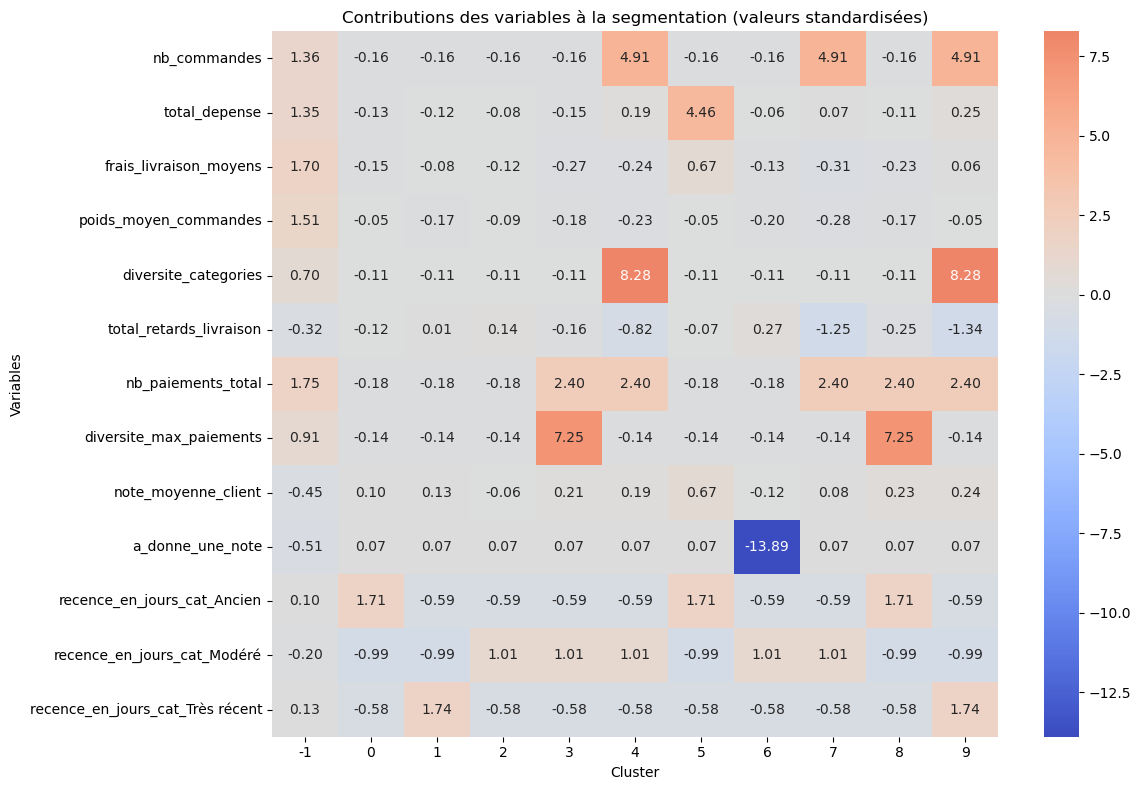

In [35]:
# Calculer les moyennes standardisées de chaque variable par cluster
cluster_means_std = echantillon_standardized.groupby('cluster').mean()

# Tracer une heatmap pour visualiser les contributions des variables
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_std.T, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Contributions des variables à la segmentation (valeurs standardisées)")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

La heatmap des moyennes standardisées par cluster met en évidence les contributions des variables à la segmentation. Elle montre que certaines variables, comme nb_commandes, diversite_categories, et diversite_max_paiements, ont des valeurs très élevées dans certains clusters spécifiques (par exemple, le cluster 4 et le cluster 8). Cela suggère que ces clusters regroupent des clients avec des comportements distincts, comme une diversité élevée de catégories ou un nombre élevé de paiements.

note_moyenne_client présente des variations plus modérées mais reste pertinente pour caractériser certains clusters.

### Résultats ANOVA : Identification des variables significatives

In [36]:
# Ajouter les labels de cluster au DataFrame original
echantillon_encoded['cluster'] = labels

# Vérification
echantillon_encoded.head()

nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0             1           6.19                   16.79                  200.0   
1             1          49.99                   14.11                  700.0   
2             1          50.90                   27.09                 2900.0   
3             1          29.98                   14.10                  250.0   
4             1          30.00                    8.27                   94.0   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0                     1                      -23                   1   
1                     1                      -33                   1   
2                     1                      -16                   1   
3                     1                      -11                   1   
4                     1                       -9                   1   

   diversite_max_paiements  note_moyenne_client  a_donne_une_note  \
0                        1                  5.0                 1   
1                        1                  1.0                 1   
2                        1                  3.0                 1   
3                        1                  5.0                 1   
4                        1                  5.0                 1   

   recence_en_jours_cat_Ancien  recence_en_jours_cat_Modéré  \
0                         True                        False   
1                         True                        False   
2                        False                        False   
3                        False                         True   
4                         True                        False   

   recence_en_jours_cat_Très récent  cluster  
0                             False        0  
1                             False        0  
2                              True        1  
3                             False        2  
4                             False        0

Lors de l'analyse des clusters générés par DBSCAN, nous excluons les points classés comme bruit (cluster = -1) de l'ANOVA. Ces points ne font pas partie d'un cluster cohérent et peuvent introduire du bruit statistique dans l'analyse. En les exclure, nous nous concentrons uniquement sur les groupes bien définis par DBSCAN, ce qui permet d'identifier plus précisément les variables qui différencient significativement ces clusters.

De plus, nous vérifions les variables ayant une variance nulle au sein des clusters. Ces variables, qui ne présentent aucune variation entre les groupes, sont également exclues de l'ANOVA car elles n'apportent aucune information discriminante pour la segmentation. Cette étape garantit que l'analyse se concentre uniquement sur les variables pertinentes pour différencier les clusters.

In [37]:
# Exclure les points classés comme bruit (-1)
echantillon_sans_bruit = echantillon_encoded[echantillon_encoded['cluster'] != -1]

# Calculer la variance inter-cluster pour chaque variable
variance_inter_cluster = echantillon_sans_bruit.groupby('cluster').var()

# Identifier les variables avec une variance nulle
variables_a_exclure = variance_inter_cluster.columns[variance_inter_cluster.min() == 0].tolist()
print("Variables à exclure :", variables_a_exclure)

# Filtrer les variables restantes
variables_a_tester = [col for col in echantillon_sans_bruit.columns 
                      if col not in variables_a_exclure and col != 'cluster']
print("Variables à tester :", variables_a_tester)

Variables à exclure : ['nb_commandes', 'diversite_categories', 'nb_paiements_total', 'diversite_max_paiements', 'note_moyenne_client', 'a_donne_une_note', 'recence_en_jours_cat_Ancien', 'recence_en_jours_cat_Modéré', 'recence_en_jours_cat_Très récent']
Variables à tester : ['total_depense', 'frais_livraison_moyens', 'poids_moyen_commandes', 'total_retards_livraison']


In [38]:
# Dictionnaire pour stocker les résultats ANOVA
anova_results = {}

for variable in variables_a_tester:
    # Extraire les valeurs par cluster
    clusters = [echantillon_sans_bruit[echantillon_sans_bruit['cluster'] == cluster][variable] 
                for cluster in echantillon_sans_bruit['cluster'].unique()]
    
    # Test ANOVA
    f_stat, p_value = f_oneway(*clusters)
    
    # Stocker les résultats
    anova_results[variable] = {'F-statistic': f_stat, 'p-value': p_value}

# Convertir en DataFrame pour affichage
anova_df = pd.DataFrame(anova_results).T.sort_values(by='p-value', ascending=True)

print("Résultats ANOVA :")
anova_df

Résultats ANOVA :


F-statistic        p-value
total_depense             132.504055  5.959467e-235
total_retards_livraison    45.212646   3.949194e-80
frais_livraison_moyens      5.101174   6.536195e-07
poids_moyen_commandes       4.682388   3.209074e-06

L'ANOVA a été réalisée uniquement sur les variables ayant une variance non nulle entre les clusters. Les résultats montrent que plusieurs variables sont statistiquement significatives pour différencier les clusters :
- total_depense : F-statistic = 132.50, p-value < 0.0001
- total_retards_livraison : F-statistic = 45.21, p-value < 0.0001
- frais_livraison_moyens : F-statistic = 5.10, p-value < 0.0001
- poids_moyen_commandes : F-statistic = 4.68, p-value < 0.0001

Ces résultats confirment que ces variables jouent un rôle clé dans la différenciation des clusters et peuvent être utilisées pour interpréter leurs spécificités.

### Conclusion

Cette analyse met en lumière les variables discriminantes qui expliquent la segmentation obtenue par DBSCAN. Les résultats de l'ANOVA confirment que certaines variables, comme total_depense et total_retards_livraison, sont particulièrement significatives pour différencier les clusters, tandis que d'autres variables comme a_donne_une_note ou diversite_categories contribuent fortement à la variance inter-cluster mais ne sont pas statistiquement significatives selon l'ANOVA (probablement en raison de leur distribution). Ces insights seront utiles pour interpréter et exploiter les clusters dans une analyse métier ou marketing.

## Analyse descriptive des variables par cluster

Pour mieux comprendre le comportement des clients dans chaque cluster, nous avons structuré notre analyse autour de groupes thématiques. Ces groupes regroupent des variables liées à des aspects spécifiques du comportement client :
- RFM (Récence, Fréquence, Montant) : Variables liées à la récence des interactions, la fréquence des commandes, et le montant total dépensé.
- Produits : Variables reflétant la diversité et les caractéristiques des produits achetés.
- Livraison : Variables liées aux retards et frais de livraison, qui impactent l'expérience client.
- Paiement : Variables représentant les comportements financiers, comme la diversité des modes de paiement et le nombre total de paiements effectués.
- Satisfaction client : Variables mesurant l'engagement et la perception globale des clients envers l'entreprise.

Cette organisation permet d'analyser chaque dimension du comportement client de manière ciblée et approfondie, tout en facilitant l'interprétation des résultats par cluster. 

In [39]:
rfm = ['recence_en_jours_cat_Très récent', 'recence_en_jours_cat_Ancien',
       'recence_en_jours_cat_Modéré', 'total_depense', 'nb_commandes']
produits =['poids_moyen_commandes', 'diversite_categories']
livraison = ['total_retards_livraison', 'frais_livraison_moyens']
paiement = ['diversite_max_paiements', 'nb_paiements_total']
satisfaction_client = ['note_moyenne_client', 'a_donne_une_note']

### Variables liées à rfm

In [40]:
echantillon_encoded.groupby('cluster')['total_depense'].describe()

count         mean         std      min        25%       50%  \
cluster                                                                  
-1        599.0   473.493356  767.152294     7.29   120.7500   238.000   
 0       2150.0   109.376112  109.351855     4.90    43.9150    75.000   
 1       2094.0   111.347130  116.233279     3.50    40.9900    79.900   
 2       4224.0   120.007223  127.116693     0.85    45.9900    85.000   
 3         55.0   103.478727  107.251675     6.00    39.2350    59.990   
 4         28.0   187.467857   96.223449    47.80   118.5500   166.890   
 5         13.0  1238.436923   91.542810  1099.00  1180.9500  1221.030   
 6         23.0   126.590000  112.092009    32.30    52.4500    89.800   
 7         52.0   157.855962  105.038129    25.80    89.9875   134.485   
 8         34.0   113.697353   91.926079    13.90    52.4750    82.450   
 9         38.0   201.685263   99.086208    64.80   145.8750   169.845   

               75%       max  
cluster                       
-1        570.0250  13440.00  
 0        134.1925    999.99  
 1        134.9000    980.00  
 2        148.0000   1340.00  
 3        134.0000    599.99  
 4        228.9750    395.99  
 5       1300.0000   1420.00  
 6        154.9950    499.99  
 7        202.7500    578.00  
 8        133.3850    349.90  
 9        237.3925    541.55

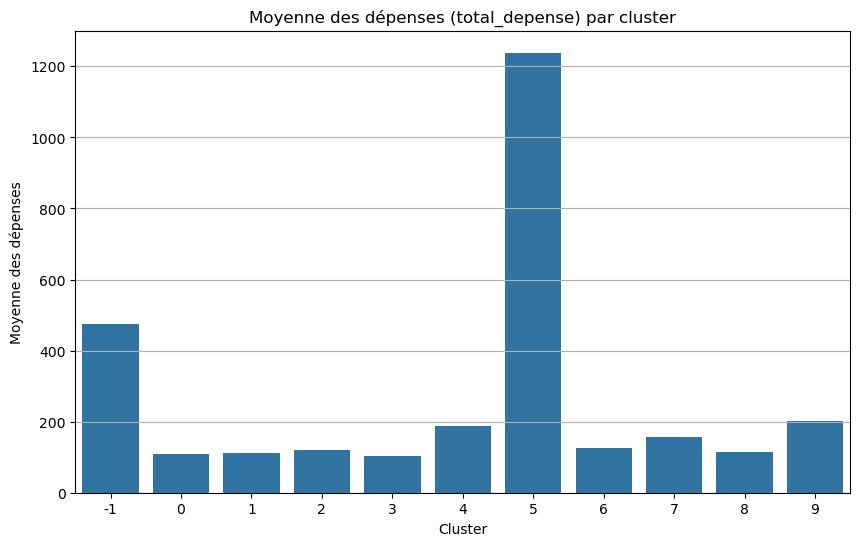

In [41]:
# Calcul de la moyenne des dépenses par cluster
mean_depense = echantillon_encoded.groupby('cluster')['total_depense'].mean()

# Barplot des moyennes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_depense.index, y=mean_depense.values)
plt.title("Moyenne des dépenses (total_depense) par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des dépenses")
plt.grid(axis='y')
plt.show()

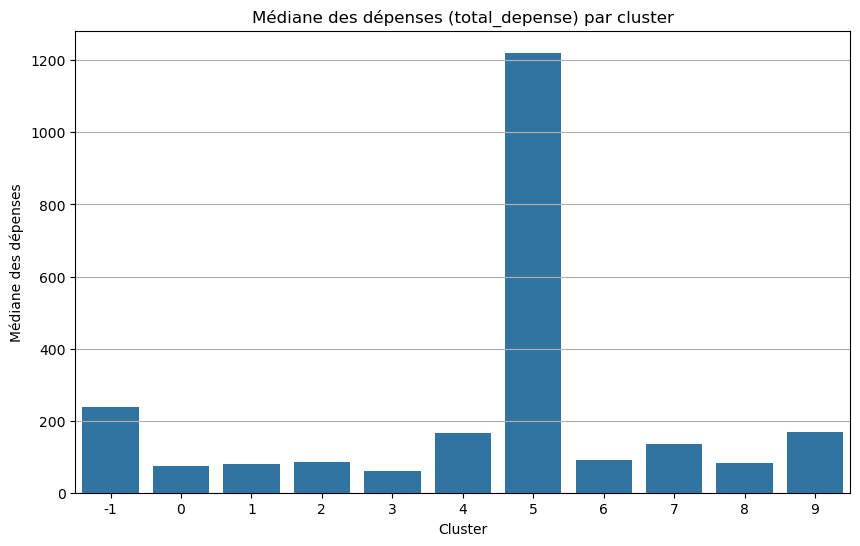

In [42]:
# Calcul de la médiane des dépenses par cluster
median_depense = echantillon_encoded.groupby('cluster')['total_depense'].median()

# Barplot des médianes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=median_depense.index, y=median_depense.values)
plt.title("Médiane des dépenses (total_depense) par cluster")
plt.xlabel("Cluster")
plt.ylabel("Médiane des dépenses")
plt.grid(axis='y')
plt.show()

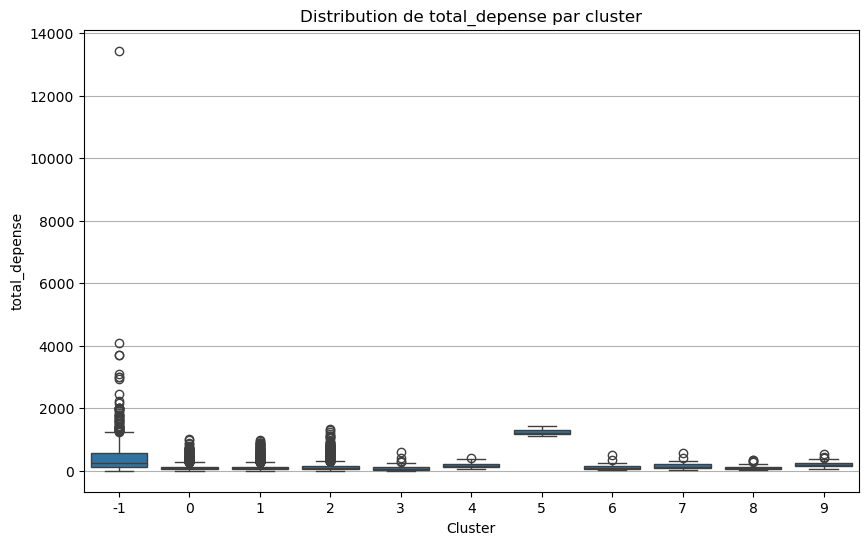

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='total_depense', data=echantillon_encoded)
plt.title(f"Distribution de total_depense par cluster")
plt.xlabel("Cluster")
plt.grid(axis='y')
plt.show()

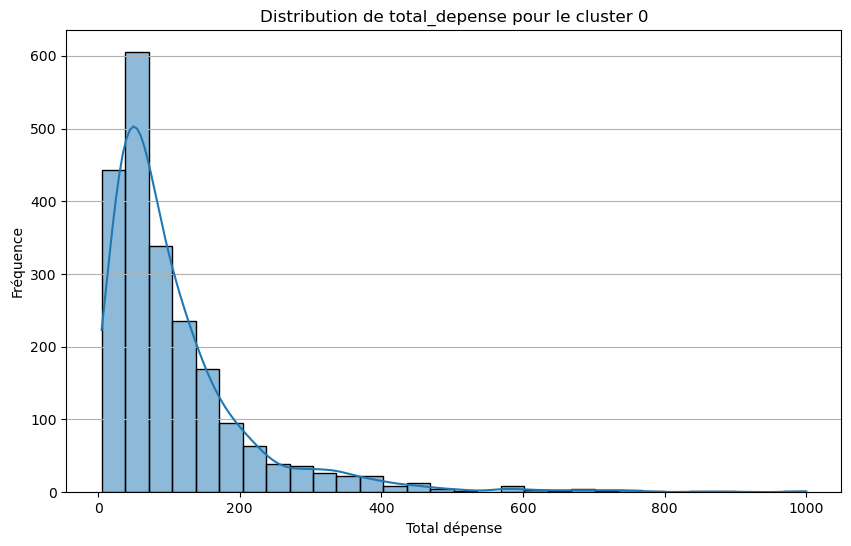

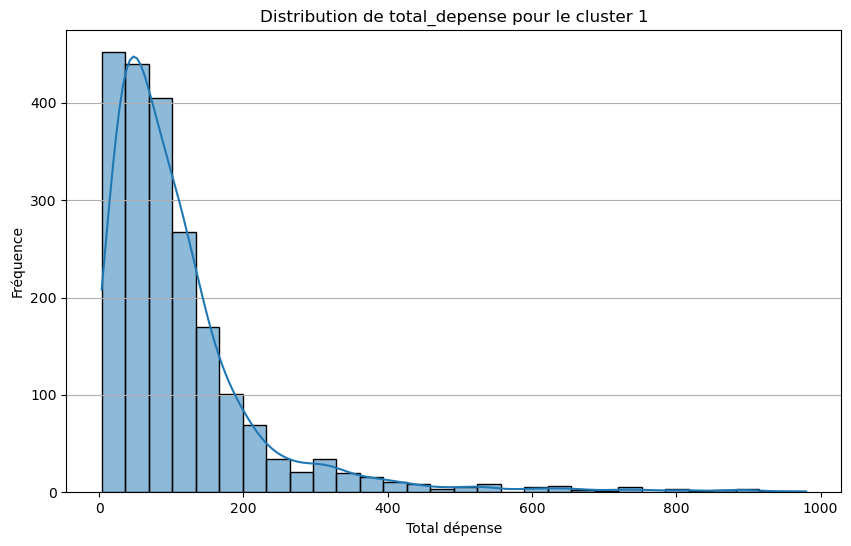

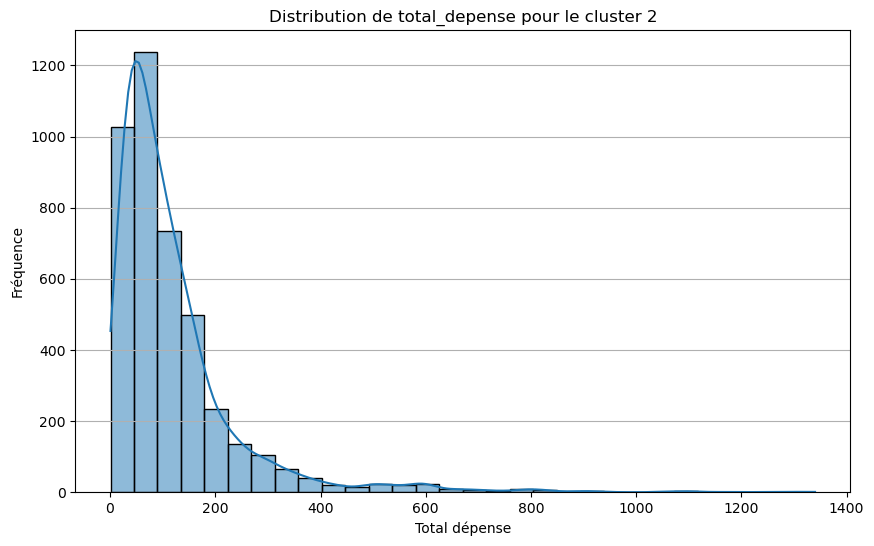

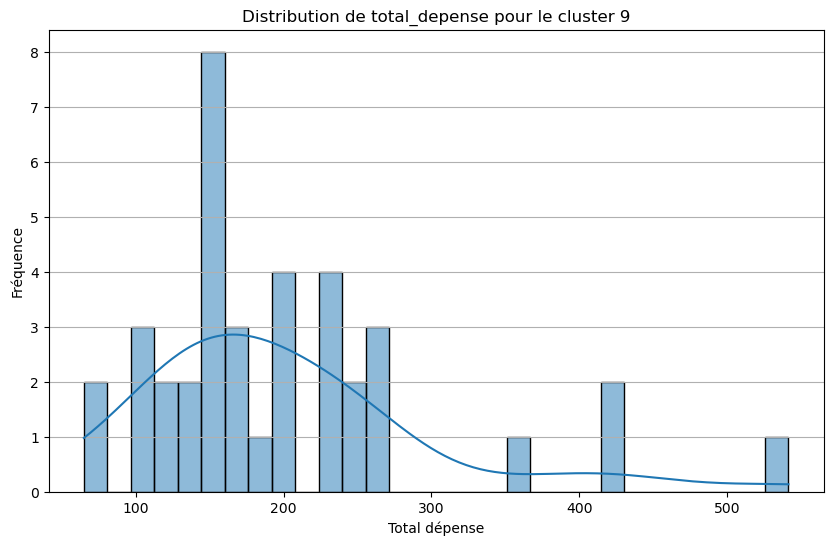

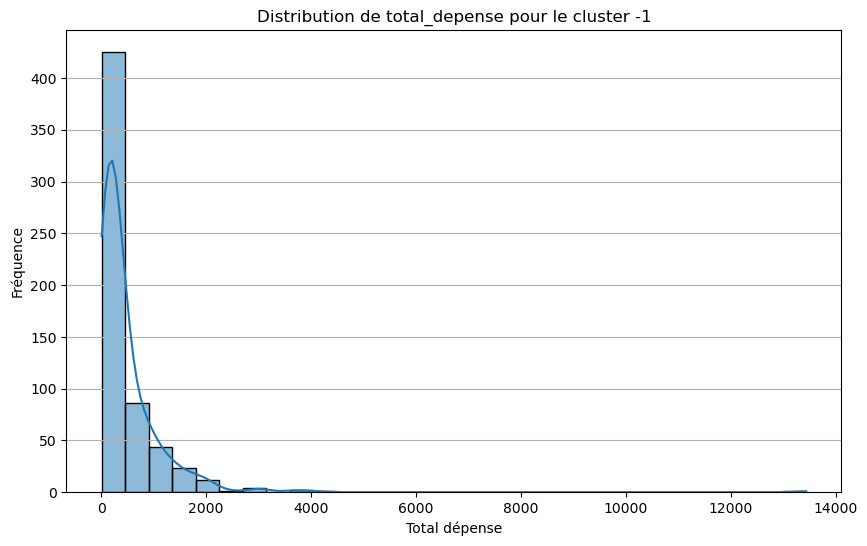

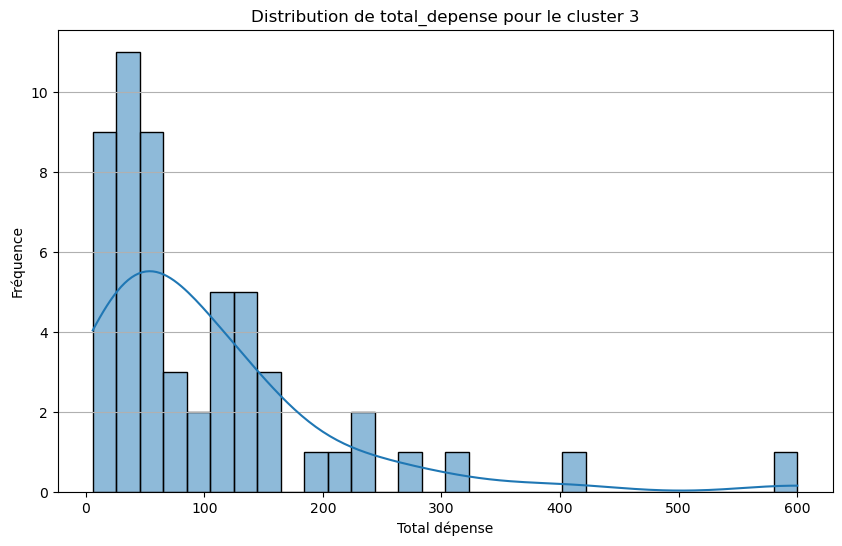

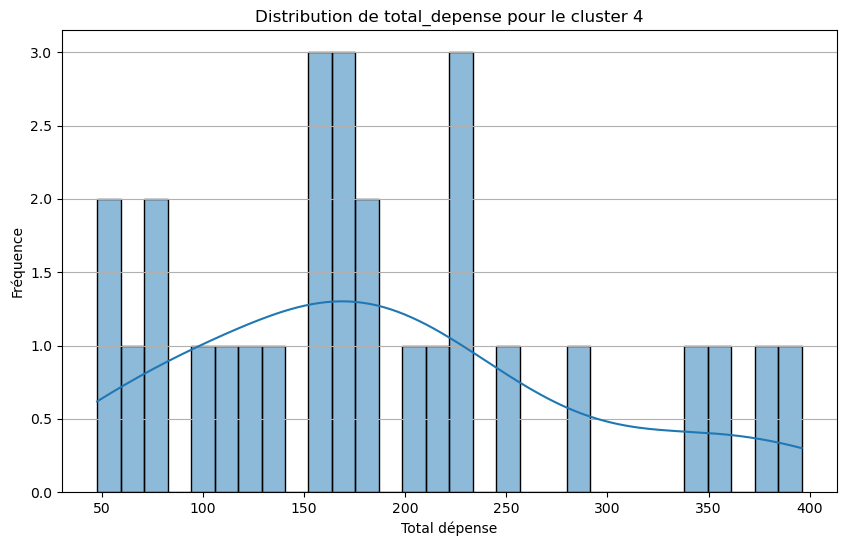

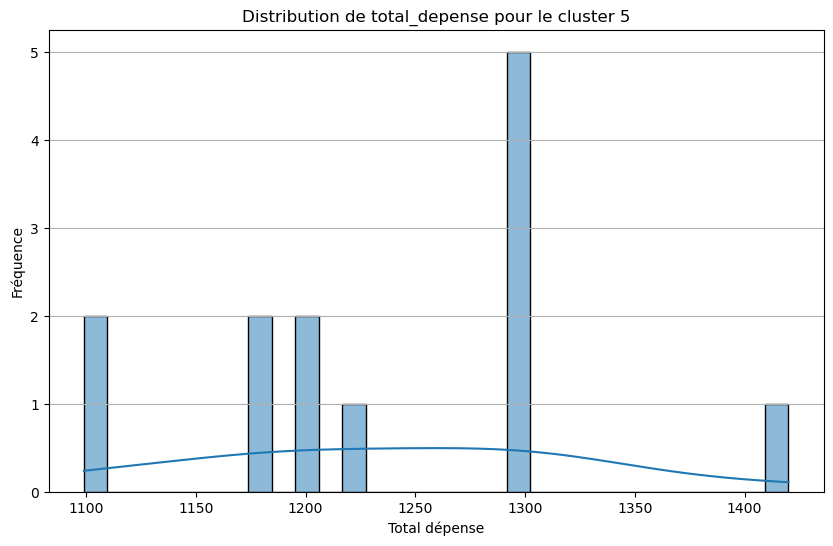

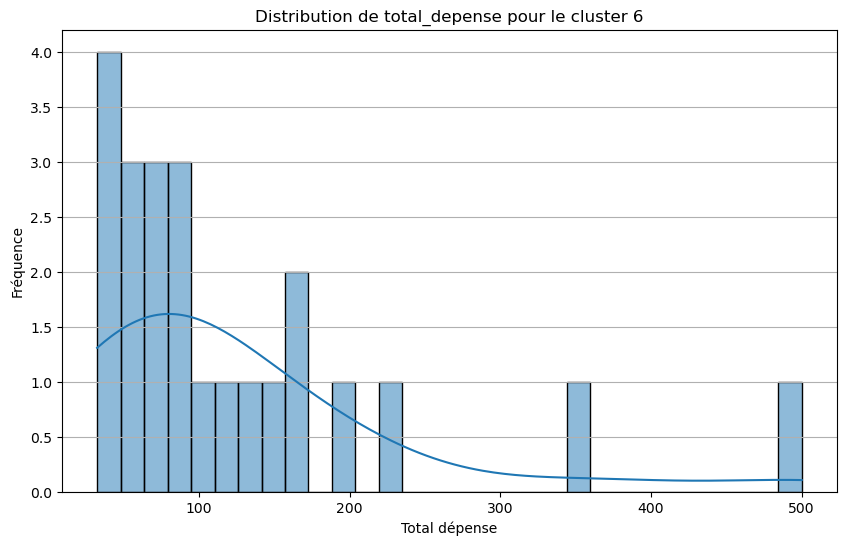

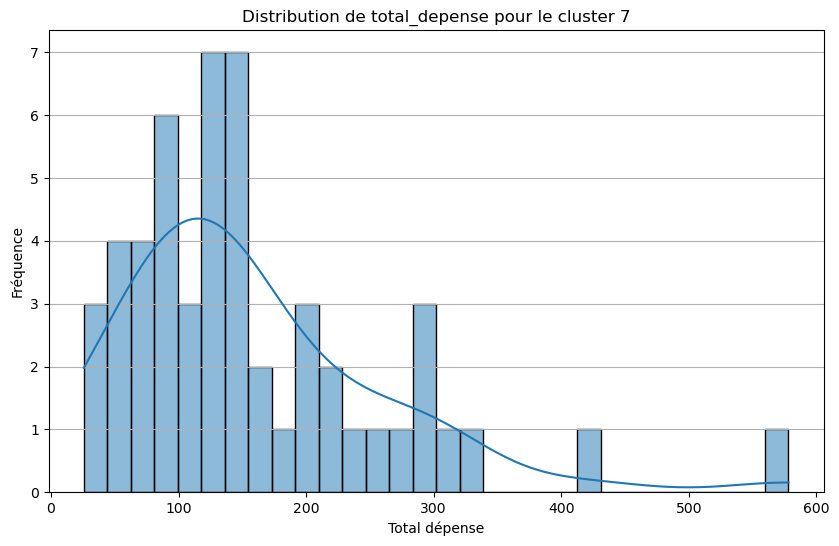

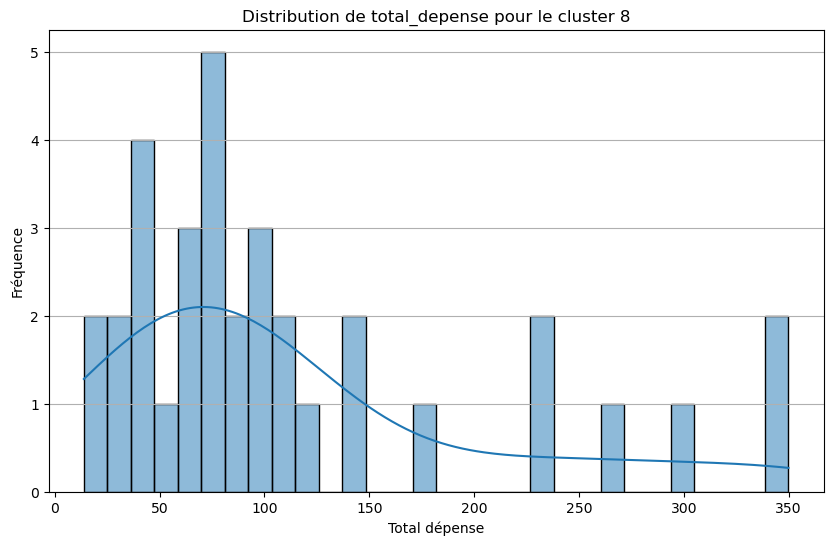

In [44]:
# Créer un graphique séparé pour chaque cluster
for cluster in echantillon_encoded['cluster'].unique():
    plt.figure(figsize=(10, 6))
    # Filtrer les données pour chaque cluster
    cluster_data = echantillon_encoded[echantillon_encoded['cluster'] == cluster]['total_depense'].dropna()
    
    # Tracer l'histogramme avec KDE pour chaque cluster
    sns.histplot(cluster_data, kde=True, bins=30)
    
    # Ajouter des titres et des labels spécifiques
    plt.title(f"Distribution de total_depense pour le cluster {cluster}")
    plt.xlabel("Total dépense")
    plt.ylabel("Fréquence")
    plt.grid(axis='y')
    
    # Afficher le graphique
    plt.show()

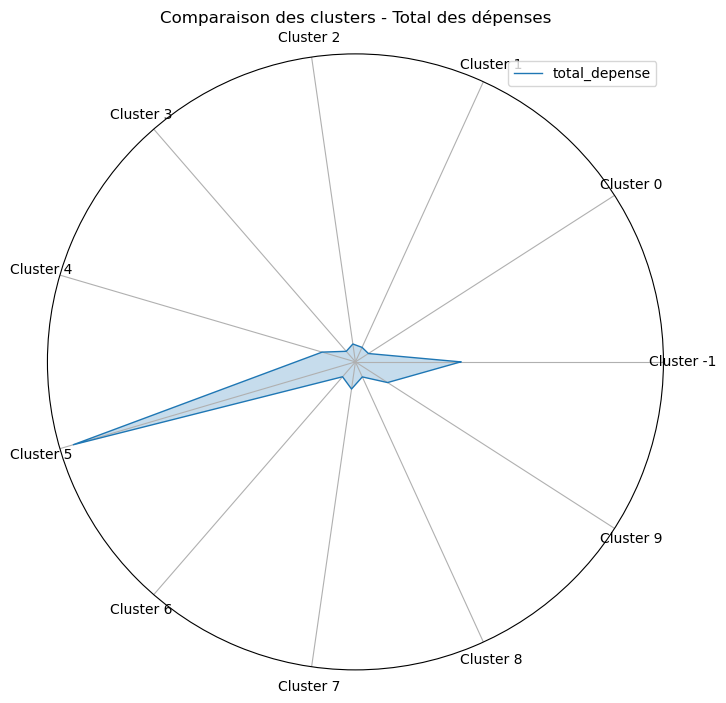

In [47]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'total_depense', "Comparaison des clusters - Total des dépenses")

**Dépense totale**
- Catégorie faible dépense : Clusters 0, 1, 2, 3, 6 ,8 (moyenne < 130).
- Catégorie moyenne dépense : Clusters 4, 7, 9 (moyenne de 150 € à 250 €).
- Catégorie dépense élevée: Cluster -1 (moyenne = 473)
- Catégorie dépense très élevée : Clusters 5 (moyenne > 1000 €).

In [48]:
# Compter les occurrences pour chaque catégorie de récence
occurrences = echantillon_encoded.groupby('cluster')[['recence_en_jours_cat_Très récent', 
                                             'recence_en_jours_cat_Ancien', 
                                             'recence_en_jours_cat_Modéré']].sum()

print("Occurrences par catégorie :")
occurrences.T

Occurrences par catégorie :


cluster                            -1     0     1     2   3   4   5   6   7  \
recence_en_jours_cat_Très récent  182     0  2094     0   0   0   0   0   0   
recence_en_jours_cat_Ancien       179  2150     0     0   0   0  13   0   0   
recence_en_jours_cat_Modéré       238     0     0  4224  55  28   0  23  52   

cluster                            8   9  
recence_en_jours_cat_Très récent   0  38  
recence_en_jours_cat_Ancien       34   0  
recence_en_jours_cat_Modéré        0   0

In [49]:
# Calculer les proportions par catégorie pour chaque cluster
proportions = occurrences.div(occurrences.sum(axis=1), axis=0)  * 100

print("Proportions par catégorie de récence (en %) :")
proportions.T

Proportions par catégorie de récence (en %) :


cluster                                  -1      0      1      2      3  \
recence_en_jours_cat_Très récent  30.383973    0.0  100.0    0.0    0.0   
recence_en_jours_cat_Ancien       29.883139  100.0    0.0    0.0    0.0   
recence_en_jours_cat_Modéré       39.732888    0.0    0.0  100.0  100.0   

cluster                               4      5      6      7      8      9  
recence_en_jours_cat_Très récent    0.0    0.0    0.0    0.0    0.0  100.0  
recence_en_jours_cat_Ancien         0.0  100.0    0.0    0.0  100.0    0.0  
recence_en_jours_cat_Modéré       100.0    0.0  100.0  100.0    0.0    0.0

**Récence**
- Clients Anciens : Cluster 0, 5, 8
- Clients Récence moyenne : Cluster  2, 3, 4, 6, 7
- Clients très récents : Cluster 1, 9
- Cluster mixtes avec récence plutot moyenne : Cluster -1

In [54]:
# Répartition complète du nombre de commandes par cluster
repartition_commandes = echantillon_encoded.groupby(['cluster', 'nb_commandes']).size().unstack(fill_value=0)

print("Répartition du nombre de commandes par cluster :")
print(repartition_commandes)

Répartition du nombre de commandes par cluster :
nb_commandes     1    2   3  4  5
cluster                          
-1             449  126  19  4  1
 0            2150    0   0  0  0
 1            2094    0   0  0  0
 2            4224    0   0  0  0
 3              55    0   0  0  0
 4               0   28   0  0  0
 5              13    0   0  0  0
 6              23    0   0  0  0
 7               0   52   0  0  0
 8              34    0   0  0  0
 9               0   38   0  0  0


In [55]:
# Calculer les proportions par catégorie pour chaque cluster
proportions = repartition_commandes.div(repartition_commandes.sum(axis=1), axis=0)  * 100

print("Proportions par nombre de commandes (en %) :")
proportions.round(2)

Proportions par nombre de commandes (en %) :


nb_commandes       1       2     3     4     5
cluster                                       
-1             74.96   21.04  3.17  0.67  0.17
 0            100.00    0.00  0.00  0.00  0.00
 1            100.00    0.00  0.00  0.00  0.00
 2            100.00    0.00  0.00  0.00  0.00
 3            100.00    0.00  0.00  0.00  0.00
 4              0.00  100.00  0.00  0.00  0.00
 5            100.00    0.00  0.00  0.00  0.00
 6            100.00    0.00  0.00  0.00  0.00
 7              0.00  100.00  0.00  0.00  0.00
 8            100.00    0.00  0.00  0.00  0.00
 9              0.00  100.00  0.00  0.00  0.00

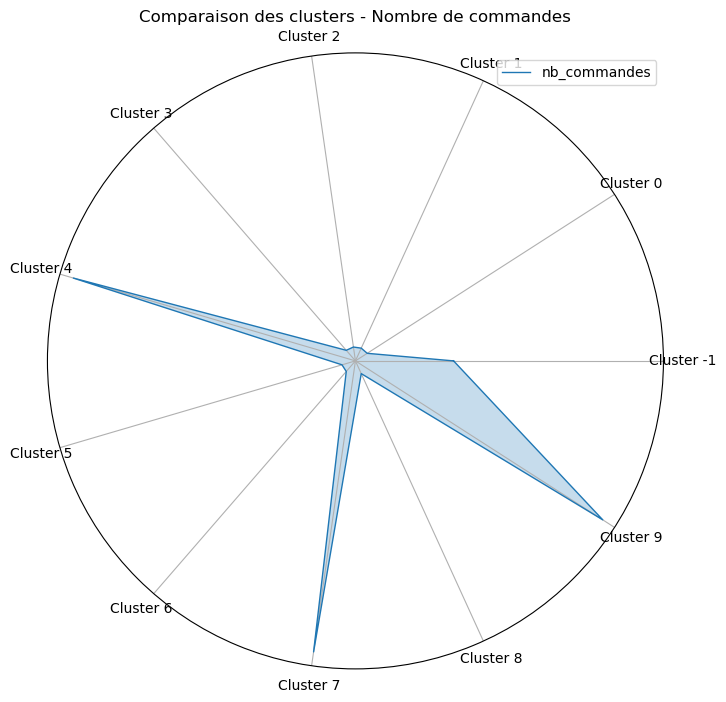

In [57]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'nb_commandes', "Comparaison des clusters - Nombre de commandes")

**Nombre de commandes**
- 1 commande : Clusters 0, 1, 2, 3, 5, 6, 8
- 2 commandes : Clusters 4, 7, 9
- Nombre de commandes mixtes : Cluster -1

| Cluster | Dépense totale        | Récence                                 | Nombre de commandes       |
|:--------|:-----------------------|:-----------------------------------------|:---------------------------|
| -1      | Forte dépense         | Récence plutot moyenne                    | Nombre de commandes mixtes |
| 0       | Faible dépense        | Clients Anciens                           | 1 commande                 |
| 1       | Faible dépense        | Clients très récents                      | 1 commande                 |
| 2       | Faible dépense        | Clients Récence moyenne                   | 1 commande                 |
| 3       | faible dépense        | Clients Récence moyenne                   | 1 commande                 |
| 4       | Moyenne dépense       | Clients Récence moyenne                   | 2 commandes                |
| 5       | Très forte dépense    | Clients Anciens                           | 1 commande                 |
| 6       | Faible dépense        | Clients Récence moyenne                   | 1 commande                 |
| 7       | Moyenne dépense       | Clients Récence moyenne                   | 2 commandes                |
| 8       | Faible dépense        | Clients Anciens                           | 1 commande                 |
| 9       | Moyenne dépense       | Clients très récents                      | 2 commandes                |

### Variables liées à la livraison

In [58]:
# Describe des variables par cluster
echantillon_encoded.groupby('cluster')[livraison].describe().T.round(2)

cluster                            -1        0        1        2      3  \
total_retards_livraison count  599.00  2150.00  2094.00  4224.00  55.00   
                        mean   -15.75   -13.64   -12.18   -10.84 -14.07   
                        std     24.01     8.30     9.20     9.20   7.31   
                        min   -140.00   -58.00   -48.00   -49.00 -31.00   
                        25%    -26.00   -18.00   -17.00   -16.00 -18.00   
                        50%    -15.00   -14.00   -11.00   -12.00 -14.00   
                        75%     -8.00    -9.00    -6.00    -7.00  -9.50   
                        max    166.00    27.00    36.00    57.00   2.00   
frais_livraison_moyens  count  599.00  2150.00  2094.00  4224.00  55.00   
                        mean    54.12    19.57    20.88    20.06  17.21   
                        std     47.97    10.78    13.46    11.86   6.80   
                        min      0.00     0.00     0.00     0.00   0.00   
                        25%     18.94    14.04    13.16    13.64  14.10   
                        50%     35.65    16.23    18.24    16.49  16.11   
                        75%     75.40    21.41    23.35    22.88  19.08   
                        max    334.14    96.66   104.80    98.02  37.90   

cluster                            4      5      6      7      8      9  
total_retards_livraison count  28.00  13.00  23.00  52.00  34.00  38.00  
                        mean  -21.18 -13.08  -9.43 -25.85 -14.97 -26.74  
                        std    10.21   4.80   6.93  10.39   6.03   9.84  
                        min   -39.00 -26.00 -22.00 -55.00 -25.00 -47.00  
                        25%   -28.25 -14.00 -14.50 -29.50 -20.00 -33.75  
                        50%   -20.50 -12.00 -10.00 -23.00 -15.00 -27.00  
                        75%   -14.75 -10.00  -6.00 -21.00 -10.00 -19.50  
                        max     0.00  -7.00   7.00  -7.00  -4.00 -10.00  
frais_livraison_moyens  count  28.00  13.00  23.00  52.00  34.00  38.00  
                        mean   17.86  34.83  19.83  16.49  17.98  23.37  
                        std     6.84  12.06  10.39   6.24   7.60  10.40  
                        min    10.40  15.58   7.78   7.58   7.78   8.40  
                        25%    12.92  25.39  12.40  11.94  14.10  15.18  
                        50%    16.83  34.72  16.98  15.46  15.69  20.64  
                        75%    20.36  41.55  23.72  18.74  20.31  30.22  
                        max    37.23  51.54  45.30  45.80  46.89  45.75

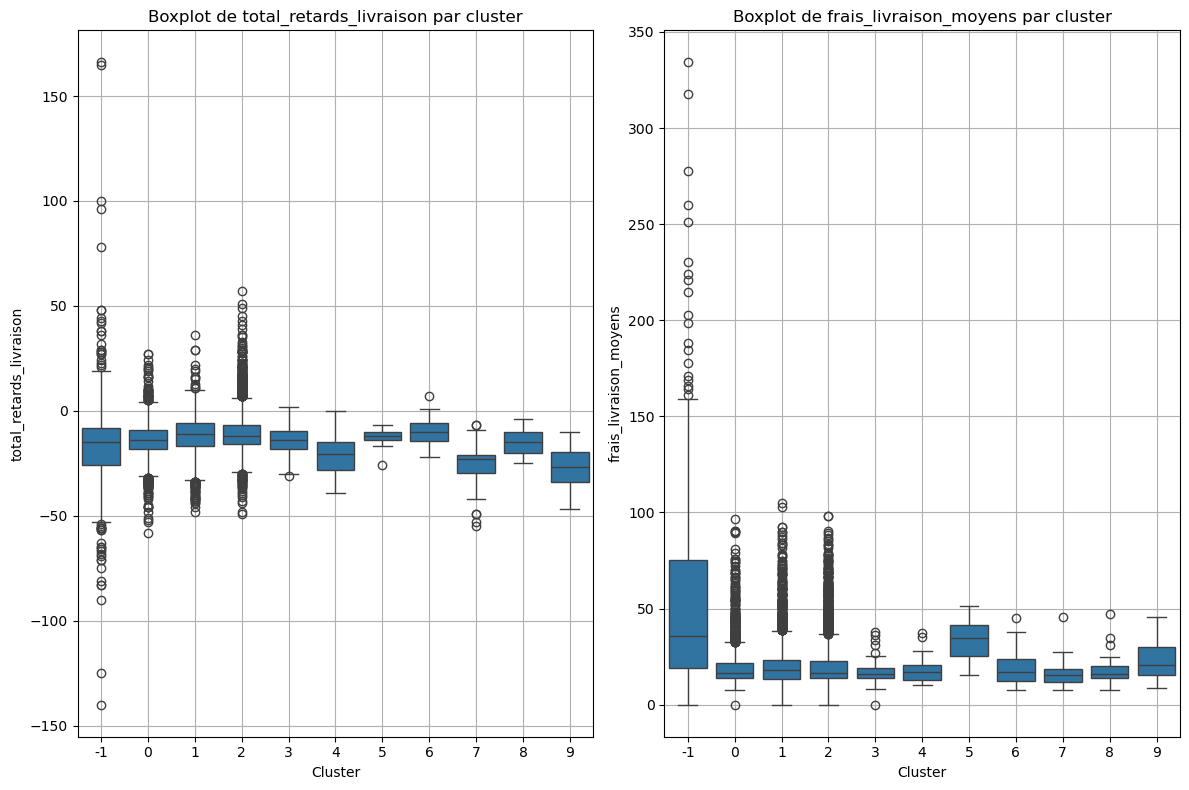

In [60]:
# Création des boxplots pour chaque variable de livraison par cluster
plt.figure(figsize=(12, 8))

for i, var in enumerate(livraison, 1):
    plt.subplot(1, 2, i)  # 2 lignes, 2 colonnes
    sns.boxplot(x='cluster', y=var, data=echantillon_encoded)
    plt.title(f"Boxplot de {var} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(var)
    plt.grid(True)

plt.tight_layout()
plt.show()

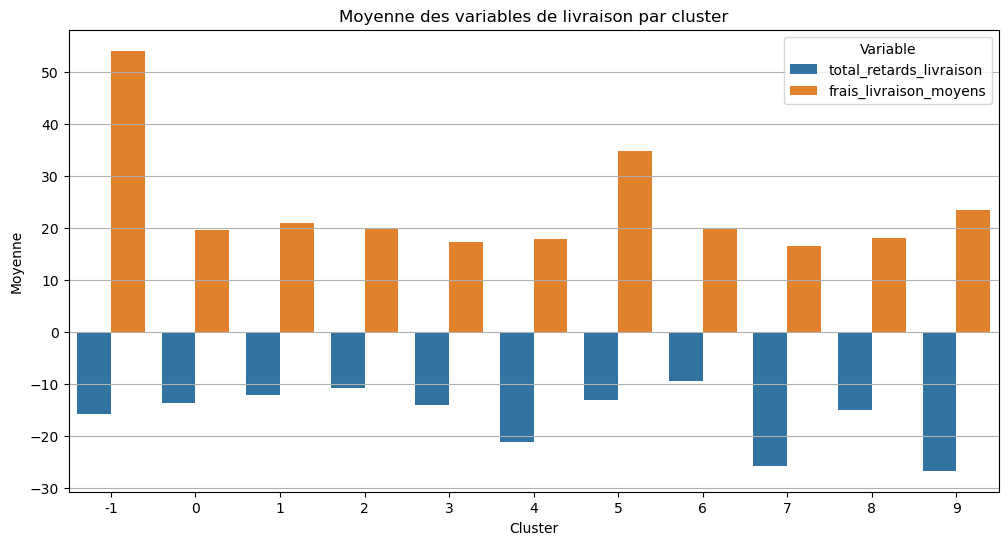

In [61]:
# Calcul de la moyenne pour chaque variable de livraison par cluster
mean_livraison = echantillon_encoded.groupby('cluster')[livraison].mean()

# Réformatage des données pour un barplot côte à côte
mean_livraison = mean_livraison.reset_index()

# Transformation des données pour un format long
mean_livraison_melted = mean_livraison.melt(id_vars='cluster', 
                                            var_name='Variable', 
                                            value_name='Moyenne')

# Création du barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='Moyenne', hue='Variable', data=mean_livraison_melted)
plt.title("Moyenne des variables de livraison par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne")
plt.grid(axis='y')
plt.legend(title='Variable')
plt.show()

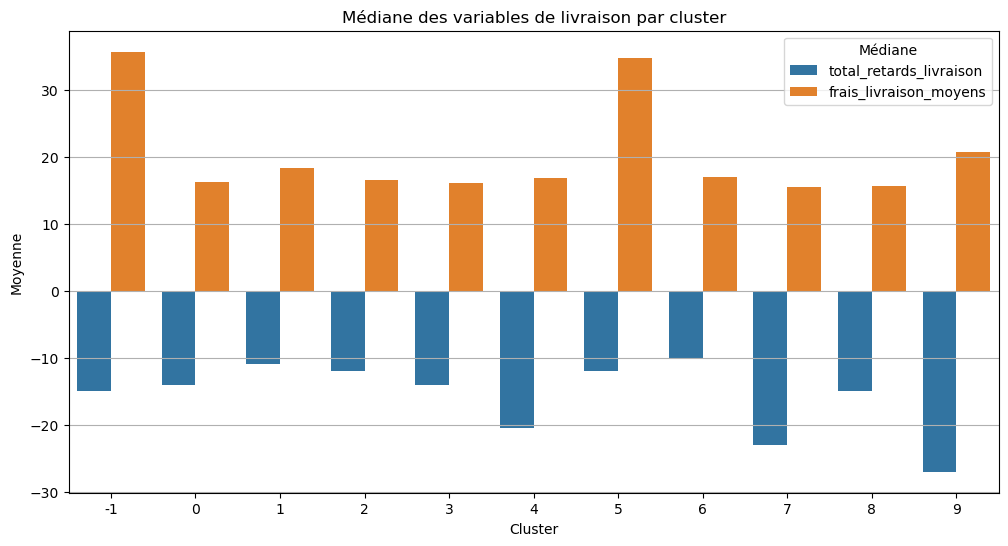

In [62]:
# Calcul de la médiane pour chaque variable de livraison par cluster
med_livraison = echantillon_encoded.groupby('cluster')[livraison].median()

# Réformatage des données pour un barplot côte à côte
med_livraison = med_livraison.reset_index()

# Transformation des données pour un format long
med_livraison_melted = med_livraison.melt(id_vars='cluster', 
                                        var_name='Variable', 
                                        value_name='Médiane')

# Création du barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='Médiane', hue='Variable', data=med_livraison_melted)
plt.title("Médiane des variables de livraison par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne")
plt.grid(axis='y')
plt.legend(title='Médiane')
plt.show()

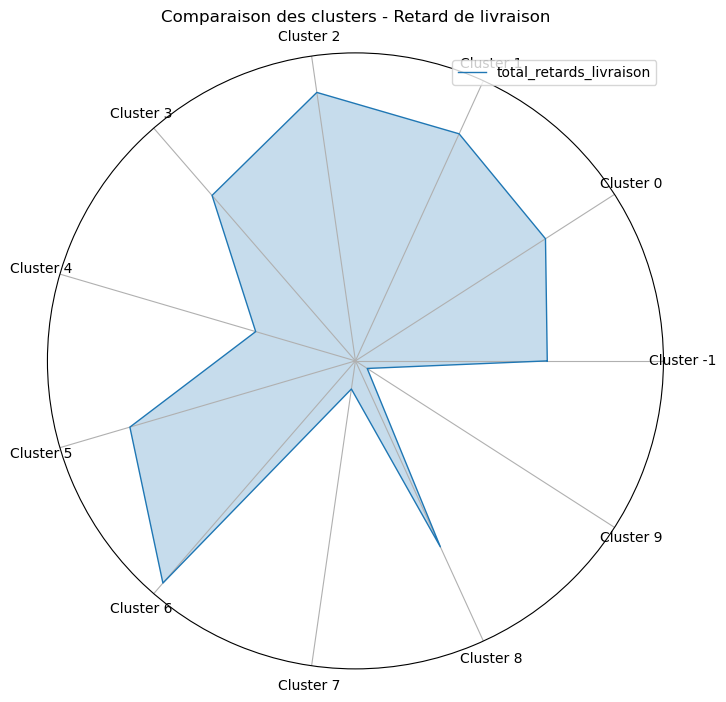

In [63]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'total_retards_livraison', "Comparaison des clusters - Retard de livraison")

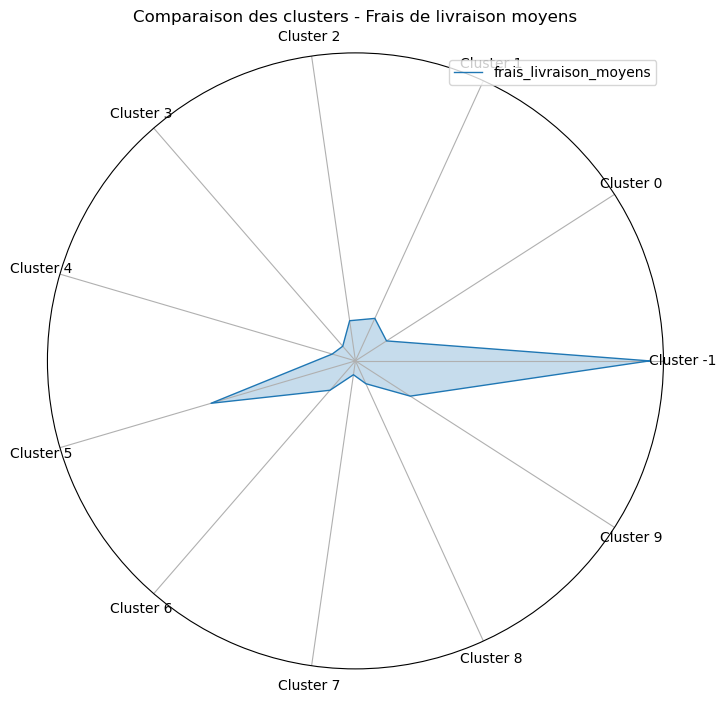

In [64]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'frais_livraison_moyens', "Comparaison des clusters - Frais de livraison moyens")

**Retard de livraison**
- Cluster 0, 1, 2, 3, 4	=> Livraisons ponctuelles
- Cluster 8, 7, 9, 5, 6  => Livraisons en avance
- Cluster -1 => Clients livrés très en avances et très en retard

**Frais de livraison**
- Clusters 7, 8, 4, 3 => Frais faibles
- Clusters 0, 1, 2, 6, 9  => Frais modérés
- Cluster  5 => Frais élevés
- Cluster -1 => Frais très élevés

| Cluster | Dépense totale        | Récence           | Nombre de commandes       | Retard de livraison                          | Frais de livraison                |
|:--------|:----------------------|:-----------------|:---------------------------|:--------------------------------------------|:----------------------------------|
| -1      | Forte dépense         | Plutôt moyenne   | Nombre de commandes mixtes  | Clients livrés très en avance et très en retard | Frais très élevés                |
| 0       | Faible dépense        | Anciens          | 1 commande                 | Livraisons ponctuelles                      | Frais modérés                    |
| 1       | Faible dépense        | Très récents     | 1 commande                 | Livraisons ponctuelles                      | Frais modérés                    |
| 2       | Faible dépense        | Récence moyenne  | 1 commande                 | Livraisons ponctuelles                      | Frais modérés                    |
| 3       | Faible dépense        | Récence moyenne  | 1 commande                 | Livraisons ponctuelles                      | Frais faibles                    |
| 4       | Moyenne dépense       | Récence moyenne  | 2 commandes                | Livraisons ponctuelles                      | Frais faibles                    |
| 5       | Très forte dépense    | Anciens          | 1 commande                 | Livraisons en avance                        | Frais élevés                     |
| 6       | Faible dépense        | Récence moyenne  | 1 commande                 | Livraisons en avance                        | Frais modérés                    |
| 7       | Moyenne dépense       | Récence moyenne  | 2 commandes                | Livraisons en avance                           | Frais faibles                    |
| 8       | Faible dépense        | Anciens          | 1 commande                 | Livraisons en avance                        | Frais faibles                    |
| 9       | Moyenne dépense       | Très récents     | 2 commandes                | Livraisons en avance                        | Frais modérés                    |


### Variables liées aux produits

In [65]:
echantillon_encoded.groupby('cluster')['poids_moyen_commandes'].describe()

count         mean           std    min       25%      50%  \
cluster                                                                
-1        599.0  8653.957874  10889.671948   87.5   850.000  3890.00   
 0       2150.0  2022.496744   3235.604348   50.0   325.000   800.00   
 1       2094.0  1513.829513   2316.469383    2.0   283.500   600.00   
 2       4224.0  1856.897017   2926.673177   50.0   300.000   650.00   
 3         55.0  1501.436364   1808.448371  100.0   400.000   800.00   
 4         28.0  1259.464286   1008.468760  274.0   489.500   742.75   
 5         13.0  2013.461538    817.300905  500.0  1550.000  2600.00   
 6         23.0  1386.173913   1037.394886  200.0   520.000  1400.00   
 7         52.0  1071.846154   1345.318195  100.0   318.750   541.50   
 8         34.0  1507.970588   1787.211345  175.0   300.000   625.00   
 9         38.0  2013.197368   1766.362006  180.0   801.875  1362.50   

              75%      max  
cluster                     
-1       13912.50  83250.0  
 0        1881.00  22350.0  
 1        1550.00  18750.0  
 2        1825.00  23250.0  
 3        1725.00   8550.0  
 4        1793.75   4025.0  
 5        2600.00   2800.0  
 6        2200.00   3500.0  
 7        1200.00   7000.0  
 8        2075.00   7200.0  
 9        2704.75   7400.0

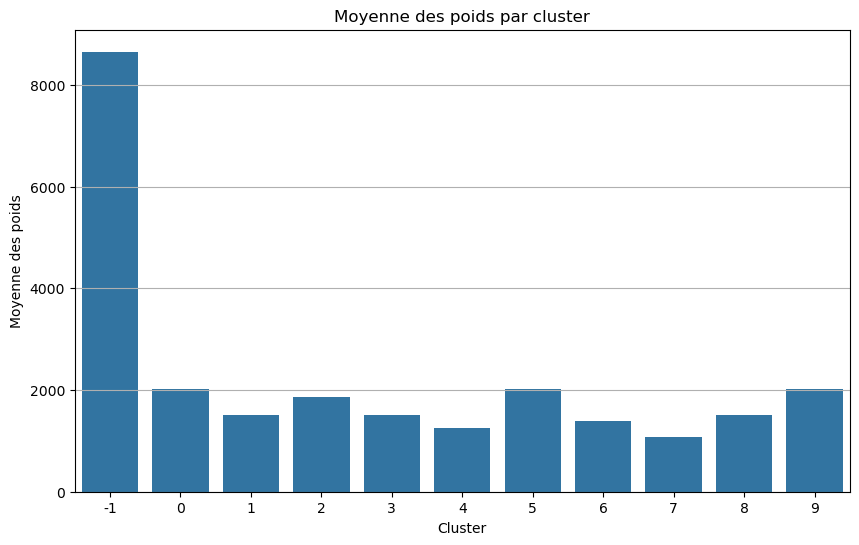

In [66]:
# Calcul de la moyenne des dépenses par cluster
mean_poids = echantillon_encoded.groupby('cluster')['poids_moyen_commandes'].mean()

# Barplot des moyennes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_poids .index, y=mean_poids.values)
plt.title("Moyenne des poids par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des poids")
plt.grid(axis='y')
plt.show()

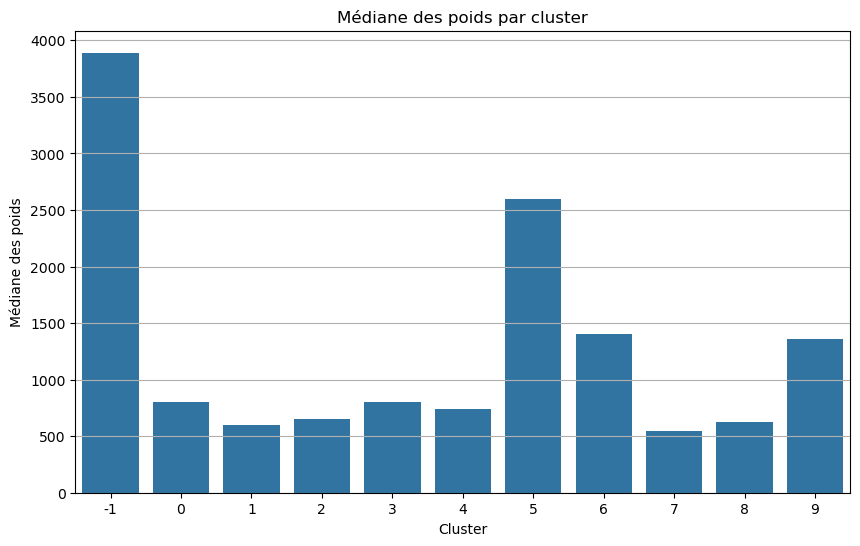

In [67]:
# Calcul de la moyenne des dépenses par cluster
med_poids = echantillon_encoded.groupby('cluster')['poids_moyen_commandes'].median()

# Barplot des moyennes de total_depense par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=med_poids .index, y=med_poids.values)
plt.title("Médiane des poids par cluster")
plt.xlabel("Cluster")
plt.ylabel("Médiane des poids")
plt.grid(axis='y')
plt.show()

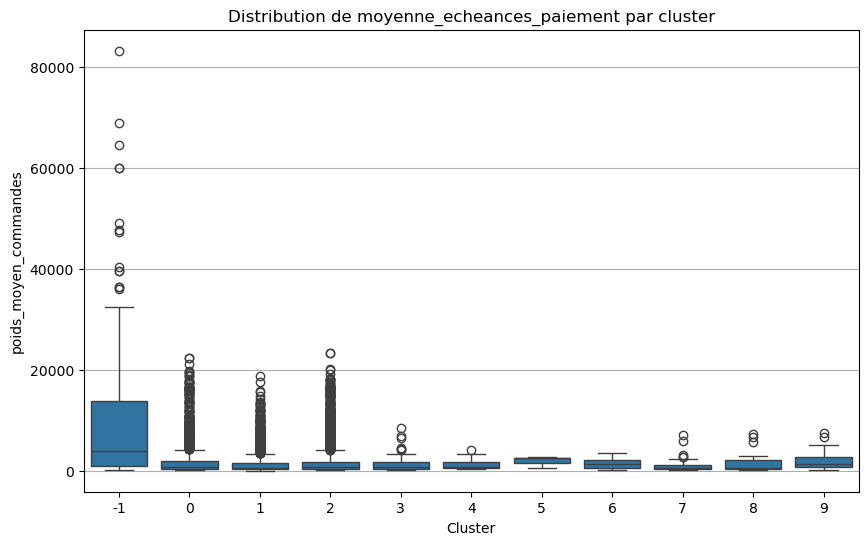

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='poids_moyen_commandes', data=echantillon_encoded)
plt.title(f"Distribution de moyenne_echeances_paiement par cluster")
plt.xlabel("Cluster")
plt.grid(axis='y')
plt.show()

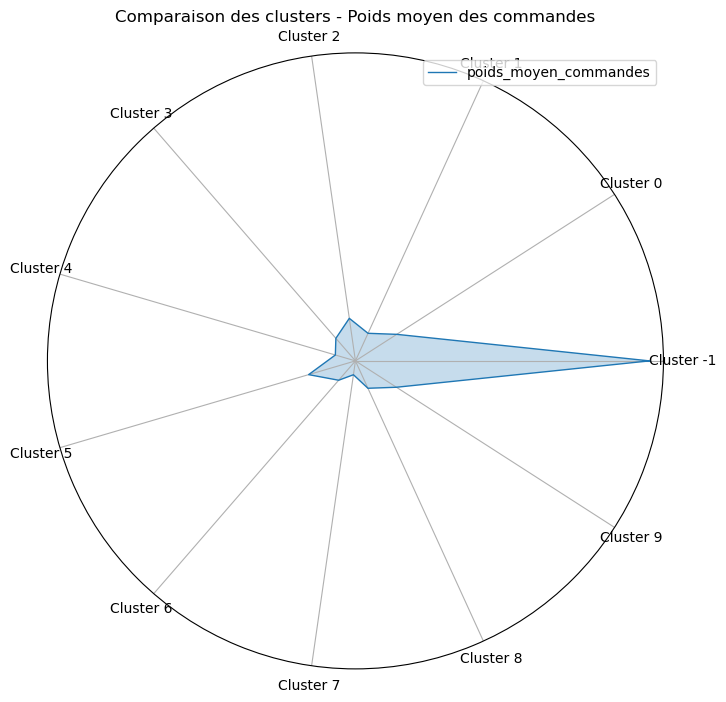

In [69]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'poids_moyen_commandes', "Comparaison des clusters - Poids moyen des commandes")

**Poids des commandes**
- Clusters 1, 4, 6, 7, 8 => Poids faible.
- Clusters  0, 2, 3, 9 => Poids modéré.
- Clusters  5 => Poids élevé.
- Cluster  -1 => Poids très élevé.

In [70]:
# Création du tableau croisé
pivot = echantillon_encoded.groupby(['cluster', 'diversite_categories']).size().unstack(fill_value=0)
pivot.T

cluster                -1     0     1     2   3   4   5   6   7   8   9
diversite_categories                                                   
1                     546  2150  2094  4224  55   0  13  23  52  34   0
2                      48     0     0     0   0  28   0   0   0   0  38
3                       5     0     0     0   0   0   0   0   0   0   0

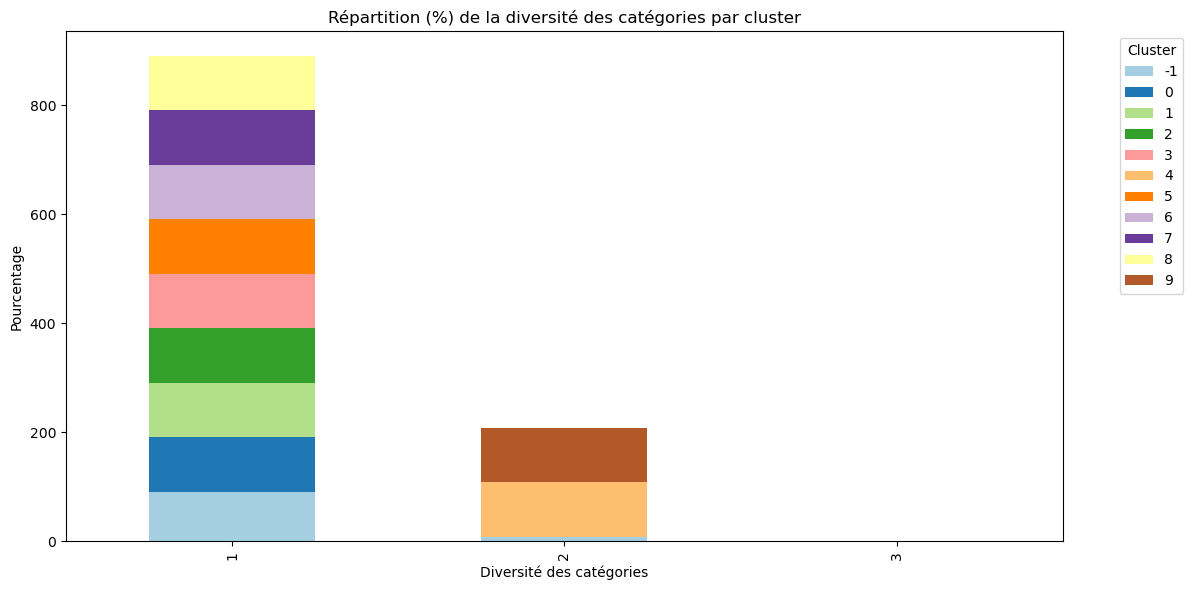

In [71]:
# Normalisation en pourcentage par cluster
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

pivot_pct.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Paired')
plt.title("Répartition (%) de la diversité des catégories par cluster")
plt.xlabel("Diversité des catégories")
plt.ylabel("Pourcentage")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

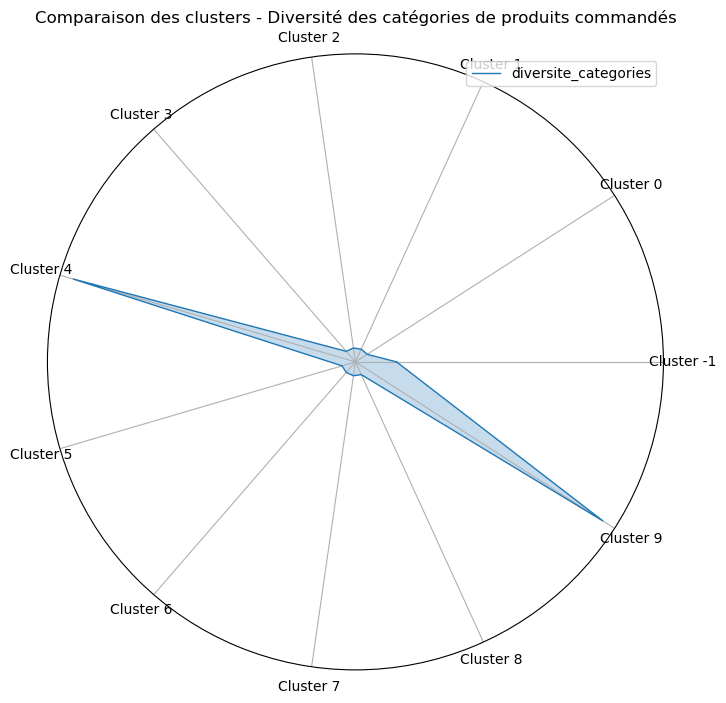

In [72]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'diversite_categories', "Comparaison des clusters - Diversité des catégories de produits commandés")

**Diversité des catégories commandées**
- Cluster 0, 1, 2, 3, 5, 6, 7, 8 => 100% des commandes sur 1 seule catégorie de produits
- Cluster -1 => Commandes diversifiées majorité de 1 catégorie
- Clusters 4, 9 => 2 catégories


| Cluster | Dépense totale       | Récence          | Nombre de commandes      | Retard de livraison                          | Frais de livraison   | Poids des commandes | Diversité des catégories commandées                       |
|:--------|:---------------------|:------------------|:--------------------------|:----------------------------------------------|:----------------------|:---------------------|:----------------------------------------------------------|
| -1      | Forte dépense        | Plutôt moyenne    | Nombre de commandes mixtes | Très en avance et très en retard              | Frais très élevés     | Très élevé           | Commandes diversifiées (majorité : 1 commande)            |
| 0       | Faible dépense       | Anciens           | 1 commande                | Ponctuelles                                   | Frais modérés         | Modéré               | 1 seule catégorie                                          |
| 1       | Faible dépense       | Très récents      | 1 commande                | Ponctuelles                                   | Frais modérés         | Faible               | 1 seule catégorie                                          |
| 2       | Faible dépense       | Récence moyenne   | 1 commande                | Ponctuelles                                   | Frais modérés         | Modéré               | 1 seule catégorie                                          |
| 3       | Faible dépense       | Récence moyenne   | 1 commande                | Ponctuelles                                   | Frais faibles         | Modéré               | 1 seule catégorie                                          |
| 4       | Moyenne dépense      | Récence moyenne   | 2 commandes               | Ponctuelles                                   | Frais faibles         | Faible               | 2 catégories                                               |
| 5       | Très forte dépense   | Anciens           | 1 commande                | En avance                                     | Frais élevés          | Élevé                | 1 seule catégorie                                          |
| 6       | Faible dépense       | Récence moyenne   | 1 commande                | En avance                                     | Frais modérés         | Faible               | 1 seule catégorie                                          |
| 7       | Moyenne dépense      | Récence moyenne   | 2 commandes               | En avance                                     | Frais faibles         | Faible               | 1 seule catégorie                                          |
| 8       | Faible dépense       | Anciens           | 1 commande                | En avance                                     | Frais faibles         | Faible               | 1 seule catégorie                                          |
| 9       | Moyenne dépense      | Très récents      | 2 commandes               | En avance                                     | Frais modérés         | Modéré               | 2 catégories                                               |


### Variables liées au paiement

In [73]:
echantillon_encoded.groupby('cluster')['nb_paiements_total'].describe().round(2)

count  mean   std  min  25%  50%  75%   max
cluster                                              
-1        599.0  1.75  1.23  1.0  1.0  1.0  2.0  13.0
 0       2150.0  1.00  0.00  1.0  1.0  1.0  1.0   1.0
 1       2094.0  1.00  0.00  1.0  1.0  1.0  1.0   1.0
 2       4224.0  1.00  0.00  1.0  1.0  1.0  1.0   1.0
 3         55.0  2.00  0.00  2.0  2.0  2.0  2.0   2.0
 4         28.0  2.00  0.00  2.0  2.0  2.0  2.0   2.0
 5         13.0  1.00  0.00  1.0  1.0  1.0  1.0   1.0
 6         23.0  1.00  0.00  1.0  1.0  1.0  1.0   1.0
 7         52.0  2.00  0.00  2.0  2.0  2.0  2.0   2.0
 8         34.0  2.00  0.00  2.0  2.0  2.0  2.0   2.0
 9         38.0  2.00  0.00  2.0  2.0  2.0  2.0   2.0

In [84]:
# Boucle sur chaque variable
for var in paiement:
    print(f"\n# Répartition de {var} par cluster ------------------")
    repartition = echantillon_encoded.groupby(['cluster', var]).size().unstack(fill_value=0)
    print(repartition.T)


# Répartition de diversite_max_paiements par cluster ------------------
cluster                   -1     0     1     2   3   4   5   6   7   8   9
diversite_max_paiements                                                   
1                        514  2150  2094  4224   0  28  13  23  52   0  38
2                         85     0     0     0  55   0   0   0   0  34   0

# Répartition de nb_paiements_total par cluster ------------------
cluster              -1     0     1     2   3   4   5   6   7   8   9
nb_paiements_total                                                   
1                   315  2150  2094  4224   0   0  13  23   0   0   0
2                   206     0     0     0  55  28   0   0  52  34  38
3                    43     0     0     0   0   0   0   0   0   0   0
4                    16     0     0     0   0   0   0   0   0   0   0
5                     8     0     0     0   0   0   0   0   0   0   0
6                     5     0     0     0   0   0   0   0   0   0   0

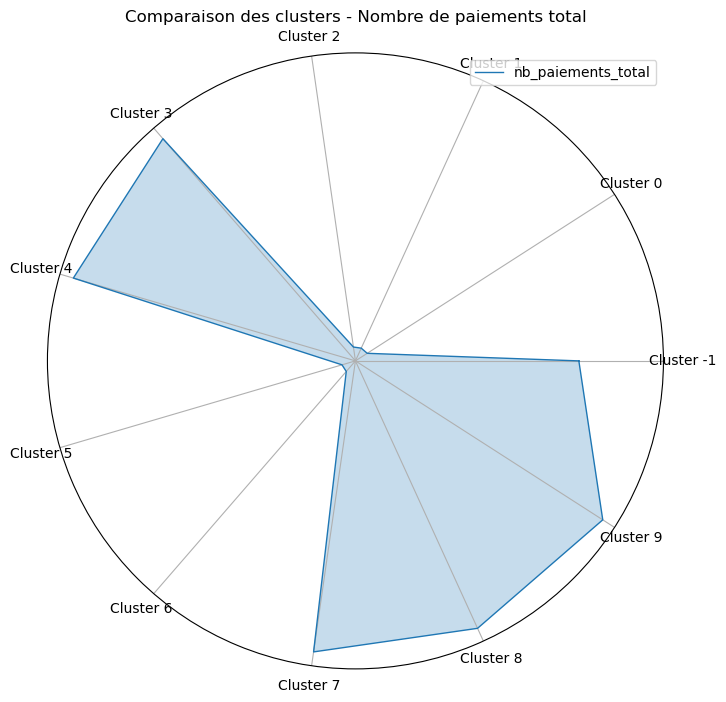

In [75]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'nb_paiements_total', "Comparaison des clusters - Nombre de paiements total")

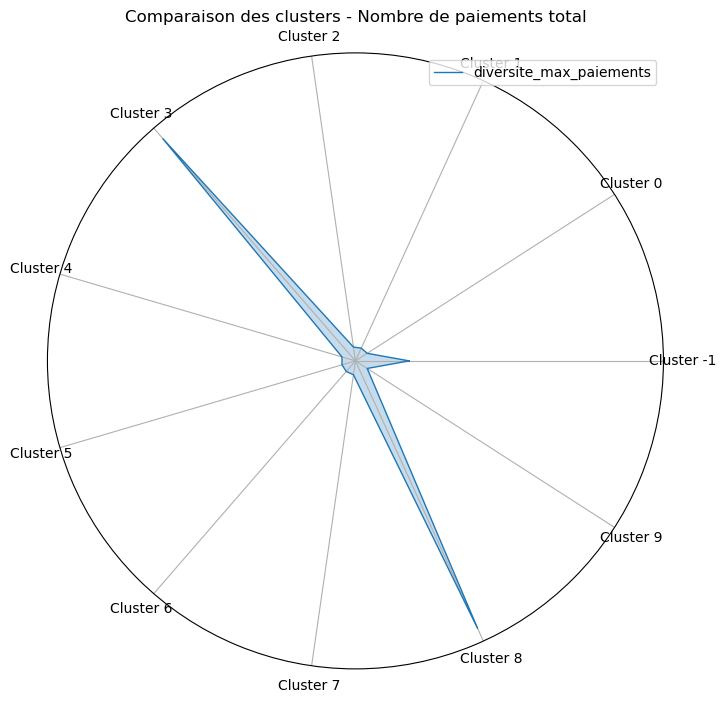

In [76]:
plot_single_variable_spider(echantillon_encoded.groupby('cluster').mean(),
                            'diversite_max_paiements', "Comparaison des clusters - Nombre de paiements total")

**Diversité maximum de paiements**
- cluster -1, 0, 1, 2, 4, 5, 6, 7, 9,  => Clients homogènes
- cluster 3, 8 =>  Clients diversifiés

**Nombre de paiement pour une commande**
- Clusters 0, 1, 2, 5, 6  => Paiement unique
- Cluster 3, 4, 7, 8, 9 => 2 Paiements 
- Cluster -1 => De 1 paiement à 13 paiements

| Cluster | Dépense totale       | Récence          | Nombre de commandes      | Retard de livraison                          | Frais de livraison   | Poids des commandes | Diversité des catégories commandées                       | Diversité maximum de paiements | Nombre de paiement pour une commande |
|:--------|:---------------------|:------------------|:--------------------------|:----------------------------------------------|:----------------------|:---------------------|:----------------------------------------------------------|:-------------------------------|:-------------------------------------|
| -1      | Forte dépense        | Plutôt moyenne    | Nombre de commandes mixtes | Très en avance et très en retard              | Frais très élevés     | Très élevé           | Commandes diversifiées (majorité : 1 commande)            | Clients homogènes              | De 1 paiement à 13 paiements         |
| 0       | Faible dépense       | Anciens           | 1 commande                | Ponctuelles                                   | Frais modérés         | Modéré               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      |
| 1       | Faible dépense       | Très récents      | 1 commande                | Ponctuelles                                   | Frais modérés         | Faible               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      |
| 2       | Faible dépense       | Récence moyenne   | 1 commande                | Ponctuelles                                   | Frais modérés         | Modéré               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      |
| 3       | Faible dépense       | Récence moyenne   | 1 commande                | Ponctuelles                                   | Frais faibles         | Modéré               | 1 seule catégorie                                          | Clients diversifiés            |  2 paiements                    |
| 4       | Moyenne dépense      | Récence moyenne   | 2 commandes               | Ponctuelles                                   | Frais faibles         | Faible               | 2 catégories                                               | Clients homogènes              | 2 paiements                    |
| 5       | Très forte dépense   | Anciens           | 1 commande                | En avance                                     | Frais élevés          | Élevé                | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      |
| 6       | Faible dépense       | Récence moyenne   | 1 commande                | En avance                                     | Frais modérés         | Faible               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      |
| 7       | Moyenne dépense      | Récence moyenne   | 2 commandes               | En avance                                     | Frais faibles         | Faible               | 1 seule catégorie                                          | Clients homogènes              | 2 paiements                    |
| 8       | Faible dépense       | Anciens           | 1 commande                | En avance                                     | Frais faibles         | Faible               | 1 seule catégorie                                          | Clients diversifiés            | 2 paiements                    |
| 9       | Moyenne dépense      | Très récents      | 2 commandes               | En avance                                     | Frais modérés         | Modéré               | 2 catégories                                               | Clients homogènes              | 2 paiements                      |


### Variables liées à la satisfaction client

In [77]:
echantillon_encoded.groupby('cluster')[satisfaction_client].describe().T.round(2)

cluster                        -1        0        1        2      3      4  \
note_moyenne_client count  599.00  2150.00  2094.00  4224.00  55.00  28.00   
                    mean     3.57     4.27     4.31     4.07   4.42   4.39   
                    std      1.57     1.16     1.16     1.33   0.83   0.86   
                    min      1.00     1.00     1.00     1.00   2.00   2.00   
                    25%      2.00     4.00     4.00     4.00   4.00   3.50   
                    50%      4.00     5.00     5.00     5.00   5.00   5.00   
                    75%      5.00     5.00     5.00     5.00   5.00   5.00   
                    max      5.00     5.00     5.00     5.00   5.00   5.00   
a_donne_une_note    count  599.00  2150.00  2094.00  4224.00  55.00  28.00   
                    mean     0.96     1.00     1.00     1.00   1.00   1.00   
                    std      0.20     0.00     0.00     0.00   0.00   0.00   
                    min      0.00     1.00     1.00     1.00   1.00   1.00   
                    25%      1.00     1.00     1.00     1.00   1.00   1.00   
                    50%      1.00     1.00     1.00     1.00   1.00   1.00   
                    75%      1.00     1.00     1.00     1.00   1.00   1.00   
                    max      1.00     1.00     1.00     1.00   1.00   1.00   

cluster                       5     6      7      8      9  
note_moyenne_client count  13.0  23.0  52.00  34.00  38.00  
                    mean    5.0   4.0   4.25   4.44   4.46  
                    std     0.0   0.0   0.89   0.79   0.77  
                    min     5.0   4.0   2.00   3.00   2.50  
                    25%     5.0   4.0   4.00   4.00   4.00  
                    50%     5.0   4.0   4.50   5.00   5.00  
                    75%     5.0   4.0   5.00   5.00   5.00  
                    max     5.0   4.0   5.00   5.00   5.00  
a_donne_une_note    count  13.0  23.0  52.00  34.00  38.00  
                    mean    1.0   0.0   1.00   1.00   1.00  
                    std     0.0   0.0   0.00   0.00   0.00  
                    min     1.0   0.0   1.00   1.00   1.00  
                    25%     1.0   0.0   1.00   1.00   1.00  
                    50%     1.0   0.0   1.00   1.00   1.00  
                    75%     1.0   0.0   1.00   1.00   1.00  
                    max     1.0   0.0   1.00   1.00   1.00

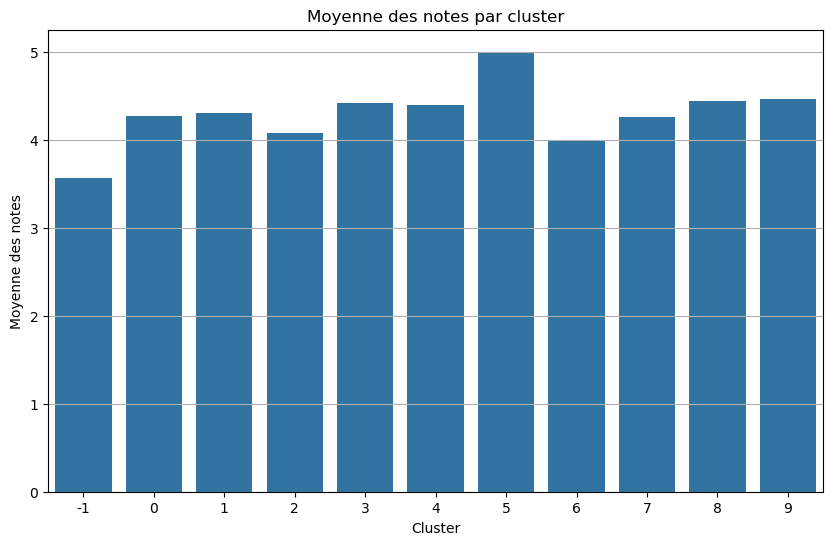

In [78]:
# Calcul de la moyenne des notes par cluster
mean_note = echantillon_encoded.groupby('cluster')['note_moyenne_client'].mean()

# Barplot des moyennes de échéances par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_note.index, y=mean_note.values)
plt.title("Moyenne des notes par cluster")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des notes")
plt.grid(axis='y')
plt.show()

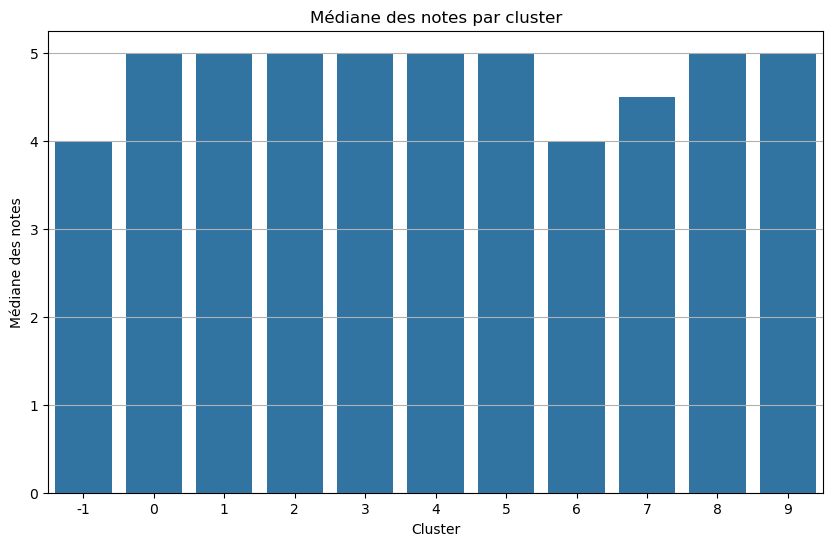

In [79]:
# Calcul de la moédiane des notes par cluster
med_note = echantillon_encoded.groupby('cluster')['note_moyenne_client'].median()

# Barplot des moyennes de échéances par cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=med_note.index, y=med_note.values)
plt.title("Médiane des notes par cluster")
plt.xlabel("Cluster")
plt.ylabel("Médiane des notes")
plt.grid(axis='y')
plt.show()

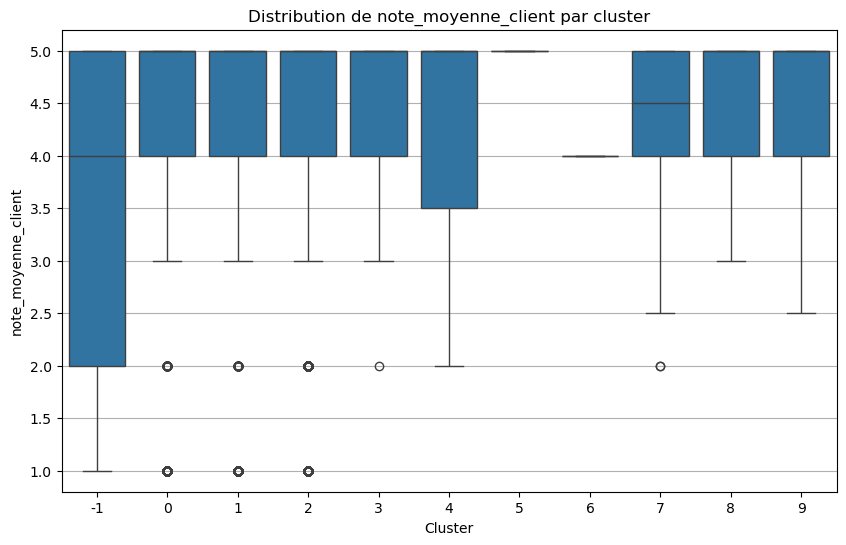

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='note_moyenne_client', data=echantillon_encoded)
plt.title(f"Distribution de note_moyenne_client par cluster")
plt.xlabel("Cluster")
plt.grid(axis='y')
plt.show()

**note_moyenne_client**
- Cluster -1 => Clients insatisfaits (majorité ont donné une note)
- Cluster  5 => Clients très satisfaits
- Clusters 0, 1, 2, 3, 4, 7, 8, 9 => Clients satisfaits
- Cluster 6  => Clients qui n'ont pas donné de notes

In [82]:
# Nombre de notes par cluster
note_par_cluster = echantillon_encoded.groupby('cluster')['a_donne_une_note'].sum().astype(int)

# Nombre total de clients par cluster
nb_clients_par_cluster = echantillon_encoded.groupby('cluster').size()

# Calcul de la proportion
proportion_par_cluster = (note_par_cluster / nb_clients_par_cluster * 100).round(2)

# Combinaison dans un DataFrame
note_et_proportion = pd.DataFrame({
    'Nombre de notes': note_par_cluster,
    'Nombre total de clients': nb_clients_par_cluster,
    'Proportion (%)': proportion_par_cluster
})

print("Nombre et proportion de 'a_donne_une_note' par cluster :")
print(note_et_proportion)

Nombre et proportion de 'a_donne_une_note' par cluster :
         Nombre de notes  Nombre total de clients  Proportion (%)
cluster                                                          
-1                   574                      599           95.83
 0                  2150                     2150          100.00
 1                  2094                     2094          100.00
 2                  4224                     4224          100.00
 3                    55                       55          100.00
 4                    28                       28          100.00
 5                    13                       13          100.00
 6                     0                       23            0.00
 7                    52                       52          100.00
 8                    34                       34          100.00
 9                    38                       38          100.00


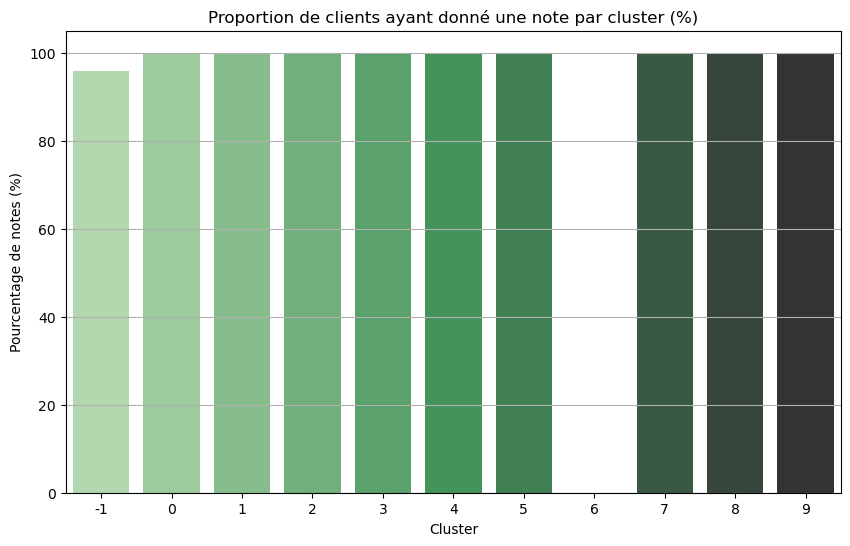

In [83]:
# Calcul de la proportion
proportion_notes = (note_par_cluster / nb_clients_par_cluster * 100).reset_index()
proportion_notes.columns = ['cluster', 'pourcentage_note']

# Barplot des proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='pourcentage_note', hue='cluster', data=proportion_notes, palette='Greens_d', legend=False)
plt.title("Proportion de clients ayant donné une note par cluster (%)")
plt.xlabel("Cluster")
plt.ylabel("Pourcentage de notes (%)")
plt.grid(axis='y')
plt.show()

**a_donne_une_note**
- Clusters 0, 1, 2,3, 4, 5, 6, 7, 8, 9: Clients actifs => ont donné des notes
- Cluster  6 : Clients inactifs => aucune note ni commentaire
- Cluster -1 : Clients ayant donné une note majoritaires

| Cluster | Dépense totale       | Récence          | Nombre de commandes      | Retard de livraison                          | Frais de livraison   | Poids des commandes | Diversité des catégories commandées                       | Diversité maximum de paiements | Nombre de paiement pour une commande | Satisfaction client     |
|:--------|:---------------------|:------------------|:--------------------------|:----------------------------------------------|:----------------------|:---------------------|:----------------------------------------------------------|:-------------------------------|:-------------------------------------|:------------------------|
| -1      | Forte dépense        | Plutôt moyenne    | Nombre de commandes mixtes | **Très en avance et très en retard**              | **Frais très élevés**     | **Très élevé**           | Commandes diversifiées (majorité : 1 commande)            | Clients homogènes              | **De 1 paiement à 13 paiements**         | **Clients insatisfaits**    |
| 0       | Faible dépense       | Anciens           | 1 commande                | Ponctuelles                                   | Frais modérés         | Modéré               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      | Clients satisfaits      |
| 1       | Faible dépense       | **Très récents**      | 1 commande                | Ponctuelles                                   | Frais modérés         | Faible               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      | Clients satisfaits      |
| 2       | Faible dépense       | Récence moyenne   | 1 commande                | Ponctuelles                                   | Frais modérés         | Modéré               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      | Clients satisfaits      |
| 3       | Faible dépense       | Récence moyenne   | 1 commande                | Ponctuelles                                   | Frais faibles         | Modéré               | 1 seule catégorie                                          | Clients diversifiés            | 2 paiements                          | Clients satisfaits      |
| 4       | Moyenne dépense      | Récence moyenne   | 2 commandes               | Ponctuelles                                   | Frais faibles         | Faible               | 2 catégories                                               | Clients homogènes              | 2 paiements                          | Clients satisfaits      |
| 5       | **Très forte dépense**   | Anciens           | 1 commande                | En avance                                     | Frais élevés          | Élevé                | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      | **Clients très satisfaits** |
| 6       | Faible dépense       | Récence moyenne   | 1 commande                | En avance                                     | Frais modérés         | Faible               | 1 seule catégorie                                          | Clients homogènes              | Paiement unique                      | Sans note               |
| 7       | Moyenne dépense      | Récence moyenne   | 2 commandes               | En avance                                     | Frais faibles         | Faible               | 1 seule catégorie                                          | Clients homogènes              | 2 paiements                          | Clients satisfaits      |
| 8       | Faible dépense       | Anciens           | 1 commande                | En avance                                     | Frais faibles         | Faible               | 1 seule catégorie                                          | Clients diversifiés            | 2 paiements                          | Clients satisfaits      |
| 9       | Moyenne dépense      | **Très récents**      | 2 commandes               | En avance                                     | Frais modérés         | Modéré               | 2 catégories                                               | Clients homogènes              | 2 paiements                          | Clients satisfaits 

## Synthèse des Clusters et Recommandations Marketing

Proposition de regroupement selon le comportement et la satisfaction :
- **Cluster -1 : Clients à risque / instables**
- - Très hétérogènes (commandes irrégulières, paiement variable, retards et avances extrêmes)
- - Frais et poids très élevés
- - Clients insatisfaits 

À traiter à part : segment instable, potentiellement problématique ou VIP à recadrer.<br>


- **Clients récents, peu coûteux mais satisfaits (Clusters 1, 2, 3, 6)**
- - Faible dépense, récence moyenne ou très récente
- - 1 seule commande
- - Livraison en avance ou ponctuelle
- - Frais modérés/faibles, faible poids
- - Satisfaction présente ou pas de note 

Cibles pour fidélisation ou relance douce. Bon premier contact.

- **Clients plus engagés, dépenses modérées (Clusters 4, 7, 9)**
- - 2 commandes
- - Dépense moyenne, frais faibles/modérés
- - Livraisons ponctuelles ou en avance
- - Poids faible à modéré
- - Clients satisfaits

Cibles pour montée en gamme ou offres personnalisées.

- **Client premium isolé (Cluster 5)**
- - Très forte dépense
- - Ancien client
- - 1 commande mais très satisfaite
- - Poids élevé, frais élevés

Cible VIP : surveiller l’inactivité et relancer avec du sur-mesure.

- **Clients anciens peu actifs mais satisfaits (Cluster 0, 8)**
- - Faible dépense
- - Anciens
- - 1 commande, livraison à l’heure ou en avance
- - Satisfaits

Potentiel de réactivation si bien ciblé.

| Segment                         | Clusters Inclus     | Caractéristiques Clés                                                  | Recommandation Marketing                   |
|:---------------------------------|:---------------------|:-----------------------------------------------------------------------|:-------------------------------------------|
| Clients à risque / instables     | -1                   | Dépenses élevées mais hétérogènes<br>Comportements irréguliers<br>Insatisfaction | Audit ciblé pour résoudre problèmes         |
| Nouveaux clients, dépenses faibles      | 1, 2, 3, 6           | Faible dépense<br>Récence moyenne ou très récente<br>Satisfaction correcte        | Fidélisation douce                          |
| Clients engagés, dépenses modérées | 4, 7, 9             | Dépense moyenne<br>Deux commandes<br>Satisfaction élevée                        | Cross-selling et montée en gamme            |
| Client premium isolé             | 5                    | Très forte dépense<br>Ancien client<br>Satisfaction exceptionnelle              | Offres VIP                                  |
| Clients anciens peu actifs       | 0, 8                 | Faible dépense<br>Anciens clients<br>Satisfaits                                 | Réactivation ciblée                         |


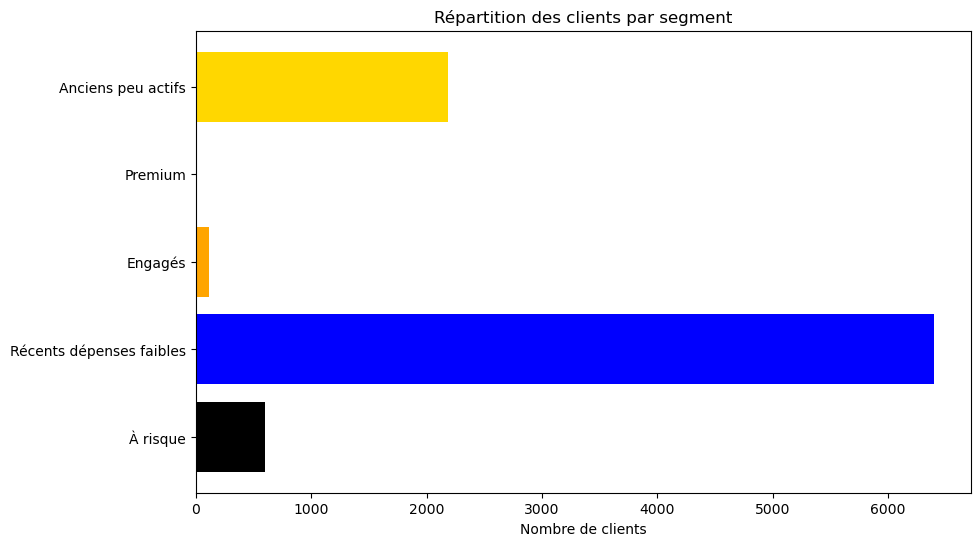

In [108]:
# Distribution après regroupement
segments = ['À risque', 'Récents dépenses faibles', 'Engagés', 'Premium', 'Anciens peu actifs']
effectifs = [599, (2094+4224+55+23), (28+52+38), 13, (2150+34)]

plt.figure(figsize=(10,6))
plt.barh(segments, effectifs, color=['black', 'blue', 'orange', 'red', 'gold'])
plt.title('Répartition des clients par segment')
plt.xlabel('Nombre de clients')
plt.show()

In [113]:
# Définir une fonction pour regrouper les clusters en segments
def regrouper_clusters(cluster):
    """
    Regroupe les clients en segments basés sur leur numéro de cluster.

    Arguments :
    -----------
    cluster : int
        Le numéro du cluster auquel appartient un client. Les clusters sont regroupés
        dans des segments pré-définis en fonction des caractéristiques des clients.

    Retour :
    --------
    str
        Le nom du segment auquel appartient le client (par exemple, "Clients à risque / instables", 
        "Clients récents peu coûteux", etc.).

    Description :
    -------------
    Cette fonction attribue un segment à un client en fonction du cluster auquel il appartient. 
    Chaque cluster est associé à un segment de clients spécifiques. Si le cluster n'est pas 
    prévu dans les cas définis, le segment retourné est "Inconnu".
    """
    if cluster == -1:
        return "Clients à risque / instables"
    elif cluster in [1, 2, 3, 6]:
        return "Clients récents peu coûteux"
    elif cluster in [4, 7, 9]:
        return "Clients plus engagés, dépenses modérées"
    elif cluster == 5:
        return "Client premium isolé"
    elif cluster in [0, 8]:
        return "Clients anciens peu actifs"
    else:
        return "Inconnu"  # Au cas où un cluster inattendu apparaîtrait

# Créer un nouveau DataFrame 
echantillon_standardized_regroupe = echantillon_standardized.copy()

# Appliquer la fonction de regroupement au DataFrame
echantillon_standardized_regroupe['segment'] = echantillon_standardized['cluster'].apply(regrouper_clusters)


# Vérifier la distribution des segments regroupés
print(echantillon_standardized_regroupe['segment'].value_counts())

segment
Clients récents peu coûteux                6396
Clients anciens peu actifs                 2184
Clients à risque / instables                599
Clients plus engagés, dépenses modérées     118
Client premium isolé                         13
Name: count, dtype: int64


In [116]:
# Créer un nouveau DataFrame 
echantillon_standardized_regroupe = echantillon_standardized.copy()

# Créer une fonction pour regrouper les clusters et attribuer des numéros
def regrouper_clusters_numerique(cluster):
    """
    Regroupe les clients en segments numériques basés sur leur numéro de cluster.

    Arguments :
    -----------
    cluster : int
        Le numéro du cluster auquel appartient un client. Les clusters sont regroupés
        dans des segments numériques pour une meilleure manipulation dans les analyses quantitatives.

    Retour :
    --------
    int
        Un identifiant numérique pour le segment du client, où chaque segment est attribué
        à un numéro unique. Les segments sont les suivants :
        - 0 : Clients à risque / instables
        - 1 : Nouveaux clients, dépenses faibles
        - 2 : Clients plus engagés, dépenses modérées
        - 3 : Client premium isolé
        - 4 : Clients anciens peu actifs
        - -1 : Inconnu (au cas où un cluster inattendu apparaît)

    Description :
    -------------
    Cette fonction attribue un numéro de segment à un client en fonction du cluster auquel il appartient.
    Chaque cluster est associé à un segment numérique spécifique pour simplifier les calculs ou analyses
    quantitatives basées sur ces segments. Si un cluster inconnu est détecté, le numéro -1 est retourné.
    """
    if cluster == -1:
        return 0  # Clients à risque / instables
    elif cluster in [1, 2, 3, 6]:
        return 1  # Nouveaux clients, dépenses faibles
    elif cluster in [4, 7, 9]:
        return 2  # Clients plus engagés, dépenses modérées
    elif cluster == 5:
        return 3  # Client premium isolé
    elif cluster in [0, 8]:
        return 4  # Clients anciens peu actifs
    else:
        return -1  # Inconnu (par sécurité)

# Appliquer la fonction pour créer une nouvelle colonne 'segment_num'
echantillon_standardized_regroupe['segment_num'] = echantillon_standardized['cluster'].apply(regrouper_clusters_numerique)

# Supprimer la colonne 'cluster' si elle n'est plus nécessaire
echantillon_standardized_regroupe.drop(columns=['cluster'], inplace=True)

# Vérifier la distribution des nouveaux segments numériques
print(echantillon_standardized_regroupe['segment_num'].value_counts())

# Afficher les premières lignes du DataFrame final
print(echantillon_standardized_regroupe.head())

segment_num
1    6396
4    2184
0     599
2     118
3      13
Name: count, dtype: int64
   nb_commandes  total_depense  frais_livraison_moyens  poids_moyen_commandes  \
0     -0.162222      -0.545584               -0.294404              -0.481515   
1     -0.162222      -0.367732               -0.437419              -0.363810   
2     -0.162222      -0.364037                0.255244               0.154091   
3     -0.162222      -0.448984               -0.437952              -0.469744   
4     -0.162222      -0.448903               -0.749063              -0.506468   

   diversite_categories  total_retards_livraison  nb_paiements_total  \
0             -0.111709                -0.989369           -0.181627   
1             -0.111709                -1.915557           -0.181627   
2             -0.111709                -0.341038           -0.181627   
3             -0.111709                 0.122056           -0.181627   
4             -0.111709                 0.307293           -0.181

## Visualisation Multidimensionnelle des Clusters

### Visualisation avec ACP (Analyse en Composantes Principales)

In [85]:
# Application de l'ACP
pca = PCA(n_components=5)  # Calculer plusieurs composantes
pca.fit(echantillon_standardized.values)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

print("Variance expliquée par les composantes :")
for i, var in enumerate(explained_variance):
    print(f"Composante {i + 1}: {var:.2%}")

# Somme des deux premières composantes
print(f"\nVariance totale expliquée par les deux premières composantes : {sum(explained_variance[:2]):.2%}")

Variance expliquée par les composantes :
Composante 1: 18.91%
Composante 2: 15.35%
Composante 3: 12.80%
Composante 4: 9.62%
Composante 5: 8.35%

Variance totale expliquée par les deux premières composantes : 34.26%


L'Analyse en Composantes Principales (ACP) a permis d'extraire plusieurs composantes principales, chacune expliquant une part de la variance totale des données. Voici les résultats obtenus :
- Composante 1 : 18.91% de la variance expliquée.
- Composante 2 : 15.35% de la variance expliquée.
- Composante 3 : 12.80% de la variance expliquée.

Les deux premières composantes principales expliquent ensemble 34.26% de la variance totale, ce qui est insuffisant pour capturer une représentation claire et complète des données. En ajoutant la troisième composante, nous atteignons une variance cumulée de 47.06%, ce qui représente une amélioration significative. On va utiliser la visualisation en 3D pour mieux représenter les relations entre les clusters, mais nous présenterons également une visualisation en 2D pour comparer les deux approches.

#### Visualisation en 2D

In [101]:
def plot_pca_clusters(data, labels, title="Visualisation des Clusters avec ACP"):
    """
    Applique une ACP pour réduire les dimensions à 2 et visualise les clusters avec des couleurs distinctes.
    
    Paramètres :
    - data : ndarray ou DataFrame, contenant les données (n_samples, n_features)
    - labels : ndarray ou liste, étiquettes de cluster associées à chaque observation
    - title : str, titre du graphique
    
    Affiche un graphique 2D représentant les clusters projetés sur les deux premières composantes principales.
    """

    # Réduction des dimensions à 2 via ACP (Analyse en Composantes Principales)
    pca = PCA(n_components=2)
    components = pca.fit_transform(data)

    # Préparer la figure
    plt.figure(figsize=(10, 8))

    # Identifier les clusters uniques pour leur assigner des couleurs
    unique_labels = np.unique(labels)

    # Palette de couleurs (ici : jusqu'à 20 couleurs avec 'tab20')
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    # Tracer chaque groupe de points appartenant à un cluster
    for idx, cluster in enumerate(unique_labels):
        cluster_points = components[labels == cluster]  # Filtrer les points du cluster courant
        plt.scatter(
            cluster_points[:, 0],  # Axe x : 1re composante principale
            cluster_points[:, 1],  # Axe y : 2e composante principale
            label=f"Cluster {cluster}",  # Légende du cluster
            color=cmap(idx),  # Couleur assignée
            alpha=0.7  # Transparence
        )

    # Mise en forme finale du graphique
    plt.title(title)
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.legend()
    plt.show()

C:\Users\joan6\AppData\Local\Temp\ipykernel_37668\2249185419.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


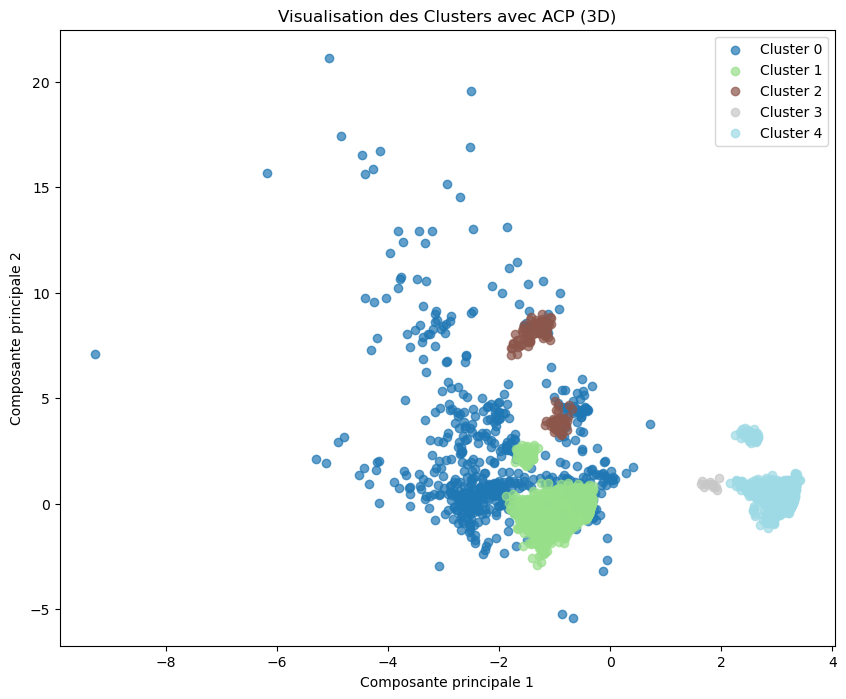

In [117]:
plot_pca_clusters(echantillon_standardized_regroupe.values, echantillon_standardized_regroupe["segment_num"].values, "Visualisation des Clusters avec ACP (3D)")

- Les clusters 4 et 3 montrent une séparation relativement nette.
- Les clusters 0, 1  et 2 se chevauchent.

#### Visualisation en 3D

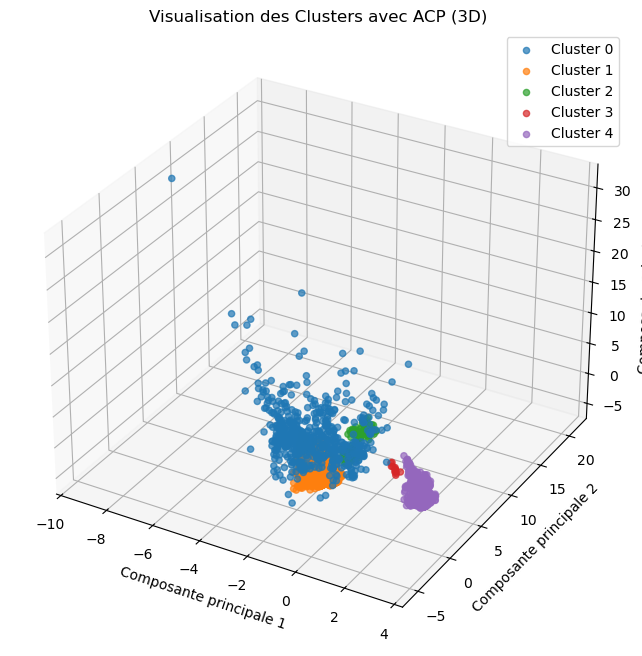

In [118]:
plot_pca_3d(echantillon_standardized_regroupe.values, echantillon_standardized_regroupe["segment_num"].values, "Visualisation des Clusters avec ACP (3D)")

Dans la visualisation en 3D: 
- Les clusters 4 et 3 montrent une séparation relativement nette.
- Les clusters 0, 1  et 2 se chevauchent.

### Visualisation avec t-SNE (t-Distributed Stochastic Neighbor Embedding)

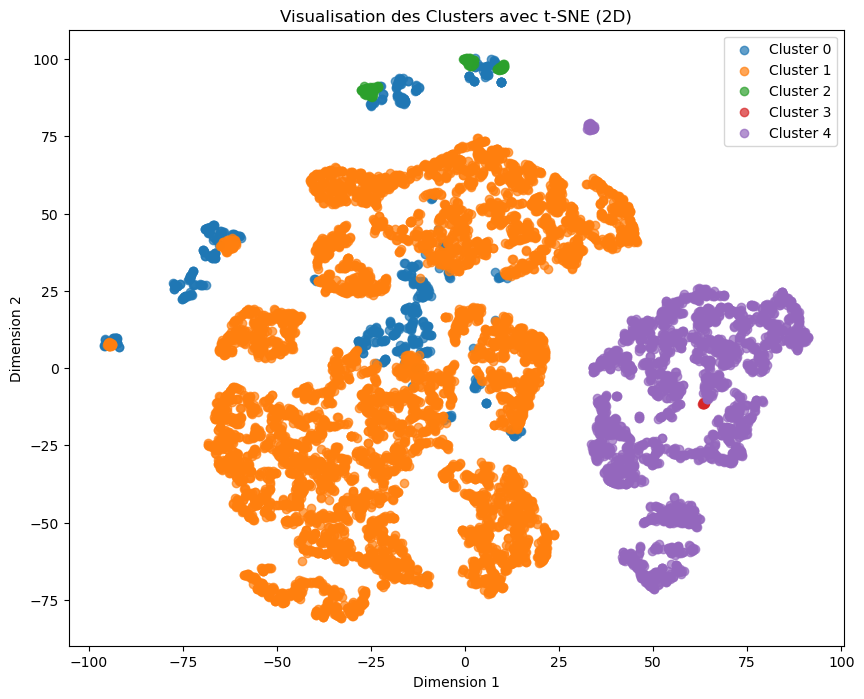

In [119]:
# Application de t-SNE
# Réduction de la dimensionnalité des données à 2 dimensions pour la visualisation
tsne = TSNE(n_components=2, random_state=42)  
tsne_components = tsne.fit_transform(echantillon_standardized_regroupe.values)  # Transformation des données standardisées

# Visualisation des clusters
plt.figure(figsize=(10, 8)) 

# Boucle pour afficher chaque cluster avec une couleur différente
unique_labels = np.unique(echantillon_standardized_regroupe["segment_num"].values)  # Extraction des labels uniques 
for cluster in unique_labels:
    # Points appartenant au cluster courant
    cluster_points = tsne_components[echantillon_standardized_regroupe["segment_num"].values == cluster]  
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)  # Affichage du cluster

# Ajout du titre et des légendes au graphique
plt.title("Visualisation des Clusters avec t-SNE (2D)")  
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")  
plt.legend()  
plt.show()

# Conclusion: Choix du modèle

Pour comparer les deux modèles (K-Means et DBSCAN) et choisir le meilleur, il est important de s'appuyer sur des critères objectifs tels que les métriques de clustering, la qualité des visualisations et la pertinence des segments pour notre objectif (différencier les bons clients et les clients satisfaits). 

**Analyse des métriques de clustering**
**K-Means**
- Inertie intra-cluster : 461 701 → Indique une **bonne compacité des clusters**.
- Silhouette Score : 0.440 → Relativement bon, montre que les **clusters sont bien séparés**.
- Davies-Bouldin Index : 0.975 → Faible valeur, ce qui est positif (**les clusters sont bien définis**).
- Calinski-Harabasz Index : 21 564 → Très élevé, ce qui est excellent pour la **séparation des clusters**.

**DBSCAN**
- Silhouette Score : 0.412 → Légèrement inférieur à celui de K-Means, ce qui indique une séparation un peu moins nette.
- Davies-Bouldin Index : 1.464 → Plus élevé que celui de K-Means, ce qui suggère que les clusters sont moins bien définis.
- Calinski-Harabasz Index : 742 → Beaucoup plus faible que celui de K-Means, ce qui reflète une séparation moins nette.

K-Means semble meilleur sur le plan des métriques, avec des scores globalement plus élevés pour la compacité et la séparation des clusters.

**Analyse des visualisations**
**K-Means**
- Les clusters sont globalement bien distincts, notamment les clusters 1, 2 et 3.
- Quelques chevauchements mineurs entre certains clusters (ex. entre les clusters 0 et 1, ou entre les clusters 3 et 4).
- La visualisation t-SNE montre une bonne séparation globale avec quelques zones de transition.

**DBSCAN**
- Les clusters montrent un chevauchement significatif (ex. entre les clusters 0, 1 et 2).
- Certains points classés comme bruit (-1) pourraient contenir des informations utiles.
- La séparation est moins nette dans certaines zones.

K-Means offre une meilleure séparation visuelle, avec des clusters plus distincts dans l'espace t-SNE.

**Pertinence des segments pour notre objectif**<br>
Notre objectif est de différencier :
- Les bons clients (ceux qui génèrent une forte valeur).
- Les clients satisfaits (ceux qui ont une expérience positive mais peuvent avoir une faible valeur).

**Segments K-Means**
- Les segments sont bien définis avec des caractéristiques claires :
Cluster 5 représente clairement les VIP à forte dépense.<br>
Clusters 3 et 4 regroupent des clients engagés ou anciens.<br>
Clusters 0, 1, 2, 6 permettent de cibler différents niveaux de satisfaction et récence.<br>

- Les effectifs par cluster sont équilibrés (pas trop petits ni trop grands), ce qui facilite l'exploitation marketing.

**Segments DBSCAN**
- Les segments regroupés après DBSCAN sont cohérents mais moins précis :
Le segment "Clients récents peu coûteux" regroupe trop de clusters différents (1, 2, 3, 6), ce qui peut diluer l'action marketing.<br>
Le segment "Clients engagés" est très petit (118 clients), ce qui limite son impact.<br>
Le cluster -1 représente le bruit mais pourrait contenir des points utiles.<br>

K-Means offre une segmentation plus exploitable, avec des segments équilibrés et directement actionnables.

Le modèle K-Means offre une segmentation plus robuste, interprétable et exploitable pour des actions marketing concrètes, avec des groupes bien définis et une excellente couverture de la base client. 

In [28]:
# Enregistrer le modèle K-Means
joblib.dump(kmeans, 'kmeans_model.pkl')

print("Modèle K-Means enregistré sous le nom 'kmeans_model.pkl'")

Modèle K-Means enregistré sous le nom 'kmeans_model.pkl'


In [29]:
# Sauvegarder le scaler utiliser dans le K-Means dans un fichier
joblib.dump(scaler, 'scaler_kmeans.pkl')

print("Scaler sauvegardé avec succès dans 'scaler.pkl'")

Scaler sauvegardé avec succès dans 'scaler.pkl'
